# Regression using a Neural Network (Pytorch)
The data is in 'housing.csv'. <br>
Each row in the table is a data point:  the features of an area in California <br>
Clearly, the `median_house_value` is correlated with some other features, e.g., `median_income` and location <br>
Thus, we can estimate `median_house_value` = regression_model(`median_income`, `longitude`, `latitude`, ...) <br>
The taks is to build an MLP regressor to predict `median_house_value` using the other features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.shape

(20640, 10)

### Data pre-processing: remove NaN

In [4]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
# there are 207 NaN in the column 'total_bedrooms', remove them
# check housing again using housing.isnull().sum()
housing['total_bedrooms'].fillna((housing['total_bedrooms'].mean()), inplace=True)
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### Data pre-processing: Convert categorical data to numerical data - "ocean_proximity"

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
#We can use one-hot encoding method by calling pd.get_dummies
categorical_columns=['ocean_proximity'] # must be a list
housing = pd.get_dummies(housing, columns=categorical_columns)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


### Visualize the data

Text(0.5, 1.0, 'median_income')

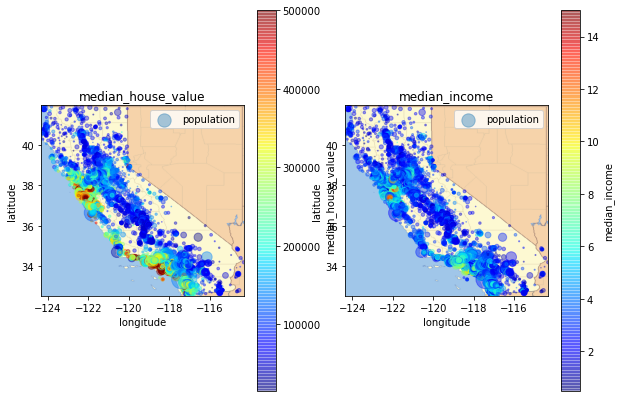

In [8]:
from skimage.io import imread
california_img = imread('california.png')
x1 = min(housing["longitude"].values)
x2 = max(housing["longitude"].values)
y1 = min(housing["latitude"].values)
y2 = max(housing["latitude"].values)
#---------------------------------------------
# the parameter c refers to color
# thus, median_house_value is color-coded in the left plot
fig, ax =plt.subplots(1,2)
housing.plot(ax=ax[0], kind="scatter", x="longitude", y="latitude",
             s=housing['population']/100, label="population",
             c="median_house_value", cmap=plt.get_cmap("jet"),
             colorbar=True, alpha=0.4, figsize=(10,7))
#---------------------------------------------
# the parameter c refers to color
# thus, median_income is color-coded in the right plot
ax[0].imshow(california_img,extent=[x1,x2,y1,y2])
ax[0].set_title('median_house_value')
housing.plot(ax=ax[1], kind="scatter", x="longitude", y="latitude",
             s=housing['population']/100, label="population",
             c="median_income", cmap=plt.get_cmap("jet"),
             colorbar=True, alpha=0.4, figsize=(10,7))
ax[1].imshow(california_img,extent=[x1,x2,y1,y2])
ax[1].set_title('median_income')

### Prepare the Training and Testing Datasets

In [9]:
X=housing.drop(['median_house_value'], axis=1)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,1,0


In [10]:
Y=housing['median_house_value']
Y.head()

0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
Name: median_house_value, dtype: float64

In [11]:
# convert pandas dataframe/series to numpy array
# sklearn functions may not work well with pandas data types
X_columns=X.columns #store the column names
X=X.values.astype('float32')
Y=Y.values.astype('float32')

### trainnig, validation, testing split

In [12]:
#trainnig, validation, testing split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
print('train:', X_train.shape, Y_train.shape)
print('validation:', X_val.shape, Y_val.shape)
print('test:', X_test.shape, Y_test.shape)

train: (14860, 13) (14860,)
validation: (1652, 13) (1652,)
test: (4128, 13) (4128,)


In [13]:
#apply feature normalization to training, validation and test sets
from sklearn.preprocessing import MinMaxScaler
scalerX=MinMaxScaler()
scalerX.fit(X_train) # think about why fit to X_train, not X ?
X_train=scalerX.transform(X_train)
X_val=scalerX.transform(X_val)
X_test=scalerX.transform(X_test)

In [14]:
X_train[0]

array([0.5786848 , 0.38044596, 0.19607843, 0.12570114, 0.13671634,
       0.00983827, 0.02795593, 0.11055019, 0.        , 1.        ,
       0.        , 0.        , 0.        ], dtype=float32)

In [15]:
#normalize the output to facilitate convergence
Y_train_max=Y_train.max()
Y_train/=Y_train_max
Y_val/=Y_train_max
Y_test/=Y_train_max

### use LinearRegression as the baseline model

In [16]:
#step1:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(fit_intercept=True)

In [17]:
#step2:
linear_model.fit(X_train, Y_train)

LinearRegression()

In [18]:
linear_model.coef_

array([-0.5266764 , -0.47057727,  0.11070023, -0.31356588,  0.8725244 ,
       -2.8026865 ,  1.009017  ,  1.1304905 , -0.0472497 , -0.12498007,
        0.26538375, -0.05612918, -0.03702435], dtype=float32)

In [19]:
linear_model.intercept_

0.5496546

Evaluate model on testing set
MSE= 0.018863905
MAE= 0.09931181
MAPE= 0.28951442


Text(0, 0.5, 'Y_test_pred')

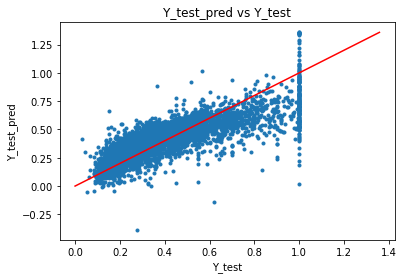

In [20]:
#step3:
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)
print('Evaluate model on testing set')
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)
#step6: 
# the red line is the 45-degree line
fig, ax = plt.subplots()
ax.set_title('Y_test_pred vs Y_test')
ax.plot(Y_test, Y_test_pred, '.')
ymax=np.max([Y_test.max(), Y_test_pred.max()])
ax.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')

## Your work begins here
see NN_nonlinear_regression_Pytorch.ipynb

#### define a dataset to hold/represent the data

In [21]:
#I give you the code here, because it is tricky
import torch
from torch.utils.data import Dataset as torch_dataset
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y.reshape(-1, 1) #this is very important
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):        
        # use the notation DatasetName[idx]
        # to get a data point (x,y) by idx
        # we need to convert numpy array to torch tensor
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.float32)
        return x, y

Create instance objects of the `MyDataset` class <br>
a training dataset `dataset_train` <br>
a validation dataset `dataset_val` <br>
a testing dataset `dataset_test` <br>

In [22]:
dataset_train = MyDataset(X_train, Y_train)
dataset_val = MyDataset(X_val, Y_val)
dataset_test = MyDataset(X_test, Y_test)

In [23]:
len(dataset_train) # get the number of data points in the training set

14860

create dataloaders which will be used to generate minibatches <br>
batch_size=N means each minibatch contains N data points  <br>
note: the last minibatch may contain less than N data points

In [24]:
from torch.utils.data import DataLoader as torch_dataloader
dataloader_train = torch_dataloader(dataset_train, batch_size=64, shuffle=True, num_workers=0)
dataloader_val = torch_dataloader(dataset_val, batch_size=64, shuffle=False, num_workers=0) 
dataloader_test = torch_dataloader(dataset_test, batch_size=64, shuffle=False, num_workers=0) 

In [25]:
len(dataloader_train) # get the number of minibatches

233

In [26]:
#verify the shape of each tensor in a batch
for batch_idx, (X, Y) in enumerate(dataloader_train):
    print(batch_idx, X.size(), Y.size())

0 torch.Size([64, 13]) torch.Size([64, 1])
1 torch.Size([64, 13]) torch.Size([64, 1])
2 torch.Size([64, 13]) torch.Size([64, 1])
3 torch.Size([64, 13]) torch.Size([64, 1])
4 torch.Size([64, 13]) torch.Size([64, 1])
5 torch.Size([64, 13]) torch.Size([64, 1])
6 torch.Size([64, 13]) torch.Size([64, 1])
7 torch.Size([64, 13]) torch.Size([64, 1])
8 torch.Size([64, 13]) torch.Size([64, 1])
9 torch.Size([64, 13]) torch.Size([64, 1])
10 torch.Size([64, 13]) torch.Size([64, 1])
11 torch.Size([64, 13]) torch.Size([64, 1])
12 torch.Size([64, 13]) torch.Size([64, 1])
13 torch.Size([64, 13]) torch.Size([64, 1])
14 torch.Size([64, 13]) torch.Size([64, 1])
15 torch.Size([64, 13]) torch.Size([64, 1])
16 torch.Size([64, 13]) torch.Size([64, 1])
17 torch.Size([64, 13]) torch.Size([64, 1])
18 torch.Size([64, 13]) torch.Size([64, 1])
19 torch.Size([64, 13]) torch.Size([64, 1])
20 torch.Size([64, 13]) torch.Size([64, 1])
21 torch.Size([64, 13]) torch.Size([64, 1])
22 torch.Size([64, 13]) torch.Size([64, 1]

186 torch.Size([64, 13]) torch.Size([64, 1])
187 torch.Size([64, 13]) torch.Size([64, 1])
188 torch.Size([64, 13]) torch.Size([64, 1])
189 torch.Size([64, 13]) torch.Size([64, 1])
190 torch.Size([64, 13]) torch.Size([64, 1])
191 torch.Size([64, 13]) torch.Size([64, 1])
192 torch.Size([64, 13]) torch.Size([64, 1])
193 torch.Size([64, 13]) torch.Size([64, 1])
194 torch.Size([64, 13]) torch.Size([64, 1])
195 torch.Size([64, 13]) torch.Size([64, 1])
196 torch.Size([64, 13]) torch.Size([64, 1])
197 torch.Size([64, 13]) torch.Size([64, 1])
198 torch.Size([64, 13]) torch.Size([64, 1])
199 torch.Size([64, 13]) torch.Size([64, 1])
200 torch.Size([64, 13]) torch.Size([64, 1])
201 torch.Size([64, 13]) torch.Size([64, 1])
202 torch.Size([64, 13]) torch.Size([64, 1])
203 torch.Size([64, 13]) torch.Size([64, 1])
204 torch.Size([64, 13]) torch.Size([64, 1])
205 torch.Size([64, 13]) torch.Size([64, 1])
206 torch.Size([64, 13]) torch.Size([64, 1])
207 torch.Size([64, 13]) torch.Size([64, 1])
208 torch.

#### Now, let's build a neural network that has many hidden layers and nonlinear activation - softplus

In [27]:
import torch.nn as nn
import torch.nn.functional as nnF
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, n_units):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_units)
        self.layer2 = nn.Linear(n_units, n_units)
        self.layer3 = nn.Linear(n_units, output_dim)        
    def forward(self, x):
        x=self.layer1(x)
        x=nnF.softplus(x)
        x=self.layer2(x)
        x=nnF.softplus(x)
        y=self.layer3(x)
        return y

create an instance object of the class

In [28]:
model=Net(input_dim=13, output_dim=1, n_units=16)

In [29]:
#move the model to GPU if you have a GPU
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (layer1): Linear(in_features=13, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
)

define a function to train the neural network in one epoch

In [30]:
def train(model, optimizer, dataloader, device, epoch):    
    model.train()#set model to train mode
    loss_train=0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear the grad of each parameter
        Yp = model(X)#forward pass
        loss = torch.mean((Yp-Y)**2) # MSE loss or other loss
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * X.size(0), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    return loss_train

define a function to evaluate the neural network on the validation set or the testing set

In [31]:
def test(model, dataloader, device):
    model.eval()#set model to evaluation mode
    loss_test=0
    mae_test=0
    sample_count=0
    with torch.no_grad(): # tell Pytorch not to build graph in the 'with' section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Yp = model(X)#forward pass
            loss_test+=torch.sum((Yp-Y)**2).item()
            mae_test+= torch.sum((Yp-Y).abs()).item()
            sample_count+=X.size(0)
    loss_test/=sample_count
    mae_test/=sample_count
    return loss_test, mae_test

create an optimizer (e.g. Adam) and send the parameters of the model to the optimizer

In [33]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train the neural network model for many epochs <br>
It may need 100 epochs to converge.
So, we will not save any model to harddrive 

In [35]:
loss_train_list=[]
loss_val_list=[]
for epoch in range(0, 100):    
    #-------- perform training --------------------------------
    loss_train=train(model, optimizer, dataloader_train, device, epoch)    
    loss_train_list.append(loss_train)
    print('epoch', epoch, 'training loss:', loss_train)
    #-------- perform validation --------------------------------
    loss_val, mae_val = test(model, dataloader_val, device)
    loss_val_list.append(loss_val)
    print('epoch', epoch, 'validation loss:', loss_val)

Train Epoch: 0 [0/14860 (0%)]	Loss: 0.039483
Train Epoch: 0 [64/14860 (0%)]	Loss: 0.043425
Train Epoch: 0 [128/14860 (1%)]	Loss: 0.035139
Train Epoch: 0 [192/14860 (1%)]	Loss: 0.045175
Train Epoch: 0 [256/14860 (2%)]	Loss: 0.062754
Train Epoch: 0 [320/14860 (2%)]	Loss: 0.039039
Train Epoch: 0 [384/14860 (3%)]	Loss: 0.057847
Train Epoch: 0 [448/14860 (3%)]	Loss: 0.058434
Train Epoch: 0 [512/14860 (3%)]	Loss: 0.040295
Train Epoch: 0 [576/14860 (4%)]	Loss: 0.044561
Train Epoch: 0 [640/14860 (4%)]	Loss: 0.039954
Train Epoch: 0 [704/14860 (5%)]	Loss: 0.042861
Train Epoch: 0 [768/14860 (5%)]	Loss: 0.057523
Train Epoch: 0 [832/14860 (6%)]	Loss: 0.053182
Train Epoch: 0 [896/14860 (6%)]	Loss: 0.056669
Train Epoch: 0 [960/14860 (6%)]	Loss: 0.065577
Train Epoch: 0 [1024/14860 (7%)]	Loss: 0.064781
Train Epoch: 0 [1088/14860 (7%)]	Loss: 0.044535
Train Epoch: 0 [1152/14860 (8%)]	Loss: 0.042041
Train Epoch: 0 [1216/14860 (8%)]	Loss: 0.061956
Train Epoch: 0 [1280/14860 (9%)]	Loss: 0.063642
Train Epoch

Train Epoch: 0 [11584/14860 (78%)]	Loss: 0.046308
Train Epoch: 0 [11648/14860 (78%)]	Loss: 0.045599
Train Epoch: 0 [11712/14860 (79%)]	Loss: 0.047348
Train Epoch: 0 [11776/14860 (79%)]	Loss: 0.046293
Train Epoch: 0 [11840/14860 (79%)]	Loss: 0.051465
Train Epoch: 0 [11904/14860 (80%)]	Loss: 0.048388
Train Epoch: 0 [11968/14860 (80%)]	Loss: 0.055583
Train Epoch: 0 [12032/14860 (81%)]	Loss: 0.039369
Train Epoch: 0 [12096/14860 (81%)]	Loss: 0.044255
Train Epoch: 0 [12160/14860 (82%)]	Loss: 0.041394
Train Epoch: 0 [12224/14860 (82%)]	Loss: 0.040859
Train Epoch: 0 [12288/14860 (82%)]	Loss: 0.055202
Train Epoch: 0 [12352/14860 (83%)]	Loss: 0.046460
Train Epoch: 0 [12416/14860 (83%)]	Loss: 0.048605
Train Epoch: 0 [12480/14860 (84%)]	Loss: 0.038438
Train Epoch: 0 [12544/14860 (84%)]	Loss: 0.035986
Train Epoch: 0 [12608/14860 (85%)]	Loss: 0.048360
Train Epoch: 0 [12672/14860 (85%)]	Loss: 0.057286
Train Epoch: 0 [12736/14860 (85%)]	Loss: 0.042727
Train Epoch: 0 [12800/14860 (86%)]	Loss: 0.055306


Train Epoch: 1 [8768/14860 (59%)]	Loss: 0.045794
Train Epoch: 1 [8832/14860 (59%)]	Loss: 0.038428
Train Epoch: 1 [8896/14860 (60%)]	Loss: 0.050899
Train Epoch: 1 [8960/14860 (60%)]	Loss: 0.049027
Train Epoch: 1 [9024/14860 (61%)]	Loss: 0.046897
Train Epoch: 1 [9088/14860 (61%)]	Loss: 0.046813
Train Epoch: 1 [9152/14860 (61%)]	Loss: 0.037510
Train Epoch: 1 [9216/14860 (62%)]	Loss: 0.026456
Train Epoch: 1 [9280/14860 (62%)]	Loss: 0.045890
Train Epoch: 1 [9344/14860 (63%)]	Loss: 0.026113
Train Epoch: 1 [9408/14860 (63%)]	Loss: 0.036425
Train Epoch: 1 [9472/14860 (64%)]	Loss: 0.058548
Train Epoch: 1 [9536/14860 (64%)]	Loss: 0.045284
Train Epoch: 1 [9600/14860 (64%)]	Loss: 0.046707
Train Epoch: 1 [9664/14860 (65%)]	Loss: 0.030264
Train Epoch: 1 [9728/14860 (65%)]	Loss: 0.040474
Train Epoch: 1 [9792/14860 (66%)]	Loss: 0.050229
Train Epoch: 1 [9856/14860 (66%)]	Loss: 0.032216
Train Epoch: 1 [9920/14860 (67%)]	Loss: 0.044376
Train Epoch: 1 [9984/14860 (67%)]	Loss: 0.039980
Train Epoch: 1 [1004

Train Epoch: 2 [5952/14860 (40%)]	Loss: 0.026660
Train Epoch: 2 [6016/14860 (40%)]	Loss: 0.046677
Train Epoch: 2 [6080/14860 (41%)]	Loss: 0.042602
Train Epoch: 2 [6144/14860 (41%)]	Loss: 0.043706
Train Epoch: 2 [6208/14860 (42%)]	Loss: 0.027125
Train Epoch: 2 [6272/14860 (42%)]	Loss: 0.034621
Train Epoch: 2 [6336/14860 (42%)]	Loss: 0.039999
Train Epoch: 2 [6400/14860 (43%)]	Loss: 0.038510
Train Epoch: 2 [6464/14860 (43%)]	Loss: 0.037385
Train Epoch: 2 [6528/14860 (44%)]	Loss: 0.033621
Train Epoch: 2 [6592/14860 (44%)]	Loss: 0.034112
Train Epoch: 2 [6656/14860 (45%)]	Loss: 0.058519
Train Epoch: 2 [6720/14860 (45%)]	Loss: 0.029363
Train Epoch: 2 [6784/14860 (45%)]	Loss: 0.041227
Train Epoch: 2 [6848/14860 (46%)]	Loss: 0.041702
Train Epoch: 2 [6912/14860 (46%)]	Loss: 0.025658
Train Epoch: 2 [6976/14860 (47%)]	Loss: 0.043550
Train Epoch: 2 [7040/14860 (47%)]	Loss: 0.043670
Train Epoch: 2 [7104/14860 (48%)]	Loss: 0.034431
Train Epoch: 2 [7168/14860 (48%)]	Loss: 0.034910
Train Epoch: 2 [7232

Train Epoch: 3 [2368/14860 (16%)]	Loss: 0.035927
Train Epoch: 3 [2432/14860 (16%)]	Loss: 0.032471
Train Epoch: 3 [2496/14860 (17%)]	Loss: 0.030598
Train Epoch: 3 [2560/14860 (17%)]	Loss: 0.030755
Train Epoch: 3 [2624/14860 (18%)]	Loss: 0.029078
Train Epoch: 3 [2688/14860 (18%)]	Loss: 0.033792
Train Epoch: 3 [2752/14860 (18%)]	Loss: 0.035601
Train Epoch: 3 [2816/14860 (19%)]	Loss: 0.035463
Train Epoch: 3 [2880/14860 (19%)]	Loss: 0.031470
Train Epoch: 3 [2944/14860 (20%)]	Loss: 0.039116
Train Epoch: 3 [3008/14860 (20%)]	Loss: 0.033953
Train Epoch: 3 [3072/14860 (21%)]	Loss: 0.025748
Train Epoch: 3 [3136/14860 (21%)]	Loss: 0.037828
Train Epoch: 3 [3200/14860 (21%)]	Loss: 0.054046
Train Epoch: 3 [3264/14860 (22%)]	Loss: 0.037762
Train Epoch: 3 [3328/14860 (22%)]	Loss: 0.039271
Train Epoch: 3 [3392/14860 (23%)]	Loss: 0.026003
Train Epoch: 3 [3456/14860 (23%)]	Loss: 0.026814
Train Epoch: 3 [3520/14860 (24%)]	Loss: 0.033804
Train Epoch: 3 [3584/14860 (24%)]	Loss: 0.029537
Train Epoch: 3 [3648

epoch 3 validation loss: 0.035628210257098406
Train Epoch: 4 [0/14860 (0%)]	Loss: 0.033553
Train Epoch: 4 [64/14860 (0%)]	Loss: 0.026882
Train Epoch: 4 [128/14860 (1%)]	Loss: 0.034379
Train Epoch: 4 [192/14860 (1%)]	Loss: 0.025970
Train Epoch: 4 [256/14860 (2%)]	Loss: 0.044369
Train Epoch: 4 [320/14860 (2%)]	Loss: 0.038296
Train Epoch: 4 [384/14860 (3%)]	Loss: 0.035493
Train Epoch: 4 [448/14860 (3%)]	Loss: 0.038150
Train Epoch: 4 [512/14860 (3%)]	Loss: 0.035622
Train Epoch: 4 [576/14860 (4%)]	Loss: 0.027298
Train Epoch: 4 [640/14860 (4%)]	Loss: 0.029751
Train Epoch: 4 [704/14860 (5%)]	Loss: 0.032299
Train Epoch: 4 [768/14860 (5%)]	Loss: 0.038624
Train Epoch: 4 [832/14860 (6%)]	Loss: 0.033956
Train Epoch: 4 [896/14860 (6%)]	Loss: 0.027065
Train Epoch: 4 [960/14860 (6%)]	Loss: 0.033887
Train Epoch: 4 [1024/14860 (7%)]	Loss: 0.028789
Train Epoch: 4 [1088/14860 (7%)]	Loss: 0.033088
Train Epoch: 4 [1152/14860 (8%)]	Loss: 0.049984
Train Epoch: 4 [1216/14860 (8%)]	Loss: 0.040758
Train Epoch: 

Train Epoch: 4 [12032/14860 (81%)]	Loss: 0.027203
Train Epoch: 4 [12096/14860 (81%)]	Loss: 0.030466
Train Epoch: 4 [12160/14860 (82%)]	Loss: 0.031829
Train Epoch: 4 [12224/14860 (82%)]	Loss: 0.034828
Train Epoch: 4 [12288/14860 (82%)]	Loss: 0.032249
Train Epoch: 4 [12352/14860 (83%)]	Loss: 0.035452
Train Epoch: 4 [12416/14860 (83%)]	Loss: 0.028132
Train Epoch: 4 [12480/14860 (84%)]	Loss: 0.033919
Train Epoch: 4 [12544/14860 (84%)]	Loss: 0.023942
Train Epoch: 4 [12608/14860 (85%)]	Loss: 0.019737
Train Epoch: 4 [12672/14860 (85%)]	Loss: 0.031455
Train Epoch: 4 [12736/14860 (85%)]	Loss: 0.035632
Train Epoch: 4 [12800/14860 (86%)]	Loss: 0.035840
Train Epoch: 4 [12864/14860 (86%)]	Loss: 0.031757
Train Epoch: 4 [12928/14860 (87%)]	Loss: 0.029913
Train Epoch: 4 [12992/14860 (87%)]	Loss: 0.035767
Train Epoch: 4 [13056/14860 (88%)]	Loss: 0.035140
Train Epoch: 4 [13120/14860 (88%)]	Loss: 0.030167
Train Epoch: 4 [13184/14860 (88%)]	Loss: 0.036614
Train Epoch: 4 [13248/14860 (89%)]	Loss: 0.029892


Train Epoch: 5 [7744/14860 (52%)]	Loss: 0.033647
Train Epoch: 5 [7808/14860 (52%)]	Loss: 0.023208
Train Epoch: 5 [7872/14860 (53%)]	Loss: 0.034720
Train Epoch: 5 [7936/14860 (53%)]	Loss: 0.041625
Train Epoch: 5 [8000/14860 (54%)]	Loss: 0.025088
Train Epoch: 5 [8064/14860 (54%)]	Loss: 0.031526
Train Epoch: 5 [8128/14860 (55%)]	Loss: 0.035791
Train Epoch: 5 [8192/14860 (55%)]	Loss: 0.024431
Train Epoch: 5 [8256/14860 (55%)]	Loss: 0.034065
Train Epoch: 5 [8320/14860 (56%)]	Loss: 0.021385
Train Epoch: 5 [8384/14860 (56%)]	Loss: 0.024967
Train Epoch: 5 [8448/14860 (57%)]	Loss: 0.037471
Train Epoch: 5 [8512/14860 (57%)]	Loss: 0.037205
Train Epoch: 5 [8576/14860 (58%)]	Loss: 0.021066
Train Epoch: 5 [8640/14860 (58%)]	Loss: 0.027802
Train Epoch: 5 [8704/14860 (58%)]	Loss: 0.034015
Train Epoch: 5 [8768/14860 (59%)]	Loss: 0.038297
Train Epoch: 5 [8832/14860 (59%)]	Loss: 0.031928
Train Epoch: 5 [8896/14860 (60%)]	Loss: 0.038149
Train Epoch: 5 [8960/14860 (60%)]	Loss: 0.032782
Train Epoch: 5 [9024

Train Epoch: 6 [4992/14860 (33%)]	Loss: 0.029731
Train Epoch: 6 [5056/14860 (34%)]	Loss: 0.019625
Train Epoch: 6 [5120/14860 (34%)]	Loss: 0.031197
Train Epoch: 6 [5184/14860 (35%)]	Loss: 0.027445
Train Epoch: 6 [5248/14860 (35%)]	Loss: 0.022000
Train Epoch: 6 [5312/14860 (36%)]	Loss: 0.023941
Train Epoch: 6 [5376/14860 (36%)]	Loss: 0.022523
Train Epoch: 6 [5440/14860 (36%)]	Loss: 0.041784
Train Epoch: 6 [5504/14860 (37%)]	Loss: 0.028094
Train Epoch: 6 [5568/14860 (37%)]	Loss: 0.021526
Train Epoch: 6 [5632/14860 (38%)]	Loss: 0.032056
Train Epoch: 6 [5696/14860 (38%)]	Loss: 0.026119
Train Epoch: 6 [5760/14860 (39%)]	Loss: 0.035518
Train Epoch: 6 [5824/14860 (39%)]	Loss: 0.026536
Train Epoch: 6 [5888/14860 (39%)]	Loss: 0.031076
Train Epoch: 6 [5952/14860 (40%)]	Loss: 0.032953
Train Epoch: 6 [6016/14860 (40%)]	Loss: 0.034884
Train Epoch: 6 [6080/14860 (41%)]	Loss: 0.023477
Train Epoch: 6 [6144/14860 (41%)]	Loss: 0.025145
Train Epoch: 6 [6208/14860 (42%)]	Loss: 0.023257
Train Epoch: 6 [6272

Train Epoch: 7 [2368/14860 (16%)]	Loss: 0.022189
Train Epoch: 7 [2432/14860 (16%)]	Loss: 0.019010
Train Epoch: 7 [2496/14860 (17%)]	Loss: 0.027266
Train Epoch: 7 [2560/14860 (17%)]	Loss: 0.034930
Train Epoch: 7 [2624/14860 (18%)]	Loss: 0.024034
Train Epoch: 7 [2688/14860 (18%)]	Loss: 0.022920
Train Epoch: 7 [2752/14860 (18%)]	Loss: 0.035523
Train Epoch: 7 [2816/14860 (19%)]	Loss: 0.037959
Train Epoch: 7 [2880/14860 (19%)]	Loss: 0.017577
Train Epoch: 7 [2944/14860 (20%)]	Loss: 0.028737
Train Epoch: 7 [3008/14860 (20%)]	Loss: 0.016378
Train Epoch: 7 [3072/14860 (21%)]	Loss: 0.019408
Train Epoch: 7 [3136/14860 (21%)]	Loss: 0.019827
Train Epoch: 7 [3200/14860 (21%)]	Loss: 0.030609
Train Epoch: 7 [3264/14860 (22%)]	Loss: 0.027267
Train Epoch: 7 [3328/14860 (22%)]	Loss: 0.017465
Train Epoch: 7 [3392/14860 (23%)]	Loss: 0.037215
Train Epoch: 7 [3456/14860 (23%)]	Loss: 0.038455
Train Epoch: 7 [3520/14860 (24%)]	Loss: 0.016610
Train Epoch: 7 [3584/14860 (24%)]	Loss: 0.017223
Train Epoch: 7 [3648

Train Epoch: 7 [13056/14860 (88%)]	Loss: 0.028162
Train Epoch: 7 [13120/14860 (88%)]	Loss: 0.021027
Train Epoch: 7 [13184/14860 (88%)]	Loss: 0.045145
Train Epoch: 7 [13248/14860 (89%)]	Loss: 0.018323
Train Epoch: 7 [13312/14860 (89%)]	Loss: 0.024512
Train Epoch: 7 [13376/14860 (90%)]	Loss: 0.033173
Train Epoch: 7 [13440/14860 (90%)]	Loss: 0.019315
Train Epoch: 7 [13504/14860 (91%)]	Loss: 0.033975
Train Epoch: 7 [13568/14860 (91%)]	Loss: 0.018383
Train Epoch: 7 [13632/14860 (91%)]	Loss: 0.036380
Train Epoch: 7 [13696/14860 (92%)]	Loss: 0.016703
Train Epoch: 7 [13760/14860 (92%)]	Loss: 0.031107
Train Epoch: 7 [13824/14860 (93%)]	Loss: 0.034008
Train Epoch: 7 [13888/14860 (93%)]	Loss: 0.011362
Train Epoch: 7 [13952/14860 (94%)]	Loss: 0.030736
Train Epoch: 7 [14016/14860 (94%)]	Loss: 0.033750
Train Epoch: 7 [14080/14860 (94%)]	Loss: 0.025467
Train Epoch: 7 [14144/14860 (95%)]	Loss: 0.015226
Train Epoch: 7 [14208/14860 (95%)]	Loss: 0.022064
Train Epoch: 7 [14272/14860 (96%)]	Loss: 0.021279


Train Epoch: 8 [10176/14860 (68%)]	Loss: 0.027855
Train Epoch: 8 [10240/14860 (69%)]	Loss: 0.019438
Train Epoch: 8 [10304/14860 (69%)]	Loss: 0.029433
Train Epoch: 8 [10368/14860 (70%)]	Loss: 0.016191
Train Epoch: 8 [10432/14860 (70%)]	Loss: 0.023008
Train Epoch: 8 [10496/14860 (70%)]	Loss: 0.016165
Train Epoch: 8 [10560/14860 (71%)]	Loss: 0.015471
Train Epoch: 8 [10624/14860 (71%)]	Loss: 0.023031
Train Epoch: 8 [10688/14860 (72%)]	Loss: 0.022944
Train Epoch: 8 [10752/14860 (72%)]	Loss: 0.023738
Train Epoch: 8 [10816/14860 (73%)]	Loss: 0.032725
Train Epoch: 8 [10880/14860 (73%)]	Loss: 0.023961
Train Epoch: 8 [10944/14860 (73%)]	Loss: 0.015990
Train Epoch: 8 [11008/14860 (74%)]	Loss: 0.029387
Train Epoch: 8 [11072/14860 (74%)]	Loss: 0.027819
Train Epoch: 8 [11136/14860 (75%)]	Loss: 0.016142
Train Epoch: 8 [11200/14860 (75%)]	Loss: 0.013366
Train Epoch: 8 [11264/14860 (76%)]	Loss: 0.012680
Train Epoch: 8 [11328/14860 (76%)]	Loss: 0.018903
Train Epoch: 8 [11392/14860 (76%)]	Loss: 0.020264


Train Epoch: 9 [7616/14860 (51%)]	Loss: 0.034994
Train Epoch: 9 [7680/14860 (52%)]	Loss: 0.020876
Train Epoch: 9 [7744/14860 (52%)]	Loss: 0.024713
Train Epoch: 9 [7808/14860 (52%)]	Loss: 0.027890
Train Epoch: 9 [7872/14860 (53%)]	Loss: 0.021765
Train Epoch: 9 [7936/14860 (53%)]	Loss: 0.017259
Train Epoch: 9 [8000/14860 (54%)]	Loss: 0.019192
Train Epoch: 9 [8064/14860 (54%)]	Loss: 0.013224
Train Epoch: 9 [8128/14860 (55%)]	Loss: 0.019032
Train Epoch: 9 [8192/14860 (55%)]	Loss: 0.013457
Train Epoch: 9 [8256/14860 (55%)]	Loss: 0.017010
Train Epoch: 9 [8320/14860 (56%)]	Loss: 0.023836
Train Epoch: 9 [8384/14860 (56%)]	Loss: 0.012860
Train Epoch: 9 [8448/14860 (57%)]	Loss: 0.019448
Train Epoch: 9 [8512/14860 (57%)]	Loss: 0.024745
Train Epoch: 9 [8576/14860 (58%)]	Loss: 0.023156
Train Epoch: 9 [8640/14860 (58%)]	Loss: 0.015581
Train Epoch: 9 [8704/14860 (58%)]	Loss: 0.026784
Train Epoch: 9 [8768/14860 (59%)]	Loss: 0.021663
Train Epoch: 9 [8832/14860 (59%)]	Loss: 0.014973
Train Epoch: 9 [8896

Train Epoch: 10 [4992/14860 (33%)]	Loss: 0.026889
Train Epoch: 10 [5056/14860 (34%)]	Loss: 0.033638
Train Epoch: 10 [5120/14860 (34%)]	Loss: 0.018108
Train Epoch: 10 [5184/14860 (35%)]	Loss: 0.016733
Train Epoch: 10 [5248/14860 (35%)]	Loss: 0.030669
Train Epoch: 10 [5312/14860 (36%)]	Loss: 0.016613
Train Epoch: 10 [5376/14860 (36%)]	Loss: 0.019816
Train Epoch: 10 [5440/14860 (36%)]	Loss: 0.016761
Train Epoch: 10 [5504/14860 (37%)]	Loss: 0.031212
Train Epoch: 10 [5568/14860 (37%)]	Loss: 0.025495
Train Epoch: 10 [5632/14860 (38%)]	Loss: 0.023194
Train Epoch: 10 [5696/14860 (38%)]	Loss: 0.030506
Train Epoch: 10 [5760/14860 (39%)]	Loss: 0.021772
Train Epoch: 10 [5824/14860 (39%)]	Loss: 0.012123
Train Epoch: 10 [5888/14860 (39%)]	Loss: 0.022669
Train Epoch: 10 [5952/14860 (40%)]	Loss: 0.019014
Train Epoch: 10 [6016/14860 (40%)]	Loss: 0.019440
Train Epoch: 10 [6080/14860 (41%)]	Loss: 0.027438
Train Epoch: 10 [6144/14860 (41%)]	Loss: 0.011141
Train Epoch: 10 [6208/14860 (42%)]	Loss: 0.018434


Train Epoch: 11 [2368/14860 (16%)]	Loss: 0.018223
Train Epoch: 11 [2432/14860 (16%)]	Loss: 0.015814
Train Epoch: 11 [2496/14860 (17%)]	Loss: 0.021104
Train Epoch: 11 [2560/14860 (17%)]	Loss: 0.028761
Train Epoch: 11 [2624/14860 (18%)]	Loss: 0.020136
Train Epoch: 11 [2688/14860 (18%)]	Loss: 0.023118
Train Epoch: 11 [2752/14860 (18%)]	Loss: 0.016348
Train Epoch: 11 [2816/14860 (19%)]	Loss: 0.015762
Train Epoch: 11 [2880/14860 (19%)]	Loss: 0.031937
Train Epoch: 11 [2944/14860 (20%)]	Loss: 0.015966
Train Epoch: 11 [3008/14860 (20%)]	Loss: 0.018793
Train Epoch: 11 [3072/14860 (21%)]	Loss: 0.020238
Train Epoch: 11 [3136/14860 (21%)]	Loss: 0.013213
Train Epoch: 11 [3200/14860 (21%)]	Loss: 0.012456
Train Epoch: 11 [3264/14860 (22%)]	Loss: 0.018064
Train Epoch: 11 [3328/14860 (22%)]	Loss: 0.018856
Train Epoch: 11 [3392/14860 (23%)]	Loss: 0.027875
Train Epoch: 11 [3456/14860 (23%)]	Loss: 0.020544
Train Epoch: 11 [3520/14860 (24%)]	Loss: 0.021085
Train Epoch: 11 [3584/14860 (24%)]	Loss: 0.017938


Train Epoch: 11 [14272/14860 (96%)]	Loss: 0.012077
Train Epoch: 11 [14336/14860 (96%)]	Loss: 0.017493
Train Epoch: 11 [14400/14860 (97%)]	Loss: 0.017482
Train Epoch: 11 [14464/14860 (97%)]	Loss: 0.019583
Train Epoch: 11 [14528/14860 (97%)]	Loss: 0.015880
Train Epoch: 11 [14592/14860 (98%)]	Loss: 0.016033
Train Epoch: 11 [14656/14860 (98%)]	Loss: 0.022459
Train Epoch: 11 [14720/14860 (99%)]	Loss: 0.033214
Train Epoch: 11 [14784/14860 (99%)]	Loss: 0.017018
Train Epoch: 11 [2784/14860 (100%)]	Loss: 0.005907
epoch 11 training loss: 0.020736829251802404
epoch 11 validation loss: 0.02211864465807021
Train Epoch: 12 [0/14860 (0%)]	Loss: 0.018927
Train Epoch: 12 [64/14860 (0%)]	Loss: 0.018934
Train Epoch: 12 [128/14860 (1%)]	Loss: 0.015847
Train Epoch: 12 [192/14860 (1%)]	Loss: 0.022740
Train Epoch: 12 [256/14860 (2%)]	Loss: 0.021287
Train Epoch: 12 [320/14860 (2%)]	Loss: 0.012576
Train Epoch: 12 [384/14860 (3%)]	Loss: 0.032193
Train Epoch: 12 [448/14860 (3%)]	Loss: 0.035907
Train Epoch: 12 [5

Train Epoch: 12 [10560/14860 (71%)]	Loss: 0.022053
Train Epoch: 12 [10624/14860 (71%)]	Loss: 0.016017
Train Epoch: 12 [10688/14860 (72%)]	Loss: 0.024477
Train Epoch: 12 [10752/14860 (72%)]	Loss: 0.032099
Train Epoch: 12 [10816/14860 (73%)]	Loss: 0.020204
Train Epoch: 12 [10880/14860 (73%)]	Loss: 0.013995
Train Epoch: 12 [10944/14860 (73%)]	Loss: 0.018651
Train Epoch: 12 [11008/14860 (74%)]	Loss: 0.014631
Train Epoch: 12 [11072/14860 (74%)]	Loss: 0.017882
Train Epoch: 12 [11136/14860 (75%)]	Loss: 0.021221
Train Epoch: 12 [11200/14860 (75%)]	Loss: 0.013729
Train Epoch: 12 [11264/14860 (76%)]	Loss: 0.018720
Train Epoch: 12 [11328/14860 (76%)]	Loss: 0.034181
Train Epoch: 12 [11392/14860 (76%)]	Loss: 0.012955
Train Epoch: 12 [11456/14860 (77%)]	Loss: 0.015669
Train Epoch: 12 [11520/14860 (77%)]	Loss: 0.019088
Train Epoch: 12 [11584/14860 (78%)]	Loss: 0.021005
Train Epoch: 12 [11648/14860 (78%)]	Loss: 0.018983
Train Epoch: 12 [11712/14860 (79%)]	Loss: 0.019095
Train Epoch: 12 [11776/14860 (7

Train Epoch: 13 [7424/14860 (50%)]	Loss: 0.015740
Train Epoch: 13 [7488/14860 (50%)]	Loss: 0.012322
Train Epoch: 13 [7552/14860 (51%)]	Loss: 0.017801
Train Epoch: 13 [7616/14860 (51%)]	Loss: 0.025708
Train Epoch: 13 [7680/14860 (52%)]	Loss: 0.015734
Train Epoch: 13 [7744/14860 (52%)]	Loss: 0.021534
Train Epoch: 13 [7808/14860 (52%)]	Loss: 0.015347
Train Epoch: 13 [7872/14860 (53%)]	Loss: 0.024134
Train Epoch: 13 [7936/14860 (53%)]	Loss: 0.025873
Train Epoch: 13 [8000/14860 (54%)]	Loss: 0.030491
Train Epoch: 13 [8064/14860 (54%)]	Loss: 0.017021
Train Epoch: 13 [8128/14860 (55%)]	Loss: 0.016133
Train Epoch: 13 [8192/14860 (55%)]	Loss: 0.012478
Train Epoch: 13 [8256/14860 (55%)]	Loss: 0.024183
Train Epoch: 13 [8320/14860 (56%)]	Loss: 0.031766
Train Epoch: 13 [8384/14860 (56%)]	Loss: 0.016412
Train Epoch: 13 [8448/14860 (57%)]	Loss: 0.019135
Train Epoch: 13 [8512/14860 (57%)]	Loss: 0.017487
Train Epoch: 13 [8576/14860 (58%)]	Loss: 0.026089
Train Epoch: 13 [8640/14860 (58%)]	Loss: 0.029104


Train Epoch: 14 [5248/14860 (35%)]	Loss: 0.018037
Train Epoch: 14 [5312/14860 (36%)]	Loss: 0.011421
Train Epoch: 14 [5376/14860 (36%)]	Loss: 0.015343
Train Epoch: 14 [5440/14860 (36%)]	Loss: 0.035804
Train Epoch: 14 [5504/14860 (37%)]	Loss: 0.017706
Train Epoch: 14 [5568/14860 (37%)]	Loss: 0.017313
Train Epoch: 14 [5632/14860 (38%)]	Loss: 0.016744
Train Epoch: 14 [5696/14860 (38%)]	Loss: 0.017138
Train Epoch: 14 [5760/14860 (39%)]	Loss: 0.019433
Train Epoch: 14 [5824/14860 (39%)]	Loss: 0.027341
Train Epoch: 14 [5888/14860 (39%)]	Loss: 0.008252
Train Epoch: 14 [5952/14860 (40%)]	Loss: 0.009463
Train Epoch: 14 [6016/14860 (40%)]	Loss: 0.019920
Train Epoch: 14 [6080/14860 (41%)]	Loss: 0.019927
Train Epoch: 14 [6144/14860 (41%)]	Loss: 0.020596
Train Epoch: 14 [6208/14860 (42%)]	Loss: 0.026766
Train Epoch: 14 [6272/14860 (42%)]	Loss: 0.031919
Train Epoch: 14 [6336/14860 (42%)]	Loss: 0.021973
Train Epoch: 14 [6400/14860 (43%)]	Loss: 0.020265
Train Epoch: 14 [6464/14860 (43%)]	Loss: 0.011833


Train Epoch: 15 [2560/14860 (17%)]	Loss: 0.026698
Train Epoch: 15 [2624/14860 (18%)]	Loss: 0.018736
Train Epoch: 15 [2688/14860 (18%)]	Loss: 0.023203
Train Epoch: 15 [2752/14860 (18%)]	Loss: 0.025951
Train Epoch: 15 [2816/14860 (19%)]	Loss: 0.012791
Train Epoch: 15 [2880/14860 (19%)]	Loss: 0.015843
Train Epoch: 15 [2944/14860 (20%)]	Loss: 0.021391
Train Epoch: 15 [3008/14860 (20%)]	Loss: 0.017339
Train Epoch: 15 [3072/14860 (21%)]	Loss: 0.022898
Train Epoch: 15 [3136/14860 (21%)]	Loss: 0.008600
Train Epoch: 15 [3200/14860 (21%)]	Loss: 0.018596
Train Epoch: 15 [3264/14860 (22%)]	Loss: 0.024351
Train Epoch: 15 [3328/14860 (22%)]	Loss: 0.012712
Train Epoch: 15 [3392/14860 (23%)]	Loss: 0.037356
Train Epoch: 15 [3456/14860 (23%)]	Loss: 0.018704
Train Epoch: 15 [3520/14860 (24%)]	Loss: 0.018223
Train Epoch: 15 [3584/14860 (24%)]	Loss: 0.024449
Train Epoch: 15 [3648/14860 (24%)]	Loss: 0.024643
Train Epoch: 15 [3712/14860 (25%)]	Loss: 0.011769
Train Epoch: 15 [3776/14860 (25%)]	Loss: 0.018543


epoch 15 validation loss: 0.02172531007132865
Train Epoch: 16 [0/14860 (0%)]	Loss: 0.023309
Train Epoch: 16 [64/14860 (0%)]	Loss: 0.020824
Train Epoch: 16 [128/14860 (1%)]	Loss: 0.037554
Train Epoch: 16 [192/14860 (1%)]	Loss: 0.023096
Train Epoch: 16 [256/14860 (2%)]	Loss: 0.016786
Train Epoch: 16 [320/14860 (2%)]	Loss: 0.016076
Train Epoch: 16 [384/14860 (3%)]	Loss: 0.021397
Train Epoch: 16 [448/14860 (3%)]	Loss: 0.017988
Train Epoch: 16 [512/14860 (3%)]	Loss: 0.028636
Train Epoch: 16 [576/14860 (4%)]	Loss: 0.023260
Train Epoch: 16 [640/14860 (4%)]	Loss: 0.014154
Train Epoch: 16 [704/14860 (5%)]	Loss: 0.024472
Train Epoch: 16 [768/14860 (5%)]	Loss: 0.017595
Train Epoch: 16 [832/14860 (6%)]	Loss: 0.024070
Train Epoch: 16 [896/14860 (6%)]	Loss: 0.023578
Train Epoch: 16 [960/14860 (6%)]	Loss: 0.013159
Train Epoch: 16 [1024/14860 (7%)]	Loss: 0.017135
Train Epoch: 16 [1088/14860 (7%)]	Loss: 0.018934
Train Epoch: 16 [1152/14860 (8%)]	Loss: 0.016077
Train Epoch: 16 [1216/14860 (8%)]	Loss: 0.

Train Epoch: 16 [12608/14860 (85%)]	Loss: 0.028128
Train Epoch: 16 [12672/14860 (85%)]	Loss: 0.011986
Train Epoch: 16 [12736/14860 (85%)]	Loss: 0.015688
Train Epoch: 16 [12800/14860 (86%)]	Loss: 0.018750
Train Epoch: 16 [12864/14860 (86%)]	Loss: 0.030850
Train Epoch: 16 [12928/14860 (87%)]	Loss: 0.017024
Train Epoch: 16 [12992/14860 (87%)]	Loss: 0.014927
Train Epoch: 16 [13056/14860 (88%)]	Loss: 0.012311
Train Epoch: 16 [13120/14860 (88%)]	Loss: 0.021257
Train Epoch: 16 [13184/14860 (88%)]	Loss: 0.028464
Train Epoch: 16 [13248/14860 (89%)]	Loss: 0.015117
Train Epoch: 16 [13312/14860 (89%)]	Loss: 0.020418
Train Epoch: 16 [13376/14860 (90%)]	Loss: 0.015734
Train Epoch: 16 [13440/14860 (90%)]	Loss: 0.028170
Train Epoch: 16 [13504/14860 (91%)]	Loss: 0.022399
Train Epoch: 16 [13568/14860 (91%)]	Loss: 0.014928
Train Epoch: 16 [13632/14860 (91%)]	Loss: 0.017038
Train Epoch: 16 [13696/14860 (92%)]	Loss: 0.026334
Train Epoch: 16 [13760/14860 (92%)]	Loss: 0.014435
Train Epoch: 16 [13824/14860 (9

Train Epoch: 17 [9344/14860 (63%)]	Loss: 0.020721
Train Epoch: 17 [9408/14860 (63%)]	Loss: 0.018892
Train Epoch: 17 [9472/14860 (64%)]	Loss: 0.014643
Train Epoch: 17 [9536/14860 (64%)]	Loss: 0.015188
Train Epoch: 17 [9600/14860 (64%)]	Loss: 0.012716
Train Epoch: 17 [9664/14860 (65%)]	Loss: 0.021968
Train Epoch: 17 [9728/14860 (65%)]	Loss: 0.016110
Train Epoch: 17 [9792/14860 (66%)]	Loss: 0.015386
Train Epoch: 17 [9856/14860 (66%)]	Loss: 0.010579
Train Epoch: 17 [9920/14860 (67%)]	Loss: 0.020233
Train Epoch: 17 [9984/14860 (67%)]	Loss: 0.026901
Train Epoch: 17 [10048/14860 (67%)]	Loss: 0.014959
Train Epoch: 17 [10112/14860 (68%)]	Loss: 0.021693
Train Epoch: 17 [10176/14860 (68%)]	Loss: 0.026443
Train Epoch: 17 [10240/14860 (69%)]	Loss: 0.021517
Train Epoch: 17 [10304/14860 (69%)]	Loss: 0.022395
Train Epoch: 17 [10368/14860 (70%)]	Loss: 0.014308
Train Epoch: 17 [10432/14860 (70%)]	Loss: 0.023380
Train Epoch: 17 [10496/14860 (70%)]	Loss: 0.032853
Train Epoch: 17 [10560/14860 (71%)]	Loss: 

Train Epoch: 18 [5184/14860 (35%)]	Loss: 0.028590
Train Epoch: 18 [5248/14860 (35%)]	Loss: 0.016395
Train Epoch: 18 [5312/14860 (36%)]	Loss: 0.017810
Train Epoch: 18 [5376/14860 (36%)]	Loss: 0.012607
Train Epoch: 18 [5440/14860 (36%)]	Loss: 0.015488
Train Epoch: 18 [5504/14860 (37%)]	Loss: 0.023350
Train Epoch: 18 [5568/14860 (37%)]	Loss: 0.014500
Train Epoch: 18 [5632/14860 (38%)]	Loss: 0.029201
Train Epoch: 18 [5696/14860 (38%)]	Loss: 0.031422
Train Epoch: 18 [5760/14860 (39%)]	Loss: 0.032299
Train Epoch: 18 [5824/14860 (39%)]	Loss: 0.019056
Train Epoch: 18 [5888/14860 (39%)]	Loss: 0.017744
Train Epoch: 18 [5952/14860 (40%)]	Loss: 0.019734
Train Epoch: 18 [6016/14860 (40%)]	Loss: 0.019930
Train Epoch: 18 [6080/14860 (41%)]	Loss: 0.028810
Train Epoch: 18 [6144/14860 (41%)]	Loss: 0.033991
Train Epoch: 18 [6208/14860 (42%)]	Loss: 0.023810
Train Epoch: 18 [6272/14860 (42%)]	Loss: 0.014473
Train Epoch: 18 [6336/14860 (42%)]	Loss: 0.016710
Train Epoch: 18 [6400/14860 (43%)]	Loss: 0.021748


Train Epoch: 19 [2240/14860 (15%)]	Loss: 0.029633
Train Epoch: 19 [2304/14860 (15%)]	Loss: 0.017252
Train Epoch: 19 [2368/14860 (16%)]	Loss: 0.020867
Train Epoch: 19 [2432/14860 (16%)]	Loss: 0.019693
Train Epoch: 19 [2496/14860 (17%)]	Loss: 0.007698
Train Epoch: 19 [2560/14860 (17%)]	Loss: 0.012190
Train Epoch: 19 [2624/14860 (18%)]	Loss: 0.021291
Train Epoch: 19 [2688/14860 (18%)]	Loss: 0.016099
Train Epoch: 19 [2752/14860 (18%)]	Loss: 0.015405
Train Epoch: 19 [2816/14860 (19%)]	Loss: 0.024811
Train Epoch: 19 [2880/14860 (19%)]	Loss: 0.022197
Train Epoch: 19 [2944/14860 (20%)]	Loss: 0.015581
Train Epoch: 19 [3008/14860 (20%)]	Loss: 0.010984
Train Epoch: 19 [3072/14860 (21%)]	Loss: 0.016611
Train Epoch: 19 [3136/14860 (21%)]	Loss: 0.026268
Train Epoch: 19 [3200/14860 (21%)]	Loss: 0.015904
Train Epoch: 19 [3264/14860 (22%)]	Loss: 0.022514
Train Epoch: 19 [3328/14860 (22%)]	Loss: 0.028827
Train Epoch: 19 [3392/14860 (23%)]	Loss: 0.018491
Train Epoch: 19 [3456/14860 (23%)]	Loss: 0.022746


epoch 19 validation loss: 0.02145709992176684
Train Epoch: 20 [0/14860 (0%)]	Loss: 0.020249
Train Epoch: 20 [64/14860 (0%)]	Loss: 0.015847
Train Epoch: 20 [128/14860 (1%)]	Loss: 0.018492
Train Epoch: 20 [192/14860 (1%)]	Loss: 0.013854
Train Epoch: 20 [256/14860 (2%)]	Loss: 0.013903
Train Epoch: 20 [320/14860 (2%)]	Loss: 0.017911
Train Epoch: 20 [384/14860 (3%)]	Loss: 0.020073
Train Epoch: 20 [448/14860 (3%)]	Loss: 0.019998
Train Epoch: 20 [512/14860 (3%)]	Loss: 0.013513
Train Epoch: 20 [576/14860 (4%)]	Loss: 0.025852
Train Epoch: 20 [640/14860 (4%)]	Loss: 0.012980
Train Epoch: 20 [704/14860 (5%)]	Loss: 0.016244
Train Epoch: 20 [768/14860 (5%)]	Loss: 0.016683
Train Epoch: 20 [832/14860 (6%)]	Loss: 0.037462
Train Epoch: 20 [896/14860 (6%)]	Loss: 0.023084
Train Epoch: 20 [960/14860 (6%)]	Loss: 0.016648
Train Epoch: 20 [1024/14860 (7%)]	Loss: 0.011965
Train Epoch: 20 [1088/14860 (7%)]	Loss: 0.026026
Train Epoch: 20 [1152/14860 (8%)]	Loss: 0.025115
Train Epoch: 20 [1216/14860 (8%)]	Loss: 0.

Train Epoch: 20 [12544/14860 (84%)]	Loss: 0.023639
Train Epoch: 20 [12608/14860 (85%)]	Loss: 0.022132
Train Epoch: 20 [12672/14860 (85%)]	Loss: 0.025758
Train Epoch: 20 [12736/14860 (85%)]	Loss: 0.012729
Train Epoch: 20 [12800/14860 (86%)]	Loss: 0.020386
Train Epoch: 20 [12864/14860 (86%)]	Loss: 0.021321
Train Epoch: 20 [12928/14860 (87%)]	Loss: 0.026582
Train Epoch: 20 [12992/14860 (87%)]	Loss: 0.022220
Train Epoch: 20 [13056/14860 (88%)]	Loss: 0.012574
Train Epoch: 20 [13120/14860 (88%)]	Loss: 0.022128
Train Epoch: 20 [13184/14860 (88%)]	Loss: 0.019745
Train Epoch: 20 [13248/14860 (89%)]	Loss: 0.011437
Train Epoch: 20 [13312/14860 (89%)]	Loss: 0.019330
Train Epoch: 20 [13376/14860 (90%)]	Loss: 0.015690
Train Epoch: 20 [13440/14860 (90%)]	Loss: 0.032318
Train Epoch: 20 [13504/14860 (91%)]	Loss: 0.015249
Train Epoch: 20 [13568/14860 (91%)]	Loss: 0.038469
Train Epoch: 20 [13632/14860 (91%)]	Loss: 0.020158
Train Epoch: 20 [13696/14860 (92%)]	Loss: 0.010525
Train Epoch: 20 [13760/14860 (9

Train Epoch: 21 [10112/14860 (68%)]	Loss: 0.027462
Train Epoch: 21 [10176/14860 (68%)]	Loss: 0.025112
Train Epoch: 21 [10240/14860 (69%)]	Loss: 0.014811
Train Epoch: 21 [10304/14860 (69%)]	Loss: 0.017610
Train Epoch: 21 [10368/14860 (70%)]	Loss: 0.029187
Train Epoch: 21 [10432/14860 (70%)]	Loss: 0.015256
Train Epoch: 21 [10496/14860 (70%)]	Loss: 0.023574
Train Epoch: 21 [10560/14860 (71%)]	Loss: 0.028430
Train Epoch: 21 [10624/14860 (71%)]	Loss: 0.025909
Train Epoch: 21 [10688/14860 (72%)]	Loss: 0.012030
Train Epoch: 21 [10752/14860 (72%)]	Loss: 0.033050
Train Epoch: 21 [10816/14860 (73%)]	Loss: 0.018478
Train Epoch: 21 [10880/14860 (73%)]	Loss: 0.019622
Train Epoch: 21 [10944/14860 (73%)]	Loss: 0.018212
Train Epoch: 21 [11008/14860 (74%)]	Loss: 0.014082
Train Epoch: 21 [11072/14860 (74%)]	Loss: 0.030789
Train Epoch: 21 [11136/14860 (75%)]	Loss: 0.021240
Train Epoch: 21 [11200/14860 (75%)]	Loss: 0.016162
Train Epoch: 21 [11264/14860 (76%)]	Loss: 0.025309
Train Epoch: 21 [11328/14860 (7

Train Epoch: 22 [7232/14860 (48%)]	Loss: 0.017623
Train Epoch: 22 [7296/14860 (49%)]	Loss: 0.018060
Train Epoch: 22 [7360/14860 (49%)]	Loss: 0.016880
Train Epoch: 22 [7424/14860 (50%)]	Loss: 0.021388
Train Epoch: 22 [7488/14860 (50%)]	Loss: 0.026857
Train Epoch: 22 [7552/14860 (51%)]	Loss: 0.020523
Train Epoch: 22 [7616/14860 (51%)]	Loss: 0.016945
Train Epoch: 22 [7680/14860 (52%)]	Loss: 0.022533
Train Epoch: 22 [7744/14860 (52%)]	Loss: 0.020561
Train Epoch: 22 [7808/14860 (52%)]	Loss: 0.023931
Train Epoch: 22 [7872/14860 (53%)]	Loss: 0.020982
Train Epoch: 22 [7936/14860 (53%)]	Loss: 0.027805
Train Epoch: 22 [8000/14860 (54%)]	Loss: 0.014782
Train Epoch: 22 [8064/14860 (54%)]	Loss: 0.014243
Train Epoch: 22 [8128/14860 (55%)]	Loss: 0.025245
Train Epoch: 22 [8192/14860 (55%)]	Loss: 0.020826
Train Epoch: 22 [8256/14860 (55%)]	Loss: 0.022284
Train Epoch: 22 [8320/14860 (56%)]	Loss: 0.031893
Train Epoch: 22 [8384/14860 (56%)]	Loss: 0.011213
Train Epoch: 22 [8448/14860 (57%)]	Loss: 0.031971


Train Epoch: 23 [4928/14860 (33%)]	Loss: 0.019433
Train Epoch: 23 [4992/14860 (33%)]	Loss: 0.024289
Train Epoch: 23 [5056/14860 (34%)]	Loss: 0.026144
Train Epoch: 23 [5120/14860 (34%)]	Loss: 0.019189
Train Epoch: 23 [5184/14860 (35%)]	Loss: 0.023229
Train Epoch: 23 [5248/14860 (35%)]	Loss: 0.026964
Train Epoch: 23 [5312/14860 (36%)]	Loss: 0.018847
Train Epoch: 23 [5376/14860 (36%)]	Loss: 0.030574
Train Epoch: 23 [5440/14860 (36%)]	Loss: 0.020622
Train Epoch: 23 [5504/14860 (37%)]	Loss: 0.031062
Train Epoch: 23 [5568/14860 (37%)]	Loss: 0.016150
Train Epoch: 23 [5632/14860 (38%)]	Loss: 0.031623
Train Epoch: 23 [5696/14860 (38%)]	Loss: 0.011567
Train Epoch: 23 [5760/14860 (39%)]	Loss: 0.021987
Train Epoch: 23 [5824/14860 (39%)]	Loss: 0.021343
Train Epoch: 23 [5888/14860 (39%)]	Loss: 0.017071
Train Epoch: 23 [5952/14860 (40%)]	Loss: 0.014956
Train Epoch: 23 [6016/14860 (40%)]	Loss: 0.027974
Train Epoch: 23 [6080/14860 (41%)]	Loss: 0.019583
Train Epoch: 23 [6144/14860 (41%)]	Loss: 0.019019


Train Epoch: 24 [1728/14860 (12%)]	Loss: 0.027242
Train Epoch: 24 [1792/14860 (12%)]	Loss: 0.024823
Train Epoch: 24 [1856/14860 (12%)]	Loss: 0.024077
Train Epoch: 24 [1920/14860 (13%)]	Loss: 0.026331
Train Epoch: 24 [1984/14860 (13%)]	Loss: 0.020147
Train Epoch: 24 [2048/14860 (14%)]	Loss: 0.017503
Train Epoch: 24 [2112/14860 (14%)]	Loss: 0.013515
Train Epoch: 24 [2176/14860 (15%)]	Loss: 0.017242
Train Epoch: 24 [2240/14860 (15%)]	Loss: 0.030732
Train Epoch: 24 [2304/14860 (15%)]	Loss: 0.018345
Train Epoch: 24 [2368/14860 (16%)]	Loss: 0.024380
Train Epoch: 24 [2432/14860 (16%)]	Loss: 0.011254
Train Epoch: 24 [2496/14860 (17%)]	Loss: 0.021153
Train Epoch: 24 [2560/14860 (17%)]	Loss: 0.009850
Train Epoch: 24 [2624/14860 (18%)]	Loss: 0.027244
Train Epoch: 24 [2688/14860 (18%)]	Loss: 0.031248
Train Epoch: 24 [2752/14860 (18%)]	Loss: 0.023479
Train Epoch: 24 [2816/14860 (19%)]	Loss: 0.012239
Train Epoch: 24 [2880/14860 (19%)]	Loss: 0.011306
Train Epoch: 24 [2944/14860 (20%)]	Loss: 0.008859


Train Epoch: 24 [14336/14860 (96%)]	Loss: 0.021956
Train Epoch: 24 [14400/14860 (97%)]	Loss: 0.018567
Train Epoch: 24 [14464/14860 (97%)]	Loss: 0.020245
Train Epoch: 24 [14528/14860 (97%)]	Loss: 0.017989
Train Epoch: 24 [14592/14860 (98%)]	Loss: 0.024821
Train Epoch: 24 [14656/14860 (98%)]	Loss: 0.016729
Train Epoch: 24 [14720/14860 (99%)]	Loss: 0.027884
Train Epoch: 24 [14784/14860 (99%)]	Loss: 0.022599
Train Epoch: 24 [2784/14860 (100%)]	Loss: 0.012625
epoch 24 training loss: 0.019776116195234745
epoch 24 validation loss: 0.021221492827371593
Train Epoch: 25 [0/14860 (0%)]	Loss: 0.018143
Train Epoch: 25 [64/14860 (0%)]	Loss: 0.022307
Train Epoch: 25 [128/14860 (1%)]	Loss: 0.028583
Train Epoch: 25 [192/14860 (1%)]	Loss: 0.015778
Train Epoch: 25 [256/14860 (2%)]	Loss: 0.017927
Train Epoch: 25 [320/14860 (2%)]	Loss: 0.024073
Train Epoch: 25 [384/14860 (3%)]	Loss: 0.019612
Train Epoch: 25 [448/14860 (3%)]	Loss: 0.018113
Train Epoch: 25 [512/14860 (3%)]	Loss: 0.025498
Train Epoch: 25 [576

Train Epoch: 25 [11136/14860 (75%)]	Loss: 0.016811
Train Epoch: 25 [11200/14860 (75%)]	Loss: 0.012698
Train Epoch: 25 [11264/14860 (76%)]	Loss: 0.026694
Train Epoch: 25 [11328/14860 (76%)]	Loss: 0.028321
Train Epoch: 25 [11392/14860 (76%)]	Loss: 0.015220
Train Epoch: 25 [11456/14860 (77%)]	Loss: 0.013966
Train Epoch: 25 [11520/14860 (77%)]	Loss: 0.023769
Train Epoch: 25 [11584/14860 (78%)]	Loss: 0.017722
Train Epoch: 25 [11648/14860 (78%)]	Loss: 0.020262
Train Epoch: 25 [11712/14860 (79%)]	Loss: 0.020175
Train Epoch: 25 [11776/14860 (79%)]	Loss: 0.021593
Train Epoch: 25 [11840/14860 (79%)]	Loss: 0.024103
Train Epoch: 25 [11904/14860 (80%)]	Loss: 0.023311
Train Epoch: 25 [11968/14860 (80%)]	Loss: 0.022371
Train Epoch: 25 [12032/14860 (81%)]	Loss: 0.024019
Train Epoch: 25 [12096/14860 (81%)]	Loss: 0.017566
Train Epoch: 25 [12160/14860 (82%)]	Loss: 0.012957
Train Epoch: 25 [12224/14860 (82%)]	Loss: 0.027524
Train Epoch: 25 [12288/14860 (82%)]	Loss: 0.018122
Train Epoch: 25 [12352/14860 (8

Train Epoch: 26 [7936/14860 (53%)]	Loss: 0.014929
Train Epoch: 26 [8000/14860 (54%)]	Loss: 0.018124
Train Epoch: 26 [8064/14860 (54%)]	Loss: 0.016073
Train Epoch: 26 [8128/14860 (55%)]	Loss: 0.016651
Train Epoch: 26 [8192/14860 (55%)]	Loss: 0.013519
Train Epoch: 26 [8256/14860 (55%)]	Loss: 0.016047
Train Epoch: 26 [8320/14860 (56%)]	Loss: 0.030681
Train Epoch: 26 [8384/14860 (56%)]	Loss: 0.023873
Train Epoch: 26 [8448/14860 (57%)]	Loss: 0.020538
Train Epoch: 26 [8512/14860 (57%)]	Loss: 0.017380
Train Epoch: 26 [8576/14860 (58%)]	Loss: 0.015177
Train Epoch: 26 [8640/14860 (58%)]	Loss: 0.032441
Train Epoch: 26 [8704/14860 (58%)]	Loss: 0.016962
Train Epoch: 26 [8768/14860 (59%)]	Loss: 0.025976
Train Epoch: 26 [8832/14860 (59%)]	Loss: 0.018868
Train Epoch: 26 [8896/14860 (60%)]	Loss: 0.020324
Train Epoch: 26 [8960/14860 (60%)]	Loss: 0.023952
Train Epoch: 26 [9024/14860 (61%)]	Loss: 0.023247
Train Epoch: 26 [9088/14860 (61%)]	Loss: 0.012432
Train Epoch: 26 [9152/14860 (61%)]	Loss: 0.024329


Train Epoch: 27 [4608/14860 (31%)]	Loss: 0.038332
Train Epoch: 27 [4672/14860 (31%)]	Loss: 0.013853
Train Epoch: 27 [4736/14860 (32%)]	Loss: 0.017623
Train Epoch: 27 [4800/14860 (32%)]	Loss: 0.018180
Train Epoch: 27 [4864/14860 (33%)]	Loss: 0.017569
Train Epoch: 27 [4928/14860 (33%)]	Loss: 0.024468
Train Epoch: 27 [4992/14860 (33%)]	Loss: 0.014940
Train Epoch: 27 [5056/14860 (34%)]	Loss: 0.012637
Train Epoch: 27 [5120/14860 (34%)]	Loss: 0.016016
Train Epoch: 27 [5184/14860 (35%)]	Loss: 0.011609
Train Epoch: 27 [5248/14860 (35%)]	Loss: 0.019215
Train Epoch: 27 [5312/14860 (36%)]	Loss: 0.021011
Train Epoch: 27 [5376/14860 (36%)]	Loss: 0.019669
Train Epoch: 27 [5440/14860 (36%)]	Loss: 0.018836
Train Epoch: 27 [5504/14860 (37%)]	Loss: 0.019536
Train Epoch: 27 [5568/14860 (37%)]	Loss: 0.017545
Train Epoch: 27 [5632/14860 (38%)]	Loss: 0.015842
Train Epoch: 27 [5696/14860 (38%)]	Loss: 0.017408
Train Epoch: 27 [5760/14860 (39%)]	Loss: 0.012645
Train Epoch: 27 [5824/14860 (39%)]	Loss: 0.022525


Train Epoch: 28 [1536/14860 (10%)]	Loss: 0.015912
Train Epoch: 28 [1600/14860 (11%)]	Loss: 0.015255
Train Epoch: 28 [1664/14860 (11%)]	Loss: 0.022398
Train Epoch: 28 [1728/14860 (12%)]	Loss: 0.024392
Train Epoch: 28 [1792/14860 (12%)]	Loss: 0.019753
Train Epoch: 28 [1856/14860 (12%)]	Loss: 0.014168
Train Epoch: 28 [1920/14860 (13%)]	Loss: 0.020995
Train Epoch: 28 [1984/14860 (13%)]	Loss: 0.021310
Train Epoch: 28 [2048/14860 (14%)]	Loss: 0.028133
Train Epoch: 28 [2112/14860 (14%)]	Loss: 0.019511
Train Epoch: 28 [2176/14860 (15%)]	Loss: 0.019108
Train Epoch: 28 [2240/14860 (15%)]	Loss: 0.017533
Train Epoch: 28 [2304/14860 (15%)]	Loss: 0.019819
Train Epoch: 28 [2368/14860 (16%)]	Loss: 0.018981
Train Epoch: 28 [2432/14860 (16%)]	Loss: 0.012993
Train Epoch: 28 [2496/14860 (17%)]	Loss: 0.018222
Train Epoch: 28 [2560/14860 (17%)]	Loss: 0.018711
Train Epoch: 28 [2624/14860 (18%)]	Loss: 0.013493
Train Epoch: 28 [2688/14860 (18%)]	Loss: 0.008839
Train Epoch: 28 [2752/14860 (18%)]	Loss: 0.015684


Train Epoch: 28 [14144/14860 (95%)]	Loss: 0.013248
Train Epoch: 28 [14208/14860 (95%)]	Loss: 0.026471
Train Epoch: 28 [14272/14860 (96%)]	Loss: 0.020272
Train Epoch: 28 [14336/14860 (96%)]	Loss: 0.022278
Train Epoch: 28 [14400/14860 (97%)]	Loss: 0.020156
Train Epoch: 28 [14464/14860 (97%)]	Loss: 0.023998
Train Epoch: 28 [14528/14860 (97%)]	Loss: 0.018754
Train Epoch: 28 [14592/14860 (98%)]	Loss: 0.018382
Train Epoch: 28 [14656/14860 (98%)]	Loss: 0.013244
Train Epoch: 28 [14720/14860 (99%)]	Loss: 0.018043
Train Epoch: 28 [14784/14860 (99%)]	Loss: 0.019363
Train Epoch: 28 [2784/14860 (100%)]	Loss: 0.008183
epoch 28 training loss: 0.01956259912527426
epoch 28 validation loss: 0.02110389142001801
Train Epoch: 29 [0/14860 (0%)]	Loss: 0.030353
Train Epoch: 29 [64/14860 (0%)]	Loss: 0.013609
Train Epoch: 29 [128/14860 (1%)]	Loss: 0.022056
Train Epoch: 29 [192/14860 (1%)]	Loss: 0.021176
Train Epoch: 29 [256/14860 (2%)]	Loss: 0.021606
Train Epoch: 29 [320/14860 (2%)]	Loss: 0.017346
Train Epoch: 

Train Epoch: 29 [10752/14860 (72%)]	Loss: 0.015071
Train Epoch: 29 [10816/14860 (73%)]	Loss: 0.021218
Train Epoch: 29 [10880/14860 (73%)]	Loss: 0.011726
Train Epoch: 29 [10944/14860 (73%)]	Loss: 0.015069
Train Epoch: 29 [11008/14860 (74%)]	Loss: 0.014665
Train Epoch: 29 [11072/14860 (74%)]	Loss: 0.034765
Train Epoch: 29 [11136/14860 (75%)]	Loss: 0.016691
Train Epoch: 29 [11200/14860 (75%)]	Loss: 0.013862
Train Epoch: 29 [11264/14860 (76%)]	Loss: 0.030499
Train Epoch: 29 [11328/14860 (76%)]	Loss: 0.014686
Train Epoch: 29 [11392/14860 (76%)]	Loss: 0.019828
Train Epoch: 29 [11456/14860 (77%)]	Loss: 0.016759
Train Epoch: 29 [11520/14860 (77%)]	Loss: 0.021557
Train Epoch: 29 [11584/14860 (78%)]	Loss: 0.024630
Train Epoch: 29 [11648/14860 (78%)]	Loss: 0.026684
Train Epoch: 29 [11712/14860 (79%)]	Loss: 0.025357
Train Epoch: 29 [11776/14860 (79%)]	Loss: 0.021092
Train Epoch: 29 [11840/14860 (79%)]	Loss: 0.025583
Train Epoch: 29 [11904/14860 (80%)]	Loss: 0.019848
Train Epoch: 29 [11968/14860 (8

Train Epoch: 30 [7616/14860 (51%)]	Loss: 0.020588
Train Epoch: 30 [7680/14860 (52%)]	Loss: 0.015499
Train Epoch: 30 [7744/14860 (52%)]	Loss: 0.022439
Train Epoch: 30 [7808/14860 (52%)]	Loss: 0.014494
Train Epoch: 30 [7872/14860 (53%)]	Loss: 0.031785
Train Epoch: 30 [7936/14860 (53%)]	Loss: 0.013418
Train Epoch: 30 [8000/14860 (54%)]	Loss: 0.017520
Train Epoch: 30 [8064/14860 (54%)]	Loss: 0.030753
Train Epoch: 30 [8128/14860 (55%)]	Loss: 0.015968
Train Epoch: 30 [8192/14860 (55%)]	Loss: 0.018841
Train Epoch: 30 [8256/14860 (55%)]	Loss: 0.025106
Train Epoch: 30 [8320/14860 (56%)]	Loss: 0.016322
Train Epoch: 30 [8384/14860 (56%)]	Loss: 0.026869
Train Epoch: 30 [8448/14860 (57%)]	Loss: 0.014658
Train Epoch: 30 [8512/14860 (57%)]	Loss: 0.012440
Train Epoch: 30 [8576/14860 (58%)]	Loss: 0.025431
Train Epoch: 30 [8640/14860 (58%)]	Loss: 0.035176
Train Epoch: 30 [8704/14860 (58%)]	Loss: 0.017189
Train Epoch: 30 [8768/14860 (59%)]	Loss: 0.036152
Train Epoch: 30 [8832/14860 (59%)]	Loss: 0.016455


Train Epoch: 31 [5248/14860 (35%)]	Loss: 0.021797
Train Epoch: 31 [5312/14860 (36%)]	Loss: 0.014495
Train Epoch: 31 [5376/14860 (36%)]	Loss: 0.016590
Train Epoch: 31 [5440/14860 (36%)]	Loss: 0.015562
Train Epoch: 31 [5504/14860 (37%)]	Loss: 0.020013
Train Epoch: 31 [5568/14860 (37%)]	Loss: 0.022685
Train Epoch: 31 [5632/14860 (38%)]	Loss: 0.021253
Train Epoch: 31 [5696/14860 (38%)]	Loss: 0.010441
Train Epoch: 31 [5760/14860 (39%)]	Loss: 0.015331
Train Epoch: 31 [5824/14860 (39%)]	Loss: 0.018153
Train Epoch: 31 [5888/14860 (39%)]	Loss: 0.015905
Train Epoch: 31 [5952/14860 (40%)]	Loss: 0.017928
Train Epoch: 31 [6016/14860 (40%)]	Loss: 0.016578
Train Epoch: 31 [6080/14860 (41%)]	Loss: 0.016987
Train Epoch: 31 [6144/14860 (41%)]	Loss: 0.017843
Train Epoch: 31 [6208/14860 (42%)]	Loss: 0.018819
Train Epoch: 31 [6272/14860 (42%)]	Loss: 0.027569
Train Epoch: 31 [6336/14860 (42%)]	Loss: 0.014280
Train Epoch: 31 [6400/14860 (43%)]	Loss: 0.020430
Train Epoch: 31 [6464/14860 (43%)]	Loss: 0.017267


Train Epoch: 32 [1664/14860 (11%)]	Loss: 0.019151
Train Epoch: 32 [1728/14860 (12%)]	Loss: 0.021201
Train Epoch: 32 [1792/14860 (12%)]	Loss: 0.022660
Train Epoch: 32 [1856/14860 (12%)]	Loss: 0.017486
Train Epoch: 32 [1920/14860 (13%)]	Loss: 0.025291
Train Epoch: 32 [1984/14860 (13%)]	Loss: 0.022746
Train Epoch: 32 [2048/14860 (14%)]	Loss: 0.016373
Train Epoch: 32 [2112/14860 (14%)]	Loss: 0.020194
Train Epoch: 32 [2176/14860 (15%)]	Loss: 0.017533
Train Epoch: 32 [2240/14860 (15%)]	Loss: 0.030786
Train Epoch: 32 [2304/14860 (15%)]	Loss: 0.012580
Train Epoch: 32 [2368/14860 (16%)]	Loss: 0.020439
Train Epoch: 32 [2432/14860 (16%)]	Loss: 0.024363
Train Epoch: 32 [2496/14860 (17%)]	Loss: 0.025824
Train Epoch: 32 [2560/14860 (17%)]	Loss: 0.020459
Train Epoch: 32 [2624/14860 (18%)]	Loss: 0.023230
Train Epoch: 32 [2688/14860 (18%)]	Loss: 0.019279
Train Epoch: 32 [2752/14860 (18%)]	Loss: 0.019566
Train Epoch: 32 [2816/14860 (19%)]	Loss: 0.015632
Train Epoch: 32 [2880/14860 (19%)]	Loss: 0.026769


Train Epoch: 32 [13632/14860 (91%)]	Loss: 0.009878
Train Epoch: 32 [13696/14860 (92%)]	Loss: 0.029875
Train Epoch: 32 [13760/14860 (92%)]	Loss: 0.019577
Train Epoch: 32 [13824/14860 (93%)]	Loss: 0.023669
Train Epoch: 32 [13888/14860 (93%)]	Loss: 0.010443
Train Epoch: 32 [13952/14860 (94%)]	Loss: 0.023278
Train Epoch: 32 [14016/14860 (94%)]	Loss: 0.012071
Train Epoch: 32 [14080/14860 (94%)]	Loss: 0.012559
Train Epoch: 32 [14144/14860 (95%)]	Loss: 0.023429
Train Epoch: 32 [14208/14860 (95%)]	Loss: 0.022223
Train Epoch: 32 [14272/14860 (96%)]	Loss: 0.030909
Train Epoch: 32 [14336/14860 (96%)]	Loss: 0.013215
Train Epoch: 32 [14400/14860 (97%)]	Loss: 0.012175
Train Epoch: 32 [14464/14860 (97%)]	Loss: 0.029188
Train Epoch: 32 [14528/14860 (97%)]	Loss: 0.018322
Train Epoch: 32 [14592/14860 (98%)]	Loss: 0.019739
Train Epoch: 32 [14656/14860 (98%)]	Loss: 0.021272
Train Epoch: 32 [14720/14860 (99%)]	Loss: 0.021987
Train Epoch: 32 [14784/14860 (99%)]	Loss: 0.012365
Train Epoch: 32 [2784/14860 (10

Train Epoch: 33 [10368/14860 (70%)]	Loss: 0.021968
Train Epoch: 33 [10432/14860 (70%)]	Loss: 0.007945
Train Epoch: 33 [10496/14860 (70%)]	Loss: 0.012763
Train Epoch: 33 [10560/14860 (71%)]	Loss: 0.031266
Train Epoch: 33 [10624/14860 (71%)]	Loss: 0.016321
Train Epoch: 33 [10688/14860 (72%)]	Loss: 0.015055
Train Epoch: 33 [10752/14860 (72%)]	Loss: 0.012952
Train Epoch: 33 [10816/14860 (73%)]	Loss: 0.027385
Train Epoch: 33 [10880/14860 (73%)]	Loss: 0.019931
Train Epoch: 33 [10944/14860 (73%)]	Loss: 0.013177
Train Epoch: 33 [11008/14860 (74%)]	Loss: 0.023850
Train Epoch: 33 [11072/14860 (74%)]	Loss: 0.025080
Train Epoch: 33 [11136/14860 (75%)]	Loss: 0.033229
Train Epoch: 33 [11200/14860 (75%)]	Loss: 0.015721
Train Epoch: 33 [11264/14860 (76%)]	Loss: 0.015573
Train Epoch: 33 [11328/14860 (76%)]	Loss: 0.022882
Train Epoch: 33 [11392/14860 (76%)]	Loss: 0.019625
Train Epoch: 33 [11456/14860 (77%)]	Loss: 0.021812
Train Epoch: 33 [11520/14860 (77%)]	Loss: 0.009494
Train Epoch: 33 [11584/14860 (7

Train Epoch: 34 [7296/14860 (49%)]	Loss: 0.028337
Train Epoch: 34 [7360/14860 (49%)]	Loss: 0.023071
Train Epoch: 34 [7424/14860 (50%)]	Loss: 0.011228
Train Epoch: 34 [7488/14860 (50%)]	Loss: 0.021819
Train Epoch: 34 [7552/14860 (51%)]	Loss: 0.012188
Train Epoch: 34 [7616/14860 (51%)]	Loss: 0.019484
Train Epoch: 34 [7680/14860 (52%)]	Loss: 0.018550
Train Epoch: 34 [7744/14860 (52%)]	Loss: 0.024395
Train Epoch: 34 [7808/14860 (52%)]	Loss: 0.026540
Train Epoch: 34 [7872/14860 (53%)]	Loss: 0.018341
Train Epoch: 34 [7936/14860 (53%)]	Loss: 0.017911
Train Epoch: 34 [8000/14860 (54%)]	Loss: 0.023684
Train Epoch: 34 [8064/14860 (54%)]	Loss: 0.016500
Train Epoch: 34 [8128/14860 (55%)]	Loss: 0.024196
Train Epoch: 34 [8192/14860 (55%)]	Loss: 0.015912
Train Epoch: 34 [8256/14860 (55%)]	Loss: 0.015823
Train Epoch: 34 [8320/14860 (56%)]	Loss: 0.018595
Train Epoch: 34 [8384/14860 (56%)]	Loss: 0.024775
Train Epoch: 34 [8448/14860 (57%)]	Loss: 0.016404
Train Epoch: 34 [8512/14860 (57%)]	Loss: 0.025876


Train Epoch: 35 [3840/14860 (26%)]	Loss: 0.015905
Train Epoch: 35 [3904/14860 (26%)]	Loss: 0.025338
Train Epoch: 35 [3968/14860 (27%)]	Loss: 0.024828
Train Epoch: 35 [4032/14860 (27%)]	Loss: 0.019978
Train Epoch: 35 [4096/14860 (27%)]	Loss: 0.019928
Train Epoch: 35 [4160/14860 (28%)]	Loss: 0.017885
Train Epoch: 35 [4224/14860 (28%)]	Loss: 0.024071
Train Epoch: 35 [4288/14860 (29%)]	Loss: 0.017748
Train Epoch: 35 [4352/14860 (29%)]	Loss: 0.022885
Train Epoch: 35 [4416/14860 (30%)]	Loss: 0.020858
Train Epoch: 35 [4480/14860 (30%)]	Loss: 0.032535
Train Epoch: 35 [4544/14860 (30%)]	Loss: 0.010487
Train Epoch: 35 [4608/14860 (31%)]	Loss: 0.025504
Train Epoch: 35 [4672/14860 (31%)]	Loss: 0.012243
Train Epoch: 35 [4736/14860 (32%)]	Loss: 0.015205
Train Epoch: 35 [4800/14860 (32%)]	Loss: 0.026612
Train Epoch: 35 [4864/14860 (33%)]	Loss: 0.018809
Train Epoch: 35 [4928/14860 (33%)]	Loss: 0.025355
Train Epoch: 35 [4992/14860 (33%)]	Loss: 0.016992
Train Epoch: 35 [5056/14860 (34%)]	Loss: 0.029292


Train Epoch: 36 [0/14860 (0%)]	Loss: 0.014750
Train Epoch: 36 [64/14860 (0%)]	Loss: 0.010925
Train Epoch: 36 [128/14860 (1%)]	Loss: 0.019218
Train Epoch: 36 [192/14860 (1%)]	Loss: 0.031814
Train Epoch: 36 [256/14860 (2%)]	Loss: 0.021358
Train Epoch: 36 [320/14860 (2%)]	Loss: 0.021401
Train Epoch: 36 [384/14860 (3%)]	Loss: 0.011452
Train Epoch: 36 [448/14860 (3%)]	Loss: 0.014590
Train Epoch: 36 [512/14860 (3%)]	Loss: 0.016056
Train Epoch: 36 [576/14860 (4%)]	Loss: 0.016619
Train Epoch: 36 [640/14860 (4%)]	Loss: 0.009135
Train Epoch: 36 [704/14860 (5%)]	Loss: 0.020534
Train Epoch: 36 [768/14860 (5%)]	Loss: 0.017731
Train Epoch: 36 [832/14860 (6%)]	Loss: 0.015335
Train Epoch: 36 [896/14860 (6%)]	Loss: 0.022581
Train Epoch: 36 [960/14860 (6%)]	Loss: 0.012043
Train Epoch: 36 [1024/14860 (7%)]	Loss: 0.020281
Train Epoch: 36 [1088/14860 (7%)]	Loss: 0.019737
Train Epoch: 36 [1152/14860 (8%)]	Loss: 0.016997
Train Epoch: 36 [1216/14860 (8%)]	Loss: 0.025142
Train Epoch: 36 [1280/14860 (9%)]	Loss:

Train Epoch: 36 [12352/14860 (83%)]	Loss: 0.015420
Train Epoch: 36 [12416/14860 (83%)]	Loss: 0.026201
Train Epoch: 36 [12480/14860 (84%)]	Loss: 0.017577
Train Epoch: 36 [12544/14860 (84%)]	Loss: 0.015048
Train Epoch: 36 [12608/14860 (85%)]	Loss: 0.010117
Train Epoch: 36 [12672/14860 (85%)]	Loss: 0.017870
Train Epoch: 36 [12736/14860 (85%)]	Loss: 0.020325
Train Epoch: 36 [12800/14860 (86%)]	Loss: 0.020204
Train Epoch: 36 [12864/14860 (86%)]	Loss: 0.054731
Train Epoch: 36 [12928/14860 (87%)]	Loss: 0.014323
Train Epoch: 36 [12992/14860 (87%)]	Loss: 0.020656
Train Epoch: 36 [13056/14860 (88%)]	Loss: 0.024876
Train Epoch: 36 [13120/14860 (88%)]	Loss: 0.016407
Train Epoch: 36 [13184/14860 (88%)]	Loss: 0.009849
Train Epoch: 36 [13248/14860 (89%)]	Loss: 0.017464
Train Epoch: 36 [13312/14860 (89%)]	Loss: 0.011972
Train Epoch: 36 [13376/14860 (90%)]	Loss: 0.019519
Train Epoch: 36 [13440/14860 (90%)]	Loss: 0.031724
Train Epoch: 36 [13504/14860 (91%)]	Loss: 0.016503
Train Epoch: 36 [13568/14860 (9

Train Epoch: 37 [8256/14860 (55%)]	Loss: 0.024454
Train Epoch: 37 [8320/14860 (56%)]	Loss: 0.022009
Train Epoch: 37 [8384/14860 (56%)]	Loss: 0.015414
Train Epoch: 37 [8448/14860 (57%)]	Loss: 0.017072
Train Epoch: 37 [8512/14860 (57%)]	Loss: 0.012902
Train Epoch: 37 [8576/14860 (58%)]	Loss: 0.024918
Train Epoch: 37 [8640/14860 (58%)]	Loss: 0.024904
Train Epoch: 37 [8704/14860 (58%)]	Loss: 0.029510
Train Epoch: 37 [8768/14860 (59%)]	Loss: 0.006028
Train Epoch: 37 [8832/14860 (59%)]	Loss: 0.019117
Train Epoch: 37 [8896/14860 (60%)]	Loss: 0.012713
Train Epoch: 37 [8960/14860 (60%)]	Loss: 0.022240
Train Epoch: 37 [9024/14860 (61%)]	Loss: 0.011490
Train Epoch: 37 [9088/14860 (61%)]	Loss: 0.012489
Train Epoch: 37 [9152/14860 (61%)]	Loss: 0.010131
Train Epoch: 37 [9216/14860 (62%)]	Loss: 0.024614
Train Epoch: 37 [9280/14860 (62%)]	Loss: 0.011503
Train Epoch: 37 [9344/14860 (63%)]	Loss: 0.021715
Train Epoch: 37 [9408/14860 (63%)]	Loss: 0.026578
Train Epoch: 37 [9472/14860 (64%)]	Loss: 0.011952


Train Epoch: 38 [5440/14860 (36%)]	Loss: 0.013076
Train Epoch: 38 [5504/14860 (37%)]	Loss: 0.020184
Train Epoch: 38 [5568/14860 (37%)]	Loss: 0.016936
Train Epoch: 38 [5632/14860 (38%)]	Loss: 0.016471
Train Epoch: 38 [5696/14860 (38%)]	Loss: 0.017081
Train Epoch: 38 [5760/14860 (39%)]	Loss: 0.017237
Train Epoch: 38 [5824/14860 (39%)]	Loss: 0.021262
Train Epoch: 38 [5888/14860 (39%)]	Loss: 0.022135
Train Epoch: 38 [5952/14860 (40%)]	Loss: 0.029830
Train Epoch: 38 [6016/14860 (40%)]	Loss: 0.015904
Train Epoch: 38 [6080/14860 (41%)]	Loss: 0.020328
Train Epoch: 38 [6144/14860 (41%)]	Loss: 0.013507
Train Epoch: 38 [6208/14860 (42%)]	Loss: 0.015391
Train Epoch: 38 [6272/14860 (42%)]	Loss: 0.014901
Train Epoch: 38 [6336/14860 (42%)]	Loss: 0.023551
Train Epoch: 38 [6400/14860 (43%)]	Loss: 0.020033
Train Epoch: 38 [6464/14860 (43%)]	Loss: 0.029289
Train Epoch: 38 [6528/14860 (44%)]	Loss: 0.011883
Train Epoch: 38 [6592/14860 (44%)]	Loss: 0.036111
Train Epoch: 38 [6656/14860 (45%)]	Loss: 0.020174


Train Epoch: 39 [2496/14860 (17%)]	Loss: 0.017923
Train Epoch: 39 [2560/14860 (17%)]	Loss: 0.021177
Train Epoch: 39 [2624/14860 (18%)]	Loss: 0.026235
Train Epoch: 39 [2688/14860 (18%)]	Loss: 0.023125
Train Epoch: 39 [2752/14860 (18%)]	Loss: 0.010190
Train Epoch: 39 [2816/14860 (19%)]	Loss: 0.020037
Train Epoch: 39 [2880/14860 (19%)]	Loss: 0.023815
Train Epoch: 39 [2944/14860 (20%)]	Loss: 0.020791
Train Epoch: 39 [3008/14860 (20%)]	Loss: 0.022426
Train Epoch: 39 [3072/14860 (21%)]	Loss: 0.020652
Train Epoch: 39 [3136/14860 (21%)]	Loss: 0.012195
Train Epoch: 39 [3200/14860 (21%)]	Loss: 0.020442
Train Epoch: 39 [3264/14860 (22%)]	Loss: 0.019873
Train Epoch: 39 [3328/14860 (22%)]	Loss: 0.022148
Train Epoch: 39 [3392/14860 (23%)]	Loss: 0.026882
Train Epoch: 39 [3456/14860 (23%)]	Loss: 0.035892
Train Epoch: 39 [3520/14860 (24%)]	Loss: 0.012289
Train Epoch: 39 [3584/14860 (24%)]	Loss: 0.011933
Train Epoch: 39 [3648/14860 (24%)]	Loss: 0.024497
Train Epoch: 39 [3712/14860 (25%)]	Loss: 0.022915


epoch 39 validation loss: 0.02054172371836609
Train Epoch: 40 [0/14860 (0%)]	Loss: 0.019114
Train Epoch: 40 [64/14860 (0%)]	Loss: 0.024846
Train Epoch: 40 [128/14860 (1%)]	Loss: 0.019713
Train Epoch: 40 [192/14860 (1%)]	Loss: 0.025553
Train Epoch: 40 [256/14860 (2%)]	Loss: 0.022854
Train Epoch: 40 [320/14860 (2%)]	Loss: 0.028893
Train Epoch: 40 [384/14860 (3%)]	Loss: 0.018292
Train Epoch: 40 [448/14860 (3%)]	Loss: 0.013236
Train Epoch: 40 [512/14860 (3%)]	Loss: 0.018013
Train Epoch: 40 [576/14860 (4%)]	Loss: 0.028066
Train Epoch: 40 [640/14860 (4%)]	Loss: 0.012880
Train Epoch: 40 [704/14860 (5%)]	Loss: 0.013375
Train Epoch: 40 [768/14860 (5%)]	Loss: 0.016825
Train Epoch: 40 [832/14860 (6%)]	Loss: 0.012236
Train Epoch: 40 [896/14860 (6%)]	Loss: 0.021433
Train Epoch: 40 [960/14860 (6%)]	Loss: 0.021309
Train Epoch: 40 [1024/14860 (7%)]	Loss: 0.019716
Train Epoch: 40 [1088/14860 (7%)]	Loss: 0.020022
Train Epoch: 40 [1152/14860 (8%)]	Loss: 0.016777
Train Epoch: 40 [1216/14860 (8%)]	Loss: 0.

Train Epoch: 40 [12736/14860 (85%)]	Loss: 0.020772
Train Epoch: 40 [12800/14860 (86%)]	Loss: 0.024905
Train Epoch: 40 [12864/14860 (86%)]	Loss: 0.021940
Train Epoch: 40 [12928/14860 (87%)]	Loss: 0.015024
Train Epoch: 40 [12992/14860 (87%)]	Loss: 0.020598
Train Epoch: 40 [13056/14860 (88%)]	Loss: 0.016596
Train Epoch: 40 [13120/14860 (88%)]	Loss: 0.006439
Train Epoch: 40 [13184/14860 (88%)]	Loss: 0.014114
Train Epoch: 40 [13248/14860 (89%)]	Loss: 0.013320
Train Epoch: 40 [13312/14860 (89%)]	Loss: 0.019850
Train Epoch: 40 [13376/14860 (90%)]	Loss: 0.024413
Train Epoch: 40 [13440/14860 (90%)]	Loss: 0.013593
Train Epoch: 40 [13504/14860 (91%)]	Loss: 0.014159
Train Epoch: 40 [13568/14860 (91%)]	Loss: 0.016707
Train Epoch: 40 [13632/14860 (91%)]	Loss: 0.018741
Train Epoch: 40 [13696/14860 (92%)]	Loss: 0.022873
Train Epoch: 40 [13760/14860 (92%)]	Loss: 0.023948
Train Epoch: 40 [13824/14860 (93%)]	Loss: 0.022836
Train Epoch: 40 [13888/14860 (93%)]	Loss: 0.012261
Train Epoch: 40 [13952/14860 (9

Train Epoch: 41 [10496/14860 (70%)]	Loss: 0.019020
Train Epoch: 41 [10560/14860 (71%)]	Loss: 0.013829
Train Epoch: 41 [10624/14860 (71%)]	Loss: 0.021885
Train Epoch: 41 [10688/14860 (72%)]	Loss: 0.009785
Train Epoch: 41 [10752/14860 (72%)]	Loss: 0.027140
Train Epoch: 41 [10816/14860 (73%)]	Loss: 0.013023
Train Epoch: 41 [10880/14860 (73%)]	Loss: 0.018745
Train Epoch: 41 [10944/14860 (73%)]	Loss: 0.020024
Train Epoch: 41 [11008/14860 (74%)]	Loss: 0.018463
Train Epoch: 41 [11072/14860 (74%)]	Loss: 0.016265
Train Epoch: 41 [11136/14860 (75%)]	Loss: 0.017253
Train Epoch: 41 [11200/14860 (75%)]	Loss: 0.018508
Train Epoch: 41 [11264/14860 (76%)]	Loss: 0.018905
Train Epoch: 41 [11328/14860 (76%)]	Loss: 0.013805
Train Epoch: 41 [11392/14860 (76%)]	Loss: 0.022936
Train Epoch: 41 [11456/14860 (77%)]	Loss: 0.011963
Train Epoch: 41 [11520/14860 (77%)]	Loss: 0.029360
Train Epoch: 41 [11584/14860 (78%)]	Loss: 0.014688
Train Epoch: 41 [11648/14860 (78%)]	Loss: 0.040344
Train Epoch: 41 [11712/14860 (7

Train Epoch: 42 [6784/14860 (45%)]	Loss: 0.016941
Train Epoch: 42 [6848/14860 (46%)]	Loss: 0.010217
Train Epoch: 42 [6912/14860 (46%)]	Loss: 0.012032
Train Epoch: 42 [6976/14860 (47%)]	Loss: 0.014310
Train Epoch: 42 [7040/14860 (47%)]	Loss: 0.022644
Train Epoch: 42 [7104/14860 (48%)]	Loss: 0.017991
Train Epoch: 42 [7168/14860 (48%)]	Loss: 0.024436
Train Epoch: 42 [7232/14860 (48%)]	Loss: 0.030045
Train Epoch: 42 [7296/14860 (49%)]	Loss: 0.018697
Train Epoch: 42 [7360/14860 (49%)]	Loss: 0.016295
Train Epoch: 42 [7424/14860 (50%)]	Loss: 0.014406
Train Epoch: 42 [7488/14860 (50%)]	Loss: 0.026725
Train Epoch: 42 [7552/14860 (51%)]	Loss: 0.020411
Train Epoch: 42 [7616/14860 (51%)]	Loss: 0.015590
Train Epoch: 42 [7680/14860 (52%)]	Loss: 0.011600
Train Epoch: 42 [7744/14860 (52%)]	Loss: 0.020552
Train Epoch: 42 [7808/14860 (52%)]	Loss: 0.011276
Train Epoch: 42 [7872/14860 (53%)]	Loss: 0.015128
Train Epoch: 42 [7936/14860 (53%)]	Loss: 0.016400
Train Epoch: 42 [8000/14860 (54%)]	Loss: 0.017836


Train Epoch: 43 [4160/14860 (28%)]	Loss: 0.018442
Train Epoch: 43 [4224/14860 (28%)]	Loss: 0.028510
Train Epoch: 43 [4288/14860 (29%)]	Loss: 0.017202
Train Epoch: 43 [4352/14860 (29%)]	Loss: 0.021336
Train Epoch: 43 [4416/14860 (30%)]	Loss: 0.015269
Train Epoch: 43 [4480/14860 (30%)]	Loss: 0.027705
Train Epoch: 43 [4544/14860 (30%)]	Loss: 0.021535
Train Epoch: 43 [4608/14860 (31%)]	Loss: 0.017327
Train Epoch: 43 [4672/14860 (31%)]	Loss: 0.014331
Train Epoch: 43 [4736/14860 (32%)]	Loss: 0.035019
Train Epoch: 43 [4800/14860 (32%)]	Loss: 0.010571
Train Epoch: 43 [4864/14860 (33%)]	Loss: 0.020576
Train Epoch: 43 [4928/14860 (33%)]	Loss: 0.020523
Train Epoch: 43 [4992/14860 (33%)]	Loss: 0.018362
Train Epoch: 43 [5056/14860 (34%)]	Loss: 0.037098
Train Epoch: 43 [5120/14860 (34%)]	Loss: 0.020124
Train Epoch: 43 [5184/14860 (35%)]	Loss: 0.013605
Train Epoch: 43 [5248/14860 (35%)]	Loss: 0.015054
Train Epoch: 43 [5312/14860 (36%)]	Loss: 0.015104
Train Epoch: 43 [5376/14860 (36%)]	Loss: 0.042616


Train Epoch: 44 [192/14860 (1%)]	Loss: 0.012302
Train Epoch: 44 [256/14860 (2%)]	Loss: 0.022025
Train Epoch: 44 [320/14860 (2%)]	Loss: 0.011477
Train Epoch: 44 [384/14860 (3%)]	Loss: 0.015816
Train Epoch: 44 [448/14860 (3%)]	Loss: 0.015915
Train Epoch: 44 [512/14860 (3%)]	Loss: 0.016145
Train Epoch: 44 [576/14860 (4%)]	Loss: 0.017076
Train Epoch: 44 [640/14860 (4%)]	Loss: 0.012880
Train Epoch: 44 [704/14860 (5%)]	Loss: 0.017595
Train Epoch: 44 [768/14860 (5%)]	Loss: 0.034702
Train Epoch: 44 [832/14860 (6%)]	Loss: 0.026811
Train Epoch: 44 [896/14860 (6%)]	Loss: 0.018849
Train Epoch: 44 [960/14860 (6%)]	Loss: 0.013602
Train Epoch: 44 [1024/14860 (7%)]	Loss: 0.012760
Train Epoch: 44 [1088/14860 (7%)]	Loss: 0.013311
Train Epoch: 44 [1152/14860 (8%)]	Loss: 0.016956
Train Epoch: 44 [1216/14860 (8%)]	Loss: 0.022554
Train Epoch: 44 [1280/14860 (9%)]	Loss: 0.020008
Train Epoch: 44 [1344/14860 (9%)]	Loss: 0.017746
Train Epoch: 44 [1408/14860 (9%)]	Loss: 0.019699
Train Epoch: 44 [1472/14860 (10%)

Train Epoch: 44 [12736/14860 (85%)]	Loss: 0.023871
Train Epoch: 44 [12800/14860 (86%)]	Loss: 0.015278
Train Epoch: 44 [12864/14860 (86%)]	Loss: 0.014401
Train Epoch: 44 [12928/14860 (87%)]	Loss: 0.016476
Train Epoch: 44 [12992/14860 (87%)]	Loss: 0.016423
Train Epoch: 44 [13056/14860 (88%)]	Loss: 0.040351
Train Epoch: 44 [13120/14860 (88%)]	Loss: 0.016717
Train Epoch: 44 [13184/14860 (88%)]	Loss: 0.022731
Train Epoch: 44 [13248/14860 (89%)]	Loss: 0.015498
Train Epoch: 44 [13312/14860 (89%)]	Loss: 0.015891
Train Epoch: 44 [13376/14860 (90%)]	Loss: 0.034026
Train Epoch: 44 [13440/14860 (90%)]	Loss: 0.015949
Train Epoch: 44 [13504/14860 (91%)]	Loss: 0.012405
Train Epoch: 44 [13568/14860 (91%)]	Loss: 0.014631
Train Epoch: 44 [13632/14860 (91%)]	Loss: 0.017917
Train Epoch: 44 [13696/14860 (92%)]	Loss: 0.016031
Train Epoch: 44 [13760/14860 (92%)]	Loss: 0.017244
Train Epoch: 44 [13824/14860 (93%)]	Loss: 0.018383
Train Epoch: 44 [13888/14860 (93%)]	Loss: 0.031201
Train Epoch: 44 [13952/14860 (9

Train Epoch: 45 [10240/14860 (69%)]	Loss: 0.024339
Train Epoch: 45 [10304/14860 (69%)]	Loss: 0.021813
Train Epoch: 45 [10368/14860 (70%)]	Loss: 0.013084
Train Epoch: 45 [10432/14860 (70%)]	Loss: 0.017137
Train Epoch: 45 [10496/14860 (70%)]	Loss: 0.030207
Train Epoch: 45 [10560/14860 (71%)]	Loss: 0.022023
Train Epoch: 45 [10624/14860 (71%)]	Loss: 0.017961
Train Epoch: 45 [10688/14860 (72%)]	Loss: 0.018357
Train Epoch: 45 [10752/14860 (72%)]	Loss: 0.018492
Train Epoch: 45 [10816/14860 (73%)]	Loss: 0.039107
Train Epoch: 45 [10880/14860 (73%)]	Loss: 0.017100
Train Epoch: 45 [10944/14860 (73%)]	Loss: 0.009453
Train Epoch: 45 [11008/14860 (74%)]	Loss: 0.023356
Train Epoch: 45 [11072/14860 (74%)]	Loss: 0.013007
Train Epoch: 45 [11136/14860 (75%)]	Loss: 0.022157
Train Epoch: 45 [11200/14860 (75%)]	Loss: 0.018106
Train Epoch: 45 [11264/14860 (76%)]	Loss: 0.023443
Train Epoch: 45 [11328/14860 (76%)]	Loss: 0.021659
Train Epoch: 45 [11392/14860 (76%)]	Loss: 0.015959
Train Epoch: 45 [11456/14860 (7

Train Epoch: 46 [7168/14860 (48%)]	Loss: 0.021128
Train Epoch: 46 [7232/14860 (48%)]	Loss: 0.013576
Train Epoch: 46 [7296/14860 (49%)]	Loss: 0.020151
Train Epoch: 46 [7360/14860 (49%)]	Loss: 0.021477
Train Epoch: 46 [7424/14860 (50%)]	Loss: 0.015630
Train Epoch: 46 [7488/14860 (50%)]	Loss: 0.019318
Train Epoch: 46 [7552/14860 (51%)]	Loss: 0.023288
Train Epoch: 46 [7616/14860 (51%)]	Loss: 0.028165
Train Epoch: 46 [7680/14860 (52%)]	Loss: 0.027784
Train Epoch: 46 [7744/14860 (52%)]	Loss: 0.021435
Train Epoch: 46 [7808/14860 (52%)]	Loss: 0.016623
Train Epoch: 46 [7872/14860 (53%)]	Loss: 0.022394
Train Epoch: 46 [7936/14860 (53%)]	Loss: 0.017515
Train Epoch: 46 [8000/14860 (54%)]	Loss: 0.016708
Train Epoch: 46 [8064/14860 (54%)]	Loss: 0.015173
Train Epoch: 46 [8128/14860 (55%)]	Loss: 0.012332
Train Epoch: 46 [8192/14860 (55%)]	Loss: 0.017785
Train Epoch: 46 [8256/14860 (55%)]	Loss: 0.014347
Train Epoch: 46 [8320/14860 (56%)]	Loss: 0.017569
Train Epoch: 46 [8384/14860 (56%)]	Loss: 0.016873


Train Epoch: 47 [2688/14860 (18%)]	Loss: 0.022939
Train Epoch: 47 [2752/14860 (18%)]	Loss: 0.013579
Train Epoch: 47 [2816/14860 (19%)]	Loss: 0.011783
Train Epoch: 47 [2880/14860 (19%)]	Loss: 0.024236
Train Epoch: 47 [2944/14860 (20%)]	Loss: 0.022571
Train Epoch: 47 [3008/14860 (20%)]	Loss: 0.017401
Train Epoch: 47 [3072/14860 (21%)]	Loss: 0.022770
Train Epoch: 47 [3136/14860 (21%)]	Loss: 0.018764
Train Epoch: 47 [3200/14860 (21%)]	Loss: 0.016516
Train Epoch: 47 [3264/14860 (22%)]	Loss: 0.025682
Train Epoch: 47 [3328/14860 (22%)]	Loss: 0.010439
Train Epoch: 47 [3392/14860 (23%)]	Loss: 0.014800
Train Epoch: 47 [3456/14860 (23%)]	Loss: 0.023494
Train Epoch: 47 [3520/14860 (24%)]	Loss: 0.016737
Train Epoch: 47 [3584/14860 (24%)]	Loss: 0.015409
Train Epoch: 47 [3648/14860 (24%)]	Loss: 0.021959
Train Epoch: 47 [3712/14860 (25%)]	Loss: 0.018121
Train Epoch: 47 [3776/14860 (25%)]	Loss: 0.014780
Train Epoch: 47 [3840/14860 (26%)]	Loss: 0.016635
Train Epoch: 47 [3904/14860 (26%)]	Loss: 0.012299


epoch 47 validation loss: 0.020417069335249376
Train Epoch: 48 [0/14860 (0%)]	Loss: 0.021987
Train Epoch: 48 [64/14860 (0%)]	Loss: 0.016692
Train Epoch: 48 [128/14860 (1%)]	Loss: 0.025292
Train Epoch: 48 [192/14860 (1%)]	Loss: 0.023995
Train Epoch: 48 [256/14860 (2%)]	Loss: 0.010931
Train Epoch: 48 [320/14860 (2%)]	Loss: 0.016164
Train Epoch: 48 [384/14860 (3%)]	Loss: 0.016238
Train Epoch: 48 [448/14860 (3%)]	Loss: 0.013858
Train Epoch: 48 [512/14860 (3%)]	Loss: 0.023754
Train Epoch: 48 [576/14860 (4%)]	Loss: 0.028507
Train Epoch: 48 [640/14860 (4%)]	Loss: 0.021438
Train Epoch: 48 [704/14860 (5%)]	Loss: 0.018312
Train Epoch: 48 [768/14860 (5%)]	Loss: 0.013767
Train Epoch: 48 [832/14860 (6%)]	Loss: 0.016426
Train Epoch: 48 [896/14860 (6%)]	Loss: 0.017889
Train Epoch: 48 [960/14860 (6%)]	Loss: 0.024279
Train Epoch: 48 [1024/14860 (7%)]	Loss: 0.019950
Train Epoch: 48 [1088/14860 (7%)]	Loss: 0.012704
Train Epoch: 48 [1152/14860 (8%)]	Loss: 0.011941
Train Epoch: 48 [1216/14860 (8%)]	Loss: 0

Train Epoch: 48 [12352/14860 (83%)]	Loss: 0.019928
Train Epoch: 48 [12416/14860 (83%)]	Loss: 0.015414
Train Epoch: 48 [12480/14860 (84%)]	Loss: 0.019063
Train Epoch: 48 [12544/14860 (84%)]	Loss: 0.019495
Train Epoch: 48 [12608/14860 (85%)]	Loss: 0.016806
Train Epoch: 48 [12672/14860 (85%)]	Loss: 0.013341
Train Epoch: 48 [12736/14860 (85%)]	Loss: 0.021192
Train Epoch: 48 [12800/14860 (86%)]	Loss: 0.032030
Train Epoch: 48 [12864/14860 (86%)]	Loss: 0.019276
Train Epoch: 48 [12928/14860 (87%)]	Loss: 0.013509
Train Epoch: 48 [12992/14860 (87%)]	Loss: 0.014055
Train Epoch: 48 [13056/14860 (88%)]	Loss: 0.035125
Train Epoch: 48 [13120/14860 (88%)]	Loss: 0.023381
Train Epoch: 48 [13184/14860 (88%)]	Loss: 0.021612
Train Epoch: 48 [13248/14860 (89%)]	Loss: 0.011193
Train Epoch: 48 [13312/14860 (89%)]	Loss: 0.013712
Train Epoch: 48 [13376/14860 (90%)]	Loss: 0.016938
Train Epoch: 48 [13440/14860 (90%)]	Loss: 0.023297
Train Epoch: 48 [13504/14860 (91%)]	Loss: 0.017912
Train Epoch: 48 [13568/14860 (9

Train Epoch: 49 [8512/14860 (57%)]	Loss: 0.018330
Train Epoch: 49 [8576/14860 (58%)]	Loss: 0.014650
Train Epoch: 49 [8640/14860 (58%)]	Loss: 0.019088
Train Epoch: 49 [8704/14860 (58%)]	Loss: 0.021065
Train Epoch: 49 [8768/14860 (59%)]	Loss: 0.030515
Train Epoch: 49 [8832/14860 (59%)]	Loss: 0.035109
Train Epoch: 49 [8896/14860 (60%)]	Loss: 0.022172
Train Epoch: 49 [8960/14860 (60%)]	Loss: 0.015702
Train Epoch: 49 [9024/14860 (61%)]	Loss: 0.014633
Train Epoch: 49 [9088/14860 (61%)]	Loss: 0.018628
Train Epoch: 49 [9152/14860 (61%)]	Loss: 0.017358
Train Epoch: 49 [9216/14860 (62%)]	Loss: 0.022094
Train Epoch: 49 [9280/14860 (62%)]	Loss: 0.020771
Train Epoch: 49 [9344/14860 (63%)]	Loss: 0.014797
Train Epoch: 49 [9408/14860 (63%)]	Loss: 0.017586
Train Epoch: 49 [9472/14860 (64%)]	Loss: 0.019043
Train Epoch: 49 [9536/14860 (64%)]	Loss: 0.014070
Train Epoch: 49 [9600/14860 (64%)]	Loss: 0.017282
Train Epoch: 49 [9664/14860 (65%)]	Loss: 0.018766
Train Epoch: 49 [9728/14860 (65%)]	Loss: 0.020625


Train Epoch: 50 [5696/14860 (38%)]	Loss: 0.011391
Train Epoch: 50 [5760/14860 (39%)]	Loss: 0.017436
Train Epoch: 50 [5824/14860 (39%)]	Loss: 0.017066
Train Epoch: 50 [5888/14860 (39%)]	Loss: 0.017799
Train Epoch: 50 [5952/14860 (40%)]	Loss: 0.018960
Train Epoch: 50 [6016/14860 (40%)]	Loss: 0.015727
Train Epoch: 50 [6080/14860 (41%)]	Loss: 0.011100
Train Epoch: 50 [6144/14860 (41%)]	Loss: 0.021038
Train Epoch: 50 [6208/14860 (42%)]	Loss: 0.008573
Train Epoch: 50 [6272/14860 (42%)]	Loss: 0.023459
Train Epoch: 50 [6336/14860 (42%)]	Loss: 0.031375
Train Epoch: 50 [6400/14860 (43%)]	Loss: 0.022494
Train Epoch: 50 [6464/14860 (43%)]	Loss: 0.015397
Train Epoch: 50 [6528/14860 (44%)]	Loss: 0.025114
Train Epoch: 50 [6592/14860 (44%)]	Loss: 0.024401
Train Epoch: 50 [6656/14860 (45%)]	Loss: 0.028219
Train Epoch: 50 [6720/14860 (45%)]	Loss: 0.016870
Train Epoch: 50 [6784/14860 (45%)]	Loss: 0.016358
Train Epoch: 50 [6848/14860 (46%)]	Loss: 0.014765
Train Epoch: 50 [6912/14860 (46%)]	Loss: 0.013837


Train Epoch: 51 [2496/14860 (17%)]	Loss: 0.017543
Train Epoch: 51 [2560/14860 (17%)]	Loss: 0.012838
Train Epoch: 51 [2624/14860 (18%)]	Loss: 0.017149
Train Epoch: 51 [2688/14860 (18%)]	Loss: 0.020404
Train Epoch: 51 [2752/14860 (18%)]	Loss: 0.010296
Train Epoch: 51 [2816/14860 (19%)]	Loss: 0.020265
Train Epoch: 51 [2880/14860 (19%)]	Loss: 0.024562
Train Epoch: 51 [2944/14860 (20%)]	Loss: 0.020760
Train Epoch: 51 [3008/14860 (20%)]	Loss: 0.014584
Train Epoch: 51 [3072/14860 (21%)]	Loss: 0.021150
Train Epoch: 51 [3136/14860 (21%)]	Loss: 0.013308
Train Epoch: 51 [3200/14860 (21%)]	Loss: 0.022437
Train Epoch: 51 [3264/14860 (22%)]	Loss: 0.017469
Train Epoch: 51 [3328/14860 (22%)]	Loss: 0.011885
Train Epoch: 51 [3392/14860 (23%)]	Loss: 0.023823
Train Epoch: 51 [3456/14860 (23%)]	Loss: 0.011250
Train Epoch: 51 [3520/14860 (24%)]	Loss: 0.011271
Train Epoch: 51 [3584/14860 (24%)]	Loss: 0.017370
Train Epoch: 51 [3648/14860 (24%)]	Loss: 0.016541
Train Epoch: 51 [3712/14860 (25%)]	Loss: 0.016592


epoch 51 validation loss: 0.02050918116985164
Train Epoch: 52 [0/14860 (0%)]	Loss: 0.026443
Train Epoch: 52 [64/14860 (0%)]	Loss: 0.023712
Train Epoch: 52 [128/14860 (1%)]	Loss: 0.013883
Train Epoch: 52 [192/14860 (1%)]	Loss: 0.019350
Train Epoch: 52 [256/14860 (2%)]	Loss: 0.023907
Train Epoch: 52 [320/14860 (2%)]	Loss: 0.014154
Train Epoch: 52 [384/14860 (3%)]	Loss: 0.017612
Train Epoch: 52 [448/14860 (3%)]	Loss: 0.019652
Train Epoch: 52 [512/14860 (3%)]	Loss: 0.018090
Train Epoch: 52 [576/14860 (4%)]	Loss: 0.033013
Train Epoch: 52 [640/14860 (4%)]	Loss: 0.021316
Train Epoch: 52 [704/14860 (5%)]	Loss: 0.023796
Train Epoch: 52 [768/14860 (5%)]	Loss: 0.013595
Train Epoch: 52 [832/14860 (6%)]	Loss: 0.022379
Train Epoch: 52 [896/14860 (6%)]	Loss: 0.017322
Train Epoch: 52 [960/14860 (6%)]	Loss: 0.012921
Train Epoch: 52 [1024/14860 (7%)]	Loss: 0.014472
Train Epoch: 52 [1088/14860 (7%)]	Loss: 0.016084
Train Epoch: 52 [1152/14860 (8%)]	Loss: 0.027205
Train Epoch: 52 [1216/14860 (8%)]	Loss: 0.

Train Epoch: 52 [11456/14860 (77%)]	Loss: 0.019682
Train Epoch: 52 [11520/14860 (77%)]	Loss: 0.018148
Train Epoch: 52 [11584/14860 (78%)]	Loss: 0.020662
Train Epoch: 52 [11648/14860 (78%)]	Loss: 0.015075
Train Epoch: 52 [11712/14860 (79%)]	Loss: 0.023427
Train Epoch: 52 [11776/14860 (79%)]	Loss: 0.020639
Train Epoch: 52 [11840/14860 (79%)]	Loss: 0.018233
Train Epoch: 52 [11904/14860 (80%)]	Loss: 0.023504
Train Epoch: 52 [11968/14860 (80%)]	Loss: 0.014144
Train Epoch: 52 [12032/14860 (81%)]	Loss: 0.021394
Train Epoch: 52 [12096/14860 (81%)]	Loss: 0.016988
Train Epoch: 52 [12160/14860 (82%)]	Loss: 0.026060
Train Epoch: 52 [12224/14860 (82%)]	Loss: 0.020246
Train Epoch: 52 [12288/14860 (82%)]	Loss: 0.020504
Train Epoch: 52 [12352/14860 (83%)]	Loss: 0.015509
Train Epoch: 52 [12416/14860 (83%)]	Loss: 0.012627
Train Epoch: 52 [12480/14860 (84%)]	Loss: 0.025463
Train Epoch: 52 [12544/14860 (84%)]	Loss: 0.011696
Train Epoch: 52 [12608/14860 (85%)]	Loss: 0.021191
Train Epoch: 52 [12672/14860 (8

Train Epoch: 53 [8192/14860 (55%)]	Loss: 0.011525
Train Epoch: 53 [8256/14860 (55%)]	Loss: 0.025495
Train Epoch: 53 [8320/14860 (56%)]	Loss: 0.014224
Train Epoch: 53 [8384/14860 (56%)]	Loss: 0.016862
Train Epoch: 53 [8448/14860 (57%)]	Loss: 0.017119
Train Epoch: 53 [8512/14860 (57%)]	Loss: 0.018079
Train Epoch: 53 [8576/14860 (58%)]	Loss: 0.023837
Train Epoch: 53 [8640/14860 (58%)]	Loss: 0.018947
Train Epoch: 53 [8704/14860 (58%)]	Loss: 0.033020
Train Epoch: 53 [8768/14860 (59%)]	Loss: 0.027009
Train Epoch: 53 [8832/14860 (59%)]	Loss: 0.021088
Train Epoch: 53 [8896/14860 (60%)]	Loss: 0.015221
Train Epoch: 53 [8960/14860 (60%)]	Loss: 0.014754
Train Epoch: 53 [9024/14860 (61%)]	Loss: 0.014285
Train Epoch: 53 [9088/14860 (61%)]	Loss: 0.017427
Train Epoch: 53 [9152/14860 (61%)]	Loss: 0.025313
Train Epoch: 53 [9216/14860 (62%)]	Loss: 0.010427
Train Epoch: 53 [9280/14860 (62%)]	Loss: 0.014942
Train Epoch: 53 [9344/14860 (63%)]	Loss: 0.023101
Train Epoch: 53 [9408/14860 (63%)]	Loss: 0.016645


Train Epoch: 54 [4544/14860 (30%)]	Loss: 0.014416
Train Epoch: 54 [4608/14860 (31%)]	Loss: 0.010071
Train Epoch: 54 [4672/14860 (31%)]	Loss: 0.013888
Train Epoch: 54 [4736/14860 (32%)]	Loss: 0.019510
Train Epoch: 54 [4800/14860 (32%)]	Loss: 0.011288
Train Epoch: 54 [4864/14860 (33%)]	Loss: 0.019768
Train Epoch: 54 [4928/14860 (33%)]	Loss: 0.016971
Train Epoch: 54 [4992/14860 (33%)]	Loss: 0.027306
Train Epoch: 54 [5056/14860 (34%)]	Loss: 0.027928
Train Epoch: 54 [5120/14860 (34%)]	Loss: 0.028421
Train Epoch: 54 [5184/14860 (35%)]	Loss: 0.017308
Train Epoch: 54 [5248/14860 (35%)]	Loss: 0.018305
Train Epoch: 54 [5312/14860 (36%)]	Loss: 0.022114
Train Epoch: 54 [5376/14860 (36%)]	Loss: 0.011560
Train Epoch: 54 [5440/14860 (36%)]	Loss: 0.015566
Train Epoch: 54 [5504/14860 (37%)]	Loss: 0.015490
Train Epoch: 54 [5568/14860 (37%)]	Loss: 0.021347
Train Epoch: 54 [5632/14860 (38%)]	Loss: 0.022129
Train Epoch: 54 [5696/14860 (38%)]	Loss: 0.019061
Train Epoch: 54 [5760/14860 (39%)]	Loss: 0.016256


Train Epoch: 55 [384/14860 (3%)]	Loss: 0.019818
Train Epoch: 55 [448/14860 (3%)]	Loss: 0.022839
Train Epoch: 55 [512/14860 (3%)]	Loss: 0.015650
Train Epoch: 55 [576/14860 (4%)]	Loss: 0.025188
Train Epoch: 55 [640/14860 (4%)]	Loss: 0.014749
Train Epoch: 55 [704/14860 (5%)]	Loss: 0.008670
Train Epoch: 55 [768/14860 (5%)]	Loss: 0.009705
Train Epoch: 55 [832/14860 (6%)]	Loss: 0.009180
Train Epoch: 55 [896/14860 (6%)]	Loss: 0.019598
Train Epoch: 55 [960/14860 (6%)]	Loss: 0.021396
Train Epoch: 55 [1024/14860 (7%)]	Loss: 0.012826
Train Epoch: 55 [1088/14860 (7%)]	Loss: 0.014650
Train Epoch: 55 [1152/14860 (8%)]	Loss: 0.021594
Train Epoch: 55 [1216/14860 (8%)]	Loss: 0.016039
Train Epoch: 55 [1280/14860 (9%)]	Loss: 0.011636
Train Epoch: 55 [1344/14860 (9%)]	Loss: 0.014742
Train Epoch: 55 [1408/14860 (9%)]	Loss: 0.015381
Train Epoch: 55 [1472/14860 (10%)]	Loss: 0.017040
Train Epoch: 55 [1536/14860 (10%)]	Loss: 0.013886
Train Epoch: 55 [1600/14860 (11%)]	Loss: 0.011446
Train Epoch: 55 [1664/14860

Train Epoch: 55 [11584/14860 (78%)]	Loss: 0.015572
Train Epoch: 55 [11648/14860 (78%)]	Loss: 0.013498
Train Epoch: 55 [11712/14860 (79%)]	Loss: 0.017523
Train Epoch: 55 [11776/14860 (79%)]	Loss: 0.015758
Train Epoch: 55 [11840/14860 (79%)]	Loss: 0.029955
Train Epoch: 55 [11904/14860 (80%)]	Loss: 0.018176
Train Epoch: 55 [11968/14860 (80%)]	Loss: 0.018689
Train Epoch: 55 [12032/14860 (81%)]	Loss: 0.020382
Train Epoch: 55 [12096/14860 (81%)]	Loss: 0.014284
Train Epoch: 55 [12160/14860 (82%)]	Loss: 0.020898
Train Epoch: 55 [12224/14860 (82%)]	Loss: 0.022306
Train Epoch: 55 [12288/14860 (82%)]	Loss: 0.015880
Train Epoch: 55 [12352/14860 (83%)]	Loss: 0.021201
Train Epoch: 55 [12416/14860 (83%)]	Loss: 0.016669
Train Epoch: 55 [12480/14860 (84%)]	Loss: 0.028593
Train Epoch: 55 [12544/14860 (84%)]	Loss: 0.012112
Train Epoch: 55 [12608/14860 (85%)]	Loss: 0.011071
Train Epoch: 55 [12672/14860 (85%)]	Loss: 0.015292
Train Epoch: 55 [12736/14860 (85%)]	Loss: 0.020077
Train Epoch: 55 [12800/14860 (8

Train Epoch: 56 [8384/14860 (56%)]	Loss: 0.017600
Train Epoch: 56 [8448/14860 (57%)]	Loss: 0.017357
Train Epoch: 56 [8512/14860 (57%)]	Loss: 0.015419
Train Epoch: 56 [8576/14860 (58%)]	Loss: 0.016108
Train Epoch: 56 [8640/14860 (58%)]	Loss: 0.017199
Train Epoch: 56 [8704/14860 (58%)]	Loss: 0.016182
Train Epoch: 56 [8768/14860 (59%)]	Loss: 0.008754
Train Epoch: 56 [8832/14860 (59%)]	Loss: 0.021352
Train Epoch: 56 [8896/14860 (60%)]	Loss: 0.015190
Train Epoch: 56 [8960/14860 (60%)]	Loss: 0.008358
Train Epoch: 56 [9024/14860 (61%)]	Loss: 0.024110
Train Epoch: 56 [9088/14860 (61%)]	Loss: 0.022924
Train Epoch: 56 [9152/14860 (61%)]	Loss: 0.019677
Train Epoch: 56 [9216/14860 (62%)]	Loss: 0.017972
Train Epoch: 56 [9280/14860 (62%)]	Loss: 0.013997
Train Epoch: 56 [9344/14860 (63%)]	Loss: 0.012883
Train Epoch: 56 [9408/14860 (63%)]	Loss: 0.025701
Train Epoch: 56 [9472/14860 (64%)]	Loss: 0.025539
Train Epoch: 56 [9536/14860 (64%)]	Loss: 0.017304
Train Epoch: 56 [9600/14860 (64%)]	Loss: 0.021678


Train Epoch: 57 [5120/14860 (34%)]	Loss: 0.046370
Train Epoch: 57 [5184/14860 (35%)]	Loss: 0.019765
Train Epoch: 57 [5248/14860 (35%)]	Loss: 0.013801
Train Epoch: 57 [5312/14860 (36%)]	Loss: 0.011472
Train Epoch: 57 [5376/14860 (36%)]	Loss: 0.022768
Train Epoch: 57 [5440/14860 (36%)]	Loss: 0.023572
Train Epoch: 57 [5504/14860 (37%)]	Loss: 0.017708
Train Epoch: 57 [5568/14860 (37%)]	Loss: 0.019661
Train Epoch: 57 [5632/14860 (38%)]	Loss: 0.015839
Train Epoch: 57 [5696/14860 (38%)]	Loss: 0.017092
Train Epoch: 57 [5760/14860 (39%)]	Loss: 0.022505
Train Epoch: 57 [5824/14860 (39%)]	Loss: 0.014624
Train Epoch: 57 [5888/14860 (39%)]	Loss: 0.016006
Train Epoch: 57 [5952/14860 (40%)]	Loss: 0.021377
Train Epoch: 57 [6016/14860 (40%)]	Loss: 0.029888
Train Epoch: 57 [6080/14860 (41%)]	Loss: 0.020775
Train Epoch: 57 [6144/14860 (41%)]	Loss: 0.019522
Train Epoch: 57 [6208/14860 (42%)]	Loss: 0.015345
Train Epoch: 57 [6272/14860 (42%)]	Loss: 0.013515
Train Epoch: 57 [6336/14860 (42%)]	Loss: 0.012860


Train Epoch: 58 [2752/14860 (18%)]	Loss: 0.019243
Train Epoch: 58 [2816/14860 (19%)]	Loss: 0.012477
Train Epoch: 58 [2880/14860 (19%)]	Loss: 0.018687
Train Epoch: 58 [2944/14860 (20%)]	Loss: 0.012079
Train Epoch: 58 [3008/14860 (20%)]	Loss: 0.021622
Train Epoch: 58 [3072/14860 (21%)]	Loss: 0.017225
Train Epoch: 58 [3136/14860 (21%)]	Loss: 0.015552
Train Epoch: 58 [3200/14860 (21%)]	Loss: 0.022493
Train Epoch: 58 [3264/14860 (22%)]	Loss: 0.010997
Train Epoch: 58 [3328/14860 (22%)]	Loss: 0.020190
Train Epoch: 58 [3392/14860 (23%)]	Loss: 0.018554
Train Epoch: 58 [3456/14860 (23%)]	Loss: 0.012314
Train Epoch: 58 [3520/14860 (24%)]	Loss: 0.012243
Train Epoch: 58 [3584/14860 (24%)]	Loss: 0.020556
Train Epoch: 58 [3648/14860 (24%)]	Loss: 0.012729
Train Epoch: 58 [3712/14860 (25%)]	Loss: 0.034821
Train Epoch: 58 [3776/14860 (25%)]	Loss: 0.017057
Train Epoch: 58 [3840/14860 (26%)]	Loss: 0.031093
Train Epoch: 58 [3904/14860 (26%)]	Loss: 0.018491
Train Epoch: 58 [3968/14860 (27%)]	Loss: 0.023821


epoch 58 validation loss: 0.020407657105178
Train Epoch: 59 [0/14860 (0%)]	Loss: 0.013336
Train Epoch: 59 [64/14860 (0%)]	Loss: 0.021607
Train Epoch: 59 [128/14860 (1%)]	Loss: 0.016461
Train Epoch: 59 [192/14860 (1%)]	Loss: 0.027877
Train Epoch: 59 [256/14860 (2%)]	Loss: 0.021778
Train Epoch: 59 [320/14860 (2%)]	Loss: 0.013570
Train Epoch: 59 [384/14860 (3%)]	Loss: 0.033078
Train Epoch: 59 [448/14860 (3%)]	Loss: 0.016164
Train Epoch: 59 [512/14860 (3%)]	Loss: 0.024975
Train Epoch: 59 [576/14860 (4%)]	Loss: 0.024153
Train Epoch: 59 [640/14860 (4%)]	Loss: 0.013108
Train Epoch: 59 [704/14860 (5%)]	Loss: 0.016833
Train Epoch: 59 [768/14860 (5%)]	Loss: 0.014414
Train Epoch: 59 [832/14860 (6%)]	Loss: 0.024565
Train Epoch: 59 [896/14860 (6%)]	Loss: 0.020623
Train Epoch: 59 [960/14860 (6%)]	Loss: 0.009524
Train Epoch: 59 [1024/14860 (7%)]	Loss: 0.009810
Train Epoch: 59 [1088/14860 (7%)]	Loss: 0.017581
Train Epoch: 59 [1152/14860 (8%)]	Loss: 0.017136
Train Epoch: 59 [1216/14860 (8%)]	Loss: 0.01

Train Epoch: 59 [12672/14860 (85%)]	Loss: 0.012314
Train Epoch: 59 [12736/14860 (85%)]	Loss: 0.017364
Train Epoch: 59 [12800/14860 (86%)]	Loss: 0.015342
Train Epoch: 59 [12864/14860 (86%)]	Loss: 0.016393
Train Epoch: 59 [12928/14860 (87%)]	Loss: 0.015155
Train Epoch: 59 [12992/14860 (87%)]	Loss: 0.019955
Train Epoch: 59 [13056/14860 (88%)]	Loss: 0.020483
Train Epoch: 59 [13120/14860 (88%)]	Loss: 0.022151
Train Epoch: 59 [13184/14860 (88%)]	Loss: 0.015265
Train Epoch: 59 [13248/14860 (89%)]	Loss: 0.025768
Train Epoch: 59 [13312/14860 (89%)]	Loss: 0.026120
Train Epoch: 59 [13376/14860 (90%)]	Loss: 0.015125
Train Epoch: 59 [13440/14860 (90%)]	Loss: 0.014314
Train Epoch: 59 [13504/14860 (91%)]	Loss: 0.026018
Train Epoch: 59 [13568/14860 (91%)]	Loss: 0.014497
Train Epoch: 59 [13632/14860 (91%)]	Loss: 0.028196
Train Epoch: 59 [13696/14860 (92%)]	Loss: 0.013308
Train Epoch: 59 [13760/14860 (92%)]	Loss: 0.019743
Train Epoch: 59 [13824/14860 (93%)]	Loss: 0.021511
Train Epoch: 59 [13888/14860 (9

Train Epoch: 60 [9536/14860 (64%)]	Loss: 0.024325
Train Epoch: 60 [9600/14860 (64%)]	Loss: 0.023711
Train Epoch: 60 [9664/14860 (65%)]	Loss: 0.024905
Train Epoch: 60 [9728/14860 (65%)]	Loss: 0.030245
Train Epoch: 60 [9792/14860 (66%)]	Loss: 0.016910
Train Epoch: 60 [9856/14860 (66%)]	Loss: 0.021558
Train Epoch: 60 [9920/14860 (67%)]	Loss: 0.014339
Train Epoch: 60 [9984/14860 (67%)]	Loss: 0.016144
Train Epoch: 60 [10048/14860 (67%)]	Loss: 0.021151
Train Epoch: 60 [10112/14860 (68%)]	Loss: 0.017899
Train Epoch: 60 [10176/14860 (68%)]	Loss: 0.021313
Train Epoch: 60 [10240/14860 (69%)]	Loss: 0.021413
Train Epoch: 60 [10304/14860 (69%)]	Loss: 0.015819
Train Epoch: 60 [10368/14860 (70%)]	Loss: 0.013048
Train Epoch: 60 [10432/14860 (70%)]	Loss: 0.015001
Train Epoch: 60 [10496/14860 (70%)]	Loss: 0.019693
Train Epoch: 60 [10560/14860 (71%)]	Loss: 0.011116
Train Epoch: 60 [10624/14860 (71%)]	Loss: 0.016669
Train Epoch: 60 [10688/14860 (72%)]	Loss: 0.023000
Train Epoch: 60 [10752/14860 (72%)]	Los

Train Epoch: 61 [6976/14860 (47%)]	Loss: 0.018827
Train Epoch: 61 [7040/14860 (47%)]	Loss: 0.014986
Train Epoch: 61 [7104/14860 (48%)]	Loss: 0.019768
Train Epoch: 61 [7168/14860 (48%)]	Loss: 0.021434
Train Epoch: 61 [7232/14860 (48%)]	Loss: 0.014610
Train Epoch: 61 [7296/14860 (49%)]	Loss: 0.019160
Train Epoch: 61 [7360/14860 (49%)]	Loss: 0.009859
Train Epoch: 61 [7424/14860 (50%)]	Loss: 0.024298
Train Epoch: 61 [7488/14860 (50%)]	Loss: 0.012432
Train Epoch: 61 [7552/14860 (51%)]	Loss: 0.024545
Train Epoch: 61 [7616/14860 (51%)]	Loss: 0.018412
Train Epoch: 61 [7680/14860 (52%)]	Loss: 0.013131
Train Epoch: 61 [7744/14860 (52%)]	Loss: 0.015018
Train Epoch: 61 [7808/14860 (52%)]	Loss: 0.007587
Train Epoch: 61 [7872/14860 (53%)]	Loss: 0.017760
Train Epoch: 61 [7936/14860 (53%)]	Loss: 0.021861
Train Epoch: 61 [8000/14860 (54%)]	Loss: 0.013790
Train Epoch: 61 [8064/14860 (54%)]	Loss: 0.025829
Train Epoch: 61 [8128/14860 (55%)]	Loss: 0.021475
Train Epoch: 61 [8192/14860 (55%)]	Loss: 0.022315


Train Epoch: 62 [4096/14860 (27%)]	Loss: 0.008757
Train Epoch: 62 [4160/14860 (28%)]	Loss: 0.022082
Train Epoch: 62 [4224/14860 (28%)]	Loss: 0.040301
Train Epoch: 62 [4288/14860 (29%)]	Loss: 0.014474
Train Epoch: 62 [4352/14860 (29%)]	Loss: 0.016578
Train Epoch: 62 [4416/14860 (30%)]	Loss: 0.017739
Train Epoch: 62 [4480/14860 (30%)]	Loss: 0.016049
Train Epoch: 62 [4544/14860 (30%)]	Loss: 0.014014
Train Epoch: 62 [4608/14860 (31%)]	Loss: 0.014363
Train Epoch: 62 [4672/14860 (31%)]	Loss: 0.010797
Train Epoch: 62 [4736/14860 (32%)]	Loss: 0.010344
Train Epoch: 62 [4800/14860 (32%)]	Loss: 0.016738
Train Epoch: 62 [4864/14860 (33%)]	Loss: 0.015100
Train Epoch: 62 [4928/14860 (33%)]	Loss: 0.021988
Train Epoch: 62 [4992/14860 (33%)]	Loss: 0.016257
Train Epoch: 62 [5056/14860 (34%)]	Loss: 0.040062
Train Epoch: 62 [5120/14860 (34%)]	Loss: 0.014251
Train Epoch: 62 [5184/14860 (35%)]	Loss: 0.010447
Train Epoch: 62 [5248/14860 (35%)]	Loss: 0.017491
Train Epoch: 62 [5312/14860 (36%)]	Loss: 0.021634


Train Epoch: 63 [768/14860 (5%)]	Loss: 0.015945
Train Epoch: 63 [832/14860 (6%)]	Loss: 0.017032
Train Epoch: 63 [896/14860 (6%)]	Loss: 0.019219
Train Epoch: 63 [960/14860 (6%)]	Loss: 0.024932
Train Epoch: 63 [1024/14860 (7%)]	Loss: 0.035727
Train Epoch: 63 [1088/14860 (7%)]	Loss: 0.017433
Train Epoch: 63 [1152/14860 (8%)]	Loss: 0.019507
Train Epoch: 63 [1216/14860 (8%)]	Loss: 0.025363
Train Epoch: 63 [1280/14860 (9%)]	Loss: 0.017362
Train Epoch: 63 [1344/14860 (9%)]	Loss: 0.013250
Train Epoch: 63 [1408/14860 (9%)]	Loss: 0.017438
Train Epoch: 63 [1472/14860 (10%)]	Loss: 0.019637
Train Epoch: 63 [1536/14860 (10%)]	Loss: 0.016427
Train Epoch: 63 [1600/14860 (11%)]	Loss: 0.013687
Train Epoch: 63 [1664/14860 (11%)]	Loss: 0.023283
Train Epoch: 63 [1728/14860 (12%)]	Loss: 0.015218
Train Epoch: 63 [1792/14860 (12%)]	Loss: 0.026038
Train Epoch: 63 [1856/14860 (12%)]	Loss: 0.017877
Train Epoch: 63 [1920/14860 (13%)]	Loss: 0.019608
Train Epoch: 63 [1984/14860 (13%)]	Loss: 0.018334
Train Epoch: 63

Train Epoch: 63 [13248/14860 (89%)]	Loss: 0.018867
Train Epoch: 63 [13312/14860 (89%)]	Loss: 0.015377
Train Epoch: 63 [13376/14860 (90%)]	Loss: 0.013379
Train Epoch: 63 [13440/14860 (90%)]	Loss: 0.017878
Train Epoch: 63 [13504/14860 (91%)]	Loss: 0.018402
Train Epoch: 63 [13568/14860 (91%)]	Loss: 0.013751
Train Epoch: 63 [13632/14860 (91%)]	Loss: 0.024287
Train Epoch: 63 [13696/14860 (92%)]	Loss: 0.018836
Train Epoch: 63 [13760/14860 (92%)]	Loss: 0.010439
Train Epoch: 63 [13824/14860 (93%)]	Loss: 0.024289
Train Epoch: 63 [13888/14860 (93%)]	Loss: 0.023402
Train Epoch: 63 [13952/14860 (94%)]	Loss: 0.022397
Train Epoch: 63 [14016/14860 (94%)]	Loss: 0.013087
Train Epoch: 63 [14080/14860 (94%)]	Loss: 0.017324
Train Epoch: 63 [14144/14860 (95%)]	Loss: 0.014878
Train Epoch: 63 [14208/14860 (95%)]	Loss: 0.015712
Train Epoch: 63 [14272/14860 (96%)]	Loss: 0.018635
Train Epoch: 63 [14336/14860 (96%)]	Loss: 0.021790
Train Epoch: 63 [14400/14860 (97%)]	Loss: 0.021229
Train Epoch: 63 [14464/14860 (9

Train Epoch: 64 [10240/14860 (69%)]	Loss: 0.021875
Train Epoch: 64 [10304/14860 (69%)]	Loss: 0.013997
Train Epoch: 64 [10368/14860 (70%)]	Loss: 0.018277
Train Epoch: 64 [10432/14860 (70%)]	Loss: 0.013045
Train Epoch: 64 [10496/14860 (70%)]	Loss: 0.018668
Train Epoch: 64 [10560/14860 (71%)]	Loss: 0.022311
Train Epoch: 64 [10624/14860 (71%)]	Loss: 0.020837
Train Epoch: 64 [10688/14860 (72%)]	Loss: 0.019334
Train Epoch: 64 [10752/14860 (72%)]	Loss: 0.013194
Train Epoch: 64 [10816/14860 (73%)]	Loss: 0.016380
Train Epoch: 64 [10880/14860 (73%)]	Loss: 0.021981
Train Epoch: 64 [10944/14860 (73%)]	Loss: 0.020887
Train Epoch: 64 [11008/14860 (74%)]	Loss: 0.016439
Train Epoch: 64 [11072/14860 (74%)]	Loss: 0.012781
Train Epoch: 64 [11136/14860 (75%)]	Loss: 0.008527
Train Epoch: 64 [11200/14860 (75%)]	Loss: 0.020791
Train Epoch: 64 [11264/14860 (76%)]	Loss: 0.022576
Train Epoch: 64 [11328/14860 (76%)]	Loss: 0.020996
Train Epoch: 64 [11392/14860 (76%)]	Loss: 0.014168
Train Epoch: 64 [11456/14860 (7

Train Epoch: 65 [7744/14860 (52%)]	Loss: 0.018093
Train Epoch: 65 [7808/14860 (52%)]	Loss: 0.014798
Train Epoch: 65 [7872/14860 (53%)]	Loss: 0.016441
Train Epoch: 65 [7936/14860 (53%)]	Loss: 0.022658
Train Epoch: 65 [8000/14860 (54%)]	Loss: 0.016908
Train Epoch: 65 [8064/14860 (54%)]	Loss: 0.033101
Train Epoch: 65 [8128/14860 (55%)]	Loss: 0.017065
Train Epoch: 65 [8192/14860 (55%)]	Loss: 0.019020
Train Epoch: 65 [8256/14860 (55%)]	Loss: 0.018227
Train Epoch: 65 [8320/14860 (56%)]	Loss: 0.012622
Train Epoch: 65 [8384/14860 (56%)]	Loss: 0.015897
Train Epoch: 65 [8448/14860 (57%)]	Loss: 0.020821
Train Epoch: 65 [8512/14860 (57%)]	Loss: 0.020678
Train Epoch: 65 [8576/14860 (58%)]	Loss: 0.015613
Train Epoch: 65 [8640/14860 (58%)]	Loss: 0.025086
Train Epoch: 65 [8704/14860 (58%)]	Loss: 0.023099
Train Epoch: 65 [8768/14860 (59%)]	Loss: 0.017640
Train Epoch: 65 [8832/14860 (59%)]	Loss: 0.026526
Train Epoch: 65 [8896/14860 (60%)]	Loss: 0.018863
Train Epoch: 65 [8960/14860 (60%)]	Loss: 0.018080


Train Epoch: 66 [5120/14860 (34%)]	Loss: 0.023100
Train Epoch: 66 [5184/14860 (35%)]	Loss: 0.018013
Train Epoch: 66 [5248/14860 (35%)]	Loss: 0.022051
Train Epoch: 66 [5312/14860 (36%)]	Loss: 0.021850
Train Epoch: 66 [5376/14860 (36%)]	Loss: 0.013810
Train Epoch: 66 [5440/14860 (36%)]	Loss: 0.014053
Train Epoch: 66 [5504/14860 (37%)]	Loss: 0.026403
Train Epoch: 66 [5568/14860 (37%)]	Loss: 0.018851
Train Epoch: 66 [5632/14860 (38%)]	Loss: 0.017857
Train Epoch: 66 [5696/14860 (38%)]	Loss: 0.016551
Train Epoch: 66 [5760/14860 (39%)]	Loss: 0.023797
Train Epoch: 66 [5824/14860 (39%)]	Loss: 0.025505
Train Epoch: 66 [5888/14860 (39%)]	Loss: 0.016557
Train Epoch: 66 [5952/14860 (40%)]	Loss: 0.017243
Train Epoch: 66 [6016/14860 (40%)]	Loss: 0.034070
Train Epoch: 66 [6080/14860 (41%)]	Loss: 0.017691
Train Epoch: 66 [6144/14860 (41%)]	Loss: 0.011276
Train Epoch: 66 [6208/14860 (42%)]	Loss: 0.010949
Train Epoch: 66 [6272/14860 (42%)]	Loss: 0.017785
Train Epoch: 66 [6336/14860 (42%)]	Loss: 0.020257


Train Epoch: 67 [2304/14860 (15%)]	Loss: 0.015059
Train Epoch: 67 [2368/14860 (16%)]	Loss: 0.017965
Train Epoch: 67 [2432/14860 (16%)]	Loss: 0.016585
Train Epoch: 67 [2496/14860 (17%)]	Loss: 0.015990
Train Epoch: 67 [2560/14860 (17%)]	Loss: 0.025389
Train Epoch: 67 [2624/14860 (18%)]	Loss: 0.017955
Train Epoch: 67 [2688/14860 (18%)]	Loss: 0.015875
Train Epoch: 67 [2752/14860 (18%)]	Loss: 0.023513
Train Epoch: 67 [2816/14860 (19%)]	Loss: 0.014640
Train Epoch: 67 [2880/14860 (19%)]	Loss: 0.023093
Train Epoch: 67 [2944/14860 (20%)]	Loss: 0.012877
Train Epoch: 67 [3008/14860 (20%)]	Loss: 0.018536
Train Epoch: 67 [3072/14860 (21%)]	Loss: 0.017985
Train Epoch: 67 [3136/14860 (21%)]	Loss: 0.015372
Train Epoch: 67 [3200/14860 (21%)]	Loss: 0.010566
Train Epoch: 67 [3264/14860 (22%)]	Loss: 0.018455
Train Epoch: 67 [3328/14860 (22%)]	Loss: 0.024963
Train Epoch: 67 [3392/14860 (23%)]	Loss: 0.015610
Train Epoch: 67 [3456/14860 (23%)]	Loss: 0.012339
Train Epoch: 67 [3520/14860 (24%)]	Loss: 0.019013


Train Epoch: 67 [14464/14860 (97%)]	Loss: 0.025093
Train Epoch: 67 [14528/14860 (97%)]	Loss: 0.010429
Train Epoch: 67 [14592/14860 (98%)]	Loss: 0.016873
Train Epoch: 67 [14656/14860 (98%)]	Loss: 0.022577
Train Epoch: 67 [14720/14860 (99%)]	Loss: 0.019293
Train Epoch: 67 [14784/14860 (99%)]	Loss: 0.009233
Train Epoch: 67 [2784/14860 (100%)]	Loss: 0.024639
epoch 67 training loss: 0.018560679809314244
epoch 67 validation loss: 0.020932117616870503
Train Epoch: 68 [0/14860 (0%)]	Loss: 0.020834
Train Epoch: 68 [64/14860 (0%)]	Loss: 0.018588
Train Epoch: 68 [128/14860 (1%)]	Loss: 0.023557
Train Epoch: 68 [192/14860 (1%)]	Loss: 0.014139
Train Epoch: 68 [256/14860 (2%)]	Loss: 0.016093
Train Epoch: 68 [320/14860 (2%)]	Loss: 0.015421
Train Epoch: 68 [384/14860 (3%)]	Loss: 0.013206
Train Epoch: 68 [448/14860 (3%)]	Loss: 0.014960
Train Epoch: 68 [512/14860 (3%)]	Loss: 0.025171
Train Epoch: 68 [576/14860 (4%)]	Loss: 0.020024
Train Epoch: 68 [640/14860 (4%)]	Loss: 0.014520
Train Epoch: 68 [704/14860

Train Epoch: 68 [10240/14860 (69%)]	Loss: 0.024953
Train Epoch: 68 [10304/14860 (69%)]	Loss: 0.018017
Train Epoch: 68 [10368/14860 (70%)]	Loss: 0.011307
Train Epoch: 68 [10432/14860 (70%)]	Loss: 0.014482
Train Epoch: 68 [10496/14860 (70%)]	Loss: 0.020988
Train Epoch: 68 [10560/14860 (71%)]	Loss: 0.020152
Train Epoch: 68 [10624/14860 (71%)]	Loss: 0.016029
Train Epoch: 68 [10688/14860 (72%)]	Loss: 0.016911
Train Epoch: 68 [10752/14860 (72%)]	Loss: 0.013262
Train Epoch: 68 [10816/14860 (73%)]	Loss: 0.017712
Train Epoch: 68 [10880/14860 (73%)]	Loss: 0.022069
Train Epoch: 68 [10944/14860 (73%)]	Loss: 0.012935
Train Epoch: 68 [11008/14860 (74%)]	Loss: 0.022214
Train Epoch: 68 [11072/14860 (74%)]	Loss: 0.023159
Train Epoch: 68 [11136/14860 (75%)]	Loss: 0.025733
Train Epoch: 68 [11200/14860 (75%)]	Loss: 0.016874
Train Epoch: 68 [11264/14860 (76%)]	Loss: 0.022916
Train Epoch: 68 [11328/14860 (76%)]	Loss: 0.018695
Train Epoch: 68 [11392/14860 (76%)]	Loss: 0.028746
Train Epoch: 68 [11456/14860 (7

Train Epoch: 69 [7360/14860 (49%)]	Loss: 0.020082
Train Epoch: 69 [7424/14860 (50%)]	Loss: 0.014251
Train Epoch: 69 [7488/14860 (50%)]	Loss: 0.023535
Train Epoch: 69 [7552/14860 (51%)]	Loss: 0.011874
Train Epoch: 69 [7616/14860 (51%)]	Loss: 0.019665
Train Epoch: 69 [7680/14860 (52%)]	Loss: 0.021940
Train Epoch: 69 [7744/14860 (52%)]	Loss: 0.020379
Train Epoch: 69 [7808/14860 (52%)]	Loss: 0.020292
Train Epoch: 69 [7872/14860 (53%)]	Loss: 0.020630
Train Epoch: 69 [7936/14860 (53%)]	Loss: 0.021866
Train Epoch: 69 [8000/14860 (54%)]	Loss: 0.017548
Train Epoch: 69 [8064/14860 (54%)]	Loss: 0.021554
Train Epoch: 69 [8128/14860 (55%)]	Loss: 0.019842
Train Epoch: 69 [8192/14860 (55%)]	Loss: 0.031617
Train Epoch: 69 [8256/14860 (55%)]	Loss: 0.013796
Train Epoch: 69 [8320/14860 (56%)]	Loss: 0.014023
Train Epoch: 69 [8384/14860 (56%)]	Loss: 0.012596
Train Epoch: 69 [8448/14860 (57%)]	Loss: 0.021852
Train Epoch: 69 [8512/14860 (57%)]	Loss: 0.020354
Train Epoch: 69 [8576/14860 (58%)]	Loss: 0.018590


Train Epoch: 70 [3712/14860 (25%)]	Loss: 0.020624
Train Epoch: 70 [3776/14860 (25%)]	Loss: 0.019589
Train Epoch: 70 [3840/14860 (26%)]	Loss: 0.017953
Train Epoch: 70 [3904/14860 (26%)]	Loss: 0.014376
Train Epoch: 70 [3968/14860 (27%)]	Loss: 0.012429
Train Epoch: 70 [4032/14860 (27%)]	Loss: 0.024136
Train Epoch: 70 [4096/14860 (27%)]	Loss: 0.010900
Train Epoch: 70 [4160/14860 (28%)]	Loss: 0.020150
Train Epoch: 70 [4224/14860 (28%)]	Loss: 0.010507
Train Epoch: 70 [4288/14860 (29%)]	Loss: 0.030722
Train Epoch: 70 [4352/14860 (29%)]	Loss: 0.025352
Train Epoch: 70 [4416/14860 (30%)]	Loss: 0.014609
Train Epoch: 70 [4480/14860 (30%)]	Loss: 0.011307
Train Epoch: 70 [4544/14860 (30%)]	Loss: 0.012351
Train Epoch: 70 [4608/14860 (31%)]	Loss: 0.025305
Train Epoch: 70 [4672/14860 (31%)]	Loss: 0.018619
Train Epoch: 70 [4736/14860 (32%)]	Loss: 0.018971
Train Epoch: 70 [4800/14860 (32%)]	Loss: 0.010920
Train Epoch: 70 [4864/14860 (33%)]	Loss: 0.012365
Train Epoch: 70 [4928/14860 (33%)]	Loss: 0.024452


Train Epoch: 71 [0/14860 (0%)]	Loss: 0.023044
Train Epoch: 71 [64/14860 (0%)]	Loss: 0.016945
Train Epoch: 71 [128/14860 (1%)]	Loss: 0.016100
Train Epoch: 71 [192/14860 (1%)]	Loss: 0.014085
Train Epoch: 71 [256/14860 (2%)]	Loss: 0.018161
Train Epoch: 71 [320/14860 (2%)]	Loss: 0.016530
Train Epoch: 71 [384/14860 (3%)]	Loss: 0.016330
Train Epoch: 71 [448/14860 (3%)]	Loss: 0.024426
Train Epoch: 71 [512/14860 (3%)]	Loss: 0.026869
Train Epoch: 71 [576/14860 (4%)]	Loss: 0.016287
Train Epoch: 71 [640/14860 (4%)]	Loss: 0.012134
Train Epoch: 71 [704/14860 (5%)]	Loss: 0.018139
Train Epoch: 71 [768/14860 (5%)]	Loss: 0.031078
Train Epoch: 71 [832/14860 (6%)]	Loss: 0.022824
Train Epoch: 71 [896/14860 (6%)]	Loss: 0.019819
Train Epoch: 71 [960/14860 (6%)]	Loss: 0.020402
Train Epoch: 71 [1024/14860 (7%)]	Loss: 0.014666
Train Epoch: 71 [1088/14860 (7%)]	Loss: 0.018135
Train Epoch: 71 [1152/14860 (8%)]	Loss: 0.012466
Train Epoch: 71 [1216/14860 (8%)]	Loss: 0.018493
Train Epoch: 71 [1280/14860 (9%)]	Loss:

Train Epoch: 71 [11776/14860 (79%)]	Loss: 0.009122
Train Epoch: 71 [11840/14860 (79%)]	Loss: 0.023401
Train Epoch: 71 [11904/14860 (80%)]	Loss: 0.015476
Train Epoch: 71 [11968/14860 (80%)]	Loss: 0.016796
Train Epoch: 71 [12032/14860 (81%)]	Loss: 0.017397
Train Epoch: 71 [12096/14860 (81%)]	Loss: 0.023675
Train Epoch: 71 [12160/14860 (82%)]	Loss: 0.018251
Train Epoch: 71 [12224/14860 (82%)]	Loss: 0.026600
Train Epoch: 71 [12288/14860 (82%)]	Loss: 0.024493
Train Epoch: 71 [12352/14860 (83%)]	Loss: 0.015506
Train Epoch: 71 [12416/14860 (83%)]	Loss: 0.017880
Train Epoch: 71 [12480/14860 (84%)]	Loss: 0.021346
Train Epoch: 71 [12544/14860 (84%)]	Loss: 0.016073
Train Epoch: 71 [12608/14860 (85%)]	Loss: 0.020565
Train Epoch: 71 [12672/14860 (85%)]	Loss: 0.016431
Train Epoch: 71 [12736/14860 (85%)]	Loss: 0.016771
Train Epoch: 71 [12800/14860 (86%)]	Loss: 0.016544
Train Epoch: 71 [12864/14860 (86%)]	Loss: 0.017249
Train Epoch: 71 [12928/14860 (87%)]	Loss: 0.023158
Train Epoch: 71 [12992/14860 (8

Train Epoch: 72 [8576/14860 (58%)]	Loss: 0.019599
Train Epoch: 72 [8640/14860 (58%)]	Loss: 0.011266
Train Epoch: 72 [8704/14860 (58%)]	Loss: 0.018673
Train Epoch: 72 [8768/14860 (59%)]	Loss: 0.024545
Train Epoch: 72 [8832/14860 (59%)]	Loss: 0.020404
Train Epoch: 72 [8896/14860 (60%)]	Loss: 0.018371
Train Epoch: 72 [8960/14860 (60%)]	Loss: 0.017502
Train Epoch: 72 [9024/14860 (61%)]	Loss: 0.016487
Train Epoch: 72 [9088/14860 (61%)]	Loss: 0.023290
Train Epoch: 72 [9152/14860 (61%)]	Loss: 0.015581
Train Epoch: 72 [9216/14860 (62%)]	Loss: 0.014706
Train Epoch: 72 [9280/14860 (62%)]	Loss: 0.017142
Train Epoch: 72 [9344/14860 (63%)]	Loss: 0.027251
Train Epoch: 72 [9408/14860 (63%)]	Loss: 0.016674
Train Epoch: 72 [9472/14860 (64%)]	Loss: 0.024692
Train Epoch: 72 [9536/14860 (64%)]	Loss: 0.012483
Train Epoch: 72 [9600/14860 (64%)]	Loss: 0.019480
Train Epoch: 72 [9664/14860 (65%)]	Loss: 0.023338
Train Epoch: 72 [9728/14860 (65%)]	Loss: 0.022678
Train Epoch: 72 [9792/14860 (66%)]	Loss: 0.013997


Train Epoch: 73 [5184/14860 (35%)]	Loss: 0.021228
Train Epoch: 73 [5248/14860 (35%)]	Loss: 0.013309
Train Epoch: 73 [5312/14860 (36%)]	Loss: 0.011947
Train Epoch: 73 [5376/14860 (36%)]	Loss: 0.017460
Train Epoch: 73 [5440/14860 (36%)]	Loss: 0.013350
Train Epoch: 73 [5504/14860 (37%)]	Loss: 0.024020
Train Epoch: 73 [5568/14860 (37%)]	Loss: 0.018476
Train Epoch: 73 [5632/14860 (38%)]	Loss: 0.025507
Train Epoch: 73 [5696/14860 (38%)]	Loss: 0.021197
Train Epoch: 73 [5760/14860 (39%)]	Loss: 0.025877
Train Epoch: 73 [5824/14860 (39%)]	Loss: 0.018360
Train Epoch: 73 [5888/14860 (39%)]	Loss: 0.027662
Train Epoch: 73 [5952/14860 (40%)]	Loss: 0.029187
Train Epoch: 73 [6016/14860 (40%)]	Loss: 0.024213
Train Epoch: 73 [6080/14860 (41%)]	Loss: 0.016189
Train Epoch: 73 [6144/14860 (41%)]	Loss: 0.017247
Train Epoch: 73 [6208/14860 (42%)]	Loss: 0.014126
Train Epoch: 73 [6272/14860 (42%)]	Loss: 0.012036
Train Epoch: 73 [6336/14860 (42%)]	Loss: 0.021785
Train Epoch: 73 [6400/14860 (43%)]	Loss: 0.018377


Train Epoch: 74 [1280/14860 (9%)]	Loss: 0.028823
Train Epoch: 74 [1344/14860 (9%)]	Loss: 0.012571
Train Epoch: 74 [1408/14860 (9%)]	Loss: 0.014501
Train Epoch: 74 [1472/14860 (10%)]	Loss: 0.010592
Train Epoch: 74 [1536/14860 (10%)]	Loss: 0.013058
Train Epoch: 74 [1600/14860 (11%)]	Loss: 0.011498
Train Epoch: 74 [1664/14860 (11%)]	Loss: 0.022069
Train Epoch: 74 [1728/14860 (12%)]	Loss: 0.010536
Train Epoch: 74 [1792/14860 (12%)]	Loss: 0.019006
Train Epoch: 74 [1856/14860 (12%)]	Loss: 0.016199
Train Epoch: 74 [1920/14860 (13%)]	Loss: 0.016136
Train Epoch: 74 [1984/14860 (13%)]	Loss: 0.026438
Train Epoch: 74 [2048/14860 (14%)]	Loss: 0.037369
Train Epoch: 74 [2112/14860 (14%)]	Loss: 0.008865
Train Epoch: 74 [2176/14860 (15%)]	Loss: 0.018751
Train Epoch: 74 [2240/14860 (15%)]	Loss: 0.015000
Train Epoch: 74 [2304/14860 (15%)]	Loss: 0.022035
Train Epoch: 74 [2368/14860 (16%)]	Loss: 0.013805
Train Epoch: 74 [2432/14860 (16%)]	Loss: 0.015502
Train Epoch: 74 [2496/14860 (17%)]	Loss: 0.023933
Tra

Train Epoch: 74 [12800/14860 (86%)]	Loss: 0.018787
Train Epoch: 74 [12864/14860 (86%)]	Loss: 0.017431
Train Epoch: 74 [12928/14860 (87%)]	Loss: 0.021170
Train Epoch: 74 [12992/14860 (87%)]	Loss: 0.027001
Train Epoch: 74 [13056/14860 (88%)]	Loss: 0.013221
Train Epoch: 74 [13120/14860 (88%)]	Loss: 0.019094
Train Epoch: 74 [13184/14860 (88%)]	Loss: 0.021131
Train Epoch: 74 [13248/14860 (89%)]	Loss: 0.012589
Train Epoch: 74 [13312/14860 (89%)]	Loss: 0.022575
Train Epoch: 74 [13376/14860 (90%)]	Loss: 0.014911
Train Epoch: 74 [13440/14860 (90%)]	Loss: 0.012104
Train Epoch: 74 [13504/14860 (91%)]	Loss: 0.026296
Train Epoch: 74 [13568/14860 (91%)]	Loss: 0.011549
Train Epoch: 74 [13632/14860 (91%)]	Loss: 0.015727
Train Epoch: 74 [13696/14860 (92%)]	Loss: 0.016565
Train Epoch: 74 [13760/14860 (92%)]	Loss: 0.016096
Train Epoch: 74 [13824/14860 (93%)]	Loss: 0.023013
Train Epoch: 74 [13888/14860 (93%)]	Loss: 0.011232
Train Epoch: 74 [13952/14860 (94%)]	Loss: 0.030181
Train Epoch: 74 [14016/14860 (9

Train Epoch: 75 [8448/14860 (57%)]	Loss: 0.023669
Train Epoch: 75 [8512/14860 (57%)]	Loss: 0.012765
Train Epoch: 75 [8576/14860 (58%)]	Loss: 0.018748
Train Epoch: 75 [8640/14860 (58%)]	Loss: 0.010553
Train Epoch: 75 [8704/14860 (58%)]	Loss: 0.014941
Train Epoch: 75 [8768/14860 (59%)]	Loss: 0.016713
Train Epoch: 75 [8832/14860 (59%)]	Loss: 0.030206
Train Epoch: 75 [8896/14860 (60%)]	Loss: 0.034778
Train Epoch: 75 [8960/14860 (60%)]	Loss: 0.023152
Train Epoch: 75 [9024/14860 (61%)]	Loss: 0.014633
Train Epoch: 75 [9088/14860 (61%)]	Loss: 0.008706
Train Epoch: 75 [9152/14860 (61%)]	Loss: 0.014413
Train Epoch: 75 [9216/14860 (62%)]	Loss: 0.013970
Train Epoch: 75 [9280/14860 (62%)]	Loss: 0.024026
Train Epoch: 75 [9344/14860 (63%)]	Loss: 0.023287
Train Epoch: 75 [9408/14860 (63%)]	Loss: 0.012472
Train Epoch: 75 [9472/14860 (64%)]	Loss: 0.013233
Train Epoch: 75 [9536/14860 (64%)]	Loss: 0.014474
Train Epoch: 75 [9600/14860 (64%)]	Loss: 0.019567
Train Epoch: 75 [9664/14860 (65%)]	Loss: 0.012054


Train Epoch: 76 [6016/14860 (40%)]	Loss: 0.021813
Train Epoch: 76 [6080/14860 (41%)]	Loss: 0.019395
Train Epoch: 76 [6144/14860 (41%)]	Loss: 0.022106
Train Epoch: 76 [6208/14860 (42%)]	Loss: 0.016151
Train Epoch: 76 [6272/14860 (42%)]	Loss: 0.020461
Train Epoch: 76 [6336/14860 (42%)]	Loss: 0.014559
Train Epoch: 76 [6400/14860 (43%)]	Loss: 0.015552
Train Epoch: 76 [6464/14860 (43%)]	Loss: 0.009092
Train Epoch: 76 [6528/14860 (44%)]	Loss: 0.017644
Train Epoch: 76 [6592/14860 (44%)]	Loss: 0.017242
Train Epoch: 76 [6656/14860 (45%)]	Loss: 0.025393
Train Epoch: 76 [6720/14860 (45%)]	Loss: 0.018805
Train Epoch: 76 [6784/14860 (45%)]	Loss: 0.016950
Train Epoch: 76 [6848/14860 (46%)]	Loss: 0.012575
Train Epoch: 76 [6912/14860 (46%)]	Loss: 0.026456
Train Epoch: 76 [6976/14860 (47%)]	Loss: 0.017023
Train Epoch: 76 [7040/14860 (47%)]	Loss: 0.015268
Train Epoch: 76 [7104/14860 (48%)]	Loss: 0.013523
Train Epoch: 76 [7168/14860 (48%)]	Loss: 0.015693
Train Epoch: 76 [7232/14860 (48%)]	Loss: 0.011187


Train Epoch: 77 [2688/14860 (18%)]	Loss: 0.016905
Train Epoch: 77 [2752/14860 (18%)]	Loss: 0.023564
Train Epoch: 77 [2816/14860 (19%)]	Loss: 0.011162
Train Epoch: 77 [2880/14860 (19%)]	Loss: 0.024669
Train Epoch: 77 [2944/14860 (20%)]	Loss: 0.010734
Train Epoch: 77 [3008/14860 (20%)]	Loss: 0.011604
Train Epoch: 77 [3072/14860 (21%)]	Loss: 0.015310
Train Epoch: 77 [3136/14860 (21%)]	Loss: 0.022102
Train Epoch: 77 [3200/14860 (21%)]	Loss: 0.013073
Train Epoch: 77 [3264/14860 (22%)]	Loss: 0.028704
Train Epoch: 77 [3328/14860 (22%)]	Loss: 0.010291
Train Epoch: 77 [3392/14860 (23%)]	Loss: 0.013594
Train Epoch: 77 [3456/14860 (23%)]	Loss: 0.020551
Train Epoch: 77 [3520/14860 (24%)]	Loss: 0.015372
Train Epoch: 77 [3584/14860 (24%)]	Loss: 0.019833
Train Epoch: 77 [3648/14860 (24%)]	Loss: 0.016259
Train Epoch: 77 [3712/14860 (25%)]	Loss: 0.015783
Train Epoch: 77 [3776/14860 (25%)]	Loss: 0.017021
Train Epoch: 77 [3840/14860 (26%)]	Loss: 0.027655
Train Epoch: 77 [3904/14860 (26%)]	Loss: 0.018558


epoch 77 validation loss: 0.020008613244961886
Train Epoch: 78 [0/14860 (0%)]	Loss: 0.018784
Train Epoch: 78 [64/14860 (0%)]	Loss: 0.014294
Train Epoch: 78 [128/14860 (1%)]	Loss: 0.012526
Train Epoch: 78 [192/14860 (1%)]	Loss: 0.021012
Train Epoch: 78 [256/14860 (2%)]	Loss: 0.026360
Train Epoch: 78 [320/14860 (2%)]	Loss: 0.012792
Train Epoch: 78 [384/14860 (3%)]	Loss: 0.020225
Train Epoch: 78 [448/14860 (3%)]	Loss: 0.010682
Train Epoch: 78 [512/14860 (3%)]	Loss: 0.013796
Train Epoch: 78 [576/14860 (4%)]	Loss: 0.026710
Train Epoch: 78 [640/14860 (4%)]	Loss: 0.020966
Train Epoch: 78 [704/14860 (5%)]	Loss: 0.015603
Train Epoch: 78 [768/14860 (5%)]	Loss: 0.010907
Train Epoch: 78 [832/14860 (6%)]	Loss: 0.019545
Train Epoch: 78 [896/14860 (6%)]	Loss: 0.024907
Train Epoch: 78 [960/14860 (6%)]	Loss: 0.019762
Train Epoch: 78 [1024/14860 (7%)]	Loss: 0.016384
Train Epoch: 78 [1088/14860 (7%)]	Loss: 0.012338
Train Epoch: 78 [1152/14860 (8%)]	Loss: 0.031356
Train Epoch: 78 [1216/14860 (8%)]	Loss: 0

Train Epoch: 78 [12672/14860 (85%)]	Loss: 0.011281
Train Epoch: 78 [12736/14860 (85%)]	Loss: 0.023322
Train Epoch: 78 [12800/14860 (86%)]	Loss: 0.011430
Train Epoch: 78 [12864/14860 (86%)]	Loss: 0.029243
Train Epoch: 78 [12928/14860 (87%)]	Loss: 0.021744
Train Epoch: 78 [12992/14860 (87%)]	Loss: 0.015211
Train Epoch: 78 [13056/14860 (88%)]	Loss: 0.019765
Train Epoch: 78 [13120/14860 (88%)]	Loss: 0.017048
Train Epoch: 78 [13184/14860 (88%)]	Loss: 0.021082
Train Epoch: 78 [13248/14860 (89%)]	Loss: 0.014907
Train Epoch: 78 [13312/14860 (89%)]	Loss: 0.017863
Train Epoch: 78 [13376/14860 (90%)]	Loss: 0.015128
Train Epoch: 78 [13440/14860 (90%)]	Loss: 0.015779
Train Epoch: 78 [13504/14860 (91%)]	Loss: 0.020835
Train Epoch: 78 [13568/14860 (91%)]	Loss: 0.025280
Train Epoch: 78 [13632/14860 (91%)]	Loss: 0.021324
Train Epoch: 78 [13696/14860 (92%)]	Loss: 0.026342
Train Epoch: 78 [13760/14860 (92%)]	Loss: 0.014110
Train Epoch: 78 [13824/14860 (93%)]	Loss: 0.017793
Train Epoch: 78 [13888/14860 (9

Train Epoch: 79 [9600/14860 (64%)]	Loss: 0.022500
Train Epoch: 79 [9664/14860 (65%)]	Loss: 0.015385
Train Epoch: 79 [9728/14860 (65%)]	Loss: 0.025800
Train Epoch: 79 [9792/14860 (66%)]	Loss: 0.014162
Train Epoch: 79 [9856/14860 (66%)]	Loss: 0.012647
Train Epoch: 79 [9920/14860 (67%)]	Loss: 0.024011
Train Epoch: 79 [9984/14860 (67%)]	Loss: 0.015754
Train Epoch: 79 [10048/14860 (67%)]	Loss: 0.020043
Train Epoch: 79 [10112/14860 (68%)]	Loss: 0.020297
Train Epoch: 79 [10176/14860 (68%)]	Loss: 0.031329
Train Epoch: 79 [10240/14860 (69%)]	Loss: 0.014615
Train Epoch: 79 [10304/14860 (69%)]	Loss: 0.017953
Train Epoch: 79 [10368/14860 (70%)]	Loss: 0.017412
Train Epoch: 79 [10432/14860 (70%)]	Loss: 0.012772
Train Epoch: 79 [10496/14860 (70%)]	Loss: 0.013914
Train Epoch: 79 [10560/14860 (71%)]	Loss: 0.015453
Train Epoch: 79 [10624/14860 (71%)]	Loss: 0.018934
Train Epoch: 79 [10688/14860 (72%)]	Loss: 0.010759
Train Epoch: 79 [10752/14860 (72%)]	Loss: 0.025351
Train Epoch: 79 [10816/14860 (73%)]	Lo

Train Epoch: 80 [5824/14860 (39%)]	Loss: 0.015543
Train Epoch: 80 [5888/14860 (39%)]	Loss: 0.037806
Train Epoch: 80 [5952/14860 (40%)]	Loss: 0.028564
Train Epoch: 80 [6016/14860 (40%)]	Loss: 0.020872
Train Epoch: 80 [6080/14860 (41%)]	Loss: 0.016750
Train Epoch: 80 [6144/14860 (41%)]	Loss: 0.018616
Train Epoch: 80 [6208/14860 (42%)]	Loss: 0.018592
Train Epoch: 80 [6272/14860 (42%)]	Loss: 0.014978
Train Epoch: 80 [6336/14860 (42%)]	Loss: 0.021112
Train Epoch: 80 [6400/14860 (43%)]	Loss: 0.014140
Train Epoch: 80 [6464/14860 (43%)]	Loss: 0.018819
Train Epoch: 80 [6528/14860 (44%)]	Loss: 0.019612
Train Epoch: 80 [6592/14860 (44%)]	Loss: 0.012721
Train Epoch: 80 [6656/14860 (45%)]	Loss: 0.023039
Train Epoch: 80 [6720/14860 (45%)]	Loss: 0.012841
Train Epoch: 80 [6784/14860 (45%)]	Loss: 0.024120
Train Epoch: 80 [6848/14860 (46%)]	Loss: 0.012100
Train Epoch: 80 [6912/14860 (46%)]	Loss: 0.018466
Train Epoch: 80 [6976/14860 (47%)]	Loss: 0.011930
Train Epoch: 80 [7040/14860 (47%)]	Loss: 0.018427


Train Epoch: 81 [2304/14860 (15%)]	Loss: 0.013415
Train Epoch: 81 [2368/14860 (16%)]	Loss: 0.026850
Train Epoch: 81 [2432/14860 (16%)]	Loss: 0.023183
Train Epoch: 81 [2496/14860 (17%)]	Loss: 0.016601
Train Epoch: 81 [2560/14860 (17%)]	Loss: 0.015839
Train Epoch: 81 [2624/14860 (18%)]	Loss: 0.020061
Train Epoch: 81 [2688/14860 (18%)]	Loss: 0.016036
Train Epoch: 81 [2752/14860 (18%)]	Loss: 0.013960
Train Epoch: 81 [2816/14860 (19%)]	Loss: 0.020411
Train Epoch: 81 [2880/14860 (19%)]	Loss: 0.025688
Train Epoch: 81 [2944/14860 (20%)]	Loss: 0.022360
Train Epoch: 81 [3008/14860 (20%)]	Loss: 0.013364
Train Epoch: 81 [3072/14860 (21%)]	Loss: 0.023996
Train Epoch: 81 [3136/14860 (21%)]	Loss: 0.014806
Train Epoch: 81 [3200/14860 (21%)]	Loss: 0.014568
Train Epoch: 81 [3264/14860 (22%)]	Loss: 0.022919
Train Epoch: 81 [3328/14860 (22%)]	Loss: 0.018796
Train Epoch: 81 [3392/14860 (23%)]	Loss: 0.017753
Train Epoch: 81 [3456/14860 (23%)]	Loss: 0.014967
Train Epoch: 81 [3520/14860 (24%)]	Loss: 0.020975


Train Epoch: 81 [14080/14860 (94%)]	Loss: 0.020117
Train Epoch: 81 [14144/14860 (95%)]	Loss: 0.018702
Train Epoch: 81 [14208/14860 (95%)]	Loss: 0.023683
Train Epoch: 81 [14272/14860 (96%)]	Loss: 0.021078
Train Epoch: 81 [14336/14860 (96%)]	Loss: 0.008195
Train Epoch: 81 [14400/14860 (97%)]	Loss: 0.020775
Train Epoch: 81 [14464/14860 (97%)]	Loss: 0.016067
Train Epoch: 81 [14528/14860 (97%)]	Loss: 0.026656
Train Epoch: 81 [14592/14860 (98%)]	Loss: 0.020105
Train Epoch: 81 [14656/14860 (98%)]	Loss: 0.045755
Train Epoch: 81 [14720/14860 (99%)]	Loss: 0.011698
Train Epoch: 81 [14784/14860 (99%)]	Loss: 0.012185
Train Epoch: 81 [2784/14860 (100%)]	Loss: 0.005232
epoch 81 training loss: 0.018327880299014596
epoch 81 validation loss: 0.019964161421427137
Train Epoch: 82 [0/14860 (0%)]	Loss: 0.018550
Train Epoch: 82 [64/14860 (0%)]	Loss: 0.013727
Train Epoch: 82 [128/14860 (1%)]	Loss: 0.014659
Train Epoch: 82 [192/14860 (1%)]	Loss: 0.014208
Train Epoch: 82 [256/14860 (2%)]	Loss: 0.016782
Train Ep

Train Epoch: 82 [9984/14860 (67%)]	Loss: 0.014570
Train Epoch: 82 [10048/14860 (67%)]	Loss: 0.016089
Train Epoch: 82 [10112/14860 (68%)]	Loss: 0.017693
Train Epoch: 82 [10176/14860 (68%)]	Loss: 0.019265
Train Epoch: 82 [10240/14860 (69%)]	Loss: 0.011025
Train Epoch: 82 [10304/14860 (69%)]	Loss: 0.023332
Train Epoch: 82 [10368/14860 (70%)]	Loss: 0.011897
Train Epoch: 82 [10432/14860 (70%)]	Loss: 0.017778
Train Epoch: 82 [10496/14860 (70%)]	Loss: 0.023579
Train Epoch: 82 [10560/14860 (71%)]	Loss: 0.011585
Train Epoch: 82 [10624/14860 (71%)]	Loss: 0.016916
Train Epoch: 82 [10688/14860 (72%)]	Loss: 0.006912
Train Epoch: 82 [10752/14860 (72%)]	Loss: 0.015856
Train Epoch: 82 [10816/14860 (73%)]	Loss: 0.014382
Train Epoch: 82 [10880/14860 (73%)]	Loss: 0.019161
Train Epoch: 82 [10944/14860 (73%)]	Loss: 0.017583
Train Epoch: 82 [11008/14860 (74%)]	Loss: 0.020066
Train Epoch: 82 [11072/14860 (74%)]	Loss: 0.019568
Train Epoch: 82 [11136/14860 (75%)]	Loss: 0.020940
Train Epoch: 82 [11200/14860 (75

Train Epoch: 83 [6016/14860 (40%)]	Loss: 0.020597
Train Epoch: 83 [6080/14860 (41%)]	Loss: 0.015918
Train Epoch: 83 [6144/14860 (41%)]	Loss: 0.017645
Train Epoch: 83 [6208/14860 (42%)]	Loss: 0.017155
Train Epoch: 83 [6272/14860 (42%)]	Loss: 0.016527
Train Epoch: 83 [6336/14860 (42%)]	Loss: 0.020621
Train Epoch: 83 [6400/14860 (43%)]	Loss: 0.017040
Train Epoch: 83 [6464/14860 (43%)]	Loss: 0.013646
Train Epoch: 83 [6528/14860 (44%)]	Loss: 0.028502
Train Epoch: 83 [6592/14860 (44%)]	Loss: 0.017473
Train Epoch: 83 [6656/14860 (45%)]	Loss: 0.021731
Train Epoch: 83 [6720/14860 (45%)]	Loss: 0.017479
Train Epoch: 83 [6784/14860 (45%)]	Loss: 0.014773
Train Epoch: 83 [6848/14860 (46%)]	Loss: 0.022317
Train Epoch: 83 [6912/14860 (46%)]	Loss: 0.019042
Train Epoch: 83 [6976/14860 (47%)]	Loss: 0.024663
Train Epoch: 83 [7040/14860 (47%)]	Loss: 0.016831
Train Epoch: 83 [7104/14860 (48%)]	Loss: 0.020840
Train Epoch: 83 [7168/14860 (48%)]	Loss: 0.012937
Train Epoch: 83 [7232/14860 (48%)]	Loss: 0.014744


Train Epoch: 84 [2432/14860 (16%)]	Loss: 0.026999
Train Epoch: 84 [2496/14860 (17%)]	Loss: 0.030377
Train Epoch: 84 [2560/14860 (17%)]	Loss: 0.017995
Train Epoch: 84 [2624/14860 (18%)]	Loss: 0.021910
Train Epoch: 84 [2688/14860 (18%)]	Loss: 0.009777
Train Epoch: 84 [2752/14860 (18%)]	Loss: 0.022044
Train Epoch: 84 [2816/14860 (19%)]	Loss: 0.020409
Train Epoch: 84 [2880/14860 (19%)]	Loss: 0.013614
Train Epoch: 84 [2944/14860 (20%)]	Loss: 0.013412
Train Epoch: 84 [3008/14860 (20%)]	Loss: 0.020673
Train Epoch: 84 [3072/14860 (21%)]	Loss: 0.026500
Train Epoch: 84 [3136/14860 (21%)]	Loss: 0.021638
Train Epoch: 84 [3200/14860 (21%)]	Loss: 0.016933
Train Epoch: 84 [3264/14860 (22%)]	Loss: 0.028027
Train Epoch: 84 [3328/14860 (22%)]	Loss: 0.012956
Train Epoch: 84 [3392/14860 (23%)]	Loss: 0.020417
Train Epoch: 84 [3456/14860 (23%)]	Loss: 0.016480
Train Epoch: 84 [3520/14860 (24%)]	Loss: 0.016359
Train Epoch: 84 [3584/14860 (24%)]	Loss: 0.013444
Train Epoch: 84 [3648/14860 (24%)]	Loss: 0.013210


epoch 84 validation loss: 0.01999743290011011
Train Epoch: 85 [0/14860 (0%)]	Loss: 0.016870
Train Epoch: 85 [64/14860 (0%)]	Loss: 0.021609
Train Epoch: 85 [128/14860 (1%)]	Loss: 0.013972
Train Epoch: 85 [192/14860 (1%)]	Loss: 0.018066
Train Epoch: 85 [256/14860 (2%)]	Loss: 0.013358
Train Epoch: 85 [320/14860 (2%)]	Loss: 0.013525
Train Epoch: 85 [384/14860 (3%)]	Loss: 0.024862
Train Epoch: 85 [448/14860 (3%)]	Loss: 0.017030
Train Epoch: 85 [512/14860 (3%)]	Loss: 0.022032
Train Epoch: 85 [576/14860 (4%)]	Loss: 0.017828
Train Epoch: 85 [640/14860 (4%)]	Loss: 0.017792
Train Epoch: 85 [704/14860 (5%)]	Loss: 0.013773
Train Epoch: 85 [768/14860 (5%)]	Loss: 0.022934
Train Epoch: 85 [832/14860 (6%)]	Loss: 0.019028
Train Epoch: 85 [896/14860 (6%)]	Loss: 0.015970
Train Epoch: 85 [960/14860 (6%)]	Loss: 0.010004
Train Epoch: 85 [1024/14860 (7%)]	Loss: 0.014266
Train Epoch: 85 [1088/14860 (7%)]	Loss: 0.019687
Train Epoch: 85 [1152/14860 (8%)]	Loss: 0.026810
Train Epoch: 85 [1216/14860 (8%)]	Loss: 0.

Train Epoch: 85 [12928/14860 (87%)]	Loss: 0.018843
Train Epoch: 85 [12992/14860 (87%)]	Loss: 0.013088
Train Epoch: 85 [13056/14860 (88%)]	Loss: 0.014017
Train Epoch: 85 [13120/14860 (88%)]	Loss: 0.013702
Train Epoch: 85 [13184/14860 (88%)]	Loss: 0.023679
Train Epoch: 85 [13248/14860 (89%)]	Loss: 0.013573
Train Epoch: 85 [13312/14860 (89%)]	Loss: 0.012973
Train Epoch: 85 [13376/14860 (90%)]	Loss: 0.012274
Train Epoch: 85 [13440/14860 (90%)]	Loss: 0.028585
Train Epoch: 85 [13504/14860 (91%)]	Loss: 0.008640
Train Epoch: 85 [13568/14860 (91%)]	Loss: 0.017089
Train Epoch: 85 [13632/14860 (91%)]	Loss: 0.014199
Train Epoch: 85 [13696/14860 (92%)]	Loss: 0.022522
Train Epoch: 85 [13760/14860 (92%)]	Loss: 0.022390
Train Epoch: 85 [13824/14860 (93%)]	Loss: 0.014046
Train Epoch: 85 [13888/14860 (93%)]	Loss: 0.019987
Train Epoch: 85 [13952/14860 (94%)]	Loss: 0.015661
Train Epoch: 85 [14016/14860 (94%)]	Loss: 0.022904
Train Epoch: 85 [14080/14860 (94%)]	Loss: 0.018315
Train Epoch: 85 [14144/14860 (9

Train Epoch: 86 [9664/14860 (65%)]	Loss: 0.012719
Train Epoch: 86 [9728/14860 (65%)]	Loss: 0.021904
Train Epoch: 86 [9792/14860 (66%)]	Loss: 0.020738
Train Epoch: 86 [9856/14860 (66%)]	Loss: 0.014354
Train Epoch: 86 [9920/14860 (67%)]	Loss: 0.027439
Train Epoch: 86 [9984/14860 (67%)]	Loss: 0.011827
Train Epoch: 86 [10048/14860 (67%)]	Loss: 0.020075
Train Epoch: 86 [10112/14860 (68%)]	Loss: 0.020334
Train Epoch: 86 [10176/14860 (68%)]	Loss: 0.020208
Train Epoch: 86 [10240/14860 (69%)]	Loss: 0.010358
Train Epoch: 86 [10304/14860 (69%)]	Loss: 0.014393
Train Epoch: 86 [10368/14860 (70%)]	Loss: 0.016868
Train Epoch: 86 [10432/14860 (70%)]	Loss: 0.014692
Train Epoch: 86 [10496/14860 (70%)]	Loss: 0.022045
Train Epoch: 86 [10560/14860 (71%)]	Loss: 0.020897
Train Epoch: 86 [10624/14860 (71%)]	Loss: 0.015888
Train Epoch: 86 [10688/14860 (72%)]	Loss: 0.017263
Train Epoch: 86 [10752/14860 (72%)]	Loss: 0.016317
Train Epoch: 86 [10816/14860 (73%)]	Loss: 0.012330
Train Epoch: 86 [10880/14860 (73%)]	L

Train Epoch: 87 [5248/14860 (35%)]	Loss: 0.022101
Train Epoch: 87 [5312/14860 (36%)]	Loss: 0.023694
Train Epoch: 87 [5376/14860 (36%)]	Loss: 0.023681
Train Epoch: 87 [5440/14860 (36%)]	Loss: 0.021123
Train Epoch: 87 [5504/14860 (37%)]	Loss: 0.030985
Train Epoch: 87 [5568/14860 (37%)]	Loss: 0.014305
Train Epoch: 87 [5632/14860 (38%)]	Loss: 0.016775
Train Epoch: 87 [5696/14860 (38%)]	Loss: 0.016329
Train Epoch: 87 [5760/14860 (39%)]	Loss: 0.018277
Train Epoch: 87 [5824/14860 (39%)]	Loss: 0.012943
Train Epoch: 87 [5888/14860 (39%)]	Loss: 0.012111
Train Epoch: 87 [5952/14860 (40%)]	Loss: 0.013394
Train Epoch: 87 [6016/14860 (40%)]	Loss: 0.016018
Train Epoch: 87 [6080/14860 (41%)]	Loss: 0.019355
Train Epoch: 87 [6144/14860 (41%)]	Loss: 0.021281
Train Epoch: 87 [6208/14860 (42%)]	Loss: 0.014901
Train Epoch: 87 [6272/14860 (42%)]	Loss: 0.012518
Train Epoch: 87 [6336/14860 (42%)]	Loss: 0.012662
Train Epoch: 87 [6400/14860 (43%)]	Loss: 0.016269
Train Epoch: 87 [6464/14860 (43%)]	Loss: 0.015719


Train Epoch: 88 [2816/14860 (19%)]	Loss: 0.015564
Train Epoch: 88 [2880/14860 (19%)]	Loss: 0.020750
Train Epoch: 88 [2944/14860 (20%)]	Loss: 0.025920
Train Epoch: 88 [3008/14860 (20%)]	Loss: 0.020903
Train Epoch: 88 [3072/14860 (21%)]	Loss: 0.031476
Train Epoch: 88 [3136/14860 (21%)]	Loss: 0.018211
Train Epoch: 88 [3200/14860 (21%)]	Loss: 0.012364
Train Epoch: 88 [3264/14860 (22%)]	Loss: 0.017159
Train Epoch: 88 [3328/14860 (22%)]	Loss: 0.019654
Train Epoch: 88 [3392/14860 (23%)]	Loss: 0.012205
Train Epoch: 88 [3456/14860 (23%)]	Loss: 0.018564
Train Epoch: 88 [3520/14860 (24%)]	Loss: 0.017141
Train Epoch: 88 [3584/14860 (24%)]	Loss: 0.018855
Train Epoch: 88 [3648/14860 (24%)]	Loss: 0.019956
Train Epoch: 88 [3712/14860 (25%)]	Loss: 0.014690
Train Epoch: 88 [3776/14860 (25%)]	Loss: 0.019983
Train Epoch: 88 [3840/14860 (26%)]	Loss: 0.018186
Train Epoch: 88 [3904/14860 (26%)]	Loss: 0.020426
Train Epoch: 88 [3968/14860 (27%)]	Loss: 0.014133
Train Epoch: 88 [4032/14860 (27%)]	Loss: 0.015971


Train Epoch: 88 [14144/14860 (95%)]	Loss: 0.013202
Train Epoch: 88 [14208/14860 (95%)]	Loss: 0.014403
Train Epoch: 88 [14272/14860 (96%)]	Loss: 0.016766
Train Epoch: 88 [14336/14860 (96%)]	Loss: 0.022771
Train Epoch: 88 [14400/14860 (97%)]	Loss: 0.012857
Train Epoch: 88 [14464/14860 (97%)]	Loss: 0.013620
Train Epoch: 88 [14528/14860 (97%)]	Loss: 0.013552
Train Epoch: 88 [14592/14860 (98%)]	Loss: 0.012462
Train Epoch: 88 [14656/14860 (98%)]	Loss: 0.016002
Train Epoch: 88 [14720/14860 (99%)]	Loss: 0.026759
Train Epoch: 88 [14784/14860 (99%)]	Loss: 0.013412
Train Epoch: 88 [2784/14860 (100%)]	Loss: 0.012237
epoch 88 training loss: 0.01829656408180367
epoch 88 validation loss: 0.019959050900422343
Train Epoch: 89 [0/14860 (0%)]	Loss: 0.018234
Train Epoch: 89 [64/14860 (0%)]	Loss: 0.009473
Train Epoch: 89 [128/14860 (1%)]	Loss: 0.009721
Train Epoch: 89 [192/14860 (1%)]	Loss: 0.014075
Train Epoch: 89 [256/14860 (2%)]	Loss: 0.017344
Train Epoch: 89 [320/14860 (2%)]	Loss: 0.014631
Train Epoch:

Train Epoch: 89 [10304/14860 (69%)]	Loss: 0.027420
Train Epoch: 89 [10368/14860 (70%)]	Loss: 0.018314
Train Epoch: 89 [10432/14860 (70%)]	Loss: 0.023934
Train Epoch: 89 [10496/14860 (70%)]	Loss: 0.019000
Train Epoch: 89 [10560/14860 (71%)]	Loss: 0.015570
Train Epoch: 89 [10624/14860 (71%)]	Loss: 0.017909
Train Epoch: 89 [10688/14860 (72%)]	Loss: 0.013179
Train Epoch: 89 [10752/14860 (72%)]	Loss: 0.020253
Train Epoch: 89 [10816/14860 (73%)]	Loss: 0.021023
Train Epoch: 89 [10880/14860 (73%)]	Loss: 0.010888
Train Epoch: 89 [10944/14860 (73%)]	Loss: 0.015839
Train Epoch: 89 [11008/14860 (74%)]	Loss: 0.027784
Train Epoch: 89 [11072/14860 (74%)]	Loss: 0.022321
Train Epoch: 89 [11136/14860 (75%)]	Loss: 0.029041
Train Epoch: 89 [11200/14860 (75%)]	Loss: 0.018318
Train Epoch: 89 [11264/14860 (76%)]	Loss: 0.018541
Train Epoch: 89 [11328/14860 (76%)]	Loss: 0.016709
Train Epoch: 89 [11392/14860 (76%)]	Loss: 0.015044
Train Epoch: 89 [11456/14860 (77%)]	Loss: 0.018594
Train Epoch: 89 [11520/14860 (7

Train Epoch: 90 [6656/14860 (45%)]	Loss: 0.013421
Train Epoch: 90 [6720/14860 (45%)]	Loss: 0.013021
Train Epoch: 90 [6784/14860 (45%)]	Loss: 0.014903
Train Epoch: 90 [6848/14860 (46%)]	Loss: 0.018704
Train Epoch: 90 [6912/14860 (46%)]	Loss: 0.015947
Train Epoch: 90 [6976/14860 (47%)]	Loss: 0.017627
Train Epoch: 90 [7040/14860 (47%)]	Loss: 0.026939
Train Epoch: 90 [7104/14860 (48%)]	Loss: 0.013164
Train Epoch: 90 [7168/14860 (48%)]	Loss: 0.019323
Train Epoch: 90 [7232/14860 (48%)]	Loss: 0.015824
Train Epoch: 90 [7296/14860 (49%)]	Loss: 0.011163
Train Epoch: 90 [7360/14860 (49%)]	Loss: 0.008285
Train Epoch: 90 [7424/14860 (50%)]	Loss: 0.016471
Train Epoch: 90 [7488/14860 (50%)]	Loss: 0.016839
Train Epoch: 90 [7552/14860 (51%)]	Loss: 0.018146
Train Epoch: 90 [7616/14860 (51%)]	Loss: 0.020975
Train Epoch: 90 [7680/14860 (52%)]	Loss: 0.014927
Train Epoch: 90 [7744/14860 (52%)]	Loss: 0.020730
Train Epoch: 90 [7808/14860 (52%)]	Loss: 0.022692
Train Epoch: 90 [7872/14860 (53%)]	Loss: 0.021059


Train Epoch: 91 [3072/14860 (21%)]	Loss: 0.023936
Train Epoch: 91 [3136/14860 (21%)]	Loss: 0.018849
Train Epoch: 91 [3200/14860 (21%)]	Loss: 0.028544
Train Epoch: 91 [3264/14860 (22%)]	Loss: 0.011450
Train Epoch: 91 [3328/14860 (22%)]	Loss: 0.018225
Train Epoch: 91 [3392/14860 (23%)]	Loss: 0.020988
Train Epoch: 91 [3456/14860 (23%)]	Loss: 0.018186
Train Epoch: 91 [3520/14860 (24%)]	Loss: 0.013091
Train Epoch: 91 [3584/14860 (24%)]	Loss: 0.012937
Train Epoch: 91 [3648/14860 (24%)]	Loss: 0.009357
Train Epoch: 91 [3712/14860 (25%)]	Loss: 0.024799
Train Epoch: 91 [3776/14860 (25%)]	Loss: 0.011124
Train Epoch: 91 [3840/14860 (26%)]	Loss: 0.016471
Train Epoch: 91 [3904/14860 (26%)]	Loss: 0.014551
Train Epoch: 91 [3968/14860 (27%)]	Loss: 0.026282
Train Epoch: 91 [4032/14860 (27%)]	Loss: 0.023296
Train Epoch: 91 [4096/14860 (27%)]	Loss: 0.011939
Train Epoch: 91 [4160/14860 (28%)]	Loss: 0.018611
Train Epoch: 91 [4224/14860 (28%)]	Loss: 0.016422
Train Epoch: 91 [4288/14860 (29%)]	Loss: 0.020027


epoch 91 validation loss: 0.019920270790776674
Train Epoch: 92 [0/14860 (0%)]	Loss: 0.014793
Train Epoch: 92 [64/14860 (0%)]	Loss: 0.018308
Train Epoch: 92 [128/14860 (1%)]	Loss: 0.022148
Train Epoch: 92 [192/14860 (1%)]	Loss: 0.019135
Train Epoch: 92 [256/14860 (2%)]	Loss: 0.016601
Train Epoch: 92 [320/14860 (2%)]	Loss: 0.011904
Train Epoch: 92 [384/14860 (3%)]	Loss: 0.027808
Train Epoch: 92 [448/14860 (3%)]	Loss: 0.024974
Train Epoch: 92 [512/14860 (3%)]	Loss: 0.014742
Train Epoch: 92 [576/14860 (4%)]	Loss: 0.011513
Train Epoch: 92 [640/14860 (4%)]	Loss: 0.045758
Train Epoch: 92 [704/14860 (5%)]	Loss: 0.012106
Train Epoch: 92 [768/14860 (5%)]	Loss: 0.020297
Train Epoch: 92 [832/14860 (6%)]	Loss: 0.014887
Train Epoch: 92 [896/14860 (6%)]	Loss: 0.023634
Train Epoch: 92 [960/14860 (6%)]	Loss: 0.012249
Train Epoch: 92 [1024/14860 (7%)]	Loss: 0.012157
Train Epoch: 92 [1088/14860 (7%)]	Loss: 0.025354
Train Epoch: 92 [1152/14860 (8%)]	Loss: 0.024352
Train Epoch: 92 [1216/14860 (8%)]	Loss: 0

Train Epoch: 92 [11904/14860 (80%)]	Loss: 0.013616
Train Epoch: 92 [11968/14860 (80%)]	Loss: 0.019096
Train Epoch: 92 [12032/14860 (81%)]	Loss: 0.019846
Train Epoch: 92 [12096/14860 (81%)]	Loss: 0.016581
Train Epoch: 92 [12160/14860 (82%)]	Loss: 0.023293
Train Epoch: 92 [12224/14860 (82%)]	Loss: 0.030327
Train Epoch: 92 [12288/14860 (82%)]	Loss: 0.017141
Train Epoch: 92 [12352/14860 (83%)]	Loss: 0.023028
Train Epoch: 92 [12416/14860 (83%)]	Loss: 0.033501
Train Epoch: 92 [12480/14860 (84%)]	Loss: 0.020706
Train Epoch: 92 [12544/14860 (84%)]	Loss: 0.037701
Train Epoch: 92 [12608/14860 (85%)]	Loss: 0.016695
Train Epoch: 92 [12672/14860 (85%)]	Loss: 0.013505
Train Epoch: 92 [12736/14860 (85%)]	Loss: 0.011893
Train Epoch: 92 [12800/14860 (86%)]	Loss: 0.018825
Train Epoch: 92 [12864/14860 (86%)]	Loss: 0.016611
Train Epoch: 92 [12928/14860 (87%)]	Loss: 0.020549
Train Epoch: 92 [12992/14860 (87%)]	Loss: 0.017169
Train Epoch: 92 [13056/14860 (88%)]	Loss: 0.024553
Train Epoch: 92 [13120/14860 (8

Train Epoch: 93 [7488/14860 (50%)]	Loss: 0.015043
Train Epoch: 93 [7552/14860 (51%)]	Loss: 0.011623
Train Epoch: 93 [7616/14860 (51%)]	Loss: 0.020179
Train Epoch: 93 [7680/14860 (52%)]	Loss: 0.011430
Train Epoch: 93 [7744/14860 (52%)]	Loss: 0.015236
Train Epoch: 93 [7808/14860 (52%)]	Loss: 0.013442
Train Epoch: 93 [7872/14860 (53%)]	Loss: 0.011956
Train Epoch: 93 [7936/14860 (53%)]	Loss: 0.017859
Train Epoch: 93 [8000/14860 (54%)]	Loss: 0.013529
Train Epoch: 93 [8064/14860 (54%)]	Loss: 0.021946
Train Epoch: 93 [8128/14860 (55%)]	Loss: 0.015486
Train Epoch: 93 [8192/14860 (55%)]	Loss: 0.016908
Train Epoch: 93 [8256/14860 (55%)]	Loss: 0.020328
Train Epoch: 93 [8320/14860 (56%)]	Loss: 0.015098
Train Epoch: 93 [8384/14860 (56%)]	Loss: 0.024654
Train Epoch: 93 [8448/14860 (57%)]	Loss: 0.022205
Train Epoch: 93 [8512/14860 (57%)]	Loss: 0.018710
Train Epoch: 93 [8576/14860 (58%)]	Loss: 0.016434
Train Epoch: 93 [8640/14860 (58%)]	Loss: 0.024306
Train Epoch: 93 [8704/14860 (58%)]	Loss: 0.020698


Train Epoch: 94 [3264/14860 (22%)]	Loss: 0.025584
Train Epoch: 94 [3328/14860 (22%)]	Loss: 0.012960
Train Epoch: 94 [3392/14860 (23%)]	Loss: 0.012394
Train Epoch: 94 [3456/14860 (23%)]	Loss: 0.014806
Train Epoch: 94 [3520/14860 (24%)]	Loss: 0.028265
Train Epoch: 94 [3584/14860 (24%)]	Loss: 0.016313
Train Epoch: 94 [3648/14860 (24%)]	Loss: 0.018431
Train Epoch: 94 [3712/14860 (25%)]	Loss: 0.012067
Train Epoch: 94 [3776/14860 (25%)]	Loss: 0.014008
Train Epoch: 94 [3840/14860 (26%)]	Loss: 0.025042
Train Epoch: 94 [3904/14860 (26%)]	Loss: 0.023024
Train Epoch: 94 [3968/14860 (27%)]	Loss: 0.012656
Train Epoch: 94 [4032/14860 (27%)]	Loss: 0.023992
Train Epoch: 94 [4096/14860 (27%)]	Loss: 0.023134
Train Epoch: 94 [4160/14860 (28%)]	Loss: 0.013904
Train Epoch: 94 [4224/14860 (28%)]	Loss: 0.029976
Train Epoch: 94 [4288/14860 (29%)]	Loss: 0.016432
Train Epoch: 94 [4352/14860 (29%)]	Loss: 0.010399
Train Epoch: 94 [4416/14860 (30%)]	Loss: 0.022556
Train Epoch: 94 [4480/14860 (30%)]	Loss: 0.015981


epoch 94 validation loss: 0.020105558539995558
Train Epoch: 95 [0/14860 (0%)]	Loss: 0.018780
Train Epoch: 95 [64/14860 (0%)]	Loss: 0.013551
Train Epoch: 95 [128/14860 (1%)]	Loss: 0.013589
Train Epoch: 95 [192/14860 (1%)]	Loss: 0.014490
Train Epoch: 95 [256/14860 (2%)]	Loss: 0.013504
Train Epoch: 95 [320/14860 (2%)]	Loss: 0.013451
Train Epoch: 95 [384/14860 (3%)]	Loss: 0.022335
Train Epoch: 95 [448/14860 (3%)]	Loss: 0.018520
Train Epoch: 95 [512/14860 (3%)]	Loss: 0.017585
Train Epoch: 95 [576/14860 (4%)]	Loss: 0.026928
Train Epoch: 95 [640/14860 (4%)]	Loss: 0.030902
Train Epoch: 95 [704/14860 (5%)]	Loss: 0.014581
Train Epoch: 95 [768/14860 (5%)]	Loss: 0.012969
Train Epoch: 95 [832/14860 (6%)]	Loss: 0.021518
Train Epoch: 95 [896/14860 (6%)]	Loss: 0.015976
Train Epoch: 95 [960/14860 (6%)]	Loss: 0.015073
Train Epoch: 95 [1024/14860 (7%)]	Loss: 0.024773
Train Epoch: 95 [1088/14860 (7%)]	Loss: 0.015703
Train Epoch: 95 [1152/14860 (8%)]	Loss: 0.021537
Train Epoch: 95 [1216/14860 (8%)]	Loss: 0

Train Epoch: 95 [12480/14860 (84%)]	Loss: 0.023222
Train Epoch: 95 [12544/14860 (84%)]	Loss: 0.012791
Train Epoch: 95 [12608/14860 (85%)]	Loss: 0.014850
Train Epoch: 95 [12672/14860 (85%)]	Loss: 0.015145
Train Epoch: 95 [12736/14860 (85%)]	Loss: 0.012084
Train Epoch: 95 [12800/14860 (86%)]	Loss: 0.011050
Train Epoch: 95 [12864/14860 (86%)]	Loss: 0.017852
Train Epoch: 95 [12928/14860 (87%)]	Loss: 0.014122
Train Epoch: 95 [12992/14860 (87%)]	Loss: 0.017993
Train Epoch: 95 [13056/14860 (88%)]	Loss: 0.013554
Train Epoch: 95 [13120/14860 (88%)]	Loss: 0.015304
Train Epoch: 95 [13184/14860 (88%)]	Loss: 0.018455
Train Epoch: 95 [13248/14860 (89%)]	Loss: 0.018899
Train Epoch: 95 [13312/14860 (89%)]	Loss: 0.014996
Train Epoch: 95 [13376/14860 (90%)]	Loss: 0.017155
Train Epoch: 95 [13440/14860 (90%)]	Loss: 0.016554
Train Epoch: 95 [13504/14860 (91%)]	Loss: 0.016649
Train Epoch: 95 [13568/14860 (91%)]	Loss: 0.014360
Train Epoch: 95 [13632/14860 (91%)]	Loss: 0.013417
Train Epoch: 95 [13696/14860 (9

Train Epoch: 96 [9792/14860 (66%)]	Loss: 0.009443
Train Epoch: 96 [9856/14860 (66%)]	Loss: 0.012360
Train Epoch: 96 [9920/14860 (67%)]	Loss: 0.016153
Train Epoch: 96 [9984/14860 (67%)]	Loss: 0.025490
Train Epoch: 96 [10048/14860 (67%)]	Loss: 0.015225
Train Epoch: 96 [10112/14860 (68%)]	Loss: 0.014830
Train Epoch: 96 [10176/14860 (68%)]	Loss: 0.021086
Train Epoch: 96 [10240/14860 (69%)]	Loss: 0.013904
Train Epoch: 96 [10304/14860 (69%)]	Loss: 0.012664
Train Epoch: 96 [10368/14860 (70%)]	Loss: 0.032274
Train Epoch: 96 [10432/14860 (70%)]	Loss: 0.019494
Train Epoch: 96 [10496/14860 (70%)]	Loss: 0.023231
Train Epoch: 96 [10560/14860 (71%)]	Loss: 0.015515
Train Epoch: 96 [10624/14860 (71%)]	Loss: 0.024235
Train Epoch: 96 [10688/14860 (72%)]	Loss: 0.017581
Train Epoch: 96 [10752/14860 (72%)]	Loss: 0.021806
Train Epoch: 96 [10816/14860 (73%)]	Loss: 0.023149
Train Epoch: 96 [10880/14860 (73%)]	Loss: 0.021048
Train Epoch: 96 [10944/14860 (73%)]	Loss: 0.016876
Train Epoch: 96 [11008/14860 (74%)]

Train Epoch: 97 [6592/14860 (44%)]	Loss: 0.021532
Train Epoch: 97 [6656/14860 (45%)]	Loss: 0.032236
Train Epoch: 97 [6720/14860 (45%)]	Loss: 0.018435
Train Epoch: 97 [6784/14860 (45%)]	Loss: 0.016022
Train Epoch: 97 [6848/14860 (46%)]	Loss: 0.020018
Train Epoch: 97 [6912/14860 (46%)]	Loss: 0.016396
Train Epoch: 97 [6976/14860 (47%)]	Loss: 0.014846
Train Epoch: 97 [7040/14860 (47%)]	Loss: 0.020673
Train Epoch: 97 [7104/14860 (48%)]	Loss: 0.013921
Train Epoch: 97 [7168/14860 (48%)]	Loss: 0.019771
Train Epoch: 97 [7232/14860 (48%)]	Loss: 0.023702
Train Epoch: 97 [7296/14860 (49%)]	Loss: 0.017168
Train Epoch: 97 [7360/14860 (49%)]	Loss: 0.017874
Train Epoch: 97 [7424/14860 (50%)]	Loss: 0.015100
Train Epoch: 97 [7488/14860 (50%)]	Loss: 0.018277
Train Epoch: 97 [7552/14860 (51%)]	Loss: 0.013429
Train Epoch: 97 [7616/14860 (51%)]	Loss: 0.016092
Train Epoch: 97 [7680/14860 (52%)]	Loss: 0.022985
Train Epoch: 97 [7744/14860 (52%)]	Loss: 0.014533
Train Epoch: 97 [7808/14860 (52%)]	Loss: 0.017936


Train Epoch: 98 [2688/14860 (18%)]	Loss: 0.014621
Train Epoch: 98 [2752/14860 (18%)]	Loss: 0.019730
Train Epoch: 98 [2816/14860 (19%)]	Loss: 0.019861
Train Epoch: 98 [2880/14860 (19%)]	Loss: 0.019985
Train Epoch: 98 [2944/14860 (20%)]	Loss: 0.022493
Train Epoch: 98 [3008/14860 (20%)]	Loss: 0.010011
Train Epoch: 98 [3072/14860 (21%)]	Loss: 0.019942
Train Epoch: 98 [3136/14860 (21%)]	Loss: 0.017767
Train Epoch: 98 [3200/14860 (21%)]	Loss: 0.028775
Train Epoch: 98 [3264/14860 (22%)]	Loss: 0.015043
Train Epoch: 98 [3328/14860 (22%)]	Loss: 0.029037
Train Epoch: 98 [3392/14860 (23%)]	Loss: 0.022046
Train Epoch: 98 [3456/14860 (23%)]	Loss: 0.014888
Train Epoch: 98 [3520/14860 (24%)]	Loss: 0.030483
Train Epoch: 98 [3584/14860 (24%)]	Loss: 0.016516
Train Epoch: 98 [3648/14860 (24%)]	Loss: 0.015720
Train Epoch: 98 [3712/14860 (25%)]	Loss: 0.014100
Train Epoch: 98 [3776/14860 (25%)]	Loss: 0.025947
Train Epoch: 98 [3840/14860 (26%)]	Loss: 0.012769
Train Epoch: 98 [3904/14860 (26%)]	Loss: 0.011117


Train Epoch: 98 [14784/14860 (99%)]	Loss: 0.012900
Train Epoch: 98 [2784/14860 (100%)]	Loss: 0.032635
epoch 98 training loss: 0.01825051793884566
epoch 98 validation loss: 0.01984083977218979
Train Epoch: 99 [0/14860 (0%)]	Loss: 0.015209
Train Epoch: 99 [64/14860 (0%)]	Loss: 0.015353
Train Epoch: 99 [128/14860 (1%)]	Loss: 0.052005
Train Epoch: 99 [192/14860 (1%)]	Loss: 0.014581
Train Epoch: 99 [256/14860 (2%)]	Loss: 0.010601
Train Epoch: 99 [320/14860 (2%)]	Loss: 0.016551
Train Epoch: 99 [384/14860 (3%)]	Loss: 0.018823
Train Epoch: 99 [448/14860 (3%)]	Loss: 0.020601
Train Epoch: 99 [512/14860 (3%)]	Loss: 0.012618
Train Epoch: 99 [576/14860 (4%)]	Loss: 0.028851
Train Epoch: 99 [640/14860 (4%)]	Loss: 0.013818
Train Epoch: 99 [704/14860 (5%)]	Loss: 0.013467
Train Epoch: 99 [768/14860 (5%)]	Loss: 0.016367
Train Epoch: 99 [832/14860 (6%)]	Loss: 0.012433
Train Epoch: 99 [896/14860 (6%)]	Loss: 0.015380
Train Epoch: 99 [960/14860 (6%)]	Loss: 0.017436
Train Epoch: 99 [1024/14860 (7%)]	Loss: 0.0

Train Epoch: 99 [11392/14860 (76%)]	Loss: 0.026655
Train Epoch: 99 [11456/14860 (77%)]	Loss: 0.032700
Train Epoch: 99 [11520/14860 (77%)]	Loss: 0.019775
Train Epoch: 99 [11584/14860 (78%)]	Loss: 0.021825
Train Epoch: 99 [11648/14860 (78%)]	Loss: 0.014173
Train Epoch: 99 [11712/14860 (79%)]	Loss: 0.014688
Train Epoch: 99 [11776/14860 (79%)]	Loss: 0.016754
Train Epoch: 99 [11840/14860 (79%)]	Loss: 0.023139
Train Epoch: 99 [11904/14860 (80%)]	Loss: 0.018281
Train Epoch: 99 [11968/14860 (80%)]	Loss: 0.014906
Train Epoch: 99 [12032/14860 (81%)]	Loss: 0.034046
Train Epoch: 99 [12096/14860 (81%)]	Loss: 0.018371
Train Epoch: 99 [12160/14860 (82%)]	Loss: 0.012223
Train Epoch: 99 [12224/14860 (82%)]	Loss: 0.014486
Train Epoch: 99 [12288/14860 (82%)]	Loss: 0.015469
Train Epoch: 99 [12352/14860 (83%)]	Loss: 0.020011
Train Epoch: 99 [12416/14860 (83%)]	Loss: 0.012174
Train Epoch: 99 [12480/14860 (84%)]	Loss: 0.013700
Train Epoch: 99 [12544/14860 (84%)]	Loss: 0.013426
Train Epoch: 99 [12608/14860 (8

plot the loss vs epoch curve

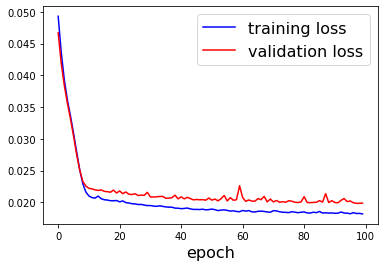

In [36]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax.plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax.set_xlabel('epoch',fontsize=16)
ax.legend(fontsize=16)

In [37]:
# obtain Yp_test
# "Yp_test=model(X_test)"  may need lots of memory
# we can use a for loop to get Yp_test, see the function test
Yp_test=[]
with torch.no_grad(): # tell Pytorch not to build graph in the 'with' section
    for batch_idx, (X, Y) in enumerate(dataloader_test):
        X, Y = X.to(device), Y.to(device)
        Yp = model(X)#forward pass
        Yp_test.append(Yp.detach().cpu().numpy())
Yp_test=np.concatenate(Yp_test, axis=0).squeeze()

In [38]:
# compute MSE, MAE and MAPE on test set
MSE = np.mean((Y_test - Yp_test)**2)
MAE = np.mean(np.abs(Y_test - Yp_test))
MAPE =  np.mean(np.abs(Y_test - Yp_test)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)

MSE= 0.018215971
MAE= 0.096999705
MAPE= 0.28103104


Evaluate model on testing set


Text(0, 0.5, 'Y_ptest')

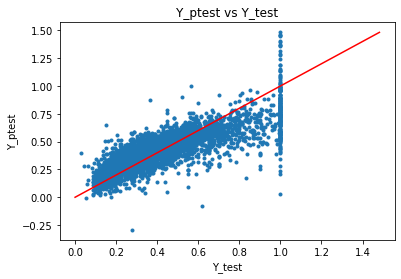

In [39]:
# plot Yp_test vs Y_test
# the red line is the 45-degree line
print('Evaluate model on testing set')

fig, ax = plt.subplots()
ax.set_title('Y_ptest vs Y_test')
ax.plot(Y_test, Yp_test, '.')
ymax=np.max([Y_test.max(), Yp_test.max()])
ax.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_ptest')

### change the structure of the MLP model and see if it can do better than XGBoost
you will lose at least 50% of the points if you do not complete this

In [260]:
#define a new model
#train, validate and test the model
#compare it with XGBoost in homework #3
# I tried this for multiple hours for three days and could not get anything lower than .193 :c
class Net2(nn.Module):
    def __init__(self, input_dim, output_dim, n_units):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_units)
        self.layer2 = nn.Linear(n_units, 150)
        self.layer3 = nn.Linear(150, 50)
        self.layer4 = nn.Linear(50, output_dim)      
    def forward(self, x):
        x=self.layer1(x)
        x=nnF.relu(x)
        x=self.layer2(x)
        x=nnF.relu(x)
        x=self.layer3(x)
        x=nnF.linear(x, torch.rand([50, 50]).to(device))
        y=self.layer4(x)
        return y
    
modelBetter=Net2(input_dim=13, output_dim=1, n_units=200)
modelBetter.to(device)
optimizer2 = optim.Adam(modelBetter.parameters(), lr=0.001, weight_decay=1e-4)

loss_train_list=[]
loss_val_list=[]
for epoch in range(0, 100):    
    #-------- perform training --------------------------------
    loss_train=train(modelBetter, optimizer2, dataloader_train, device, epoch)    
    loss_train_list.append(loss_train)
    print('epoch', epoch, 'training loss:', loss_train)
    #-------- perform validation --------------------------------
    loss_val, mae_val = test(modelBetter, dataloader_val, device)
    loss_val_list.append(loss_val)
    print('epoch', epoch, 'validation loss:', loss_val)
    
    




Train Epoch: 0 [0/14860 (0%)]	Loss: 0.186980
Train Epoch: 0 [64/14860 (0%)]	Loss: 0.082844
Train Epoch: 0 [128/14860 (1%)]	Loss: 0.119501
Train Epoch: 0 [192/14860 (1%)]	Loss: 0.057308
Train Epoch: 0 [256/14860 (2%)]	Loss: 0.062804
Train Epoch: 0 [320/14860 (2%)]	Loss: 0.051392
Train Epoch: 0 [384/14860 (3%)]	Loss: 0.079936
Train Epoch: 0 [448/14860 (3%)]	Loss: 0.060819
Train Epoch: 0 [512/14860 (3%)]	Loss: 0.037597
Train Epoch: 0 [576/14860 (4%)]	Loss: 0.060902
Train Epoch: 0 [640/14860 (4%)]	Loss: 0.063864
Train Epoch: 0 [704/14860 (5%)]	Loss: 0.038998
Train Epoch: 0 [768/14860 (5%)]	Loss: 0.036065
Train Epoch: 0 [832/14860 (6%)]	Loss: 0.032979
Train Epoch: 0 [896/14860 (6%)]	Loss: 0.087990
Train Epoch: 0 [960/14860 (6%)]	Loss: 0.049898
Train Epoch: 0 [1024/14860 (7%)]	Loss: 0.064518
Train Epoch: 0 [1088/14860 (7%)]	Loss: 0.041085
Train Epoch: 0 [1152/14860 (8%)]	Loss: 0.042049
Train Epoch: 0 [1216/14860 (8%)]	Loss: 0.097700
Train Epoch: 0 [1280/14860 (9%)]	Loss: 0.053579
Train Epoch

Train Epoch: 0 [10880/14860 (73%)]	Loss: 0.017959
Train Epoch: 0 [10944/14860 (73%)]	Loss: 0.015817
Train Epoch: 0 [11008/14860 (74%)]	Loss: 0.032410
Train Epoch: 0 [11072/14860 (74%)]	Loss: 0.015868
Train Epoch: 0 [11136/14860 (75%)]	Loss: 0.018959
Train Epoch: 0 [11200/14860 (75%)]	Loss: 0.016621
Train Epoch: 0 [11264/14860 (76%)]	Loss: 0.021505
Train Epoch: 0 [11328/14860 (76%)]	Loss: 0.018090
Train Epoch: 0 [11392/14860 (76%)]	Loss: 0.035643
Train Epoch: 0 [11456/14860 (77%)]	Loss: 0.023965
Train Epoch: 0 [11520/14860 (77%)]	Loss: 0.022300
Train Epoch: 0 [11584/14860 (78%)]	Loss: 0.028841
Train Epoch: 0 [11648/14860 (78%)]	Loss: 0.020597
Train Epoch: 0 [11712/14860 (79%)]	Loss: 0.021002
Train Epoch: 0 [11776/14860 (79%)]	Loss: 0.030702
Train Epoch: 0 [11840/14860 (79%)]	Loss: 0.031457
Train Epoch: 0 [11904/14860 (80%)]	Loss: 0.033131
Train Epoch: 0 [11968/14860 (80%)]	Loss: 0.017785
Train Epoch: 0 [12032/14860 (81%)]	Loss: 0.016079
Train Epoch: 0 [12096/14860 (81%)]	Loss: 0.020136


Train Epoch: 1 [7872/14860 (53%)]	Loss: 0.026449
Train Epoch: 1 [7936/14860 (53%)]	Loss: 0.018366
Train Epoch: 1 [8000/14860 (54%)]	Loss: 0.019024
Train Epoch: 1 [8064/14860 (54%)]	Loss: 0.010535
Train Epoch: 1 [8128/14860 (55%)]	Loss: 0.018787
Train Epoch: 1 [8192/14860 (55%)]	Loss: 0.021227
Train Epoch: 1 [8256/14860 (55%)]	Loss: 0.022679
Train Epoch: 1 [8320/14860 (56%)]	Loss: 0.026459
Train Epoch: 1 [8384/14860 (56%)]	Loss: 0.013368
Train Epoch: 1 [8448/14860 (57%)]	Loss: 0.009968
Train Epoch: 1 [8512/14860 (57%)]	Loss: 0.014077
Train Epoch: 1 [8576/14860 (58%)]	Loss: 0.009734
Train Epoch: 1 [8640/14860 (58%)]	Loss: 0.015149
Train Epoch: 1 [8704/14860 (58%)]	Loss: 0.010518
Train Epoch: 1 [8768/14860 (59%)]	Loss: 0.023889
Train Epoch: 1 [8832/14860 (59%)]	Loss: 0.015388
Train Epoch: 1 [8896/14860 (60%)]	Loss: 0.009367
Train Epoch: 1 [8960/14860 (60%)]	Loss: 0.017726
Train Epoch: 1 [9024/14860 (61%)]	Loss: 0.017192
Train Epoch: 1 [9088/14860 (61%)]	Loss: 0.015937
Train Epoch: 1 [9152

Train Epoch: 2 [4160/14860 (28%)]	Loss: 0.019309
Train Epoch: 2 [4224/14860 (28%)]	Loss: 0.020546
Train Epoch: 2 [4288/14860 (29%)]	Loss: 0.016268
Train Epoch: 2 [4352/14860 (29%)]	Loss: 0.022800
Train Epoch: 2 [4416/14860 (30%)]	Loss: 0.020570
Train Epoch: 2 [4480/14860 (30%)]	Loss: 0.019928
Train Epoch: 2 [4544/14860 (30%)]	Loss: 0.025005
Train Epoch: 2 [4608/14860 (31%)]	Loss: 0.015080
Train Epoch: 2 [4672/14860 (31%)]	Loss: 0.015216
Train Epoch: 2 [4736/14860 (32%)]	Loss: 0.021643
Train Epoch: 2 [4800/14860 (32%)]	Loss: 0.019686
Train Epoch: 2 [4864/14860 (33%)]	Loss: 0.024353
Train Epoch: 2 [4928/14860 (33%)]	Loss: 0.014616
Train Epoch: 2 [4992/14860 (33%)]	Loss: 0.021830
Train Epoch: 2 [5056/14860 (34%)]	Loss: 0.013208
Train Epoch: 2 [5120/14860 (34%)]	Loss: 0.025370
Train Epoch: 2 [5184/14860 (35%)]	Loss: 0.024123
Train Epoch: 2 [5248/14860 (35%)]	Loss: 0.024255
Train Epoch: 2 [5312/14860 (36%)]	Loss: 0.014148
Train Epoch: 2 [5376/14860 (36%)]	Loss: 0.016599
Train Epoch: 2 [5440

Train Epoch: 3 [1152/14860 (8%)]	Loss: 0.014163
Train Epoch: 3 [1216/14860 (8%)]	Loss: 0.019948
Train Epoch: 3 [1280/14860 (9%)]	Loss: 0.013961
Train Epoch: 3 [1344/14860 (9%)]	Loss: 0.016078
Train Epoch: 3 [1408/14860 (9%)]	Loss: 0.024814
Train Epoch: 3 [1472/14860 (10%)]	Loss: 0.021699
Train Epoch: 3 [1536/14860 (10%)]	Loss: 0.020055
Train Epoch: 3 [1600/14860 (11%)]	Loss: 0.017068
Train Epoch: 3 [1664/14860 (11%)]	Loss: 0.025102
Train Epoch: 3 [1728/14860 (12%)]	Loss: 0.024451
Train Epoch: 3 [1792/14860 (12%)]	Loss: 0.031836
Train Epoch: 3 [1856/14860 (12%)]	Loss: 0.020892
Train Epoch: 3 [1920/14860 (13%)]	Loss: 0.011294
Train Epoch: 3 [1984/14860 (13%)]	Loss: 0.020627
Train Epoch: 3 [2048/14860 (14%)]	Loss: 0.028646
Train Epoch: 3 [2112/14860 (14%)]	Loss: 0.017825
Train Epoch: 3 [2176/14860 (15%)]	Loss: 0.023618
Train Epoch: 3 [2240/14860 (15%)]	Loss: 0.016494
Train Epoch: 3 [2304/14860 (15%)]	Loss: 0.014811
Train Epoch: 3 [2368/14860 (16%)]	Loss: 0.011785
Train Epoch: 3 [2432/1486

Train Epoch: 3 [13952/14860 (94%)]	Loss: 0.015785
Train Epoch: 3 [14016/14860 (94%)]	Loss: 0.034382
Train Epoch: 3 [14080/14860 (94%)]	Loss: 0.014686
Train Epoch: 3 [14144/14860 (95%)]	Loss: 0.014352
Train Epoch: 3 [14208/14860 (95%)]	Loss: 0.011747
Train Epoch: 3 [14272/14860 (96%)]	Loss: 0.029041
Train Epoch: 3 [14336/14860 (96%)]	Loss: 0.014726
Train Epoch: 3 [14400/14860 (97%)]	Loss: 0.013248
Train Epoch: 3 [14464/14860 (97%)]	Loss: 0.010736
Train Epoch: 3 [14528/14860 (97%)]	Loss: 0.016858
Train Epoch: 3 [14592/14860 (98%)]	Loss: 0.018050
Train Epoch: 3 [14656/14860 (98%)]	Loss: 0.018828
Train Epoch: 3 [14720/14860 (99%)]	Loss: 0.013787
Train Epoch: 3 [14784/14860 (99%)]	Loss: 0.021914
Train Epoch: 3 [2784/14860 (100%)]	Loss: 0.024017
epoch 3 training loss: 0.019024962007743607
epoch 3 validation loss: 0.020956180069694796
Train Epoch: 4 [0/14860 (0%)]	Loss: 0.023872
Train Epoch: 4 [64/14860 (0%)]	Loss: 0.017749
Train Epoch: 4 [128/14860 (1%)]	Loss: 0.028367
Train Epoch: 4 [192/14

Train Epoch: 4 [11328/14860 (76%)]	Loss: 0.015824
Train Epoch: 4 [11392/14860 (76%)]	Loss: 0.022604
Train Epoch: 4 [11456/14860 (77%)]	Loss: 0.025994
Train Epoch: 4 [11520/14860 (77%)]	Loss: 0.015546
Train Epoch: 4 [11584/14860 (78%)]	Loss: 0.018370
Train Epoch: 4 [11648/14860 (78%)]	Loss: 0.014457
Train Epoch: 4 [11712/14860 (79%)]	Loss: 0.012206
Train Epoch: 4 [11776/14860 (79%)]	Loss: 0.014263
Train Epoch: 4 [11840/14860 (79%)]	Loss: 0.021842
Train Epoch: 4 [11904/14860 (80%)]	Loss: 0.028227
Train Epoch: 4 [11968/14860 (80%)]	Loss: 0.010831
Train Epoch: 4 [12032/14860 (81%)]	Loss: 0.010361
Train Epoch: 4 [12096/14860 (81%)]	Loss: 0.015763
Train Epoch: 4 [12160/14860 (82%)]	Loss: 0.022136
Train Epoch: 4 [12224/14860 (82%)]	Loss: 0.014718
Train Epoch: 4 [12288/14860 (82%)]	Loss: 0.014047
Train Epoch: 4 [12352/14860 (83%)]	Loss: 0.027938
Train Epoch: 4 [12416/14860 (83%)]	Loss: 0.028294
Train Epoch: 4 [12480/14860 (84%)]	Loss: 0.010836
Train Epoch: 4 [12544/14860 (84%)]	Loss: 0.014377


Train Epoch: 5 [9472/14860 (64%)]	Loss: 0.013977
Train Epoch: 5 [9536/14860 (64%)]	Loss: 0.018990
Train Epoch: 5 [9600/14860 (64%)]	Loss: 0.017653
Train Epoch: 5 [9664/14860 (65%)]	Loss: 0.015017
Train Epoch: 5 [9728/14860 (65%)]	Loss: 0.020265
Train Epoch: 5 [9792/14860 (66%)]	Loss: 0.029343
Train Epoch: 5 [9856/14860 (66%)]	Loss: 0.013214
Train Epoch: 5 [9920/14860 (67%)]	Loss: 0.015936
Train Epoch: 5 [9984/14860 (67%)]	Loss: 0.025716
Train Epoch: 5 [10048/14860 (67%)]	Loss: 0.028765
Train Epoch: 5 [10112/14860 (68%)]	Loss: 0.027611
Train Epoch: 5 [10176/14860 (68%)]	Loss: 0.010330
Train Epoch: 5 [10240/14860 (69%)]	Loss: 0.024182
Train Epoch: 5 [10304/14860 (69%)]	Loss: 0.013279
Train Epoch: 5 [10368/14860 (70%)]	Loss: 0.023356
Train Epoch: 5 [10432/14860 (70%)]	Loss: 0.016750
Train Epoch: 5 [10496/14860 (70%)]	Loss: 0.020682
Train Epoch: 5 [10560/14860 (71%)]	Loss: 0.011811
Train Epoch: 5 [10624/14860 (71%)]	Loss: 0.022234
Train Epoch: 5 [10688/14860 (72%)]	Loss: 0.025438
Train Epo

Train Epoch: 6 [5632/14860 (38%)]	Loss: 0.014710
Train Epoch: 6 [5696/14860 (38%)]	Loss: 0.014935
Train Epoch: 6 [5760/14860 (39%)]	Loss: 0.019566
Train Epoch: 6 [5824/14860 (39%)]	Loss: 0.022410
Train Epoch: 6 [5888/14860 (39%)]	Loss: 0.014463
Train Epoch: 6 [5952/14860 (40%)]	Loss: 0.014794
Train Epoch: 6 [6016/14860 (40%)]	Loss: 0.014716
Train Epoch: 6 [6080/14860 (41%)]	Loss: 0.031642
Train Epoch: 6 [6144/14860 (41%)]	Loss: 0.018145
Train Epoch: 6 [6208/14860 (42%)]	Loss: 0.029503
Train Epoch: 6 [6272/14860 (42%)]	Loss: 0.019240
Train Epoch: 6 [6336/14860 (42%)]	Loss: 0.006818
Train Epoch: 6 [6400/14860 (43%)]	Loss: 0.015508
Train Epoch: 6 [6464/14860 (43%)]	Loss: 0.013944
Train Epoch: 6 [6528/14860 (44%)]	Loss: 0.009503
Train Epoch: 6 [6592/14860 (44%)]	Loss: 0.015034
Train Epoch: 6 [6656/14860 (45%)]	Loss: 0.028706
Train Epoch: 6 [6720/14860 (45%)]	Loss: 0.021332
Train Epoch: 6 [6784/14860 (45%)]	Loss: 0.025807
Train Epoch: 6 [6848/14860 (46%)]	Loss: 0.014127
Train Epoch: 6 [6912

Train Epoch: 7 [1344/14860 (9%)]	Loss: 0.014278
Train Epoch: 7 [1408/14860 (9%)]	Loss: 0.011165
Train Epoch: 7 [1472/14860 (10%)]	Loss: 0.012536
Train Epoch: 7 [1536/14860 (10%)]	Loss: 0.029619
Train Epoch: 7 [1600/14860 (11%)]	Loss: 0.011007
Train Epoch: 7 [1664/14860 (11%)]	Loss: 0.017912
Train Epoch: 7 [1728/14860 (12%)]	Loss: 0.019365
Train Epoch: 7 [1792/14860 (12%)]	Loss: 0.017533
Train Epoch: 7 [1856/14860 (12%)]	Loss: 0.011658
Train Epoch: 7 [1920/14860 (13%)]	Loss: 0.022262
Train Epoch: 7 [1984/14860 (13%)]	Loss: 0.024268
Train Epoch: 7 [2048/14860 (14%)]	Loss: 0.017055
Train Epoch: 7 [2112/14860 (14%)]	Loss: 0.009039
Train Epoch: 7 [2176/14860 (15%)]	Loss: 0.023427
Train Epoch: 7 [2240/14860 (15%)]	Loss: 0.008161
Train Epoch: 7 [2304/14860 (15%)]	Loss: 0.016088
Train Epoch: 7 [2368/14860 (16%)]	Loss: 0.011485
Train Epoch: 7 [2432/14860 (16%)]	Loss: 0.018507
Train Epoch: 7 [2496/14860 (17%)]	Loss: 0.019744
Train Epoch: 7 [2560/14860 (17%)]	Loss: 0.035591
Train Epoch: 7 [2624/1

Train Epoch: 7 [12928/14860 (87%)]	Loss: 0.010614
Train Epoch: 7 [12992/14860 (87%)]	Loss: 0.011704
Train Epoch: 7 [13056/14860 (88%)]	Loss: 0.015110
Train Epoch: 7 [13120/14860 (88%)]	Loss: 0.019320
Train Epoch: 7 [13184/14860 (88%)]	Loss: 0.010989
Train Epoch: 7 [13248/14860 (89%)]	Loss: 0.009982
Train Epoch: 7 [13312/14860 (89%)]	Loss: 0.023388
Train Epoch: 7 [13376/14860 (90%)]	Loss: 0.014847
Train Epoch: 7 [13440/14860 (90%)]	Loss: 0.018521
Train Epoch: 7 [13504/14860 (91%)]	Loss: 0.017059
Train Epoch: 7 [13568/14860 (91%)]	Loss: 0.025894
Train Epoch: 7 [13632/14860 (91%)]	Loss: 0.005943
Train Epoch: 7 [13696/14860 (92%)]	Loss: 0.020590
Train Epoch: 7 [13760/14860 (92%)]	Loss: 0.020228
Train Epoch: 7 [13824/14860 (93%)]	Loss: 0.010778
Train Epoch: 7 [13888/14860 (93%)]	Loss: 0.015766
Train Epoch: 7 [13952/14860 (94%)]	Loss: 0.013071
Train Epoch: 7 [14016/14860 (94%)]	Loss: 0.015735
Train Epoch: 7 [14080/14860 (94%)]	Loss: 0.018565
Train Epoch: 7 [14144/14860 (95%)]	Loss: 0.015650


Train Epoch: 8 [11328/14860 (76%)]	Loss: 0.011619
Train Epoch: 8 [11392/14860 (76%)]	Loss: 0.012564
Train Epoch: 8 [11456/14860 (77%)]	Loss: 0.014801
Train Epoch: 8 [11520/14860 (77%)]	Loss: 0.016935
Train Epoch: 8 [11584/14860 (78%)]	Loss: 0.008749
Train Epoch: 8 [11648/14860 (78%)]	Loss: 0.015601
Train Epoch: 8 [11712/14860 (79%)]	Loss: 0.024454
Train Epoch: 8 [11776/14860 (79%)]	Loss: 0.017621
Train Epoch: 8 [11840/14860 (79%)]	Loss: 0.017912
Train Epoch: 8 [11904/14860 (80%)]	Loss: 0.017684
Train Epoch: 8 [11968/14860 (80%)]	Loss: 0.012447
Train Epoch: 8 [12032/14860 (81%)]	Loss: 0.007211
Train Epoch: 8 [12096/14860 (81%)]	Loss: 0.011588
Train Epoch: 8 [12160/14860 (82%)]	Loss: 0.011898
Train Epoch: 8 [12224/14860 (82%)]	Loss: 0.017100
Train Epoch: 8 [12288/14860 (82%)]	Loss: 0.014053
Train Epoch: 8 [12352/14860 (83%)]	Loss: 0.014784
Train Epoch: 8 [12416/14860 (83%)]	Loss: 0.012903
Train Epoch: 8 [12480/14860 (84%)]	Loss: 0.022013
Train Epoch: 8 [12544/14860 (84%)]	Loss: 0.008016


Train Epoch: 9 [9472/14860 (64%)]	Loss: 0.013193
Train Epoch: 9 [9536/14860 (64%)]	Loss: 0.020382
Train Epoch: 9 [9600/14860 (64%)]	Loss: 0.013558
Train Epoch: 9 [9664/14860 (65%)]	Loss: 0.017626
Train Epoch: 9 [9728/14860 (65%)]	Loss: 0.013599
Train Epoch: 9 [9792/14860 (66%)]	Loss: 0.012995
Train Epoch: 9 [9856/14860 (66%)]	Loss: 0.012626
Train Epoch: 9 [9920/14860 (67%)]	Loss: 0.021263
Train Epoch: 9 [9984/14860 (67%)]	Loss: 0.016598
Train Epoch: 9 [10048/14860 (67%)]	Loss: 0.015847
Train Epoch: 9 [10112/14860 (68%)]	Loss: 0.021760
Train Epoch: 9 [10176/14860 (68%)]	Loss: 0.008556
Train Epoch: 9 [10240/14860 (69%)]	Loss: 0.015448
Train Epoch: 9 [10304/14860 (69%)]	Loss: 0.016379
Train Epoch: 9 [10368/14860 (70%)]	Loss: 0.010727
Train Epoch: 9 [10432/14860 (70%)]	Loss: 0.012780
Train Epoch: 9 [10496/14860 (70%)]	Loss: 0.011925
Train Epoch: 9 [10560/14860 (71%)]	Loss: 0.015284
Train Epoch: 9 [10624/14860 (71%)]	Loss: 0.018616
Train Epoch: 9 [10688/14860 (72%)]	Loss: 0.014597
Train Epo

Train Epoch: 10 [5632/14860 (38%)]	Loss: 0.012702
Train Epoch: 10 [5696/14860 (38%)]	Loss: 0.019804
Train Epoch: 10 [5760/14860 (39%)]	Loss: 0.018098
Train Epoch: 10 [5824/14860 (39%)]	Loss: 0.013692
Train Epoch: 10 [5888/14860 (39%)]	Loss: 0.023883
Train Epoch: 10 [5952/14860 (40%)]	Loss: 0.013498
Train Epoch: 10 [6016/14860 (40%)]	Loss: 0.012253
Train Epoch: 10 [6080/14860 (41%)]	Loss: 0.007706
Train Epoch: 10 [6144/14860 (41%)]	Loss: 0.022798
Train Epoch: 10 [6208/14860 (42%)]	Loss: 0.014138
Train Epoch: 10 [6272/14860 (42%)]	Loss: 0.013046
Train Epoch: 10 [6336/14860 (42%)]	Loss: 0.019844
Train Epoch: 10 [6400/14860 (43%)]	Loss: 0.017029
Train Epoch: 10 [6464/14860 (43%)]	Loss: 0.007919
Train Epoch: 10 [6528/14860 (44%)]	Loss: 0.027129
Train Epoch: 10 [6592/14860 (44%)]	Loss: 0.013013
Train Epoch: 10 [6656/14860 (45%)]	Loss: 0.011213
Train Epoch: 10 [6720/14860 (45%)]	Loss: 0.012844
Train Epoch: 10 [6784/14860 (45%)]	Loss: 0.017763
Train Epoch: 10 [6848/14860 (46%)]	Loss: 0.016206


Train Epoch: 11 [3904/14860 (26%)]	Loss: 0.019845
Train Epoch: 11 [3968/14860 (27%)]	Loss: 0.010308
Train Epoch: 11 [4032/14860 (27%)]	Loss: 0.009738
Train Epoch: 11 [4096/14860 (27%)]	Loss: 0.009432
Train Epoch: 11 [4160/14860 (28%)]	Loss: 0.011772
Train Epoch: 11 [4224/14860 (28%)]	Loss: 0.012200
Train Epoch: 11 [4288/14860 (29%)]	Loss: 0.017092
Train Epoch: 11 [4352/14860 (29%)]	Loss: 0.010139
Train Epoch: 11 [4416/14860 (30%)]	Loss: 0.011072
Train Epoch: 11 [4480/14860 (30%)]	Loss: 0.029802
Train Epoch: 11 [4544/14860 (30%)]	Loss: 0.011740
Train Epoch: 11 [4608/14860 (31%)]	Loss: 0.014698
Train Epoch: 11 [4672/14860 (31%)]	Loss: 0.009837
Train Epoch: 11 [4736/14860 (32%)]	Loss: 0.015720
Train Epoch: 11 [4800/14860 (32%)]	Loss: 0.020085
Train Epoch: 11 [4864/14860 (33%)]	Loss: 0.011804
Train Epoch: 11 [4928/14860 (33%)]	Loss: 0.038227
Train Epoch: 11 [4992/14860 (33%)]	Loss: 0.014536
Train Epoch: 11 [5056/14860 (34%)]	Loss: 0.014151
Train Epoch: 11 [5120/14860 (34%)]	Loss: 0.009680


epoch 11 validation loss: 0.01641058828005202
Train Epoch: 12 [0/14860 (0%)]	Loss: 0.021376
Train Epoch: 12 [64/14860 (0%)]	Loss: 0.014174
Train Epoch: 12 [128/14860 (1%)]	Loss: 0.019649
Train Epoch: 12 [192/14860 (1%)]	Loss: 0.014424
Train Epoch: 12 [256/14860 (2%)]	Loss: 0.019848
Train Epoch: 12 [320/14860 (2%)]	Loss: 0.018115
Train Epoch: 12 [384/14860 (3%)]	Loss: 0.015720
Train Epoch: 12 [448/14860 (3%)]	Loss: 0.022053
Train Epoch: 12 [512/14860 (3%)]	Loss: 0.013085
Train Epoch: 12 [576/14860 (4%)]	Loss: 0.017559
Train Epoch: 12 [640/14860 (4%)]	Loss: 0.018125
Train Epoch: 12 [704/14860 (5%)]	Loss: 0.019690
Train Epoch: 12 [768/14860 (5%)]	Loss: 0.008547
Train Epoch: 12 [832/14860 (6%)]	Loss: 0.017216
Train Epoch: 12 [896/14860 (6%)]	Loss: 0.019414
Train Epoch: 12 [960/14860 (6%)]	Loss: 0.020385
Train Epoch: 12 [1024/14860 (7%)]	Loss: 0.016122
Train Epoch: 12 [1088/14860 (7%)]	Loss: 0.012071
Train Epoch: 12 [1152/14860 (8%)]	Loss: 0.012692
Train Epoch: 12 [1216/14860 (8%)]	Loss: 0.

Train Epoch: 12 [11264/14860 (76%)]	Loss: 0.009890
Train Epoch: 12 [11328/14860 (76%)]	Loss: 0.028933
Train Epoch: 12 [11392/14860 (76%)]	Loss: 0.010047
Train Epoch: 12 [11456/14860 (77%)]	Loss: 0.026729
Train Epoch: 12 [11520/14860 (77%)]	Loss: 0.013112
Train Epoch: 12 [11584/14860 (78%)]	Loss: 0.013397
Train Epoch: 12 [11648/14860 (78%)]	Loss: 0.011262
Train Epoch: 12 [11712/14860 (79%)]	Loss: 0.011389
Train Epoch: 12 [11776/14860 (79%)]	Loss: 0.017904
Train Epoch: 12 [11840/14860 (79%)]	Loss: 0.015982
Train Epoch: 12 [11904/14860 (80%)]	Loss: 0.009069
Train Epoch: 12 [11968/14860 (80%)]	Loss: 0.014428
Train Epoch: 12 [12032/14860 (81%)]	Loss: 0.014303
Train Epoch: 12 [12096/14860 (81%)]	Loss: 0.012867
Train Epoch: 12 [12160/14860 (82%)]	Loss: 0.014656
Train Epoch: 12 [12224/14860 (82%)]	Loss: 0.015365
Train Epoch: 12 [12288/14860 (82%)]	Loss: 0.010093
Train Epoch: 12 [12352/14860 (83%)]	Loss: 0.012603
Train Epoch: 12 [12416/14860 (83%)]	Loss: 0.012898
Train Epoch: 12 [12480/14860 (8

Train Epoch: 13 [6912/14860 (46%)]	Loss: 0.010463
Train Epoch: 13 [6976/14860 (47%)]	Loss: 0.013814
Train Epoch: 13 [7040/14860 (47%)]	Loss: 0.012318
Train Epoch: 13 [7104/14860 (48%)]	Loss: 0.017306
Train Epoch: 13 [7168/14860 (48%)]	Loss: 0.020034
Train Epoch: 13 [7232/14860 (48%)]	Loss: 0.010971
Train Epoch: 13 [7296/14860 (49%)]	Loss: 0.016656
Train Epoch: 13 [7360/14860 (49%)]	Loss: 0.015653
Train Epoch: 13 [7424/14860 (50%)]	Loss: 0.008108
Train Epoch: 13 [7488/14860 (50%)]	Loss: 0.011217
Train Epoch: 13 [7552/14860 (51%)]	Loss: 0.010765
Train Epoch: 13 [7616/14860 (51%)]	Loss: 0.020271
Train Epoch: 13 [7680/14860 (52%)]	Loss: 0.011101
Train Epoch: 13 [7744/14860 (52%)]	Loss: 0.012602
Train Epoch: 13 [7808/14860 (52%)]	Loss: 0.013221
Train Epoch: 13 [7872/14860 (53%)]	Loss: 0.016133
Train Epoch: 13 [7936/14860 (53%)]	Loss: 0.013254
Train Epoch: 13 [8000/14860 (54%)]	Loss: 0.012468
Train Epoch: 13 [8064/14860 (54%)]	Loss: 0.023219
Train Epoch: 13 [8128/14860 (55%)]	Loss: 0.016375


Train Epoch: 14 [2880/14860 (19%)]	Loss: 0.011933
Train Epoch: 14 [2944/14860 (20%)]	Loss: 0.011604
Train Epoch: 14 [3008/14860 (20%)]	Loss: 0.019692
Train Epoch: 14 [3072/14860 (21%)]	Loss: 0.023980
Train Epoch: 14 [3136/14860 (21%)]	Loss: 0.011807
Train Epoch: 14 [3200/14860 (21%)]	Loss: 0.012800
Train Epoch: 14 [3264/14860 (22%)]	Loss: 0.010422
Train Epoch: 14 [3328/14860 (22%)]	Loss: 0.017316
Train Epoch: 14 [3392/14860 (23%)]	Loss: 0.011129
Train Epoch: 14 [3456/14860 (23%)]	Loss: 0.009405
Train Epoch: 14 [3520/14860 (24%)]	Loss: 0.020274
Train Epoch: 14 [3584/14860 (24%)]	Loss: 0.015142
Train Epoch: 14 [3648/14860 (24%)]	Loss: 0.020007
Train Epoch: 14 [3712/14860 (25%)]	Loss: 0.012095
Train Epoch: 14 [3776/14860 (25%)]	Loss: 0.007294
Train Epoch: 14 [3840/14860 (26%)]	Loss: 0.012504
Train Epoch: 14 [3904/14860 (26%)]	Loss: 0.010495
Train Epoch: 14 [3968/14860 (27%)]	Loss: 0.030353
Train Epoch: 14 [4032/14860 (27%)]	Loss: 0.007351
Train Epoch: 14 [4096/14860 (27%)]	Loss: 0.009752


Train Epoch: 14 [14144/14860 (95%)]	Loss: 0.012579
Train Epoch: 14 [14208/14860 (95%)]	Loss: 0.014222
Train Epoch: 14 [14272/14860 (96%)]	Loss: 0.013270
Train Epoch: 14 [14336/14860 (96%)]	Loss: 0.009718
Train Epoch: 14 [14400/14860 (97%)]	Loss: 0.016566
Train Epoch: 14 [14464/14860 (97%)]	Loss: 0.022236
Train Epoch: 14 [14528/14860 (97%)]	Loss: 0.018384
Train Epoch: 14 [14592/14860 (98%)]	Loss: 0.020045
Train Epoch: 14 [14656/14860 (98%)]	Loss: 0.008820
Train Epoch: 14 [14720/14860 (99%)]	Loss: 0.015611
Train Epoch: 14 [14784/14860 (99%)]	Loss: 0.026211
Train Epoch: 14 [2784/14860 (100%)]	Loss: 0.009206
epoch 14 training loss: 0.014710023705427866
epoch 14 validation loss: 0.017227600619521614
Train Epoch: 15 [0/14860 (0%)]	Loss: 0.015719
Train Epoch: 15 [64/14860 (0%)]	Loss: 0.018339
Train Epoch: 15 [128/14860 (1%)]	Loss: 0.012734
Train Epoch: 15 [192/14860 (1%)]	Loss: 0.013166
Train Epoch: 15 [256/14860 (2%)]	Loss: 0.021809
Train Epoch: 15 [320/14860 (2%)]	Loss: 0.010872
Train Epoch

Train Epoch: 15 [12480/14860 (84%)]	Loss: 0.028046
Train Epoch: 15 [12544/14860 (84%)]	Loss: 0.013730
Train Epoch: 15 [12608/14860 (85%)]	Loss: 0.014099
Train Epoch: 15 [12672/14860 (85%)]	Loss: 0.015573
Train Epoch: 15 [12736/14860 (85%)]	Loss: 0.018883
Train Epoch: 15 [12800/14860 (86%)]	Loss: 0.009140
Train Epoch: 15 [12864/14860 (86%)]	Loss: 0.010981
Train Epoch: 15 [12928/14860 (87%)]	Loss: 0.023950
Train Epoch: 15 [12992/14860 (87%)]	Loss: 0.015019
Train Epoch: 15 [13056/14860 (88%)]	Loss: 0.013527
Train Epoch: 15 [13120/14860 (88%)]	Loss: 0.010231
Train Epoch: 15 [13184/14860 (88%)]	Loss: 0.009009
Train Epoch: 15 [13248/14860 (89%)]	Loss: 0.014430
Train Epoch: 15 [13312/14860 (89%)]	Loss: 0.017261
Train Epoch: 15 [13376/14860 (90%)]	Loss: 0.008894
Train Epoch: 15 [13440/14860 (90%)]	Loss: 0.016583
Train Epoch: 15 [13504/14860 (91%)]	Loss: 0.013014
Train Epoch: 15 [13568/14860 (91%)]	Loss: 0.017563
Train Epoch: 15 [13632/14860 (91%)]	Loss: 0.017699
Train Epoch: 15 [13696/14860 (9

Train Epoch: 16 [8704/14860 (58%)]	Loss: 0.013233
Train Epoch: 16 [8768/14860 (59%)]	Loss: 0.020767
Train Epoch: 16 [8832/14860 (59%)]	Loss: 0.013084
Train Epoch: 16 [8896/14860 (60%)]	Loss: 0.014378
Train Epoch: 16 [8960/14860 (60%)]	Loss: 0.020262
Train Epoch: 16 [9024/14860 (61%)]	Loss: 0.034552
Train Epoch: 16 [9088/14860 (61%)]	Loss: 0.012866
Train Epoch: 16 [9152/14860 (61%)]	Loss: 0.007762
Train Epoch: 16 [9216/14860 (62%)]	Loss: 0.016171
Train Epoch: 16 [9280/14860 (62%)]	Loss: 0.014092
Train Epoch: 16 [9344/14860 (63%)]	Loss: 0.018733
Train Epoch: 16 [9408/14860 (63%)]	Loss: 0.014472
Train Epoch: 16 [9472/14860 (64%)]	Loss: 0.011738
Train Epoch: 16 [9536/14860 (64%)]	Loss: 0.009623
Train Epoch: 16 [9600/14860 (64%)]	Loss: 0.020315
Train Epoch: 16 [9664/14860 (65%)]	Loss: 0.022001
Train Epoch: 16 [9728/14860 (65%)]	Loss: 0.015534
Train Epoch: 16 [9792/14860 (66%)]	Loss: 0.010477
Train Epoch: 16 [9856/14860 (66%)]	Loss: 0.016376
Train Epoch: 16 [9920/14860 (67%)]	Loss: 0.012073


Train Epoch: 17 [4288/14860 (29%)]	Loss: 0.011103
Train Epoch: 17 [4352/14860 (29%)]	Loss: 0.011412
Train Epoch: 17 [4416/14860 (30%)]	Loss: 0.008929
Train Epoch: 17 [4480/14860 (30%)]	Loss: 0.013714
Train Epoch: 17 [4544/14860 (30%)]	Loss: 0.017598
Train Epoch: 17 [4608/14860 (31%)]	Loss: 0.016134
Train Epoch: 17 [4672/14860 (31%)]	Loss: 0.011783
Train Epoch: 17 [4736/14860 (32%)]	Loss: 0.017462
Train Epoch: 17 [4800/14860 (32%)]	Loss: 0.018336
Train Epoch: 17 [4864/14860 (33%)]	Loss: 0.012528
Train Epoch: 17 [4928/14860 (33%)]	Loss: 0.008881
Train Epoch: 17 [4992/14860 (33%)]	Loss: 0.018239
Train Epoch: 17 [5056/14860 (34%)]	Loss: 0.018917
Train Epoch: 17 [5120/14860 (34%)]	Loss: 0.010877
Train Epoch: 17 [5184/14860 (35%)]	Loss: 0.008873
Train Epoch: 17 [5248/14860 (35%)]	Loss: 0.012940
Train Epoch: 17 [5312/14860 (36%)]	Loss: 0.014720
Train Epoch: 17 [5376/14860 (36%)]	Loss: 0.010732
Train Epoch: 17 [5440/14860 (36%)]	Loss: 0.014575
Train Epoch: 17 [5504/14860 (37%)]	Loss: 0.017206


Train Epoch: 18 [128/14860 (1%)]	Loss: 0.018486
Train Epoch: 18 [192/14860 (1%)]	Loss: 0.012123
Train Epoch: 18 [256/14860 (2%)]	Loss: 0.015651
Train Epoch: 18 [320/14860 (2%)]	Loss: 0.018796
Train Epoch: 18 [384/14860 (3%)]	Loss: 0.012663
Train Epoch: 18 [448/14860 (3%)]	Loss: 0.017996
Train Epoch: 18 [512/14860 (3%)]	Loss: 0.008443
Train Epoch: 18 [576/14860 (4%)]	Loss: 0.010186
Train Epoch: 18 [640/14860 (4%)]	Loss: 0.013339
Train Epoch: 18 [704/14860 (5%)]	Loss: 0.010593
Train Epoch: 18 [768/14860 (5%)]	Loss: 0.015661
Train Epoch: 18 [832/14860 (6%)]	Loss: 0.010475
Train Epoch: 18 [896/14860 (6%)]	Loss: 0.015814
Train Epoch: 18 [960/14860 (6%)]	Loss: 0.006965
Train Epoch: 18 [1024/14860 (7%)]	Loss: 0.015058
Train Epoch: 18 [1088/14860 (7%)]	Loss: 0.014642
Train Epoch: 18 [1152/14860 (8%)]	Loss: 0.011558
Train Epoch: 18 [1216/14860 (8%)]	Loss: 0.021738
Train Epoch: 18 [1280/14860 (9%)]	Loss: 0.012731
Train Epoch: 18 [1344/14860 (9%)]	Loss: 0.014181
Train Epoch: 18 [1408/14860 (9%)]	

Train Epoch: 18 [11392/14860 (76%)]	Loss: 0.013358
Train Epoch: 18 [11456/14860 (77%)]	Loss: 0.011413
Train Epoch: 18 [11520/14860 (77%)]	Loss: 0.009621
Train Epoch: 18 [11584/14860 (78%)]	Loss: 0.013899
Train Epoch: 18 [11648/14860 (78%)]	Loss: 0.028693
Train Epoch: 18 [11712/14860 (79%)]	Loss: 0.007135
Train Epoch: 18 [11776/14860 (79%)]	Loss: 0.008051
Train Epoch: 18 [11840/14860 (79%)]	Loss: 0.016432
Train Epoch: 18 [11904/14860 (80%)]	Loss: 0.011480
Train Epoch: 18 [11968/14860 (80%)]	Loss: 0.014446
Train Epoch: 18 [12032/14860 (81%)]	Loss: 0.009195
Train Epoch: 18 [12096/14860 (81%)]	Loss: 0.011635
Train Epoch: 18 [12160/14860 (82%)]	Loss: 0.013942
Train Epoch: 18 [12224/14860 (82%)]	Loss: 0.019632
Train Epoch: 18 [12288/14860 (82%)]	Loss: 0.010566
Train Epoch: 18 [12352/14860 (83%)]	Loss: 0.020420
Train Epoch: 18 [12416/14860 (83%)]	Loss: 0.015306
Train Epoch: 18 [12480/14860 (84%)]	Loss: 0.007327
Train Epoch: 18 [12544/14860 (84%)]	Loss: 0.013942
Train Epoch: 18 [12608/14860 (8

Train Epoch: 19 [6912/14860 (46%)]	Loss: 0.013047
Train Epoch: 19 [6976/14860 (47%)]	Loss: 0.015334
Train Epoch: 19 [7040/14860 (47%)]	Loss: 0.008623
Train Epoch: 19 [7104/14860 (48%)]	Loss: 0.014381
Train Epoch: 19 [7168/14860 (48%)]	Loss: 0.012611
Train Epoch: 19 [7232/14860 (48%)]	Loss: 0.010676
Train Epoch: 19 [7296/14860 (49%)]	Loss: 0.009916
Train Epoch: 19 [7360/14860 (49%)]	Loss: 0.014075
Train Epoch: 19 [7424/14860 (50%)]	Loss: 0.016111
Train Epoch: 19 [7488/14860 (50%)]	Loss: 0.006356
Train Epoch: 19 [7552/14860 (51%)]	Loss: 0.012054
Train Epoch: 19 [7616/14860 (51%)]	Loss: 0.018605
Train Epoch: 19 [7680/14860 (52%)]	Loss: 0.013602
Train Epoch: 19 [7744/14860 (52%)]	Loss: 0.013821
Train Epoch: 19 [7808/14860 (52%)]	Loss: 0.010048
Train Epoch: 19 [7872/14860 (53%)]	Loss: 0.023680
Train Epoch: 19 [7936/14860 (53%)]	Loss: 0.015432
Train Epoch: 19 [8000/14860 (54%)]	Loss: 0.011141
Train Epoch: 19 [8064/14860 (54%)]	Loss: 0.014465
Train Epoch: 19 [8128/14860 (55%)]	Loss: 0.015175


Train Epoch: 20 [2944/14860 (20%)]	Loss: 0.017371
Train Epoch: 20 [3008/14860 (20%)]	Loss: 0.021154
Train Epoch: 20 [3072/14860 (21%)]	Loss: 0.012062
Train Epoch: 20 [3136/14860 (21%)]	Loss: 0.011541
Train Epoch: 20 [3200/14860 (21%)]	Loss: 0.024572
Train Epoch: 20 [3264/14860 (22%)]	Loss: 0.006369
Train Epoch: 20 [3328/14860 (22%)]	Loss: 0.010915
Train Epoch: 20 [3392/14860 (23%)]	Loss: 0.012756
Train Epoch: 20 [3456/14860 (23%)]	Loss: 0.014197
Train Epoch: 20 [3520/14860 (24%)]	Loss: 0.012854
Train Epoch: 20 [3584/14860 (24%)]	Loss: 0.012772
Train Epoch: 20 [3648/14860 (24%)]	Loss: 0.012561
Train Epoch: 20 [3712/14860 (25%)]	Loss: 0.019116
Train Epoch: 20 [3776/14860 (25%)]	Loss: 0.008670
Train Epoch: 20 [3840/14860 (26%)]	Loss: 0.012448
Train Epoch: 20 [3904/14860 (26%)]	Loss: 0.017968
Train Epoch: 20 [3968/14860 (27%)]	Loss: 0.007910
Train Epoch: 20 [4032/14860 (27%)]	Loss: 0.015297
Train Epoch: 20 [4096/14860 (27%)]	Loss: 0.011194
Train Epoch: 20 [4160/14860 (28%)]	Loss: 0.012232


Train Epoch: 20 [14272/14860 (96%)]	Loss: 0.012348
Train Epoch: 20 [14336/14860 (96%)]	Loss: 0.019004
Train Epoch: 20 [14400/14860 (97%)]	Loss: 0.014114
Train Epoch: 20 [14464/14860 (97%)]	Loss: 0.018587
Train Epoch: 20 [14528/14860 (97%)]	Loss: 0.012570
Train Epoch: 20 [14592/14860 (98%)]	Loss: 0.012199
Train Epoch: 20 [14656/14860 (98%)]	Loss: 0.013172
Train Epoch: 20 [14720/14860 (99%)]	Loss: 0.010540
Train Epoch: 20 [14784/14860 (99%)]	Loss: 0.014393
Train Epoch: 20 [2784/14860 (100%)]	Loss: 0.004713
epoch 20 training loss: 0.014083773503279865
epoch 20 validation loss: 0.015862422402199476
Train Epoch: 21 [0/14860 (0%)]	Loss: 0.017246
Train Epoch: 21 [64/14860 (0%)]	Loss: 0.013709
Train Epoch: 21 [128/14860 (1%)]	Loss: 0.005206
Train Epoch: 21 [192/14860 (1%)]	Loss: 0.011127
Train Epoch: 21 [256/14860 (2%)]	Loss: 0.012740
Train Epoch: 21 [320/14860 (2%)]	Loss: 0.011483
Train Epoch: 21 [384/14860 (3%)]	Loss: 0.008600
Train Epoch: 21 [448/14860 (3%)]	Loss: 0.017942
Train Epoch: 21 [

Train Epoch: 21 [10048/14860 (67%)]	Loss: 0.012594
Train Epoch: 21 [10112/14860 (68%)]	Loss: 0.016691
Train Epoch: 21 [10176/14860 (68%)]	Loss: 0.017334
Train Epoch: 21 [10240/14860 (69%)]	Loss: 0.014288
Train Epoch: 21 [10304/14860 (69%)]	Loss: 0.011490
Train Epoch: 21 [10368/14860 (70%)]	Loss: 0.010372
Train Epoch: 21 [10432/14860 (70%)]	Loss: 0.009584
Train Epoch: 21 [10496/14860 (70%)]	Loss: 0.010112
Train Epoch: 21 [10560/14860 (71%)]	Loss: 0.011135
Train Epoch: 21 [10624/14860 (71%)]	Loss: 0.014935
Train Epoch: 21 [10688/14860 (72%)]	Loss: 0.015177
Train Epoch: 21 [10752/14860 (72%)]	Loss: 0.007263
Train Epoch: 21 [10816/14860 (73%)]	Loss: 0.011963
Train Epoch: 21 [10880/14860 (73%)]	Loss: 0.011943
Train Epoch: 21 [10944/14860 (73%)]	Loss: 0.006545
Train Epoch: 21 [11008/14860 (74%)]	Loss: 0.013848
Train Epoch: 21 [11072/14860 (74%)]	Loss: 0.006942
Train Epoch: 21 [11136/14860 (75%)]	Loss: 0.010635
Train Epoch: 21 [11200/14860 (75%)]	Loss: 0.007344
Train Epoch: 21 [11264/14860 (7

Train Epoch: 22 [5952/14860 (40%)]	Loss: 0.014580
Train Epoch: 22 [6016/14860 (40%)]	Loss: 0.012498
Train Epoch: 22 [6080/14860 (41%)]	Loss: 0.009897
Train Epoch: 22 [6144/14860 (41%)]	Loss: 0.020438
Train Epoch: 22 [6208/14860 (42%)]	Loss: 0.012864
Train Epoch: 22 [6272/14860 (42%)]	Loss: 0.011426
Train Epoch: 22 [6336/14860 (42%)]	Loss: 0.017809
Train Epoch: 22 [6400/14860 (43%)]	Loss: 0.013054
Train Epoch: 22 [6464/14860 (43%)]	Loss: 0.012783
Train Epoch: 22 [6528/14860 (44%)]	Loss: 0.012856
Train Epoch: 22 [6592/14860 (44%)]	Loss: 0.011538
Train Epoch: 22 [6656/14860 (45%)]	Loss: 0.017785
Train Epoch: 22 [6720/14860 (45%)]	Loss: 0.010853
Train Epoch: 22 [6784/14860 (45%)]	Loss: 0.015519
Train Epoch: 22 [6848/14860 (46%)]	Loss: 0.010216
Train Epoch: 22 [6912/14860 (46%)]	Loss: 0.011824
Train Epoch: 22 [6976/14860 (47%)]	Loss: 0.010905
Train Epoch: 22 [7040/14860 (47%)]	Loss: 0.010260
Train Epoch: 22 [7104/14860 (48%)]	Loss: 0.009134
Train Epoch: 22 [7168/14860 (48%)]	Loss: 0.011016


Train Epoch: 23 [1536/14860 (10%)]	Loss: 0.007911
Train Epoch: 23 [1600/14860 (11%)]	Loss: 0.010597
Train Epoch: 23 [1664/14860 (11%)]	Loss: 0.006530
Train Epoch: 23 [1728/14860 (12%)]	Loss: 0.006996
Train Epoch: 23 [1792/14860 (12%)]	Loss: 0.011206
Train Epoch: 23 [1856/14860 (12%)]	Loss: 0.014604
Train Epoch: 23 [1920/14860 (13%)]	Loss: 0.026891
Train Epoch: 23 [1984/14860 (13%)]	Loss: 0.023242
Train Epoch: 23 [2048/14860 (14%)]	Loss: 0.011129
Train Epoch: 23 [2112/14860 (14%)]	Loss: 0.016500
Train Epoch: 23 [2176/14860 (15%)]	Loss: 0.023834
Train Epoch: 23 [2240/14860 (15%)]	Loss: 0.009698
Train Epoch: 23 [2304/14860 (15%)]	Loss: 0.013865
Train Epoch: 23 [2368/14860 (16%)]	Loss: 0.010664
Train Epoch: 23 [2432/14860 (16%)]	Loss: 0.020271
Train Epoch: 23 [2496/14860 (17%)]	Loss: 0.017394
Train Epoch: 23 [2560/14860 (17%)]	Loss: 0.008966
Train Epoch: 23 [2624/14860 (18%)]	Loss: 0.012394
Train Epoch: 23 [2688/14860 (18%)]	Loss: 0.009864
Train Epoch: 23 [2752/14860 (18%)]	Loss: 0.011915


Train Epoch: 23 [12864/14860 (86%)]	Loss: 0.014629
Train Epoch: 23 [12928/14860 (87%)]	Loss: 0.018799
Train Epoch: 23 [12992/14860 (87%)]	Loss: 0.017957
Train Epoch: 23 [13056/14860 (88%)]	Loss: 0.022143
Train Epoch: 23 [13120/14860 (88%)]	Loss: 0.012961
Train Epoch: 23 [13184/14860 (88%)]	Loss: 0.028739
Train Epoch: 23 [13248/14860 (89%)]	Loss: 0.019030
Train Epoch: 23 [13312/14860 (89%)]	Loss: 0.013277
Train Epoch: 23 [13376/14860 (90%)]	Loss: 0.017979
Train Epoch: 23 [13440/14860 (90%)]	Loss: 0.011318
Train Epoch: 23 [13504/14860 (91%)]	Loss: 0.011281
Train Epoch: 23 [13568/14860 (91%)]	Loss: 0.011574
Train Epoch: 23 [13632/14860 (91%)]	Loss: 0.012304
Train Epoch: 23 [13696/14860 (92%)]	Loss: 0.014580
Train Epoch: 23 [13760/14860 (92%)]	Loss: 0.014656
Train Epoch: 23 [13824/14860 (93%)]	Loss: 0.010635
Train Epoch: 23 [13888/14860 (93%)]	Loss: 0.011816
Train Epoch: 23 [13952/14860 (94%)]	Loss: 0.011304
Train Epoch: 23 [14016/14860 (94%)]	Loss: 0.010478
Train Epoch: 23 [14080/14860 (9

Train Epoch: 24 [8576/14860 (58%)]	Loss: 0.010082
Train Epoch: 24 [8640/14860 (58%)]	Loss: 0.015052
Train Epoch: 24 [8704/14860 (58%)]	Loss: 0.016064
Train Epoch: 24 [8768/14860 (59%)]	Loss: 0.012449
Train Epoch: 24 [8832/14860 (59%)]	Loss: 0.015342
Train Epoch: 24 [8896/14860 (60%)]	Loss: 0.007241
Train Epoch: 24 [8960/14860 (60%)]	Loss: 0.017182
Train Epoch: 24 [9024/14860 (61%)]	Loss: 0.020785
Train Epoch: 24 [9088/14860 (61%)]	Loss: 0.011126
Train Epoch: 24 [9152/14860 (61%)]	Loss: 0.011950
Train Epoch: 24 [9216/14860 (62%)]	Loss: 0.012090
Train Epoch: 24 [9280/14860 (62%)]	Loss: 0.012429
Train Epoch: 24 [9344/14860 (63%)]	Loss: 0.014079
Train Epoch: 24 [9408/14860 (63%)]	Loss: 0.010960
Train Epoch: 24 [9472/14860 (64%)]	Loss: 0.011087
Train Epoch: 24 [9536/14860 (64%)]	Loss: 0.007156
Train Epoch: 24 [9600/14860 (64%)]	Loss: 0.008553
Train Epoch: 24 [9664/14860 (65%)]	Loss: 0.014055
Train Epoch: 24 [9728/14860 (65%)]	Loss: 0.015384
Train Epoch: 24 [9792/14860 (66%)]	Loss: 0.012811


Train Epoch: 25 [4288/14860 (29%)]	Loss: 0.022355
Train Epoch: 25 [4352/14860 (29%)]	Loss: 0.018930
Train Epoch: 25 [4416/14860 (30%)]	Loss: 0.009583
Train Epoch: 25 [4480/14860 (30%)]	Loss: 0.012230
Train Epoch: 25 [4544/14860 (30%)]	Loss: 0.010383
Train Epoch: 25 [4608/14860 (31%)]	Loss: 0.006939
Train Epoch: 25 [4672/14860 (31%)]	Loss: 0.011231
Train Epoch: 25 [4736/14860 (32%)]	Loss: 0.010166
Train Epoch: 25 [4800/14860 (32%)]	Loss: 0.011023
Train Epoch: 25 [4864/14860 (33%)]	Loss: 0.013878
Train Epoch: 25 [4928/14860 (33%)]	Loss: 0.011760
Train Epoch: 25 [4992/14860 (33%)]	Loss: 0.017002
Train Epoch: 25 [5056/14860 (34%)]	Loss: 0.009186
Train Epoch: 25 [5120/14860 (34%)]	Loss: 0.013290
Train Epoch: 25 [5184/14860 (35%)]	Loss: 0.007650
Train Epoch: 25 [5248/14860 (35%)]	Loss: 0.009712
Train Epoch: 25 [5312/14860 (36%)]	Loss: 0.018260
Train Epoch: 25 [5376/14860 (36%)]	Loss: 0.019870
Train Epoch: 25 [5440/14860 (36%)]	Loss: 0.017226
Train Epoch: 25 [5504/14860 (37%)]	Loss: 0.008247


Train Epoch: 26 [0/14860 (0%)]	Loss: 0.010573
Train Epoch: 26 [64/14860 (0%)]	Loss: 0.015906
Train Epoch: 26 [128/14860 (1%)]	Loss: 0.018486
Train Epoch: 26 [192/14860 (1%)]	Loss: 0.017607
Train Epoch: 26 [256/14860 (2%)]	Loss: 0.011496
Train Epoch: 26 [320/14860 (2%)]	Loss: 0.012730
Train Epoch: 26 [384/14860 (3%)]	Loss: 0.014220
Train Epoch: 26 [448/14860 (3%)]	Loss: 0.006017
Train Epoch: 26 [512/14860 (3%)]	Loss: 0.015506
Train Epoch: 26 [576/14860 (4%)]	Loss: 0.007761
Train Epoch: 26 [640/14860 (4%)]	Loss: 0.011780
Train Epoch: 26 [704/14860 (5%)]	Loss: 0.015945
Train Epoch: 26 [768/14860 (5%)]	Loss: 0.019592
Train Epoch: 26 [832/14860 (6%)]	Loss: 0.010364
Train Epoch: 26 [896/14860 (6%)]	Loss: 0.010831
Train Epoch: 26 [960/14860 (6%)]	Loss: 0.008376
Train Epoch: 26 [1024/14860 (7%)]	Loss: 0.010367
Train Epoch: 26 [1088/14860 (7%)]	Loss: 0.008202
Train Epoch: 26 [1152/14860 (8%)]	Loss: 0.006018
Train Epoch: 26 [1216/14860 (8%)]	Loss: 0.008627
Train Epoch: 26 [1280/14860 (9%)]	Loss:

Train Epoch: 26 [10624/14860 (71%)]	Loss: 0.025082
Train Epoch: 26 [10688/14860 (72%)]	Loss: 0.014631
Train Epoch: 26 [10752/14860 (72%)]	Loss: 0.007896
Train Epoch: 26 [10816/14860 (73%)]	Loss: 0.008249
Train Epoch: 26 [10880/14860 (73%)]	Loss: 0.012773
Train Epoch: 26 [10944/14860 (73%)]	Loss: 0.020111
Train Epoch: 26 [11008/14860 (74%)]	Loss: 0.006809
Train Epoch: 26 [11072/14860 (74%)]	Loss: 0.012425
Train Epoch: 26 [11136/14860 (75%)]	Loss: 0.012959
Train Epoch: 26 [11200/14860 (75%)]	Loss: 0.012631
Train Epoch: 26 [11264/14860 (76%)]	Loss: 0.013638
Train Epoch: 26 [11328/14860 (76%)]	Loss: 0.011823
Train Epoch: 26 [11392/14860 (76%)]	Loss: 0.014578
Train Epoch: 26 [11456/14860 (77%)]	Loss: 0.012284
Train Epoch: 26 [11520/14860 (77%)]	Loss: 0.007234
Train Epoch: 26 [11584/14860 (78%)]	Loss: 0.020903
Train Epoch: 26 [11648/14860 (78%)]	Loss: 0.014015
Train Epoch: 26 [11712/14860 (79%)]	Loss: 0.022092
Train Epoch: 26 [11776/14860 (79%)]	Loss: 0.015957
Train Epoch: 26 [11840/14860 (7

Train Epoch: 27 [6336/14860 (42%)]	Loss: 0.008997
Train Epoch: 27 [6400/14860 (43%)]	Loss: 0.022544
Train Epoch: 27 [6464/14860 (43%)]	Loss: 0.010780
Train Epoch: 27 [6528/14860 (44%)]	Loss: 0.015211
Train Epoch: 27 [6592/14860 (44%)]	Loss: 0.015931
Train Epoch: 27 [6656/14860 (45%)]	Loss: 0.017054
Train Epoch: 27 [6720/14860 (45%)]	Loss: 0.010631
Train Epoch: 27 [6784/14860 (45%)]	Loss: 0.011584
Train Epoch: 27 [6848/14860 (46%)]	Loss: 0.009684
Train Epoch: 27 [6912/14860 (46%)]	Loss: 0.006067
Train Epoch: 27 [6976/14860 (47%)]	Loss: 0.006170
Train Epoch: 27 [7040/14860 (47%)]	Loss: 0.010057
Train Epoch: 27 [7104/14860 (48%)]	Loss: 0.021151
Train Epoch: 27 [7168/14860 (48%)]	Loss: 0.012378
Train Epoch: 27 [7232/14860 (48%)]	Loss: 0.015528
Train Epoch: 27 [7296/14860 (49%)]	Loss: 0.013470
Train Epoch: 27 [7360/14860 (49%)]	Loss: 0.024809
Train Epoch: 27 [7424/14860 (50%)]	Loss: 0.018048
Train Epoch: 27 [7488/14860 (50%)]	Loss: 0.012360
Train Epoch: 27 [7552/14860 (51%)]	Loss: 0.011896


Train Epoch: 28 [2048/14860 (14%)]	Loss: 0.017254
Train Epoch: 28 [2112/14860 (14%)]	Loss: 0.011579
Train Epoch: 28 [2176/14860 (15%)]	Loss: 0.010262
Train Epoch: 28 [2240/14860 (15%)]	Loss: 0.015563
Train Epoch: 28 [2304/14860 (15%)]	Loss: 0.010424
Train Epoch: 28 [2368/14860 (16%)]	Loss: 0.013390
Train Epoch: 28 [2432/14860 (16%)]	Loss: 0.009071
Train Epoch: 28 [2496/14860 (17%)]	Loss: 0.009750
Train Epoch: 28 [2560/14860 (17%)]	Loss: 0.015044
Train Epoch: 28 [2624/14860 (18%)]	Loss: 0.005787
Train Epoch: 28 [2688/14860 (18%)]	Loss: 0.013252
Train Epoch: 28 [2752/14860 (18%)]	Loss: 0.017729
Train Epoch: 28 [2816/14860 (19%)]	Loss: 0.005867
Train Epoch: 28 [2880/14860 (19%)]	Loss: 0.025601
Train Epoch: 28 [2944/14860 (20%)]	Loss: 0.004556
Train Epoch: 28 [3008/14860 (20%)]	Loss: 0.011209
Train Epoch: 28 [3072/14860 (21%)]	Loss: 0.009701
Train Epoch: 28 [3136/14860 (21%)]	Loss: 0.020413
Train Epoch: 28 [3200/14860 (21%)]	Loss: 0.015973
Train Epoch: 28 [3264/14860 (22%)]	Loss: 0.013062


Train Epoch: 28 [13440/14860 (90%)]	Loss: 0.008721
Train Epoch: 28 [13504/14860 (91%)]	Loss: 0.021174
Train Epoch: 28 [13568/14860 (91%)]	Loss: 0.026313
Train Epoch: 28 [13632/14860 (91%)]	Loss: 0.014180
Train Epoch: 28 [13696/14860 (92%)]	Loss: 0.022721
Train Epoch: 28 [13760/14860 (92%)]	Loss: 0.012310
Train Epoch: 28 [13824/14860 (93%)]	Loss: 0.012423
Train Epoch: 28 [13888/14860 (93%)]	Loss: 0.018348
Train Epoch: 28 [13952/14860 (94%)]	Loss: 0.020993
Train Epoch: 28 [14016/14860 (94%)]	Loss: 0.009746
Train Epoch: 28 [14080/14860 (94%)]	Loss: 0.009519
Train Epoch: 28 [14144/14860 (95%)]	Loss: 0.011040
Train Epoch: 28 [14208/14860 (95%)]	Loss: 0.011478
Train Epoch: 28 [14272/14860 (96%)]	Loss: 0.017104
Train Epoch: 28 [14336/14860 (96%)]	Loss: 0.012345
Train Epoch: 28 [14400/14860 (97%)]	Loss: 0.013458
Train Epoch: 28 [14464/14860 (97%)]	Loss: 0.009760
Train Epoch: 28 [14528/14860 (97%)]	Loss: 0.008388
Train Epoch: 28 [14592/14860 (98%)]	Loss: 0.010588
Train Epoch: 28 [14656/14860 (9

Train Epoch: 29 [11584/14860 (78%)]	Loss: 0.012669
Train Epoch: 29 [11648/14860 (78%)]	Loss: 0.023599
Train Epoch: 29 [11712/14860 (79%)]	Loss: 0.030853
Train Epoch: 29 [11776/14860 (79%)]	Loss: 0.012699
Train Epoch: 29 [11840/14860 (79%)]	Loss: 0.014116
Train Epoch: 29 [11904/14860 (80%)]	Loss: 0.027460
Train Epoch: 29 [11968/14860 (80%)]	Loss: 0.020854
Train Epoch: 29 [12032/14860 (81%)]	Loss: 0.016067
Train Epoch: 29 [12096/14860 (81%)]	Loss: 0.017569
Train Epoch: 29 [12160/14860 (82%)]	Loss: 0.019422
Train Epoch: 29 [12224/14860 (82%)]	Loss: 0.014090
Train Epoch: 29 [12288/14860 (82%)]	Loss: 0.015601
Train Epoch: 29 [12352/14860 (83%)]	Loss: 0.018477
Train Epoch: 29 [12416/14860 (83%)]	Loss: 0.018882
Train Epoch: 29 [12480/14860 (84%)]	Loss: 0.015040
Train Epoch: 29 [12544/14860 (84%)]	Loss: 0.015085
Train Epoch: 29 [12608/14860 (85%)]	Loss: 0.013395
Train Epoch: 29 [12672/14860 (85%)]	Loss: 0.014420
Train Epoch: 29 [12736/14860 (85%)]	Loss: 0.007297
Train Epoch: 29 [12800/14860 (8

Train Epoch: 30 [7104/14860 (48%)]	Loss: 0.018556
Train Epoch: 30 [7168/14860 (48%)]	Loss: 0.008104
Train Epoch: 30 [7232/14860 (48%)]	Loss: 0.016771
Train Epoch: 30 [7296/14860 (49%)]	Loss: 0.015259
Train Epoch: 30 [7360/14860 (49%)]	Loss: 0.019115
Train Epoch: 30 [7424/14860 (50%)]	Loss: 0.015656
Train Epoch: 30 [7488/14860 (50%)]	Loss: 0.007651
Train Epoch: 30 [7552/14860 (51%)]	Loss: 0.019409
Train Epoch: 30 [7616/14860 (51%)]	Loss: 0.009017
Train Epoch: 30 [7680/14860 (52%)]	Loss: 0.009694
Train Epoch: 30 [7744/14860 (52%)]	Loss: 0.011103
Train Epoch: 30 [7808/14860 (52%)]	Loss: 0.014819
Train Epoch: 30 [7872/14860 (53%)]	Loss: 0.013179
Train Epoch: 30 [7936/14860 (53%)]	Loss: 0.022488
Train Epoch: 30 [8000/14860 (54%)]	Loss: 0.015272
Train Epoch: 30 [8064/14860 (54%)]	Loss: 0.015537
Train Epoch: 30 [8128/14860 (55%)]	Loss: 0.005169
Train Epoch: 30 [8192/14860 (55%)]	Loss: 0.008985
Train Epoch: 30 [8256/14860 (55%)]	Loss: 0.012010
Train Epoch: 30 [8320/14860 (56%)]	Loss: 0.010390


Train Epoch: 31 [2560/14860 (17%)]	Loss: 0.006420
Train Epoch: 31 [2624/14860 (18%)]	Loss: 0.013623
Train Epoch: 31 [2688/14860 (18%)]	Loss: 0.017181
Train Epoch: 31 [2752/14860 (18%)]	Loss: 0.005094
Train Epoch: 31 [2816/14860 (19%)]	Loss: 0.016557
Train Epoch: 31 [2880/14860 (19%)]	Loss: 0.011295
Train Epoch: 31 [2944/14860 (20%)]	Loss: 0.010252
Train Epoch: 31 [3008/14860 (20%)]	Loss: 0.022789
Train Epoch: 31 [3072/14860 (21%)]	Loss: 0.007519
Train Epoch: 31 [3136/14860 (21%)]	Loss: 0.011181
Train Epoch: 31 [3200/14860 (21%)]	Loss: 0.009721
Train Epoch: 31 [3264/14860 (22%)]	Loss: 0.012610
Train Epoch: 31 [3328/14860 (22%)]	Loss: 0.017337
Train Epoch: 31 [3392/14860 (23%)]	Loss: 0.020675
Train Epoch: 31 [3456/14860 (23%)]	Loss: 0.010520
Train Epoch: 31 [3520/14860 (24%)]	Loss: 0.016938
Train Epoch: 31 [3584/14860 (24%)]	Loss: 0.010072
Train Epoch: 31 [3648/14860 (24%)]	Loss: 0.010332
Train Epoch: 31 [3712/14860 (25%)]	Loss: 0.017752
Train Epoch: 31 [3776/14860 (25%)]	Loss: 0.008103


Train Epoch: 31 [14016/14860 (94%)]	Loss: 0.010177
Train Epoch: 31 [14080/14860 (94%)]	Loss: 0.014278
Train Epoch: 31 [14144/14860 (95%)]	Loss: 0.009844
Train Epoch: 31 [14208/14860 (95%)]	Loss: 0.009117
Train Epoch: 31 [14272/14860 (96%)]	Loss: 0.016679
Train Epoch: 31 [14336/14860 (96%)]	Loss: 0.010147
Train Epoch: 31 [14400/14860 (97%)]	Loss: 0.011312
Train Epoch: 31 [14464/14860 (97%)]	Loss: 0.018534
Train Epoch: 31 [14528/14860 (97%)]	Loss: 0.011387
Train Epoch: 31 [14592/14860 (98%)]	Loss: 0.011361
Train Epoch: 31 [14656/14860 (98%)]	Loss: 0.015225
Train Epoch: 31 [14720/14860 (99%)]	Loss: 0.018146
Train Epoch: 31 [14784/14860 (99%)]	Loss: 0.017529
Train Epoch: 31 [2784/14860 (100%)]	Loss: 0.023792
epoch 31 training loss: 0.013327188228253004
epoch 31 validation loss: 0.014666688752520748
Train Epoch: 32 [0/14860 (0%)]	Loss: 0.017281
Train Epoch: 32 [64/14860 (0%)]	Loss: 0.006971
Train Epoch: 32 [128/14860 (1%)]	Loss: 0.013826
Train Epoch: 32 [192/14860 (1%)]	Loss: 0.007269
Train

Train Epoch: 32 [12352/14860 (83%)]	Loss: 0.012060
Train Epoch: 32 [12416/14860 (83%)]	Loss: 0.011086
Train Epoch: 32 [12480/14860 (84%)]	Loss: 0.013444
Train Epoch: 32 [12544/14860 (84%)]	Loss: 0.014245
Train Epoch: 32 [12608/14860 (85%)]	Loss: 0.011381
Train Epoch: 32 [12672/14860 (85%)]	Loss: 0.018000
Train Epoch: 32 [12736/14860 (85%)]	Loss: 0.008077
Train Epoch: 32 [12800/14860 (86%)]	Loss: 0.007986
Train Epoch: 32 [12864/14860 (86%)]	Loss: 0.023873
Train Epoch: 32 [12928/14860 (87%)]	Loss: 0.017206
Train Epoch: 32 [12992/14860 (87%)]	Loss: 0.012787
Train Epoch: 32 [13056/14860 (88%)]	Loss: 0.008879
Train Epoch: 32 [13120/14860 (88%)]	Loss: 0.020817
Train Epoch: 32 [13184/14860 (88%)]	Loss: 0.014320
Train Epoch: 32 [13248/14860 (89%)]	Loss: 0.006429
Train Epoch: 32 [13312/14860 (89%)]	Loss: 0.024886
Train Epoch: 32 [13376/14860 (90%)]	Loss: 0.020822
Train Epoch: 32 [13440/14860 (90%)]	Loss: 0.009099
Train Epoch: 32 [13504/14860 (91%)]	Loss: 0.006301
Train Epoch: 32 [13568/14860 (9

Train Epoch: 33 [8320/14860 (56%)]	Loss: 0.012574
Train Epoch: 33 [8384/14860 (56%)]	Loss: 0.013707
Train Epoch: 33 [8448/14860 (57%)]	Loss: 0.008890
Train Epoch: 33 [8512/14860 (57%)]	Loss: 0.017884
Train Epoch: 33 [8576/14860 (58%)]	Loss: 0.009055
Train Epoch: 33 [8640/14860 (58%)]	Loss: 0.012375
Train Epoch: 33 [8704/14860 (58%)]	Loss: 0.011810
Train Epoch: 33 [8768/14860 (59%)]	Loss: 0.011839
Train Epoch: 33 [8832/14860 (59%)]	Loss: 0.006013
Train Epoch: 33 [8896/14860 (60%)]	Loss: 0.007222
Train Epoch: 33 [8960/14860 (60%)]	Loss: 0.009618
Train Epoch: 33 [9024/14860 (61%)]	Loss: 0.010141
Train Epoch: 33 [9088/14860 (61%)]	Loss: 0.009416
Train Epoch: 33 [9152/14860 (61%)]	Loss: 0.014925
Train Epoch: 33 [9216/14860 (62%)]	Loss: 0.014245
Train Epoch: 33 [9280/14860 (62%)]	Loss: 0.009231
Train Epoch: 33 [9344/14860 (63%)]	Loss: 0.005754
Train Epoch: 33 [9408/14860 (63%)]	Loss: 0.014795
Train Epoch: 33 [9472/14860 (64%)]	Loss: 0.011328
Train Epoch: 33 [9536/14860 (64%)]	Loss: 0.007122


Train Epoch: 34 [4096/14860 (27%)]	Loss: 0.009488
Train Epoch: 34 [4160/14860 (28%)]	Loss: 0.017228
Train Epoch: 34 [4224/14860 (28%)]	Loss: 0.011511
Train Epoch: 34 [4288/14860 (29%)]	Loss: 0.012037
Train Epoch: 34 [4352/14860 (29%)]	Loss: 0.010857
Train Epoch: 34 [4416/14860 (30%)]	Loss: 0.010181
Train Epoch: 34 [4480/14860 (30%)]	Loss: 0.009986
Train Epoch: 34 [4544/14860 (30%)]	Loss: 0.010192
Train Epoch: 34 [4608/14860 (31%)]	Loss: 0.009926
Train Epoch: 34 [4672/14860 (31%)]	Loss: 0.013074
Train Epoch: 34 [4736/14860 (32%)]	Loss: 0.008621
Train Epoch: 34 [4800/14860 (32%)]	Loss: 0.013641
Train Epoch: 34 [4864/14860 (33%)]	Loss: 0.018425
Train Epoch: 34 [4928/14860 (33%)]	Loss: 0.016571
Train Epoch: 34 [4992/14860 (33%)]	Loss: 0.010157
Train Epoch: 34 [5056/14860 (34%)]	Loss: 0.010787
Train Epoch: 34 [5120/14860 (34%)]	Loss: 0.011201
Train Epoch: 34 [5184/14860 (35%)]	Loss: 0.010802
Train Epoch: 34 [5248/14860 (35%)]	Loss: 0.007070
Train Epoch: 34 [5312/14860 (36%)]	Loss: 0.012413


Train Epoch: 35 [64/14860 (0%)]	Loss: 0.013056
Train Epoch: 35 [128/14860 (1%)]	Loss: 0.009954
Train Epoch: 35 [192/14860 (1%)]	Loss: 0.021439
Train Epoch: 35 [256/14860 (2%)]	Loss: 0.016274
Train Epoch: 35 [320/14860 (2%)]	Loss: 0.015358
Train Epoch: 35 [384/14860 (3%)]	Loss: 0.017785
Train Epoch: 35 [448/14860 (3%)]	Loss: 0.011643
Train Epoch: 35 [512/14860 (3%)]	Loss: 0.009627
Train Epoch: 35 [576/14860 (4%)]	Loss: 0.014237
Train Epoch: 35 [640/14860 (4%)]	Loss: 0.018718
Train Epoch: 35 [704/14860 (5%)]	Loss: 0.016330
Train Epoch: 35 [768/14860 (5%)]	Loss: 0.010775
Train Epoch: 35 [832/14860 (6%)]	Loss: 0.006798
Train Epoch: 35 [896/14860 (6%)]	Loss: 0.014731
Train Epoch: 35 [960/14860 (6%)]	Loss: 0.007499
Train Epoch: 35 [1024/14860 (7%)]	Loss: 0.010207
Train Epoch: 35 [1088/14860 (7%)]	Loss: 0.012164
Train Epoch: 35 [1152/14860 (8%)]	Loss: 0.009555
Train Epoch: 35 [1216/14860 (8%)]	Loss: 0.012762
Train Epoch: 35 [1280/14860 (9%)]	Loss: 0.011396
Train Epoch: 35 [1344/14860 (9%)]	Lo

Train Epoch: 35 [11328/14860 (76%)]	Loss: 0.009357
Train Epoch: 35 [11392/14860 (76%)]	Loss: 0.010125
Train Epoch: 35 [11456/14860 (77%)]	Loss: 0.012401
Train Epoch: 35 [11520/14860 (77%)]	Loss: 0.021201
Train Epoch: 35 [11584/14860 (78%)]	Loss: 0.008894
Train Epoch: 35 [11648/14860 (78%)]	Loss: 0.017693
Train Epoch: 35 [11712/14860 (79%)]	Loss: 0.016125
Train Epoch: 35 [11776/14860 (79%)]	Loss: 0.019797
Train Epoch: 35 [11840/14860 (79%)]	Loss: 0.020033
Train Epoch: 35 [11904/14860 (80%)]	Loss: 0.011561
Train Epoch: 35 [11968/14860 (80%)]	Loss: 0.011601
Train Epoch: 35 [12032/14860 (81%)]	Loss: 0.017744
Train Epoch: 35 [12096/14860 (81%)]	Loss: 0.006309
Train Epoch: 35 [12160/14860 (82%)]	Loss: 0.019245
Train Epoch: 35 [12224/14860 (82%)]	Loss: 0.009230
Train Epoch: 35 [12288/14860 (82%)]	Loss: 0.012546
Train Epoch: 35 [12352/14860 (83%)]	Loss: 0.008218
Train Epoch: 35 [12416/14860 (83%)]	Loss: 0.014486
Train Epoch: 35 [12480/14860 (84%)]	Loss: 0.006258
Train Epoch: 35 [12544/14860 (8

Train Epoch: 36 [7232/14860 (48%)]	Loss: 0.011830
Train Epoch: 36 [7296/14860 (49%)]	Loss: 0.008329
Train Epoch: 36 [7360/14860 (49%)]	Loss: 0.014878
Train Epoch: 36 [7424/14860 (50%)]	Loss: 0.010346
Train Epoch: 36 [7488/14860 (50%)]	Loss: 0.011357
Train Epoch: 36 [7552/14860 (51%)]	Loss: 0.014540
Train Epoch: 36 [7616/14860 (51%)]	Loss: 0.009522
Train Epoch: 36 [7680/14860 (52%)]	Loss: 0.011382
Train Epoch: 36 [7744/14860 (52%)]	Loss: 0.008407
Train Epoch: 36 [7808/14860 (52%)]	Loss: 0.015448
Train Epoch: 36 [7872/14860 (53%)]	Loss: 0.016575
Train Epoch: 36 [7936/14860 (53%)]	Loss: 0.011604
Train Epoch: 36 [8000/14860 (54%)]	Loss: 0.016542
Train Epoch: 36 [8064/14860 (54%)]	Loss: 0.013699
Train Epoch: 36 [8128/14860 (55%)]	Loss: 0.009508
Train Epoch: 36 [8192/14860 (55%)]	Loss: 0.008809
Train Epoch: 36 [8256/14860 (55%)]	Loss: 0.007421
Train Epoch: 36 [8320/14860 (56%)]	Loss: 0.018119
Train Epoch: 36 [8384/14860 (56%)]	Loss: 0.018642
Train Epoch: 36 [8448/14860 (57%)]	Loss: 0.015184


Train Epoch: 37 [2816/14860 (19%)]	Loss: 0.006652
Train Epoch: 37 [2880/14860 (19%)]	Loss: 0.016379
Train Epoch: 37 [2944/14860 (20%)]	Loss: 0.017792
Train Epoch: 37 [3008/14860 (20%)]	Loss: 0.012716
Train Epoch: 37 [3072/14860 (21%)]	Loss: 0.007584
Train Epoch: 37 [3136/14860 (21%)]	Loss: 0.017875
Train Epoch: 37 [3200/14860 (21%)]	Loss: 0.011443
Train Epoch: 37 [3264/14860 (22%)]	Loss: 0.011684
Train Epoch: 37 [3328/14860 (22%)]	Loss: 0.010281
Train Epoch: 37 [3392/14860 (23%)]	Loss: 0.008580
Train Epoch: 37 [3456/14860 (23%)]	Loss: 0.012801
Train Epoch: 37 [3520/14860 (24%)]	Loss: 0.010089
Train Epoch: 37 [3584/14860 (24%)]	Loss: 0.008904
Train Epoch: 37 [3648/14860 (24%)]	Loss: 0.009198
Train Epoch: 37 [3712/14860 (25%)]	Loss: 0.010955
Train Epoch: 37 [3776/14860 (25%)]	Loss: 0.013250
Train Epoch: 37 [3840/14860 (26%)]	Loss: 0.005748
Train Epoch: 37 [3904/14860 (26%)]	Loss: 0.019968
Train Epoch: 37 [3968/14860 (27%)]	Loss: 0.012181
Train Epoch: 37 [4032/14860 (27%)]	Loss: 0.012961


Train Epoch: 37 [14464/14860 (97%)]	Loss: 0.014398
Train Epoch: 37 [14528/14860 (97%)]	Loss: 0.015134
Train Epoch: 37 [14592/14860 (98%)]	Loss: 0.013215
Train Epoch: 37 [14656/14860 (98%)]	Loss: 0.023549
Train Epoch: 37 [14720/14860 (99%)]	Loss: 0.014548
Train Epoch: 37 [14784/14860 (99%)]	Loss: 0.024985
Train Epoch: 37 [2784/14860 (100%)]	Loss: 0.003333
epoch 37 training loss: 0.012665696324212996
epoch 37 validation loss: 0.013947197784090157
Train Epoch: 38 [0/14860 (0%)]	Loss: 0.008752
Train Epoch: 38 [64/14860 (0%)]	Loss: 0.006965
Train Epoch: 38 [128/14860 (1%)]	Loss: 0.010906
Train Epoch: 38 [192/14860 (1%)]	Loss: 0.010921
Train Epoch: 38 [256/14860 (2%)]	Loss: 0.007547
Train Epoch: 38 [320/14860 (2%)]	Loss: 0.010272
Train Epoch: 38 [384/14860 (3%)]	Loss: 0.012267
Train Epoch: 38 [448/14860 (3%)]	Loss: 0.006132
Train Epoch: 38 [512/14860 (3%)]	Loss: 0.014508
Train Epoch: 38 [576/14860 (4%)]	Loss: 0.021807
Train Epoch: 38 [640/14860 (4%)]	Loss: 0.011239
Train Epoch: 38 [704/14860

Train Epoch: 38 [10304/14860 (69%)]	Loss: 0.013377
Train Epoch: 38 [10368/14860 (70%)]	Loss: 0.011293
Train Epoch: 38 [10432/14860 (70%)]	Loss: 0.015375
Train Epoch: 38 [10496/14860 (70%)]	Loss: 0.008554
Train Epoch: 38 [10560/14860 (71%)]	Loss: 0.018561
Train Epoch: 38 [10624/14860 (71%)]	Loss: 0.013253
Train Epoch: 38 [10688/14860 (72%)]	Loss: 0.016267
Train Epoch: 38 [10752/14860 (72%)]	Loss: 0.005470
Train Epoch: 38 [10816/14860 (73%)]	Loss: 0.018890
Train Epoch: 38 [10880/14860 (73%)]	Loss: 0.010102
Train Epoch: 38 [10944/14860 (73%)]	Loss: 0.011143
Train Epoch: 38 [11008/14860 (74%)]	Loss: 0.016152
Train Epoch: 38 [11072/14860 (74%)]	Loss: 0.012653
Train Epoch: 38 [11136/14860 (75%)]	Loss: 0.007071
Train Epoch: 38 [11200/14860 (75%)]	Loss: 0.014225
Train Epoch: 38 [11264/14860 (76%)]	Loss: 0.014959
Train Epoch: 38 [11328/14860 (76%)]	Loss: 0.017708
Train Epoch: 38 [11392/14860 (76%)]	Loss: 0.008130
Train Epoch: 38 [11456/14860 (77%)]	Loss: 0.010819
Train Epoch: 38 [11520/14860 (7

Train Epoch: 39 [6144/14860 (41%)]	Loss: 0.006735
Train Epoch: 39 [6208/14860 (42%)]	Loss: 0.012301
Train Epoch: 39 [6272/14860 (42%)]	Loss: 0.013578
Train Epoch: 39 [6336/14860 (42%)]	Loss: 0.011158
Train Epoch: 39 [6400/14860 (43%)]	Loss: 0.012195
Train Epoch: 39 [6464/14860 (43%)]	Loss: 0.009693
Train Epoch: 39 [6528/14860 (44%)]	Loss: 0.010047
Train Epoch: 39 [6592/14860 (44%)]	Loss: 0.014638
Train Epoch: 39 [6656/14860 (45%)]	Loss: 0.012540
Train Epoch: 39 [6720/14860 (45%)]	Loss: 0.015916
Train Epoch: 39 [6784/14860 (45%)]	Loss: 0.009875
Train Epoch: 39 [6848/14860 (46%)]	Loss: 0.013491
Train Epoch: 39 [6912/14860 (46%)]	Loss: 0.011146
Train Epoch: 39 [6976/14860 (47%)]	Loss: 0.011626
Train Epoch: 39 [7040/14860 (47%)]	Loss: 0.009241
Train Epoch: 39 [7104/14860 (48%)]	Loss: 0.005689
Train Epoch: 39 [7168/14860 (48%)]	Loss: 0.012735
Train Epoch: 39 [7232/14860 (48%)]	Loss: 0.017972
Train Epoch: 39 [7296/14860 (49%)]	Loss: 0.011400
Train Epoch: 39 [7360/14860 (49%)]	Loss: 0.005497


Train Epoch: 40 [1984/14860 (13%)]	Loss: 0.011987
Train Epoch: 40 [2048/14860 (14%)]	Loss: 0.008626
Train Epoch: 40 [2112/14860 (14%)]	Loss: 0.010220
Train Epoch: 40 [2176/14860 (15%)]	Loss: 0.005498
Train Epoch: 40 [2240/14860 (15%)]	Loss: 0.014132
Train Epoch: 40 [2304/14860 (15%)]	Loss: 0.014499
Train Epoch: 40 [2368/14860 (16%)]	Loss: 0.017833
Train Epoch: 40 [2432/14860 (16%)]	Loss: 0.012645
Train Epoch: 40 [2496/14860 (17%)]	Loss: 0.013370
Train Epoch: 40 [2560/14860 (17%)]	Loss: 0.021064
Train Epoch: 40 [2624/14860 (18%)]	Loss: 0.017759
Train Epoch: 40 [2688/14860 (18%)]	Loss: 0.012264
Train Epoch: 40 [2752/14860 (18%)]	Loss: 0.005990
Train Epoch: 40 [2816/14860 (19%)]	Loss: 0.020237
Train Epoch: 40 [2880/14860 (19%)]	Loss: 0.008714
Train Epoch: 40 [2944/14860 (20%)]	Loss: 0.010442
Train Epoch: 40 [3008/14860 (20%)]	Loss: 0.010657
Train Epoch: 40 [3072/14860 (21%)]	Loss: 0.013285
Train Epoch: 40 [3136/14860 (21%)]	Loss: 0.009199
Train Epoch: 40 [3200/14860 (21%)]	Loss: 0.007222


Train Epoch: 40 [13568/14860 (91%)]	Loss: 0.018330
Train Epoch: 40 [13632/14860 (91%)]	Loss: 0.017407
Train Epoch: 40 [13696/14860 (92%)]	Loss: 0.016634
Train Epoch: 40 [13760/14860 (92%)]	Loss: 0.015470
Train Epoch: 40 [13824/14860 (93%)]	Loss: 0.010680
Train Epoch: 40 [13888/14860 (93%)]	Loss: 0.007899
Train Epoch: 40 [13952/14860 (94%)]	Loss: 0.010650
Train Epoch: 40 [14016/14860 (94%)]	Loss: 0.011799
Train Epoch: 40 [14080/14860 (94%)]	Loss: 0.014699
Train Epoch: 40 [14144/14860 (95%)]	Loss: 0.011682
Train Epoch: 40 [14208/14860 (95%)]	Loss: 0.010354
Train Epoch: 40 [14272/14860 (96%)]	Loss: 0.013517
Train Epoch: 40 [14336/14860 (96%)]	Loss: 0.013745
Train Epoch: 40 [14400/14860 (97%)]	Loss: 0.010260
Train Epoch: 40 [14464/14860 (97%)]	Loss: 0.009469
Train Epoch: 40 [14528/14860 (97%)]	Loss: 0.017059
Train Epoch: 40 [14592/14860 (98%)]	Loss: 0.014082
Train Epoch: 40 [14656/14860 (98%)]	Loss: 0.007441
Train Epoch: 40 [14720/14860 (99%)]	Loss: 0.015552
Train Epoch: 40 [14784/14860 (9

Train Epoch: 41 [9216/14860 (62%)]	Loss: 0.010973
Train Epoch: 41 [9280/14860 (62%)]	Loss: 0.012978
Train Epoch: 41 [9344/14860 (63%)]	Loss: 0.006414
Train Epoch: 41 [9408/14860 (63%)]	Loss: 0.011801
Train Epoch: 41 [9472/14860 (64%)]	Loss: 0.013214
Train Epoch: 41 [9536/14860 (64%)]	Loss: 0.011886
Train Epoch: 41 [9600/14860 (64%)]	Loss: 0.011681
Train Epoch: 41 [9664/14860 (65%)]	Loss: 0.010845
Train Epoch: 41 [9728/14860 (65%)]	Loss: 0.015697
Train Epoch: 41 [9792/14860 (66%)]	Loss: 0.013732
Train Epoch: 41 [9856/14860 (66%)]	Loss: 0.022352
Train Epoch: 41 [9920/14860 (67%)]	Loss: 0.010997
Train Epoch: 41 [9984/14860 (67%)]	Loss: 0.013709
Train Epoch: 41 [10048/14860 (67%)]	Loss: 0.012959
Train Epoch: 41 [10112/14860 (68%)]	Loss: 0.019168
Train Epoch: 41 [10176/14860 (68%)]	Loss: 0.006434
Train Epoch: 41 [10240/14860 (69%)]	Loss: 0.012672
Train Epoch: 41 [10304/14860 (69%)]	Loss: 0.008928
Train Epoch: 41 [10368/14860 (70%)]	Loss: 0.010492
Train Epoch: 41 [10432/14860 (70%)]	Loss: 0.

Train Epoch: 42 [6848/14860 (46%)]	Loss: 0.018636
Train Epoch: 42 [6912/14860 (46%)]	Loss: 0.005250
Train Epoch: 42 [6976/14860 (47%)]	Loss: 0.012247
Train Epoch: 42 [7040/14860 (47%)]	Loss: 0.018914
Train Epoch: 42 [7104/14860 (48%)]	Loss: 0.014956
Train Epoch: 42 [7168/14860 (48%)]	Loss: 0.012608
Train Epoch: 42 [7232/14860 (48%)]	Loss: 0.007938
Train Epoch: 42 [7296/14860 (49%)]	Loss: 0.012385
Train Epoch: 42 [7360/14860 (49%)]	Loss: 0.013412
Train Epoch: 42 [7424/14860 (50%)]	Loss: 0.018217
Train Epoch: 42 [7488/14860 (50%)]	Loss: 0.006381
Train Epoch: 42 [7552/14860 (51%)]	Loss: 0.019111
Train Epoch: 42 [7616/14860 (51%)]	Loss: 0.007572
Train Epoch: 42 [7680/14860 (52%)]	Loss: 0.007806
Train Epoch: 42 [7744/14860 (52%)]	Loss: 0.008473
Train Epoch: 42 [7808/14860 (52%)]	Loss: 0.013493
Train Epoch: 42 [7872/14860 (53%)]	Loss: 0.012086
Train Epoch: 42 [7936/14860 (53%)]	Loss: 0.016270
Train Epoch: 42 [8000/14860 (54%)]	Loss: 0.009049
Train Epoch: 42 [8064/14860 (54%)]	Loss: 0.015478


Train Epoch: 43 [2496/14860 (17%)]	Loss: 0.011062
Train Epoch: 43 [2560/14860 (17%)]	Loss: 0.020969
Train Epoch: 43 [2624/14860 (18%)]	Loss: 0.014806
Train Epoch: 43 [2688/14860 (18%)]	Loss: 0.008061
Train Epoch: 43 [2752/14860 (18%)]	Loss: 0.012794
Train Epoch: 43 [2816/14860 (19%)]	Loss: 0.013195
Train Epoch: 43 [2880/14860 (19%)]	Loss: 0.007766
Train Epoch: 43 [2944/14860 (20%)]	Loss: 0.008096
Train Epoch: 43 [3008/14860 (20%)]	Loss: 0.015932
Train Epoch: 43 [3072/14860 (21%)]	Loss: 0.017407
Train Epoch: 43 [3136/14860 (21%)]	Loss: 0.016677
Train Epoch: 43 [3200/14860 (21%)]	Loss: 0.016321
Train Epoch: 43 [3264/14860 (22%)]	Loss: 0.010413
Train Epoch: 43 [3328/14860 (22%)]	Loss: 0.009466
Train Epoch: 43 [3392/14860 (23%)]	Loss: 0.012833
Train Epoch: 43 [3456/14860 (23%)]	Loss: 0.010355
Train Epoch: 43 [3520/14860 (24%)]	Loss: 0.016339
Train Epoch: 43 [3584/14860 (24%)]	Loss: 0.008243
Train Epoch: 43 [3648/14860 (24%)]	Loss: 0.010303
Train Epoch: 43 [3712/14860 (25%)]	Loss: 0.018570


Train Epoch: 43 [13696/14860 (92%)]	Loss: 0.008742
Train Epoch: 43 [13760/14860 (92%)]	Loss: 0.017077
Train Epoch: 43 [13824/14860 (93%)]	Loss: 0.015289
Train Epoch: 43 [13888/14860 (93%)]	Loss: 0.009891
Train Epoch: 43 [13952/14860 (94%)]	Loss: 0.013416
Train Epoch: 43 [14016/14860 (94%)]	Loss: 0.013327
Train Epoch: 43 [14080/14860 (94%)]	Loss: 0.013654
Train Epoch: 43 [14144/14860 (95%)]	Loss: 0.009917
Train Epoch: 43 [14208/14860 (95%)]	Loss: 0.009505
Train Epoch: 43 [14272/14860 (96%)]	Loss: 0.012452
Train Epoch: 43 [14336/14860 (96%)]	Loss: 0.012944
Train Epoch: 43 [14400/14860 (97%)]	Loss: 0.022455
Train Epoch: 43 [14464/14860 (97%)]	Loss: 0.014769
Train Epoch: 43 [14528/14860 (97%)]	Loss: 0.021742
Train Epoch: 43 [14592/14860 (98%)]	Loss: 0.009157
Train Epoch: 43 [14656/14860 (98%)]	Loss: 0.014400
Train Epoch: 43 [14720/14860 (99%)]	Loss: 0.012780
Train Epoch: 43 [14784/14860 (99%)]	Loss: 0.015443
Train Epoch: 43 [2784/14860 (100%)]	Loss: 0.033360
epoch 43 training loss: 0.01271

Train Epoch: 44 [11776/14860 (79%)]	Loss: 0.012374
Train Epoch: 44 [11840/14860 (79%)]	Loss: 0.015277
Train Epoch: 44 [11904/14860 (80%)]	Loss: 0.014505
Train Epoch: 44 [11968/14860 (80%)]	Loss: 0.016365
Train Epoch: 44 [12032/14860 (81%)]	Loss: 0.008656
Train Epoch: 44 [12096/14860 (81%)]	Loss: 0.008426
Train Epoch: 44 [12160/14860 (82%)]	Loss: 0.017351
Train Epoch: 44 [12224/14860 (82%)]	Loss: 0.006255
Train Epoch: 44 [12288/14860 (82%)]	Loss: 0.012498
Train Epoch: 44 [12352/14860 (83%)]	Loss: 0.011046
Train Epoch: 44 [12416/14860 (83%)]	Loss: 0.015570
Train Epoch: 44 [12480/14860 (84%)]	Loss: 0.010513
Train Epoch: 44 [12544/14860 (84%)]	Loss: 0.008324
Train Epoch: 44 [12608/14860 (85%)]	Loss: 0.012101
Train Epoch: 44 [12672/14860 (85%)]	Loss: 0.017718
Train Epoch: 44 [12736/14860 (85%)]	Loss: 0.021191
Train Epoch: 44 [12800/14860 (86%)]	Loss: 0.013710
Train Epoch: 44 [12864/14860 (86%)]	Loss: 0.011078
Train Epoch: 44 [12928/14860 (87%)]	Loss: 0.011546
Train Epoch: 44 [12992/14860 (8

Train Epoch: 45 [7360/14860 (49%)]	Loss: 0.010395
Train Epoch: 45 [7424/14860 (50%)]	Loss: 0.010063
Train Epoch: 45 [7488/14860 (50%)]	Loss: 0.015679
Train Epoch: 45 [7552/14860 (51%)]	Loss: 0.016557
Train Epoch: 45 [7616/14860 (51%)]	Loss: 0.009168
Train Epoch: 45 [7680/14860 (52%)]	Loss: 0.020357
Train Epoch: 45 [7744/14860 (52%)]	Loss: 0.014299
Train Epoch: 45 [7808/14860 (52%)]	Loss: 0.011546
Train Epoch: 45 [7872/14860 (53%)]	Loss: 0.012973
Train Epoch: 45 [7936/14860 (53%)]	Loss: 0.012399
Train Epoch: 45 [8000/14860 (54%)]	Loss: 0.018396
Train Epoch: 45 [8064/14860 (54%)]	Loss: 0.009793
Train Epoch: 45 [8128/14860 (55%)]	Loss: 0.017242
Train Epoch: 45 [8192/14860 (55%)]	Loss: 0.007748
Train Epoch: 45 [8256/14860 (55%)]	Loss: 0.020258
Train Epoch: 45 [8320/14860 (56%)]	Loss: 0.010346
Train Epoch: 45 [8384/14860 (56%)]	Loss: 0.015586
Train Epoch: 45 [8448/14860 (57%)]	Loss: 0.015322
Train Epoch: 45 [8512/14860 (57%)]	Loss: 0.010370
Train Epoch: 45 [8576/14860 (58%)]	Loss: 0.011694


Train Epoch: 46 [3200/14860 (21%)]	Loss: 0.015427
Train Epoch: 46 [3264/14860 (22%)]	Loss: 0.005672
Train Epoch: 46 [3328/14860 (22%)]	Loss: 0.010406
Train Epoch: 46 [3392/14860 (23%)]	Loss: 0.010313
Train Epoch: 46 [3456/14860 (23%)]	Loss: 0.007946
Train Epoch: 46 [3520/14860 (24%)]	Loss: 0.009117
Train Epoch: 46 [3584/14860 (24%)]	Loss: 0.019277
Train Epoch: 46 [3648/14860 (24%)]	Loss: 0.008556
Train Epoch: 46 [3712/14860 (25%)]	Loss: 0.009285
Train Epoch: 46 [3776/14860 (25%)]	Loss: 0.007188
Train Epoch: 46 [3840/14860 (26%)]	Loss: 0.008292
Train Epoch: 46 [3904/14860 (26%)]	Loss: 0.011956
Train Epoch: 46 [3968/14860 (27%)]	Loss: 0.013402
Train Epoch: 46 [4032/14860 (27%)]	Loss: 0.018663
Train Epoch: 46 [4096/14860 (27%)]	Loss: 0.011740
Train Epoch: 46 [4160/14860 (28%)]	Loss: 0.007409
Train Epoch: 46 [4224/14860 (28%)]	Loss: 0.012774
Train Epoch: 46 [4288/14860 (29%)]	Loss: 0.014775
Train Epoch: 46 [4352/14860 (29%)]	Loss: 0.008477
Train Epoch: 46 [4416/14860 (30%)]	Loss: 0.013813


Train Epoch: 46 [14400/14860 (97%)]	Loss: 0.006948
Train Epoch: 46 [14464/14860 (97%)]	Loss: 0.020492
Train Epoch: 46 [14528/14860 (97%)]	Loss: 0.006758
Train Epoch: 46 [14592/14860 (98%)]	Loss: 0.009068
Train Epoch: 46 [14656/14860 (98%)]	Loss: 0.011028
Train Epoch: 46 [14720/14860 (99%)]	Loss: 0.017531
Train Epoch: 46 [14784/14860 (99%)]	Loss: 0.013195
Train Epoch: 46 [2784/14860 (100%)]	Loss: 0.007879
epoch 46 training loss: 0.012419454863318942
epoch 46 validation loss: 0.014854960991453028
Train Epoch: 47 [0/14860 (0%)]	Loss: 0.012524
Train Epoch: 47 [64/14860 (0%)]	Loss: 0.011214
Train Epoch: 47 [128/14860 (1%)]	Loss: 0.009089
Train Epoch: 47 [192/14860 (1%)]	Loss: 0.011463
Train Epoch: 47 [256/14860 (2%)]	Loss: 0.021163
Train Epoch: 47 [320/14860 (2%)]	Loss: 0.007961
Train Epoch: 47 [384/14860 (3%)]	Loss: 0.012874
Train Epoch: 47 [448/14860 (3%)]	Loss: 0.011544
Train Epoch: 47 [512/14860 (3%)]	Loss: 0.017323
Train Epoch: 47 [576/14860 (4%)]	Loss: 0.011328
Train Epoch: 47 [640/14

Train Epoch: 47 [11200/14860 (75%)]	Loss: 0.010266
Train Epoch: 47 [11264/14860 (76%)]	Loss: 0.015998
Train Epoch: 47 [11328/14860 (76%)]	Loss: 0.012428
Train Epoch: 47 [11392/14860 (76%)]	Loss: 0.015177
Train Epoch: 47 [11456/14860 (77%)]	Loss: 0.010236
Train Epoch: 47 [11520/14860 (77%)]	Loss: 0.011158
Train Epoch: 47 [11584/14860 (78%)]	Loss: 0.011463
Train Epoch: 47 [11648/14860 (78%)]	Loss: 0.011086
Train Epoch: 47 [11712/14860 (79%)]	Loss: 0.008104
Train Epoch: 47 [11776/14860 (79%)]	Loss: 0.009941
Train Epoch: 47 [11840/14860 (79%)]	Loss: 0.014184
Train Epoch: 47 [11904/14860 (80%)]	Loss: 0.018966
Train Epoch: 47 [11968/14860 (80%)]	Loss: 0.010768
Train Epoch: 47 [12032/14860 (81%)]	Loss: 0.009885
Train Epoch: 47 [12096/14860 (81%)]	Loss: 0.011698
Train Epoch: 47 [12160/14860 (82%)]	Loss: 0.008257
Train Epoch: 47 [12224/14860 (82%)]	Loss: 0.010813
Train Epoch: 47 [12288/14860 (82%)]	Loss: 0.012927
Train Epoch: 47 [12352/14860 (83%)]	Loss: 0.013842
Train Epoch: 47 [12416/14860 (8

Train Epoch: 48 [9088/14860 (61%)]	Loss: 0.014875
Train Epoch: 48 [9152/14860 (61%)]	Loss: 0.006795
Train Epoch: 48 [9216/14860 (62%)]	Loss: 0.011565
Train Epoch: 48 [9280/14860 (62%)]	Loss: 0.006825
Train Epoch: 48 [9344/14860 (63%)]	Loss: 0.012673
Train Epoch: 48 [9408/14860 (63%)]	Loss: 0.009634
Train Epoch: 48 [9472/14860 (64%)]	Loss: 0.012143
Train Epoch: 48 [9536/14860 (64%)]	Loss: 0.017630
Train Epoch: 48 [9600/14860 (64%)]	Loss: 0.013559
Train Epoch: 48 [9664/14860 (65%)]	Loss: 0.014059
Train Epoch: 48 [9728/14860 (65%)]	Loss: 0.012483
Train Epoch: 48 [9792/14860 (66%)]	Loss: 0.011601
Train Epoch: 48 [9856/14860 (66%)]	Loss: 0.014126
Train Epoch: 48 [9920/14860 (67%)]	Loss: 0.009757
Train Epoch: 48 [9984/14860 (67%)]	Loss: 0.024277
Train Epoch: 48 [10048/14860 (67%)]	Loss: 0.013826
Train Epoch: 48 [10112/14860 (68%)]	Loss: 0.021055
Train Epoch: 48 [10176/14860 (68%)]	Loss: 0.016200
Train Epoch: 48 [10240/14860 (69%)]	Loss: 0.010112
Train Epoch: 48 [10304/14860 (69%)]	Loss: 0.01

Train Epoch: 49 [4544/14860 (30%)]	Loss: 0.013075
Train Epoch: 49 [4608/14860 (31%)]	Loss: 0.014680
Train Epoch: 49 [4672/14860 (31%)]	Loss: 0.019504
Train Epoch: 49 [4736/14860 (32%)]	Loss: 0.015671
Train Epoch: 49 [4800/14860 (32%)]	Loss: 0.017002
Train Epoch: 49 [4864/14860 (33%)]	Loss: 0.019523
Train Epoch: 49 [4928/14860 (33%)]	Loss: 0.008815
Train Epoch: 49 [4992/14860 (33%)]	Loss: 0.014589
Train Epoch: 49 [5056/14860 (34%)]	Loss: 0.017489
Train Epoch: 49 [5120/14860 (34%)]	Loss: 0.009498
Train Epoch: 49 [5184/14860 (35%)]	Loss: 0.009261
Train Epoch: 49 [5248/14860 (35%)]	Loss: 0.019229
Train Epoch: 49 [5312/14860 (36%)]	Loss: 0.015024
Train Epoch: 49 [5376/14860 (36%)]	Loss: 0.017146
Train Epoch: 49 [5440/14860 (36%)]	Loss: 0.010029
Train Epoch: 49 [5504/14860 (37%)]	Loss: 0.009568
Train Epoch: 49 [5568/14860 (37%)]	Loss: 0.016970
Train Epoch: 49 [5632/14860 (38%)]	Loss: 0.014026
Train Epoch: 49 [5696/14860 (38%)]	Loss: 0.013047
Train Epoch: 49 [5760/14860 (39%)]	Loss: 0.015042


Train Epoch: 50 [128/14860 (1%)]	Loss: 0.013183
Train Epoch: 50 [192/14860 (1%)]	Loss: 0.012126
Train Epoch: 50 [256/14860 (2%)]	Loss: 0.013947
Train Epoch: 50 [320/14860 (2%)]	Loss: 0.007882
Train Epoch: 50 [384/14860 (3%)]	Loss: 0.007497
Train Epoch: 50 [448/14860 (3%)]	Loss: 0.020970
Train Epoch: 50 [512/14860 (3%)]	Loss: 0.011053
Train Epoch: 50 [576/14860 (4%)]	Loss: 0.009054
Train Epoch: 50 [640/14860 (4%)]	Loss: 0.011123
Train Epoch: 50 [704/14860 (5%)]	Loss: 0.011188
Train Epoch: 50 [768/14860 (5%)]	Loss: 0.012253
Train Epoch: 50 [832/14860 (6%)]	Loss: 0.014243
Train Epoch: 50 [896/14860 (6%)]	Loss: 0.007374
Train Epoch: 50 [960/14860 (6%)]	Loss: 0.023021
Train Epoch: 50 [1024/14860 (7%)]	Loss: 0.009370
Train Epoch: 50 [1088/14860 (7%)]	Loss: 0.013359
Train Epoch: 50 [1152/14860 (8%)]	Loss: 0.009217
Train Epoch: 50 [1216/14860 (8%)]	Loss: 0.012842
Train Epoch: 50 [1280/14860 (9%)]	Loss: 0.004882
Train Epoch: 50 [1344/14860 (9%)]	Loss: 0.008583
Train Epoch: 50 [1408/14860 (9%)]	

Train Epoch: 50 [11520/14860 (77%)]	Loss: 0.011491
Train Epoch: 50 [11584/14860 (78%)]	Loss: 0.012910
Train Epoch: 50 [11648/14860 (78%)]	Loss: 0.009144
Train Epoch: 50 [11712/14860 (79%)]	Loss: 0.010004
Train Epoch: 50 [11776/14860 (79%)]	Loss: 0.016674
Train Epoch: 50 [11840/14860 (79%)]	Loss: 0.014065
Train Epoch: 50 [11904/14860 (80%)]	Loss: 0.009085
Train Epoch: 50 [11968/14860 (80%)]	Loss: 0.021026
Train Epoch: 50 [12032/14860 (81%)]	Loss: 0.012743
Train Epoch: 50 [12096/14860 (81%)]	Loss: 0.013726
Train Epoch: 50 [12160/14860 (82%)]	Loss: 0.018079
Train Epoch: 50 [12224/14860 (82%)]	Loss: 0.007858
Train Epoch: 50 [12288/14860 (82%)]	Loss: 0.008347
Train Epoch: 50 [12352/14860 (83%)]	Loss: 0.015725
Train Epoch: 50 [12416/14860 (83%)]	Loss: 0.012638
Train Epoch: 50 [12480/14860 (84%)]	Loss: 0.009300
Train Epoch: 50 [12544/14860 (84%)]	Loss: 0.010791
Train Epoch: 50 [12608/14860 (85%)]	Loss: 0.019395
Train Epoch: 50 [12672/14860 (85%)]	Loss: 0.011002
Train Epoch: 50 [12736/14860 (8

Train Epoch: 51 [7360/14860 (49%)]	Loss: 0.012793
Train Epoch: 51 [7424/14860 (50%)]	Loss: 0.022856
Train Epoch: 51 [7488/14860 (50%)]	Loss: 0.007837
Train Epoch: 51 [7552/14860 (51%)]	Loss: 0.019869
Train Epoch: 51 [7616/14860 (51%)]	Loss: 0.017683
Train Epoch: 51 [7680/14860 (52%)]	Loss: 0.010672
Train Epoch: 51 [7744/14860 (52%)]	Loss: 0.009522
Train Epoch: 51 [7808/14860 (52%)]	Loss: 0.016765
Train Epoch: 51 [7872/14860 (53%)]	Loss: 0.012596
Train Epoch: 51 [7936/14860 (53%)]	Loss: 0.011629
Train Epoch: 51 [8000/14860 (54%)]	Loss: 0.014929
Train Epoch: 51 [8064/14860 (54%)]	Loss: 0.011571
Train Epoch: 51 [8128/14860 (55%)]	Loss: 0.010237
Train Epoch: 51 [8192/14860 (55%)]	Loss: 0.010376
Train Epoch: 51 [8256/14860 (55%)]	Loss: 0.012387
Train Epoch: 51 [8320/14860 (56%)]	Loss: 0.013535
Train Epoch: 51 [8384/14860 (56%)]	Loss: 0.012349
Train Epoch: 51 [8448/14860 (57%)]	Loss: 0.014888
Train Epoch: 51 [8512/14860 (57%)]	Loss: 0.009520
Train Epoch: 51 [8576/14860 (58%)]	Loss: 0.013856


Train Epoch: 52 [2880/14860 (19%)]	Loss: 0.016634
Train Epoch: 52 [2944/14860 (20%)]	Loss: 0.010664
Train Epoch: 52 [3008/14860 (20%)]	Loss: 0.016665
Train Epoch: 52 [3072/14860 (21%)]	Loss: 0.008008
Train Epoch: 52 [3136/14860 (21%)]	Loss: 0.013391
Train Epoch: 52 [3200/14860 (21%)]	Loss: 0.010991
Train Epoch: 52 [3264/14860 (22%)]	Loss: 0.012061
Train Epoch: 52 [3328/14860 (22%)]	Loss: 0.023010
Train Epoch: 52 [3392/14860 (23%)]	Loss: 0.010028
Train Epoch: 52 [3456/14860 (23%)]	Loss: 0.012660
Train Epoch: 52 [3520/14860 (24%)]	Loss: 0.013990
Train Epoch: 52 [3584/14860 (24%)]	Loss: 0.008243
Train Epoch: 52 [3648/14860 (24%)]	Loss: 0.011784
Train Epoch: 52 [3712/14860 (25%)]	Loss: 0.011342
Train Epoch: 52 [3776/14860 (25%)]	Loss: 0.011910
Train Epoch: 52 [3840/14860 (26%)]	Loss: 0.020095
Train Epoch: 52 [3904/14860 (26%)]	Loss: 0.009669
Train Epoch: 52 [3968/14860 (27%)]	Loss: 0.008535
Train Epoch: 52 [4032/14860 (27%)]	Loss: 0.007434
Train Epoch: 52 [4096/14860 (27%)]	Loss: 0.013139


Train Epoch: 52 [14272/14860 (96%)]	Loss: 0.006778
Train Epoch: 52 [14336/14860 (96%)]	Loss: 0.007647
Train Epoch: 52 [14400/14860 (97%)]	Loss: 0.014836
Train Epoch: 52 [14464/14860 (97%)]	Loss: 0.013799
Train Epoch: 52 [14528/14860 (97%)]	Loss: 0.012410
Train Epoch: 52 [14592/14860 (98%)]	Loss: 0.010939
Train Epoch: 52 [14656/14860 (98%)]	Loss: 0.011406
Train Epoch: 52 [14720/14860 (99%)]	Loss: 0.011763
Train Epoch: 52 [14784/14860 (99%)]	Loss: 0.007909
Train Epoch: 52 [2784/14860 (100%)]	Loss: 0.004424
epoch 52 training loss: 0.012234551552283406
epoch 52 validation loss: 0.013911465322711565
Train Epoch: 53 [0/14860 (0%)]	Loss: 0.011849
Train Epoch: 53 [64/14860 (0%)]	Loss: 0.008977
Train Epoch: 53 [128/14860 (1%)]	Loss: 0.007957
Train Epoch: 53 [192/14860 (1%)]	Loss: 0.017190
Train Epoch: 53 [256/14860 (2%)]	Loss: 0.011043
Train Epoch: 53 [320/14860 (2%)]	Loss: 0.011442
Train Epoch: 53 [384/14860 (3%)]	Loss: 0.013963
Train Epoch: 53 [448/14860 (3%)]	Loss: 0.008170
Train Epoch: 53 [

Train Epoch: 53 [10112/14860 (68%)]	Loss: 0.011570
Train Epoch: 53 [10176/14860 (68%)]	Loss: 0.005803
Train Epoch: 53 [10240/14860 (69%)]	Loss: 0.011393
Train Epoch: 53 [10304/14860 (69%)]	Loss: 0.013337
Train Epoch: 53 [10368/14860 (70%)]	Loss: 0.006748
Train Epoch: 53 [10432/14860 (70%)]	Loss: 0.011251
Train Epoch: 53 [10496/14860 (70%)]	Loss: 0.006326
Train Epoch: 53 [10560/14860 (71%)]	Loss: 0.007928
Train Epoch: 53 [10624/14860 (71%)]	Loss: 0.016113
Train Epoch: 53 [10688/14860 (72%)]	Loss: 0.009496
Train Epoch: 53 [10752/14860 (72%)]	Loss: 0.009465
Train Epoch: 53 [10816/14860 (73%)]	Loss: 0.019095
Train Epoch: 53 [10880/14860 (73%)]	Loss: 0.014220
Train Epoch: 53 [10944/14860 (73%)]	Loss: 0.010290
Train Epoch: 53 [11008/14860 (74%)]	Loss: 0.014436
Train Epoch: 53 [11072/14860 (74%)]	Loss: 0.013734
Train Epoch: 53 [11136/14860 (75%)]	Loss: 0.008674
Train Epoch: 53 [11200/14860 (75%)]	Loss: 0.005857
Train Epoch: 53 [11264/14860 (76%)]	Loss: 0.014682
Train Epoch: 53 [11328/14860 (7

Train Epoch: 54 [6144/14860 (41%)]	Loss: 0.013669
Train Epoch: 54 [6208/14860 (42%)]	Loss: 0.014501
Train Epoch: 54 [6272/14860 (42%)]	Loss: 0.018897
Train Epoch: 54 [6336/14860 (42%)]	Loss: 0.008478
Train Epoch: 54 [6400/14860 (43%)]	Loss: 0.022368
Train Epoch: 54 [6464/14860 (43%)]	Loss: 0.010461
Train Epoch: 54 [6528/14860 (44%)]	Loss: 0.014183
Train Epoch: 54 [6592/14860 (44%)]	Loss: 0.009135
Train Epoch: 54 [6656/14860 (45%)]	Loss: 0.011912
Train Epoch: 54 [6720/14860 (45%)]	Loss: 0.017304
Train Epoch: 54 [6784/14860 (45%)]	Loss: 0.011405
Train Epoch: 54 [6848/14860 (46%)]	Loss: 0.009375
Train Epoch: 54 [6912/14860 (46%)]	Loss: 0.009827
Train Epoch: 54 [6976/14860 (47%)]	Loss: 0.005977
Train Epoch: 54 [7040/14860 (47%)]	Loss: 0.009526
Train Epoch: 54 [7104/14860 (48%)]	Loss: 0.018427
Train Epoch: 54 [7168/14860 (48%)]	Loss: 0.007521
Train Epoch: 54 [7232/14860 (48%)]	Loss: 0.012350
Train Epoch: 54 [7296/14860 (49%)]	Loss: 0.009977
Train Epoch: 54 [7360/14860 (49%)]	Loss: 0.012624


Train Epoch: 55 [1728/14860 (12%)]	Loss: 0.015356
Train Epoch: 55 [1792/14860 (12%)]	Loss: 0.019221
Train Epoch: 55 [1856/14860 (12%)]	Loss: 0.010708
Train Epoch: 55 [1920/14860 (13%)]	Loss: 0.014499
Train Epoch: 55 [1984/14860 (13%)]	Loss: 0.012330
Train Epoch: 55 [2048/14860 (14%)]	Loss: 0.009131
Train Epoch: 55 [2112/14860 (14%)]	Loss: 0.010410
Train Epoch: 55 [2176/14860 (15%)]	Loss: 0.018883
Train Epoch: 55 [2240/14860 (15%)]	Loss: 0.018316
Train Epoch: 55 [2304/14860 (15%)]	Loss: 0.010655
Train Epoch: 55 [2368/14860 (16%)]	Loss: 0.015342
Train Epoch: 55 [2432/14860 (16%)]	Loss: 0.007199
Train Epoch: 55 [2496/14860 (17%)]	Loss: 0.015574
Train Epoch: 55 [2560/14860 (17%)]	Loss: 0.013659
Train Epoch: 55 [2624/14860 (18%)]	Loss: 0.003206
Train Epoch: 55 [2688/14860 (18%)]	Loss: 0.012873
Train Epoch: 55 [2752/14860 (18%)]	Loss: 0.007234
Train Epoch: 55 [2816/14860 (19%)]	Loss: 0.013518
Train Epoch: 55 [2880/14860 (19%)]	Loss: 0.013778
Train Epoch: 55 [2944/14860 (20%)]	Loss: 0.011288


Train Epoch: 55 [13248/14860 (89%)]	Loss: 0.010007
Train Epoch: 55 [13312/14860 (89%)]	Loss: 0.011758
Train Epoch: 55 [13376/14860 (90%)]	Loss: 0.007521
Train Epoch: 55 [13440/14860 (90%)]	Loss: 0.007239
Train Epoch: 55 [13504/14860 (91%)]	Loss: 0.013544
Train Epoch: 55 [13568/14860 (91%)]	Loss: 0.013091
Train Epoch: 55 [13632/14860 (91%)]	Loss: 0.007267
Train Epoch: 55 [13696/14860 (92%)]	Loss: 0.011622
Train Epoch: 55 [13760/14860 (92%)]	Loss: 0.011056
Train Epoch: 55 [13824/14860 (93%)]	Loss: 0.010810
Train Epoch: 55 [13888/14860 (93%)]	Loss: 0.015777
Train Epoch: 55 [13952/14860 (94%)]	Loss: 0.011435
Train Epoch: 55 [14016/14860 (94%)]	Loss: 0.011398
Train Epoch: 55 [14080/14860 (94%)]	Loss: 0.014597
Train Epoch: 55 [14144/14860 (95%)]	Loss: 0.013701
Train Epoch: 55 [14208/14860 (95%)]	Loss: 0.011426
Train Epoch: 55 [14272/14860 (96%)]	Loss: 0.020363
Train Epoch: 55 [14336/14860 (96%)]	Loss: 0.014068
Train Epoch: 55 [14400/14860 (97%)]	Loss: 0.018776
Train Epoch: 55 [14464/14860 (9

Train Epoch: 56 [8768/14860 (59%)]	Loss: 0.018995
Train Epoch: 56 [8832/14860 (59%)]	Loss: 0.014345
Train Epoch: 56 [8896/14860 (60%)]	Loss: 0.015996
Train Epoch: 56 [8960/14860 (60%)]	Loss: 0.013060
Train Epoch: 56 [9024/14860 (61%)]	Loss: 0.015217
Train Epoch: 56 [9088/14860 (61%)]	Loss: 0.011603
Train Epoch: 56 [9152/14860 (61%)]	Loss: 0.009425
Train Epoch: 56 [9216/14860 (62%)]	Loss: 0.017685
Train Epoch: 56 [9280/14860 (62%)]	Loss: 0.019306
Train Epoch: 56 [9344/14860 (63%)]	Loss: 0.010597
Train Epoch: 56 [9408/14860 (63%)]	Loss: 0.014665
Train Epoch: 56 [9472/14860 (64%)]	Loss: 0.015756
Train Epoch: 56 [9536/14860 (64%)]	Loss: 0.017734
Train Epoch: 56 [9600/14860 (64%)]	Loss: 0.008313
Train Epoch: 56 [9664/14860 (65%)]	Loss: 0.010058
Train Epoch: 56 [9728/14860 (65%)]	Loss: 0.018695
Train Epoch: 56 [9792/14860 (66%)]	Loss: 0.015705
Train Epoch: 56 [9856/14860 (66%)]	Loss: 0.012798
Train Epoch: 56 [9920/14860 (67%)]	Loss: 0.008070
Train Epoch: 56 [9984/14860 (67%)]	Loss: 0.009764


Train Epoch: 57 [4544/14860 (30%)]	Loss: 0.008790
Train Epoch: 57 [4608/14860 (31%)]	Loss: 0.019472
Train Epoch: 57 [4672/14860 (31%)]	Loss: 0.019285
Train Epoch: 57 [4736/14860 (32%)]	Loss: 0.018134
Train Epoch: 57 [4800/14860 (32%)]	Loss: 0.011470
Train Epoch: 57 [4864/14860 (33%)]	Loss: 0.009206
Train Epoch: 57 [4928/14860 (33%)]	Loss: 0.008846
Train Epoch: 57 [4992/14860 (33%)]	Loss: 0.015935
Train Epoch: 57 [5056/14860 (34%)]	Loss: 0.013939
Train Epoch: 57 [5120/14860 (34%)]	Loss: 0.008715
Train Epoch: 57 [5184/14860 (35%)]	Loss: 0.010918
Train Epoch: 57 [5248/14860 (35%)]	Loss: 0.010902
Train Epoch: 57 [5312/14860 (36%)]	Loss: 0.026320
Train Epoch: 57 [5376/14860 (36%)]	Loss: 0.005155
Train Epoch: 57 [5440/14860 (36%)]	Loss: 0.019615
Train Epoch: 57 [5504/14860 (37%)]	Loss: 0.013285
Train Epoch: 57 [5568/14860 (37%)]	Loss: 0.012378
Train Epoch: 57 [5632/14860 (38%)]	Loss: 0.008602
Train Epoch: 57 [5696/14860 (38%)]	Loss: 0.012449
Train Epoch: 57 [5760/14860 (39%)]	Loss: 0.011616


Train Epoch: 58 [128/14860 (1%)]	Loss: 0.011212
Train Epoch: 58 [192/14860 (1%)]	Loss: 0.007724
Train Epoch: 58 [256/14860 (2%)]	Loss: 0.016684
Train Epoch: 58 [320/14860 (2%)]	Loss: 0.010999
Train Epoch: 58 [384/14860 (3%)]	Loss: 0.014440
Train Epoch: 58 [448/14860 (3%)]	Loss: 0.013070
Train Epoch: 58 [512/14860 (3%)]	Loss: 0.021401
Train Epoch: 58 [576/14860 (4%)]	Loss: 0.009613
Train Epoch: 58 [640/14860 (4%)]	Loss: 0.012271
Train Epoch: 58 [704/14860 (5%)]	Loss: 0.011107
Train Epoch: 58 [768/14860 (5%)]	Loss: 0.021702
Train Epoch: 58 [832/14860 (6%)]	Loss: 0.014187
Train Epoch: 58 [896/14860 (6%)]	Loss: 0.015689
Train Epoch: 58 [960/14860 (6%)]	Loss: 0.013542
Train Epoch: 58 [1024/14860 (7%)]	Loss: 0.013687
Train Epoch: 58 [1088/14860 (7%)]	Loss: 0.006906
Train Epoch: 58 [1152/14860 (8%)]	Loss: 0.011175
Train Epoch: 58 [1216/14860 (8%)]	Loss: 0.015473
Train Epoch: 58 [1280/14860 (9%)]	Loss: 0.009466
Train Epoch: 58 [1344/14860 (9%)]	Loss: 0.011986
Train Epoch: 58 [1408/14860 (9%)]	

Train Epoch: 58 [11584/14860 (78%)]	Loss: 0.019781
Train Epoch: 58 [11648/14860 (78%)]	Loss: 0.020060
Train Epoch: 58 [11712/14860 (79%)]	Loss: 0.007012
Train Epoch: 58 [11776/14860 (79%)]	Loss: 0.011229
Train Epoch: 58 [11840/14860 (79%)]	Loss: 0.009072
Train Epoch: 58 [11904/14860 (80%)]	Loss: 0.009965
Train Epoch: 58 [11968/14860 (80%)]	Loss: 0.006778
Train Epoch: 58 [12032/14860 (81%)]	Loss: 0.013784
Train Epoch: 58 [12096/14860 (81%)]	Loss: 0.011616
Train Epoch: 58 [12160/14860 (82%)]	Loss: 0.008946
Train Epoch: 58 [12224/14860 (82%)]	Loss: 0.007280
Train Epoch: 58 [12288/14860 (82%)]	Loss: 0.005703
Train Epoch: 58 [12352/14860 (83%)]	Loss: 0.009509
Train Epoch: 58 [12416/14860 (83%)]	Loss: 0.010451
Train Epoch: 58 [12480/14860 (84%)]	Loss: 0.008293
Train Epoch: 58 [12544/14860 (84%)]	Loss: 0.005098
Train Epoch: 58 [12608/14860 (85%)]	Loss: 0.016155
Train Epoch: 58 [12672/14860 (85%)]	Loss: 0.008201
Train Epoch: 58 [12736/14860 (85%)]	Loss: 0.009980
Train Epoch: 58 [12800/14860 (8

Train Epoch: 59 [7296/14860 (49%)]	Loss: 0.017231
Train Epoch: 59 [7360/14860 (49%)]	Loss: 0.019792
Train Epoch: 59 [7424/14860 (50%)]	Loss: 0.010425
Train Epoch: 59 [7488/14860 (50%)]	Loss: 0.011862
Train Epoch: 59 [7552/14860 (51%)]	Loss: 0.015115
Train Epoch: 59 [7616/14860 (51%)]	Loss: 0.009439
Train Epoch: 59 [7680/14860 (52%)]	Loss: 0.005788
Train Epoch: 59 [7744/14860 (52%)]	Loss: 0.008747
Train Epoch: 59 [7808/14860 (52%)]	Loss: 0.011432
Train Epoch: 59 [7872/14860 (53%)]	Loss: 0.006778
Train Epoch: 59 [7936/14860 (53%)]	Loss: 0.011015
Train Epoch: 59 [8000/14860 (54%)]	Loss: 0.009468
Train Epoch: 59 [8064/14860 (54%)]	Loss: 0.010398
Train Epoch: 59 [8128/14860 (55%)]	Loss: 0.014302
Train Epoch: 59 [8192/14860 (55%)]	Loss: 0.009723
Train Epoch: 59 [8256/14860 (55%)]	Loss: 0.007585
Train Epoch: 59 [8320/14860 (56%)]	Loss: 0.011625
Train Epoch: 59 [8384/14860 (56%)]	Loss: 0.008971
Train Epoch: 59 [8448/14860 (57%)]	Loss: 0.011697
Train Epoch: 59 [8512/14860 (57%)]	Loss: 0.013143


Train Epoch: 60 [3072/14860 (21%)]	Loss: 0.004863
Train Epoch: 60 [3136/14860 (21%)]	Loss: 0.010248
Train Epoch: 60 [3200/14860 (21%)]	Loss: 0.025236
Train Epoch: 60 [3264/14860 (22%)]	Loss: 0.007333
Train Epoch: 60 [3328/14860 (22%)]	Loss: 0.005585
Train Epoch: 60 [3392/14860 (23%)]	Loss: 0.016471
Train Epoch: 60 [3456/14860 (23%)]	Loss: 0.008628
Train Epoch: 60 [3520/14860 (24%)]	Loss: 0.014955
Train Epoch: 60 [3584/14860 (24%)]	Loss: 0.016897
Train Epoch: 60 [3648/14860 (24%)]	Loss: 0.016130
Train Epoch: 60 [3712/14860 (25%)]	Loss: 0.007355
Train Epoch: 60 [3776/14860 (25%)]	Loss: 0.014973
Train Epoch: 60 [3840/14860 (26%)]	Loss: 0.010777
Train Epoch: 60 [3904/14860 (26%)]	Loss: 0.008170
Train Epoch: 60 [3968/14860 (27%)]	Loss: 0.010316
Train Epoch: 60 [4032/14860 (27%)]	Loss: 0.019307
Train Epoch: 60 [4096/14860 (27%)]	Loss: 0.008872
Train Epoch: 60 [4160/14860 (28%)]	Loss: 0.009517
Train Epoch: 60 [4224/14860 (28%)]	Loss: 0.014256
Train Epoch: 60 [4288/14860 (29%)]	Loss: 0.009197


Train Epoch: 60 [14528/14860 (97%)]	Loss: 0.019810
Train Epoch: 60 [14592/14860 (98%)]	Loss: 0.018003
Train Epoch: 60 [14656/14860 (98%)]	Loss: 0.016268
Train Epoch: 60 [14720/14860 (99%)]	Loss: 0.011773
Train Epoch: 60 [14784/14860 (99%)]	Loss: 0.014665
Train Epoch: 60 [2784/14860 (100%)]	Loss: 0.009649
epoch 60 training loss: 0.012279972687859264
epoch 60 validation loss: 0.014394844956605833
Train Epoch: 61 [0/14860 (0%)]	Loss: 0.014620
Train Epoch: 61 [64/14860 (0%)]	Loss: 0.016846
Train Epoch: 61 [128/14860 (1%)]	Loss: 0.010381
Train Epoch: 61 [192/14860 (1%)]	Loss: 0.018993
Train Epoch: 61 [256/14860 (2%)]	Loss: 0.008212
Train Epoch: 61 [320/14860 (2%)]	Loss: 0.011507
Train Epoch: 61 [384/14860 (3%)]	Loss: 0.009675
Train Epoch: 61 [448/14860 (3%)]	Loss: 0.013956
Train Epoch: 61 [512/14860 (3%)]	Loss: 0.016124
Train Epoch: 61 [576/14860 (4%)]	Loss: 0.012616
Train Epoch: 61 [640/14860 (4%)]	Loss: 0.007155
Train Epoch: 61 [704/14860 (5%)]	Loss: 0.008130
Train Epoch: 61 [768/14860 (5

Train Epoch: 61 [10432/14860 (70%)]	Loss: 0.017241
Train Epoch: 61 [10496/14860 (70%)]	Loss: 0.008297
Train Epoch: 61 [10560/14860 (71%)]	Loss: 0.008011
Train Epoch: 61 [10624/14860 (71%)]	Loss: 0.011538
Train Epoch: 61 [10688/14860 (72%)]	Loss: 0.011735
Train Epoch: 61 [10752/14860 (72%)]	Loss: 0.012018
Train Epoch: 61 [10816/14860 (73%)]	Loss: 0.012942
Train Epoch: 61 [10880/14860 (73%)]	Loss: 0.009178
Train Epoch: 61 [10944/14860 (73%)]	Loss: 0.020364
Train Epoch: 61 [11008/14860 (74%)]	Loss: 0.014411
Train Epoch: 61 [11072/14860 (74%)]	Loss: 0.005486
Train Epoch: 61 [11136/14860 (75%)]	Loss: 0.014913
Train Epoch: 61 [11200/14860 (75%)]	Loss: 0.017564
Train Epoch: 61 [11264/14860 (76%)]	Loss: 0.010687
Train Epoch: 61 [11328/14860 (76%)]	Loss: 0.012533
Train Epoch: 61 [11392/14860 (76%)]	Loss: 0.018122
Train Epoch: 61 [11456/14860 (77%)]	Loss: 0.012581
Train Epoch: 61 [11520/14860 (77%)]	Loss: 0.010434
Train Epoch: 61 [11584/14860 (78%)]	Loss: 0.012930
Train Epoch: 61 [11648/14860 (7

Train Epoch: 62 [6208/14860 (42%)]	Loss: 0.014323
Train Epoch: 62 [6272/14860 (42%)]	Loss: 0.007780
Train Epoch: 62 [6336/14860 (42%)]	Loss: 0.014384
Train Epoch: 62 [6400/14860 (43%)]	Loss: 0.010667
Train Epoch: 62 [6464/14860 (43%)]	Loss: 0.007817
Train Epoch: 62 [6528/14860 (44%)]	Loss: 0.007981
Train Epoch: 62 [6592/14860 (44%)]	Loss: 0.016755
Train Epoch: 62 [6656/14860 (45%)]	Loss: 0.006141
Train Epoch: 62 [6720/14860 (45%)]	Loss: 0.015856
Train Epoch: 62 [6784/14860 (45%)]	Loss: 0.006664
Train Epoch: 62 [6848/14860 (46%)]	Loss: 0.007985
Train Epoch: 62 [6912/14860 (46%)]	Loss: 0.005840
Train Epoch: 62 [6976/14860 (47%)]	Loss: 0.013202
Train Epoch: 62 [7040/14860 (47%)]	Loss: 0.013804
Train Epoch: 62 [7104/14860 (48%)]	Loss: 0.007691
Train Epoch: 62 [7168/14860 (48%)]	Loss: 0.011018
Train Epoch: 62 [7232/14860 (48%)]	Loss: 0.005457
Train Epoch: 62 [7296/14860 (49%)]	Loss: 0.014087
Train Epoch: 62 [7360/14860 (49%)]	Loss: 0.007865
Train Epoch: 62 [7424/14860 (50%)]	Loss: 0.011467


Train Epoch: 63 [1856/14860 (12%)]	Loss: 0.016714
Train Epoch: 63 [1920/14860 (13%)]	Loss: 0.008010
Train Epoch: 63 [1984/14860 (13%)]	Loss: 0.013520
Train Epoch: 63 [2048/14860 (14%)]	Loss: 0.007644
Train Epoch: 63 [2112/14860 (14%)]	Loss: 0.017869
Train Epoch: 63 [2176/14860 (15%)]	Loss: 0.021605
Train Epoch: 63 [2240/14860 (15%)]	Loss: 0.009663
Train Epoch: 63 [2304/14860 (15%)]	Loss: 0.014095
Train Epoch: 63 [2368/14860 (16%)]	Loss: 0.013322
Train Epoch: 63 [2432/14860 (16%)]	Loss: 0.011397
Train Epoch: 63 [2496/14860 (17%)]	Loss: 0.010558
Train Epoch: 63 [2560/14860 (17%)]	Loss: 0.007298
Train Epoch: 63 [2624/14860 (18%)]	Loss: 0.010959
Train Epoch: 63 [2688/14860 (18%)]	Loss: 0.008435
Train Epoch: 63 [2752/14860 (18%)]	Loss: 0.011554
Train Epoch: 63 [2816/14860 (19%)]	Loss: 0.022456
Train Epoch: 63 [2880/14860 (19%)]	Loss: 0.012938
Train Epoch: 63 [2944/14860 (20%)]	Loss: 0.015854
Train Epoch: 63 [3008/14860 (20%)]	Loss: 0.020577
Train Epoch: 63 [3072/14860 (21%)]	Loss: 0.010575


Train Epoch: 63 [13056/14860 (88%)]	Loss: 0.009825
Train Epoch: 63 [13120/14860 (88%)]	Loss: 0.007773
Train Epoch: 63 [13184/14860 (88%)]	Loss: 0.010881
Train Epoch: 63 [13248/14860 (89%)]	Loss: 0.013773
Train Epoch: 63 [13312/14860 (89%)]	Loss: 0.012319
Train Epoch: 63 [13376/14860 (90%)]	Loss: 0.011706
Train Epoch: 63 [13440/14860 (90%)]	Loss: 0.012296
Train Epoch: 63 [13504/14860 (91%)]	Loss: 0.014489
Train Epoch: 63 [13568/14860 (91%)]	Loss: 0.012558
Train Epoch: 63 [13632/14860 (91%)]	Loss: 0.009869
Train Epoch: 63 [13696/14860 (92%)]	Loss: 0.011665
Train Epoch: 63 [13760/14860 (92%)]	Loss: 0.011637
Train Epoch: 63 [13824/14860 (93%)]	Loss: 0.010658
Train Epoch: 63 [13888/14860 (93%)]	Loss: 0.009126
Train Epoch: 63 [13952/14860 (94%)]	Loss: 0.009605
Train Epoch: 63 [14016/14860 (94%)]	Loss: 0.006475
Train Epoch: 63 [14080/14860 (94%)]	Loss: 0.010439
Train Epoch: 63 [14144/14860 (95%)]	Loss: 0.010655
Train Epoch: 63 [14208/14860 (95%)]	Loss: 0.017334
Train Epoch: 63 [14272/14860 (9

Train Epoch: 64 [8960/14860 (60%)]	Loss: 0.010889
Train Epoch: 64 [9024/14860 (61%)]	Loss: 0.021448
Train Epoch: 64 [9088/14860 (61%)]	Loss: 0.009243
Train Epoch: 64 [9152/14860 (61%)]	Loss: 0.016843
Train Epoch: 64 [9216/14860 (62%)]	Loss: 0.005875
Train Epoch: 64 [9280/14860 (62%)]	Loss: 0.015779
Train Epoch: 64 [9344/14860 (63%)]	Loss: 0.014602
Train Epoch: 64 [9408/14860 (63%)]	Loss: 0.010247
Train Epoch: 64 [9472/14860 (64%)]	Loss: 0.008867
Train Epoch: 64 [9536/14860 (64%)]	Loss: 0.013545
Train Epoch: 64 [9600/14860 (64%)]	Loss: 0.006620
Train Epoch: 64 [9664/14860 (65%)]	Loss: 0.016381
Train Epoch: 64 [9728/14860 (65%)]	Loss: 0.007057
Train Epoch: 64 [9792/14860 (66%)]	Loss: 0.009249
Train Epoch: 64 [9856/14860 (66%)]	Loss: 0.012211
Train Epoch: 64 [9920/14860 (67%)]	Loss: 0.018488
Train Epoch: 64 [9984/14860 (67%)]	Loss: 0.007246
Train Epoch: 64 [10048/14860 (67%)]	Loss: 0.010483
Train Epoch: 64 [10112/14860 (68%)]	Loss: 0.017349
Train Epoch: 64 [10176/14860 (68%)]	Loss: 0.0094

Train Epoch: 65 [4736/14860 (32%)]	Loss: 0.009149
Train Epoch: 65 [4800/14860 (32%)]	Loss: 0.018354
Train Epoch: 65 [4864/14860 (33%)]	Loss: 0.009614
Train Epoch: 65 [4928/14860 (33%)]	Loss: 0.017680
Train Epoch: 65 [4992/14860 (33%)]	Loss: 0.014685
Train Epoch: 65 [5056/14860 (34%)]	Loss: 0.012607
Train Epoch: 65 [5120/14860 (34%)]	Loss: 0.007826
Train Epoch: 65 [5184/14860 (35%)]	Loss: 0.015022
Train Epoch: 65 [5248/14860 (35%)]	Loss: 0.013594
Train Epoch: 65 [5312/14860 (36%)]	Loss: 0.014817
Train Epoch: 65 [5376/14860 (36%)]	Loss: 0.010454
Train Epoch: 65 [5440/14860 (36%)]	Loss: 0.011677
Train Epoch: 65 [5504/14860 (37%)]	Loss: 0.006796
Train Epoch: 65 [5568/14860 (37%)]	Loss: 0.012678
Train Epoch: 65 [5632/14860 (38%)]	Loss: 0.028443
Train Epoch: 65 [5696/14860 (38%)]	Loss: 0.010870
Train Epoch: 65 [5760/14860 (39%)]	Loss: 0.005468
Train Epoch: 65 [5824/14860 (39%)]	Loss: 0.011786
Train Epoch: 65 [5888/14860 (39%)]	Loss: 0.016688
Train Epoch: 65 [5952/14860 (40%)]	Loss: 0.009952


Train Epoch: 66 [512/14860 (3%)]	Loss: 0.014237
Train Epoch: 66 [576/14860 (4%)]	Loss: 0.019483
Train Epoch: 66 [640/14860 (4%)]	Loss: 0.009585
Train Epoch: 66 [704/14860 (5%)]	Loss: 0.017154
Train Epoch: 66 [768/14860 (5%)]	Loss: 0.013833
Train Epoch: 66 [832/14860 (6%)]	Loss: 0.013569
Train Epoch: 66 [896/14860 (6%)]	Loss: 0.017971
Train Epoch: 66 [960/14860 (6%)]	Loss: 0.022078
Train Epoch: 66 [1024/14860 (7%)]	Loss: 0.017655
Train Epoch: 66 [1088/14860 (7%)]	Loss: 0.008312
Train Epoch: 66 [1152/14860 (8%)]	Loss: 0.014340
Train Epoch: 66 [1216/14860 (8%)]	Loss: 0.010372
Train Epoch: 66 [1280/14860 (9%)]	Loss: 0.018554
Train Epoch: 66 [1344/14860 (9%)]	Loss: 0.006166
Train Epoch: 66 [1408/14860 (9%)]	Loss: 0.007311
Train Epoch: 66 [1472/14860 (10%)]	Loss: 0.011924
Train Epoch: 66 [1536/14860 (10%)]	Loss: 0.008445
Train Epoch: 66 [1600/14860 (11%)]	Loss: 0.014113
Train Epoch: 66 [1664/14860 (11%)]	Loss: 0.011099
Train Epoch: 66 [1728/14860 (12%)]	Loss: 0.014412
Train Epoch: 66 [1792/1

Train Epoch: 66 [11904/14860 (80%)]	Loss: 0.014368
Train Epoch: 66 [11968/14860 (80%)]	Loss: 0.011533
Train Epoch: 66 [12032/14860 (81%)]	Loss: 0.007356
Train Epoch: 66 [12096/14860 (81%)]	Loss: 0.010131
Train Epoch: 66 [12160/14860 (82%)]	Loss: 0.013855
Train Epoch: 66 [12224/14860 (82%)]	Loss: 0.011732
Train Epoch: 66 [12288/14860 (82%)]	Loss: 0.015077
Train Epoch: 66 [12352/14860 (83%)]	Loss: 0.014821
Train Epoch: 66 [12416/14860 (83%)]	Loss: 0.008333
Train Epoch: 66 [12480/14860 (84%)]	Loss: 0.009395
Train Epoch: 66 [12544/14860 (84%)]	Loss: 0.016559
Train Epoch: 66 [12608/14860 (85%)]	Loss: 0.018955
Train Epoch: 66 [12672/14860 (85%)]	Loss: 0.009816
Train Epoch: 66 [12736/14860 (85%)]	Loss: 0.008286
Train Epoch: 66 [12800/14860 (86%)]	Loss: 0.009433
Train Epoch: 66 [12864/14860 (86%)]	Loss: 0.008621
Train Epoch: 66 [12928/14860 (87%)]	Loss: 0.010188
Train Epoch: 66 [12992/14860 (87%)]	Loss: 0.017387
Train Epoch: 66 [13056/14860 (88%)]	Loss: 0.007676
Train Epoch: 66 [13120/14860 (8

Train Epoch: 67 [7360/14860 (49%)]	Loss: 0.006840
Train Epoch: 67 [7424/14860 (50%)]	Loss: 0.007809
Train Epoch: 67 [7488/14860 (50%)]	Loss: 0.012111
Train Epoch: 67 [7552/14860 (51%)]	Loss: 0.012540
Train Epoch: 67 [7616/14860 (51%)]	Loss: 0.007924
Train Epoch: 67 [7680/14860 (52%)]	Loss: 0.008861
Train Epoch: 67 [7744/14860 (52%)]	Loss: 0.013508
Train Epoch: 67 [7808/14860 (52%)]	Loss: 0.016323
Train Epoch: 67 [7872/14860 (53%)]	Loss: 0.010874
Train Epoch: 67 [7936/14860 (53%)]	Loss: 0.007700
Train Epoch: 67 [8000/14860 (54%)]	Loss: 0.024488
Train Epoch: 67 [8064/14860 (54%)]	Loss: 0.009070
Train Epoch: 67 [8128/14860 (55%)]	Loss: 0.009124
Train Epoch: 67 [8192/14860 (55%)]	Loss: 0.008681
Train Epoch: 67 [8256/14860 (55%)]	Loss: 0.015853
Train Epoch: 67 [8320/14860 (56%)]	Loss: 0.012649
Train Epoch: 67 [8384/14860 (56%)]	Loss: 0.014587
Train Epoch: 67 [8448/14860 (57%)]	Loss: 0.009082
Train Epoch: 67 [8512/14860 (57%)]	Loss: 0.009210
Train Epoch: 67 [8576/14860 (58%)]	Loss: 0.011574


Train Epoch: 68 [3072/14860 (21%)]	Loss: 0.014481
Train Epoch: 68 [3136/14860 (21%)]	Loss: 0.008533
Train Epoch: 68 [3200/14860 (21%)]	Loss: 0.013241
Train Epoch: 68 [3264/14860 (22%)]	Loss: 0.013690
Train Epoch: 68 [3328/14860 (22%)]	Loss: 0.014161
Train Epoch: 68 [3392/14860 (23%)]	Loss: 0.011030
Train Epoch: 68 [3456/14860 (23%)]	Loss: 0.006916
Train Epoch: 68 [3520/14860 (24%)]	Loss: 0.010395
Train Epoch: 68 [3584/14860 (24%)]	Loss: 0.020401
Train Epoch: 68 [3648/14860 (24%)]	Loss: 0.007111
Train Epoch: 68 [3712/14860 (25%)]	Loss: 0.014956
Train Epoch: 68 [3776/14860 (25%)]	Loss: 0.011247
Train Epoch: 68 [3840/14860 (26%)]	Loss: 0.014886
Train Epoch: 68 [3904/14860 (26%)]	Loss: 0.011611
Train Epoch: 68 [3968/14860 (27%)]	Loss: 0.013099
Train Epoch: 68 [4032/14860 (27%)]	Loss: 0.014219
Train Epoch: 68 [4096/14860 (27%)]	Loss: 0.010186
Train Epoch: 68 [4160/14860 (28%)]	Loss: 0.009020
Train Epoch: 68 [4224/14860 (28%)]	Loss: 0.012446
Train Epoch: 68 [4288/14860 (29%)]	Loss: 0.013123


Train Epoch: 68 [14464/14860 (97%)]	Loss: 0.009673
Train Epoch: 68 [14528/14860 (97%)]	Loss: 0.006374
Train Epoch: 68 [14592/14860 (98%)]	Loss: 0.010861
Train Epoch: 68 [14656/14860 (98%)]	Loss: 0.009445
Train Epoch: 68 [14720/14860 (99%)]	Loss: 0.008846
Train Epoch: 68 [14784/14860 (99%)]	Loss: 0.007540
Train Epoch: 68 [2784/14860 (100%)]	Loss: 0.004288
epoch 68 training loss: 0.011767201775149342
epoch 68 validation loss: 0.01474709166597223
Train Epoch: 69 [0/14860 (0%)]	Loss: 0.010272
Train Epoch: 69 [64/14860 (0%)]	Loss: 0.009090
Train Epoch: 69 [128/14860 (1%)]	Loss: 0.017009
Train Epoch: 69 [192/14860 (1%)]	Loss: 0.008893
Train Epoch: 69 [256/14860 (2%)]	Loss: 0.007927
Train Epoch: 69 [320/14860 (2%)]	Loss: 0.006124
Train Epoch: 69 [384/14860 (3%)]	Loss: 0.014646
Train Epoch: 69 [448/14860 (3%)]	Loss: 0.004743
Train Epoch: 69 [512/14860 (3%)]	Loss: 0.016787
Train Epoch: 69 [576/14860 (4%)]	Loss: 0.008542
Train Epoch: 69 [640/14860 (4%)]	Loss: 0.010487
Train Epoch: 69 [704/14860 

Train Epoch: 69 [9984/14860 (67%)]	Loss: 0.010381
Train Epoch: 69 [10048/14860 (67%)]	Loss: 0.012176
Train Epoch: 69 [10112/14860 (68%)]	Loss: 0.013602
Train Epoch: 69 [10176/14860 (68%)]	Loss: 0.018051
Train Epoch: 69 [10240/14860 (69%)]	Loss: 0.014522
Train Epoch: 69 [10304/14860 (69%)]	Loss: 0.010929
Train Epoch: 69 [10368/14860 (70%)]	Loss: 0.011203
Train Epoch: 69 [10432/14860 (70%)]	Loss: 0.010598
Train Epoch: 69 [10496/14860 (70%)]	Loss: 0.007995
Train Epoch: 69 [10560/14860 (71%)]	Loss: 0.012417
Train Epoch: 69 [10624/14860 (71%)]	Loss: 0.018616
Train Epoch: 69 [10688/14860 (72%)]	Loss: 0.010504
Train Epoch: 69 [10752/14860 (72%)]	Loss: 0.009198
Train Epoch: 69 [10816/14860 (73%)]	Loss: 0.013578
Train Epoch: 69 [10880/14860 (73%)]	Loss: 0.008280
Train Epoch: 69 [10944/14860 (73%)]	Loss: 0.015159
Train Epoch: 69 [11008/14860 (74%)]	Loss: 0.007488
Train Epoch: 69 [11072/14860 (74%)]	Loss: 0.008913
Train Epoch: 69 [11136/14860 (75%)]	Loss: 0.013045
Train Epoch: 69 [11200/14860 (75

Train Epoch: 70 [5696/14860 (38%)]	Loss: 0.006488
Train Epoch: 70 [5760/14860 (39%)]	Loss: 0.011651
Train Epoch: 70 [5824/14860 (39%)]	Loss: 0.014336
Train Epoch: 70 [5888/14860 (39%)]	Loss: 0.009875
Train Epoch: 70 [5952/14860 (40%)]	Loss: 0.014674
Train Epoch: 70 [6016/14860 (40%)]	Loss: 0.020752
Train Epoch: 70 [6080/14860 (41%)]	Loss: 0.012056
Train Epoch: 70 [6144/14860 (41%)]	Loss: 0.013635
Train Epoch: 70 [6208/14860 (42%)]	Loss: 0.007713
Train Epoch: 70 [6272/14860 (42%)]	Loss: 0.014422
Train Epoch: 70 [6336/14860 (42%)]	Loss: 0.011219
Train Epoch: 70 [6400/14860 (43%)]	Loss: 0.020868
Train Epoch: 70 [6464/14860 (43%)]	Loss: 0.008532
Train Epoch: 70 [6528/14860 (44%)]	Loss: 0.006652
Train Epoch: 70 [6592/14860 (44%)]	Loss: 0.013810
Train Epoch: 70 [6656/14860 (45%)]	Loss: 0.007288
Train Epoch: 70 [6720/14860 (45%)]	Loss: 0.009530
Train Epoch: 70 [6784/14860 (45%)]	Loss: 0.010204
Train Epoch: 70 [6848/14860 (46%)]	Loss: 0.015621
Train Epoch: 70 [6912/14860 (46%)]	Loss: 0.008859


Train Epoch: 71 [3776/14860 (25%)]	Loss: 0.006231
Train Epoch: 71 [3840/14860 (26%)]	Loss: 0.009166
Train Epoch: 71 [3904/14860 (26%)]	Loss: 0.019271
Train Epoch: 71 [3968/14860 (27%)]	Loss: 0.011173
Train Epoch: 71 [4032/14860 (27%)]	Loss: 0.009192
Train Epoch: 71 [4096/14860 (27%)]	Loss: 0.011689
Train Epoch: 71 [4160/14860 (28%)]	Loss: 0.014974
Train Epoch: 71 [4224/14860 (28%)]	Loss: 0.016690
Train Epoch: 71 [4288/14860 (29%)]	Loss: 0.012051
Train Epoch: 71 [4352/14860 (29%)]	Loss: 0.009051
Train Epoch: 71 [4416/14860 (30%)]	Loss: 0.008351
Train Epoch: 71 [4480/14860 (30%)]	Loss: 0.011062
Train Epoch: 71 [4544/14860 (30%)]	Loss: 0.015935
Train Epoch: 71 [4608/14860 (31%)]	Loss: 0.006548
Train Epoch: 71 [4672/14860 (31%)]	Loss: 0.015385
Train Epoch: 71 [4736/14860 (32%)]	Loss: 0.008656
Train Epoch: 71 [4800/14860 (32%)]	Loss: 0.010252
Train Epoch: 71 [4864/14860 (33%)]	Loss: 0.014456
Train Epoch: 71 [4928/14860 (33%)]	Loss: 0.011012
Train Epoch: 71 [4992/14860 (33%)]	Loss: 0.007831


Train Epoch: 71 [2784/14860 (100%)]	Loss: 0.022487
epoch 71 training loss: 0.011963729790607747
epoch 71 validation loss: 0.012877280447298332
Train Epoch: 72 [0/14860 (0%)]	Loss: 0.007726
Train Epoch: 72 [64/14860 (0%)]	Loss: 0.007193
Train Epoch: 72 [128/14860 (1%)]	Loss: 0.010321
Train Epoch: 72 [192/14860 (1%)]	Loss: 0.009515
Train Epoch: 72 [256/14860 (2%)]	Loss: 0.018550
Train Epoch: 72 [320/14860 (2%)]	Loss: 0.006656
Train Epoch: 72 [384/14860 (3%)]	Loss: 0.008228
Train Epoch: 72 [448/14860 (3%)]	Loss: 0.011229
Train Epoch: 72 [512/14860 (3%)]	Loss: 0.007398
Train Epoch: 72 [576/14860 (4%)]	Loss: 0.014305
Train Epoch: 72 [640/14860 (4%)]	Loss: 0.007246
Train Epoch: 72 [704/14860 (5%)]	Loss: 0.007329
Train Epoch: 72 [768/14860 (5%)]	Loss: 0.009578
Train Epoch: 72 [832/14860 (6%)]	Loss: 0.010009
Train Epoch: 72 [896/14860 (6%)]	Loss: 0.014387
Train Epoch: 72 [960/14860 (6%)]	Loss: 0.012033
Train Epoch: 72 [1024/14860 (7%)]	Loss: 0.012674
Train Epoch: 72 [1088/14860 (7%)]	Loss: 0.0

Train Epoch: 72 [10496/14860 (70%)]	Loss: 0.021666
Train Epoch: 72 [10560/14860 (71%)]	Loss: 0.016879
Train Epoch: 72 [10624/14860 (71%)]	Loss: 0.017206
Train Epoch: 72 [10688/14860 (72%)]	Loss: 0.008495
Train Epoch: 72 [10752/14860 (72%)]	Loss: 0.010670
Train Epoch: 72 [10816/14860 (73%)]	Loss: 0.013012
Train Epoch: 72 [10880/14860 (73%)]	Loss: 0.019343
Train Epoch: 72 [10944/14860 (73%)]	Loss: 0.011757
Train Epoch: 72 [11008/14860 (74%)]	Loss: 0.021626
Train Epoch: 72 [11072/14860 (74%)]	Loss: 0.005724
Train Epoch: 72 [11136/14860 (75%)]	Loss: 0.015003
Train Epoch: 72 [11200/14860 (75%)]	Loss: 0.010364
Train Epoch: 72 [11264/14860 (76%)]	Loss: 0.008850
Train Epoch: 72 [11328/14860 (76%)]	Loss: 0.013932
Train Epoch: 72 [11392/14860 (76%)]	Loss: 0.011422
Train Epoch: 72 [11456/14860 (77%)]	Loss: 0.007494
Train Epoch: 72 [11520/14860 (77%)]	Loss: 0.016768
Train Epoch: 72 [11584/14860 (78%)]	Loss: 0.011263
Train Epoch: 72 [11648/14860 (78%)]	Loss: 0.008283
Train Epoch: 72 [11712/14860 (7

Train Epoch: 73 [6272/14860 (42%)]	Loss: 0.011252
Train Epoch: 73 [6336/14860 (42%)]	Loss: 0.015249
Train Epoch: 73 [6400/14860 (43%)]	Loss: 0.010957
Train Epoch: 73 [6464/14860 (43%)]	Loss: 0.017655
Train Epoch: 73 [6528/14860 (44%)]	Loss: 0.016698
Train Epoch: 73 [6592/14860 (44%)]	Loss: 0.012651
Train Epoch: 73 [6656/14860 (45%)]	Loss: 0.011820
Train Epoch: 73 [6720/14860 (45%)]	Loss: 0.008281
Train Epoch: 73 [6784/14860 (45%)]	Loss: 0.012748
Train Epoch: 73 [6848/14860 (46%)]	Loss: 0.020221
Train Epoch: 73 [6912/14860 (46%)]	Loss: 0.008807
Train Epoch: 73 [6976/14860 (47%)]	Loss: 0.013184
Train Epoch: 73 [7040/14860 (47%)]	Loss: 0.007088
Train Epoch: 73 [7104/14860 (48%)]	Loss: 0.008869
Train Epoch: 73 [7168/14860 (48%)]	Loss: 0.008901
Train Epoch: 73 [7232/14860 (48%)]	Loss: 0.011979
Train Epoch: 73 [7296/14860 (49%)]	Loss: 0.008477
Train Epoch: 73 [7360/14860 (49%)]	Loss: 0.007108
Train Epoch: 73 [7424/14860 (50%)]	Loss: 0.010653
Train Epoch: 73 [7488/14860 (50%)]	Loss: 0.012816


Train Epoch: 74 [2944/14860 (20%)]	Loss: 0.008899
Train Epoch: 74 [3008/14860 (20%)]	Loss: 0.013132
Train Epoch: 74 [3072/14860 (21%)]	Loss: 0.005893
Train Epoch: 74 [3136/14860 (21%)]	Loss: 0.016409
Train Epoch: 74 [3200/14860 (21%)]	Loss: 0.006352
Train Epoch: 74 [3264/14860 (22%)]	Loss: 0.010456
Train Epoch: 74 [3328/14860 (22%)]	Loss: 0.015065
Train Epoch: 74 [3392/14860 (23%)]	Loss: 0.014962
Train Epoch: 74 [3456/14860 (23%)]	Loss: 0.018240
Train Epoch: 74 [3520/14860 (24%)]	Loss: 0.018251
Train Epoch: 74 [3584/14860 (24%)]	Loss: 0.012545
Train Epoch: 74 [3648/14860 (24%)]	Loss: 0.014326
Train Epoch: 74 [3712/14860 (25%)]	Loss: 0.008268
Train Epoch: 74 [3776/14860 (25%)]	Loss: 0.005686
Train Epoch: 74 [3840/14860 (26%)]	Loss: 0.014426
Train Epoch: 74 [3904/14860 (26%)]	Loss: 0.016315
Train Epoch: 74 [3968/14860 (27%)]	Loss: 0.009132
Train Epoch: 74 [4032/14860 (27%)]	Loss: 0.016729
Train Epoch: 74 [4096/14860 (27%)]	Loss: 0.016966
Train Epoch: 74 [4160/14860 (28%)]	Loss: 0.009561


Train Epoch: 74 [14016/14860 (94%)]	Loss: 0.017646
Train Epoch: 74 [14080/14860 (94%)]	Loss: 0.015721
Train Epoch: 74 [14144/14860 (95%)]	Loss: 0.018267
Train Epoch: 74 [14208/14860 (95%)]	Loss: 0.006758
Train Epoch: 74 [14272/14860 (96%)]	Loss: 0.011365
Train Epoch: 74 [14336/14860 (96%)]	Loss: 0.008574
Train Epoch: 74 [14400/14860 (97%)]	Loss: 0.010280
Train Epoch: 74 [14464/14860 (97%)]	Loss: 0.013620
Train Epoch: 74 [14528/14860 (97%)]	Loss: 0.012714
Train Epoch: 74 [14592/14860 (98%)]	Loss: 0.007211
Train Epoch: 74 [14656/14860 (98%)]	Loss: 0.006462
Train Epoch: 74 [14720/14860 (99%)]	Loss: 0.009539
Train Epoch: 74 [14784/14860 (99%)]	Loss: 0.015103
Train Epoch: 74 [2784/14860 (100%)]	Loss: 0.003085
epoch 74 training loss: 0.01178700816138076
epoch 74 validation loss: 0.014235462172556732
Train Epoch: 75 [0/14860 (0%)]	Loss: 0.008238
Train Epoch: 75 [64/14860 (0%)]	Loss: 0.007794
Train Epoch: 75 [128/14860 (1%)]	Loss: 0.013885
Train Epoch: 75 [192/14860 (1%)]	Loss: 0.009072
Train 

Train Epoch: 75 [9664/14860 (65%)]	Loss: 0.011607
Train Epoch: 75 [9728/14860 (65%)]	Loss: 0.008281
Train Epoch: 75 [9792/14860 (66%)]	Loss: 0.008346
Train Epoch: 75 [9856/14860 (66%)]	Loss: 0.010373
Train Epoch: 75 [9920/14860 (67%)]	Loss: 0.006384
Train Epoch: 75 [9984/14860 (67%)]	Loss: 0.006141
Train Epoch: 75 [10048/14860 (67%)]	Loss: 0.009200
Train Epoch: 75 [10112/14860 (68%)]	Loss: 0.010256
Train Epoch: 75 [10176/14860 (68%)]	Loss: 0.006718
Train Epoch: 75 [10240/14860 (69%)]	Loss: 0.011112
Train Epoch: 75 [10304/14860 (69%)]	Loss: 0.012356
Train Epoch: 75 [10368/14860 (70%)]	Loss: 0.006838
Train Epoch: 75 [10432/14860 (70%)]	Loss: 0.008236
Train Epoch: 75 [10496/14860 (70%)]	Loss: 0.010605
Train Epoch: 75 [10560/14860 (71%)]	Loss: 0.017451
Train Epoch: 75 [10624/14860 (71%)]	Loss: 0.010547
Train Epoch: 75 [10688/14860 (72%)]	Loss: 0.010441
Train Epoch: 75 [10752/14860 (72%)]	Loss: 0.011504
Train Epoch: 75 [10816/14860 (73%)]	Loss: 0.009060
Train Epoch: 75 [10880/14860 (73%)]	L

Train Epoch: 76 [5568/14860 (37%)]	Loss: 0.016332
Train Epoch: 76 [5632/14860 (38%)]	Loss: 0.014926
Train Epoch: 76 [5696/14860 (38%)]	Loss: 0.008951
Train Epoch: 76 [5760/14860 (39%)]	Loss: 0.007931
Train Epoch: 76 [5824/14860 (39%)]	Loss: 0.009789
Train Epoch: 76 [5888/14860 (39%)]	Loss: 0.008549
Train Epoch: 76 [5952/14860 (40%)]	Loss: 0.006294
Train Epoch: 76 [6016/14860 (40%)]	Loss: 0.017242
Train Epoch: 76 [6080/14860 (41%)]	Loss: 0.018385
Train Epoch: 76 [6144/14860 (41%)]	Loss: 0.010317
Train Epoch: 76 [6208/14860 (42%)]	Loss: 0.011366
Train Epoch: 76 [6272/14860 (42%)]	Loss: 0.011355
Train Epoch: 76 [6336/14860 (42%)]	Loss: 0.008491
Train Epoch: 76 [6400/14860 (43%)]	Loss: 0.014159
Train Epoch: 76 [6464/14860 (43%)]	Loss: 0.013524
Train Epoch: 76 [6528/14860 (44%)]	Loss: 0.007335
Train Epoch: 76 [6592/14860 (44%)]	Loss: 0.009781
Train Epoch: 76 [6656/14860 (45%)]	Loss: 0.003422
Train Epoch: 76 [6720/14860 (45%)]	Loss: 0.007884
Train Epoch: 76 [6784/14860 (45%)]	Loss: 0.011213


Train Epoch: 77 [1088/14860 (7%)]	Loss: 0.014778
Train Epoch: 77 [1152/14860 (8%)]	Loss: 0.007231
Train Epoch: 77 [1216/14860 (8%)]	Loss: 0.012706
Train Epoch: 77 [1280/14860 (9%)]	Loss: 0.012541
Train Epoch: 77 [1344/14860 (9%)]	Loss: 0.013727
Train Epoch: 77 [1408/14860 (9%)]	Loss: 0.012147
Train Epoch: 77 [1472/14860 (10%)]	Loss: 0.013683
Train Epoch: 77 [1536/14860 (10%)]	Loss: 0.008702
Train Epoch: 77 [1600/14860 (11%)]	Loss: 0.012728
Train Epoch: 77 [1664/14860 (11%)]	Loss: 0.009630
Train Epoch: 77 [1728/14860 (12%)]	Loss: 0.011533
Train Epoch: 77 [1792/14860 (12%)]	Loss: 0.009840
Train Epoch: 77 [1856/14860 (12%)]	Loss: 0.009893
Train Epoch: 77 [1920/14860 (13%)]	Loss: 0.012802
Train Epoch: 77 [1984/14860 (13%)]	Loss: 0.013621
Train Epoch: 77 [2048/14860 (14%)]	Loss: 0.010314
Train Epoch: 77 [2112/14860 (14%)]	Loss: 0.006766
Train Epoch: 77 [2176/14860 (15%)]	Loss: 0.015036
Train Epoch: 77 [2240/14860 (15%)]	Loss: 0.020484
Train Epoch: 77 [2304/14860 (15%)]	Loss: 0.011901
Train 

Train Epoch: 77 [12608/14860 (85%)]	Loss: 0.008104
Train Epoch: 77 [12672/14860 (85%)]	Loss: 0.011168
Train Epoch: 77 [12736/14860 (85%)]	Loss: 0.013053
Train Epoch: 77 [12800/14860 (86%)]	Loss: 0.014278
Train Epoch: 77 [12864/14860 (86%)]	Loss: 0.011195
Train Epoch: 77 [12928/14860 (87%)]	Loss: 0.014627
Train Epoch: 77 [12992/14860 (87%)]	Loss: 0.010443
Train Epoch: 77 [13056/14860 (88%)]	Loss: 0.012263
Train Epoch: 77 [13120/14860 (88%)]	Loss: 0.010543
Train Epoch: 77 [13184/14860 (88%)]	Loss: 0.014827
Train Epoch: 77 [13248/14860 (89%)]	Loss: 0.008348
Train Epoch: 77 [13312/14860 (89%)]	Loss: 0.009851
Train Epoch: 77 [13376/14860 (90%)]	Loss: 0.009243
Train Epoch: 77 [13440/14860 (90%)]	Loss: 0.006846
Train Epoch: 77 [13504/14860 (91%)]	Loss: 0.007209
Train Epoch: 77 [13568/14860 (91%)]	Loss: 0.010021
Train Epoch: 77 [13632/14860 (91%)]	Loss: 0.016409
Train Epoch: 77 [13696/14860 (92%)]	Loss: 0.006474
Train Epoch: 77 [13760/14860 (92%)]	Loss: 0.008220
Train Epoch: 77 [13824/14860 (9

Train Epoch: 78 [8256/14860 (55%)]	Loss: 0.020969
Train Epoch: 78 [8320/14860 (56%)]	Loss: 0.009160
Train Epoch: 78 [8384/14860 (56%)]	Loss: 0.010420
Train Epoch: 78 [8448/14860 (57%)]	Loss: 0.011427
Train Epoch: 78 [8512/14860 (57%)]	Loss: 0.008179
Train Epoch: 78 [8576/14860 (58%)]	Loss: 0.011390
Train Epoch: 78 [8640/14860 (58%)]	Loss: 0.017355
Train Epoch: 78 [8704/14860 (58%)]	Loss: 0.011481
Train Epoch: 78 [8768/14860 (59%)]	Loss: 0.014189
Train Epoch: 78 [8832/14860 (59%)]	Loss: 0.008375
Train Epoch: 78 [8896/14860 (60%)]	Loss: 0.011107
Train Epoch: 78 [8960/14860 (60%)]	Loss: 0.010910
Train Epoch: 78 [9024/14860 (61%)]	Loss: 0.012121
Train Epoch: 78 [9088/14860 (61%)]	Loss: 0.010562
Train Epoch: 78 [9152/14860 (61%)]	Loss: 0.016988
Train Epoch: 78 [9216/14860 (62%)]	Loss: 0.005822
Train Epoch: 78 [9280/14860 (62%)]	Loss: 0.005158
Train Epoch: 78 [9344/14860 (63%)]	Loss: 0.016599
Train Epoch: 78 [9408/14860 (63%)]	Loss: 0.008922
Train Epoch: 78 [9472/14860 (64%)]	Loss: 0.011354


Train Epoch: 79 [6400/14860 (43%)]	Loss: 0.018867
Train Epoch: 79 [6464/14860 (43%)]	Loss: 0.006920
Train Epoch: 79 [6528/14860 (44%)]	Loss: 0.008773
Train Epoch: 79 [6592/14860 (44%)]	Loss: 0.006740
Train Epoch: 79 [6656/14860 (45%)]	Loss: 0.009545
Train Epoch: 79 [6720/14860 (45%)]	Loss: 0.016626
Train Epoch: 79 [6784/14860 (45%)]	Loss: 0.012748
Train Epoch: 79 [6848/14860 (46%)]	Loss: 0.006250
Train Epoch: 79 [6912/14860 (46%)]	Loss: 0.017381
Train Epoch: 79 [6976/14860 (47%)]	Loss: 0.006794
Train Epoch: 79 [7040/14860 (47%)]	Loss: 0.011253
Train Epoch: 79 [7104/14860 (48%)]	Loss: 0.008257
Train Epoch: 79 [7168/14860 (48%)]	Loss: 0.007909
Train Epoch: 79 [7232/14860 (48%)]	Loss: 0.010323
Train Epoch: 79 [7296/14860 (49%)]	Loss: 0.010044
Train Epoch: 79 [7360/14860 (49%)]	Loss: 0.011456
Train Epoch: 79 [7424/14860 (50%)]	Loss: 0.004820
Train Epoch: 79 [7488/14860 (50%)]	Loss: 0.021690
Train Epoch: 79 [7552/14860 (51%)]	Loss: 0.018045
Train Epoch: 79 [7616/14860 (51%)]	Loss: 0.010820


Train Epoch: 80 [1856/14860 (12%)]	Loss: 0.010734
Train Epoch: 80 [1920/14860 (13%)]	Loss: 0.012319
Train Epoch: 80 [1984/14860 (13%)]	Loss: 0.008401
Train Epoch: 80 [2048/14860 (14%)]	Loss: 0.012509
Train Epoch: 80 [2112/14860 (14%)]	Loss: 0.013388
Train Epoch: 80 [2176/14860 (15%)]	Loss: 0.006305
Train Epoch: 80 [2240/14860 (15%)]	Loss: 0.015447
Train Epoch: 80 [2304/14860 (15%)]	Loss: 0.027736
Train Epoch: 80 [2368/14860 (16%)]	Loss: 0.009631
Train Epoch: 80 [2432/14860 (16%)]	Loss: 0.012941
Train Epoch: 80 [2496/14860 (17%)]	Loss: 0.008596
Train Epoch: 80 [2560/14860 (17%)]	Loss: 0.012143
Train Epoch: 80 [2624/14860 (18%)]	Loss: 0.010615
Train Epoch: 80 [2688/14860 (18%)]	Loss: 0.005668
Train Epoch: 80 [2752/14860 (18%)]	Loss: 0.011120
Train Epoch: 80 [2816/14860 (19%)]	Loss: 0.013746
Train Epoch: 80 [2880/14860 (19%)]	Loss: 0.012262
Train Epoch: 80 [2944/14860 (20%)]	Loss: 0.009981
Train Epoch: 80 [3008/14860 (20%)]	Loss: 0.013994
Train Epoch: 80 [3072/14860 (21%)]	Loss: 0.009776


Train Epoch: 80 [13248/14860 (89%)]	Loss: 0.006846
Train Epoch: 80 [13312/14860 (89%)]	Loss: 0.009373
Train Epoch: 80 [13376/14860 (90%)]	Loss: 0.008976
Train Epoch: 80 [13440/14860 (90%)]	Loss: 0.007542
Train Epoch: 80 [13504/14860 (91%)]	Loss: 0.010183
Train Epoch: 80 [13568/14860 (91%)]	Loss: 0.008945
Train Epoch: 80 [13632/14860 (91%)]	Loss: 0.011893
Train Epoch: 80 [13696/14860 (92%)]	Loss: 0.013623
Train Epoch: 80 [13760/14860 (92%)]	Loss: 0.008925
Train Epoch: 80 [13824/14860 (93%)]	Loss: 0.006363
Train Epoch: 80 [13888/14860 (93%)]	Loss: 0.007170
Train Epoch: 80 [13952/14860 (94%)]	Loss: 0.019801
Train Epoch: 80 [14016/14860 (94%)]	Loss: 0.019613
Train Epoch: 80 [14080/14860 (94%)]	Loss: 0.019647
Train Epoch: 80 [14144/14860 (95%)]	Loss: 0.013362
Train Epoch: 80 [14208/14860 (95%)]	Loss: 0.007046
Train Epoch: 80 [14272/14860 (96%)]	Loss: 0.011183
Train Epoch: 80 [14336/14860 (96%)]	Loss: 0.011307
Train Epoch: 80 [14400/14860 (97%)]	Loss: 0.010674
Train Epoch: 80 [14464/14860 (9

Train Epoch: 81 [10688/14860 (72%)]	Loss: 0.015559
Train Epoch: 81 [10752/14860 (72%)]	Loss: 0.008883
Train Epoch: 81 [10816/14860 (73%)]	Loss: 0.016489
Train Epoch: 81 [10880/14860 (73%)]	Loss: 0.011513
Train Epoch: 81 [10944/14860 (73%)]	Loss: 0.008379
Train Epoch: 81 [11008/14860 (74%)]	Loss: 0.010622
Train Epoch: 81 [11072/14860 (74%)]	Loss: 0.010259
Train Epoch: 81 [11136/14860 (75%)]	Loss: 0.008455
Train Epoch: 81 [11200/14860 (75%)]	Loss: 0.010966
Train Epoch: 81 [11264/14860 (76%)]	Loss: 0.010876
Train Epoch: 81 [11328/14860 (76%)]	Loss: 0.014879
Train Epoch: 81 [11392/14860 (76%)]	Loss: 0.009244
Train Epoch: 81 [11456/14860 (77%)]	Loss: 0.016798
Train Epoch: 81 [11520/14860 (77%)]	Loss: 0.010405
Train Epoch: 81 [11584/14860 (78%)]	Loss: 0.012147
Train Epoch: 81 [11648/14860 (78%)]	Loss: 0.010201
Train Epoch: 81 [11712/14860 (79%)]	Loss: 0.022680
Train Epoch: 81 [11776/14860 (79%)]	Loss: 0.010527
Train Epoch: 81 [11840/14860 (79%)]	Loss: 0.009256
Train Epoch: 81 [11904/14860 (8

Train Epoch: 82 [6464/14860 (43%)]	Loss: 0.013278
Train Epoch: 82 [6528/14860 (44%)]	Loss: 0.017849
Train Epoch: 82 [6592/14860 (44%)]	Loss: 0.014437
Train Epoch: 82 [6656/14860 (45%)]	Loss: 0.010477
Train Epoch: 82 [6720/14860 (45%)]	Loss: 0.009923
Train Epoch: 82 [6784/14860 (45%)]	Loss: 0.014074
Train Epoch: 82 [6848/14860 (46%)]	Loss: 0.011843
Train Epoch: 82 [6912/14860 (46%)]	Loss: 0.009480
Train Epoch: 82 [6976/14860 (47%)]	Loss: 0.014775
Train Epoch: 82 [7040/14860 (47%)]	Loss: 0.013004
Train Epoch: 82 [7104/14860 (48%)]	Loss: 0.015127
Train Epoch: 82 [7168/14860 (48%)]	Loss: 0.011498
Train Epoch: 82 [7232/14860 (48%)]	Loss: 0.011113
Train Epoch: 82 [7296/14860 (49%)]	Loss: 0.010634
Train Epoch: 82 [7360/14860 (49%)]	Loss: 0.011102
Train Epoch: 82 [7424/14860 (50%)]	Loss: 0.010236
Train Epoch: 82 [7488/14860 (50%)]	Loss: 0.015502
Train Epoch: 82 [7552/14860 (51%)]	Loss: 0.011873
Train Epoch: 82 [7616/14860 (51%)]	Loss: 0.015102
Train Epoch: 82 [7680/14860 (52%)]	Loss: 0.013412


Train Epoch: 83 [2688/14860 (18%)]	Loss: 0.011612
Train Epoch: 83 [2752/14860 (18%)]	Loss: 0.010952
Train Epoch: 83 [2816/14860 (19%)]	Loss: 0.011331
Train Epoch: 83 [2880/14860 (19%)]	Loss: 0.011664
Train Epoch: 83 [2944/14860 (20%)]	Loss: 0.010166
Train Epoch: 83 [3008/14860 (20%)]	Loss: 0.009376
Train Epoch: 83 [3072/14860 (21%)]	Loss: 0.011341
Train Epoch: 83 [3136/14860 (21%)]	Loss: 0.006982
Train Epoch: 83 [3200/14860 (21%)]	Loss: 0.015873
Train Epoch: 83 [3264/14860 (22%)]	Loss: 0.012644
Train Epoch: 83 [3328/14860 (22%)]	Loss: 0.009352
Train Epoch: 83 [3392/14860 (23%)]	Loss: 0.012929
Train Epoch: 83 [3456/14860 (23%)]	Loss: 0.013460
Train Epoch: 83 [3520/14860 (24%)]	Loss: 0.009304
Train Epoch: 83 [3584/14860 (24%)]	Loss: 0.010745
Train Epoch: 83 [3648/14860 (24%)]	Loss: 0.013162
Train Epoch: 83 [3712/14860 (25%)]	Loss: 0.008926
Train Epoch: 83 [3776/14860 (25%)]	Loss: 0.009647
Train Epoch: 83 [3840/14860 (26%)]	Loss: 0.013939
Train Epoch: 83 [3904/14860 (26%)]	Loss: 0.011045


Train Epoch: 83 [13952/14860 (94%)]	Loss: 0.018692
Train Epoch: 83 [14016/14860 (94%)]	Loss: 0.014801
Train Epoch: 83 [14080/14860 (94%)]	Loss: 0.008753
Train Epoch: 83 [14144/14860 (95%)]	Loss: 0.016856
Train Epoch: 83 [14208/14860 (95%)]	Loss: 0.017966
Train Epoch: 83 [14272/14860 (96%)]	Loss: 0.012892
Train Epoch: 83 [14336/14860 (96%)]	Loss: 0.011497
Train Epoch: 83 [14400/14860 (97%)]	Loss: 0.010011
Train Epoch: 83 [14464/14860 (97%)]	Loss: 0.011544
Train Epoch: 83 [14528/14860 (97%)]	Loss: 0.013576
Train Epoch: 83 [14592/14860 (98%)]	Loss: 0.009771
Train Epoch: 83 [14656/14860 (98%)]	Loss: 0.007117
Train Epoch: 83 [14720/14860 (99%)]	Loss: 0.014806
Train Epoch: 83 [14784/14860 (99%)]	Loss: 0.015875
Train Epoch: 83 [2784/14860 (100%)]	Loss: 0.003682
epoch 83 training loss: 0.011865436073488559
epoch 83 validation loss: 0.013261865995842377
Train Epoch: 84 [0/14860 (0%)]	Loss: 0.013718
Train Epoch: 84 [64/14860 (0%)]	Loss: 0.014073
Train Epoch: 84 [128/14860 (1%)]	Loss: 0.019986
Tr

Train Epoch: 84 [12224/14860 (82%)]	Loss: 0.014243
Train Epoch: 84 [12288/14860 (82%)]	Loss: 0.008629
Train Epoch: 84 [12352/14860 (83%)]	Loss: 0.009000
Train Epoch: 84 [12416/14860 (83%)]	Loss: 0.009834
Train Epoch: 84 [12480/14860 (84%)]	Loss: 0.009699
Train Epoch: 84 [12544/14860 (84%)]	Loss: 0.008704
Train Epoch: 84 [12608/14860 (85%)]	Loss: 0.010500
Train Epoch: 84 [12672/14860 (85%)]	Loss: 0.009344
Train Epoch: 84 [12736/14860 (85%)]	Loss: 0.011023
Train Epoch: 84 [12800/14860 (86%)]	Loss: 0.015796
Train Epoch: 84 [12864/14860 (86%)]	Loss: 0.009061
Train Epoch: 84 [12928/14860 (87%)]	Loss: 0.011081
Train Epoch: 84 [12992/14860 (87%)]	Loss: 0.016023
Train Epoch: 84 [13056/14860 (88%)]	Loss: 0.004752
Train Epoch: 84 [13120/14860 (88%)]	Loss: 0.015335
Train Epoch: 84 [13184/14860 (88%)]	Loss: 0.009932
Train Epoch: 84 [13248/14860 (89%)]	Loss: 0.007364
Train Epoch: 84 [13312/14860 (89%)]	Loss: 0.006054
Train Epoch: 84 [13376/14860 (90%)]	Loss: 0.012597
Train Epoch: 84 [13440/14860 (9

Train Epoch: 85 [8960/14860 (60%)]	Loss: 0.010092
Train Epoch: 85 [9024/14860 (61%)]	Loss: 0.009067
Train Epoch: 85 [9088/14860 (61%)]	Loss: 0.013805
Train Epoch: 85 [9152/14860 (61%)]	Loss: 0.011450
Train Epoch: 85 [9216/14860 (62%)]	Loss: 0.011952
Train Epoch: 85 [9280/14860 (62%)]	Loss: 0.014481
Train Epoch: 85 [9344/14860 (63%)]	Loss: 0.013131
Train Epoch: 85 [9408/14860 (63%)]	Loss: 0.008468
Train Epoch: 85 [9472/14860 (64%)]	Loss: 0.011550
Train Epoch: 85 [9536/14860 (64%)]	Loss: 0.011002
Train Epoch: 85 [9600/14860 (64%)]	Loss: 0.026895
Train Epoch: 85 [9664/14860 (65%)]	Loss: 0.014897
Train Epoch: 85 [9728/14860 (65%)]	Loss: 0.009727
Train Epoch: 85 [9792/14860 (66%)]	Loss: 0.014205
Train Epoch: 85 [9856/14860 (66%)]	Loss: 0.006133
Train Epoch: 85 [9920/14860 (67%)]	Loss: 0.007156
Train Epoch: 85 [9984/14860 (67%)]	Loss: 0.009773
Train Epoch: 85 [10048/14860 (67%)]	Loss: 0.009723
Train Epoch: 85 [10112/14860 (68%)]	Loss: 0.009449
Train Epoch: 85 [10176/14860 (68%)]	Loss: 0.0109

Train Epoch: 86 [4992/14860 (33%)]	Loss: 0.009834
Train Epoch: 86 [5056/14860 (34%)]	Loss: 0.019984
Train Epoch: 86 [5120/14860 (34%)]	Loss: 0.011064
Train Epoch: 86 [5184/14860 (35%)]	Loss: 0.013195
Train Epoch: 86 [5248/14860 (35%)]	Loss: 0.012840
Train Epoch: 86 [5312/14860 (36%)]	Loss: 0.009742
Train Epoch: 86 [5376/14860 (36%)]	Loss: 0.007114
Train Epoch: 86 [5440/14860 (36%)]	Loss: 0.009042
Train Epoch: 86 [5504/14860 (37%)]	Loss: 0.019755
Train Epoch: 86 [5568/14860 (37%)]	Loss: 0.012174
Train Epoch: 86 [5632/14860 (38%)]	Loss: 0.009716
Train Epoch: 86 [5696/14860 (38%)]	Loss: 0.017849
Train Epoch: 86 [5760/14860 (39%)]	Loss: 0.012214
Train Epoch: 86 [5824/14860 (39%)]	Loss: 0.005363
Train Epoch: 86 [5888/14860 (39%)]	Loss: 0.006882
Train Epoch: 86 [5952/14860 (40%)]	Loss: 0.013803
Train Epoch: 86 [6016/14860 (40%)]	Loss: 0.013316
Train Epoch: 86 [6080/14860 (41%)]	Loss: 0.006068
Train Epoch: 86 [6144/14860 (41%)]	Loss: 0.015421
Train Epoch: 86 [6208/14860 (42%)]	Loss: 0.008233


Train Epoch: 87 [448/14860 (3%)]	Loss: 0.014358
Train Epoch: 87 [512/14860 (3%)]	Loss: 0.013284
Train Epoch: 87 [576/14860 (4%)]	Loss: 0.013888
Train Epoch: 87 [640/14860 (4%)]	Loss: 0.009002
Train Epoch: 87 [704/14860 (5%)]	Loss: 0.011684
Train Epoch: 87 [768/14860 (5%)]	Loss: 0.009536
Train Epoch: 87 [832/14860 (6%)]	Loss: 0.019206
Train Epoch: 87 [896/14860 (6%)]	Loss: 0.009643
Train Epoch: 87 [960/14860 (6%)]	Loss: 0.016784
Train Epoch: 87 [1024/14860 (7%)]	Loss: 0.008733
Train Epoch: 87 [1088/14860 (7%)]	Loss: 0.012605
Train Epoch: 87 [1152/14860 (8%)]	Loss: 0.007685
Train Epoch: 87 [1216/14860 (8%)]	Loss: 0.015043
Train Epoch: 87 [1280/14860 (9%)]	Loss: 0.013602
Train Epoch: 87 [1344/14860 (9%)]	Loss: 0.019523
Train Epoch: 87 [1408/14860 (9%)]	Loss: 0.013371
Train Epoch: 87 [1472/14860 (10%)]	Loss: 0.013300
Train Epoch: 87 [1536/14860 (10%)]	Loss: 0.016018
Train Epoch: 87 [1600/14860 (11%)]	Loss: 0.011923
Train Epoch: 87 [1664/14860 (11%)]	Loss: 0.006681
Train Epoch: 87 [1728/148

Train Epoch: 87 [11328/14860 (76%)]	Loss: 0.011056
Train Epoch: 87 [11392/14860 (76%)]	Loss: 0.012358
Train Epoch: 87 [11456/14860 (77%)]	Loss: 0.010030
Train Epoch: 87 [11520/14860 (77%)]	Loss: 0.019446
Train Epoch: 87 [11584/14860 (78%)]	Loss: 0.013098
Train Epoch: 87 [11648/14860 (78%)]	Loss: 0.009060
Train Epoch: 87 [11712/14860 (79%)]	Loss: 0.013106
Train Epoch: 87 [11776/14860 (79%)]	Loss: 0.016868
Train Epoch: 87 [11840/14860 (79%)]	Loss: 0.019992
Train Epoch: 87 [11904/14860 (80%)]	Loss: 0.011277
Train Epoch: 87 [11968/14860 (80%)]	Loss: 0.012608
Train Epoch: 87 [12032/14860 (81%)]	Loss: 0.014090
Train Epoch: 87 [12096/14860 (81%)]	Loss: 0.018008
Train Epoch: 87 [12160/14860 (82%)]	Loss: 0.021822
Train Epoch: 87 [12224/14860 (82%)]	Loss: 0.010875
Train Epoch: 87 [12288/14860 (82%)]	Loss: 0.017389
Train Epoch: 87 [12352/14860 (83%)]	Loss: 0.015642
Train Epoch: 87 [12416/14860 (83%)]	Loss: 0.012409
Train Epoch: 87 [12480/14860 (84%)]	Loss: 0.019839
Train Epoch: 87 [12544/14860 (8

Train Epoch: 88 [7040/14860 (47%)]	Loss: 0.015827
Train Epoch: 88 [7104/14860 (48%)]	Loss: 0.020829
Train Epoch: 88 [7168/14860 (48%)]	Loss: 0.008352
Train Epoch: 88 [7232/14860 (48%)]	Loss: 0.013936
Train Epoch: 88 [7296/14860 (49%)]	Loss: 0.008612
Train Epoch: 88 [7360/14860 (49%)]	Loss: 0.005255
Train Epoch: 88 [7424/14860 (50%)]	Loss: 0.007498
Train Epoch: 88 [7488/14860 (50%)]	Loss: 0.019201
Train Epoch: 88 [7552/14860 (51%)]	Loss: 0.010305
Train Epoch: 88 [7616/14860 (51%)]	Loss: 0.017003
Train Epoch: 88 [7680/14860 (52%)]	Loss: 0.011157
Train Epoch: 88 [7744/14860 (52%)]	Loss: 0.023036
Train Epoch: 88 [7808/14860 (52%)]	Loss: 0.011451
Train Epoch: 88 [7872/14860 (53%)]	Loss: 0.009962
Train Epoch: 88 [7936/14860 (53%)]	Loss: 0.012764
Train Epoch: 88 [8000/14860 (54%)]	Loss: 0.009893
Train Epoch: 88 [8064/14860 (54%)]	Loss: 0.012414
Train Epoch: 88 [8128/14860 (55%)]	Loss: 0.006852
Train Epoch: 88 [8192/14860 (55%)]	Loss: 0.016384
Train Epoch: 88 [8256/14860 (55%)]	Loss: 0.008934


Train Epoch: 89 [2816/14860 (19%)]	Loss: 0.011101
Train Epoch: 89 [2880/14860 (19%)]	Loss: 0.008335
Train Epoch: 89 [2944/14860 (20%)]	Loss: 0.022508
Train Epoch: 89 [3008/14860 (20%)]	Loss: 0.012658
Train Epoch: 89 [3072/14860 (21%)]	Loss: 0.007726
Train Epoch: 89 [3136/14860 (21%)]	Loss: 0.015935
Train Epoch: 89 [3200/14860 (21%)]	Loss: 0.012274
Train Epoch: 89 [3264/14860 (22%)]	Loss: 0.010653
Train Epoch: 89 [3328/14860 (22%)]	Loss: 0.008093
Train Epoch: 89 [3392/14860 (23%)]	Loss: 0.006404
Train Epoch: 89 [3456/14860 (23%)]	Loss: 0.013382
Train Epoch: 89 [3520/14860 (24%)]	Loss: 0.009188
Train Epoch: 89 [3584/14860 (24%)]	Loss: 0.012276
Train Epoch: 89 [3648/14860 (24%)]	Loss: 0.010373
Train Epoch: 89 [3712/14860 (25%)]	Loss: 0.016462
Train Epoch: 89 [3776/14860 (25%)]	Loss: 0.022960
Train Epoch: 89 [3840/14860 (26%)]	Loss: 0.007008
Train Epoch: 89 [3904/14860 (26%)]	Loss: 0.009859
Train Epoch: 89 [3968/14860 (27%)]	Loss: 0.008283
Train Epoch: 89 [4032/14860 (27%)]	Loss: 0.017152


Train Epoch: 89 [14400/14860 (97%)]	Loss: 0.014199
Train Epoch: 89 [14464/14860 (97%)]	Loss: 0.014833
Train Epoch: 89 [14528/14860 (97%)]	Loss: 0.010940
Train Epoch: 89 [14592/14860 (98%)]	Loss: 0.005395
Train Epoch: 89 [14656/14860 (98%)]	Loss: 0.008364
Train Epoch: 89 [14720/14860 (99%)]	Loss: 0.009985
Train Epoch: 89 [14784/14860 (99%)]	Loss: 0.009254
Train Epoch: 89 [2784/14860 (100%)]	Loss: 0.008993
epoch 89 training loss: 0.01181922747469767
epoch 89 validation loss: 0.013207575635529026
Train Epoch: 90 [0/14860 (0%)]	Loss: 0.008457
Train Epoch: 90 [64/14860 (0%)]	Loss: 0.007044
Train Epoch: 90 [128/14860 (1%)]	Loss: 0.011422
Train Epoch: 90 [192/14860 (1%)]	Loss: 0.011095
Train Epoch: 90 [256/14860 (2%)]	Loss: 0.013415
Train Epoch: 90 [320/14860 (2%)]	Loss: 0.006903
Train Epoch: 90 [384/14860 (3%)]	Loss: 0.012853
Train Epoch: 90 [448/14860 (3%)]	Loss: 0.008594
Train Epoch: 90 [512/14860 (3%)]	Loss: 0.015953
Train Epoch: 90 [576/14860 (4%)]	Loss: 0.010632
Train Epoch: 90 [640/148

Train Epoch: 90 [10176/14860 (68%)]	Loss: 0.015607
Train Epoch: 90 [10240/14860 (69%)]	Loss: 0.008634
Train Epoch: 90 [10304/14860 (69%)]	Loss: 0.023260
Train Epoch: 90 [10368/14860 (70%)]	Loss: 0.004693
Train Epoch: 90 [10432/14860 (70%)]	Loss: 0.018998
Train Epoch: 90 [10496/14860 (70%)]	Loss: 0.011647
Train Epoch: 90 [10560/14860 (71%)]	Loss: 0.015953
Train Epoch: 90 [10624/14860 (71%)]	Loss: 0.010549
Train Epoch: 90 [10688/14860 (72%)]	Loss: 0.009519
Train Epoch: 90 [10752/14860 (72%)]	Loss: 0.010791
Train Epoch: 90 [10816/14860 (73%)]	Loss: 0.013181
Train Epoch: 90 [10880/14860 (73%)]	Loss: 0.006711
Train Epoch: 90 [10944/14860 (73%)]	Loss: 0.010183
Train Epoch: 90 [11008/14860 (74%)]	Loss: 0.024299
Train Epoch: 90 [11072/14860 (74%)]	Loss: 0.008027
Train Epoch: 90 [11136/14860 (75%)]	Loss: 0.007556
Train Epoch: 90 [11200/14860 (75%)]	Loss: 0.015080
Train Epoch: 90 [11264/14860 (76%)]	Loss: 0.008366
Train Epoch: 90 [11328/14860 (76%)]	Loss: 0.015466
Train Epoch: 90 [11392/14860 (7

Train Epoch: 91 [7680/14860 (52%)]	Loss: 0.007390
Train Epoch: 91 [7744/14860 (52%)]	Loss: 0.019232
Train Epoch: 91 [7808/14860 (52%)]	Loss: 0.004437
Train Epoch: 91 [7872/14860 (53%)]	Loss: 0.012718
Train Epoch: 91 [7936/14860 (53%)]	Loss: 0.007482
Train Epoch: 91 [8000/14860 (54%)]	Loss: 0.010782
Train Epoch: 91 [8064/14860 (54%)]	Loss: 0.009225
Train Epoch: 91 [8128/14860 (55%)]	Loss: 0.005699
Train Epoch: 91 [8192/14860 (55%)]	Loss: 0.016753
Train Epoch: 91 [8256/14860 (55%)]	Loss: 0.007088
Train Epoch: 91 [8320/14860 (56%)]	Loss: 0.010776
Train Epoch: 91 [8384/14860 (56%)]	Loss: 0.016564
Train Epoch: 91 [8448/14860 (57%)]	Loss: 0.009528
Train Epoch: 91 [8512/14860 (57%)]	Loss: 0.009249
Train Epoch: 91 [8576/14860 (58%)]	Loss: 0.016324
Train Epoch: 91 [8640/14860 (58%)]	Loss: 0.014323
Train Epoch: 91 [8704/14860 (58%)]	Loss: 0.018873
Train Epoch: 91 [8768/14860 (59%)]	Loss: 0.008964
Train Epoch: 91 [8832/14860 (59%)]	Loss: 0.016308
Train Epoch: 91 [8896/14860 (60%)]	Loss: 0.008875


Train Epoch: 92 [5440/14860 (36%)]	Loss: 0.011717
Train Epoch: 92 [5504/14860 (37%)]	Loss: 0.005680
Train Epoch: 92 [5568/14860 (37%)]	Loss: 0.006187
Train Epoch: 92 [5632/14860 (38%)]	Loss: 0.012147
Train Epoch: 92 [5696/14860 (38%)]	Loss: 0.009330
Train Epoch: 92 [5760/14860 (39%)]	Loss: 0.011390
Train Epoch: 92 [5824/14860 (39%)]	Loss: 0.007695
Train Epoch: 92 [5888/14860 (39%)]	Loss: 0.012674
Train Epoch: 92 [5952/14860 (40%)]	Loss: 0.010892
Train Epoch: 92 [6016/14860 (40%)]	Loss: 0.015194
Train Epoch: 92 [6080/14860 (41%)]	Loss: 0.007427
Train Epoch: 92 [6144/14860 (41%)]	Loss: 0.010199
Train Epoch: 92 [6208/14860 (42%)]	Loss: 0.009776
Train Epoch: 92 [6272/14860 (42%)]	Loss: 0.016369
Train Epoch: 92 [6336/14860 (42%)]	Loss: 0.020232
Train Epoch: 92 [6400/14860 (43%)]	Loss: 0.011152
Train Epoch: 92 [6464/14860 (43%)]	Loss: 0.006104
Train Epoch: 92 [6528/14860 (44%)]	Loss: 0.015412
Train Epoch: 92 [6592/14860 (44%)]	Loss: 0.012566
Train Epoch: 92 [6656/14860 (45%)]	Loss: 0.014879


Train Epoch: 93 [3712/14860 (25%)]	Loss: 0.013785
Train Epoch: 93 [3776/14860 (25%)]	Loss: 0.008335
Train Epoch: 93 [3840/14860 (26%)]	Loss: 0.010284
Train Epoch: 93 [3904/14860 (26%)]	Loss: 0.008350
Train Epoch: 93 [3968/14860 (27%)]	Loss: 0.006872
Train Epoch: 93 [4032/14860 (27%)]	Loss: 0.006817
Train Epoch: 93 [4096/14860 (27%)]	Loss: 0.010727
Train Epoch: 93 [4160/14860 (28%)]	Loss: 0.015459
Train Epoch: 93 [4224/14860 (28%)]	Loss: 0.012602
Train Epoch: 93 [4288/14860 (29%)]	Loss: 0.011516
Train Epoch: 93 [4352/14860 (29%)]	Loss: 0.014387
Train Epoch: 93 [4416/14860 (30%)]	Loss: 0.013729
Train Epoch: 93 [4480/14860 (30%)]	Loss: 0.013899
Train Epoch: 93 [4544/14860 (30%)]	Loss: 0.006847
Train Epoch: 93 [4608/14860 (31%)]	Loss: 0.006794
Train Epoch: 93 [4672/14860 (31%)]	Loss: 0.027129
Train Epoch: 93 [4736/14860 (32%)]	Loss: 0.011302
Train Epoch: 93 [4800/14860 (32%)]	Loss: 0.005085
Train Epoch: 93 [4864/14860 (33%)]	Loss: 0.020210
Train Epoch: 93 [4928/14860 (33%)]	Loss: 0.013794


epoch 93 validation loss: 0.013343691320742592
Train Epoch: 94 [0/14860 (0%)]	Loss: 0.011013
Train Epoch: 94 [64/14860 (0%)]	Loss: 0.010660
Train Epoch: 94 [128/14860 (1%)]	Loss: 0.019257
Train Epoch: 94 [192/14860 (1%)]	Loss: 0.016987
Train Epoch: 94 [256/14860 (2%)]	Loss: 0.008241
Train Epoch: 94 [320/14860 (2%)]	Loss: 0.018943
Train Epoch: 94 [384/14860 (3%)]	Loss: 0.012285
Train Epoch: 94 [448/14860 (3%)]	Loss: 0.010324
Train Epoch: 94 [512/14860 (3%)]	Loss: 0.008101
Train Epoch: 94 [576/14860 (4%)]	Loss: 0.012251
Train Epoch: 94 [640/14860 (4%)]	Loss: 0.010303
Train Epoch: 94 [704/14860 (5%)]	Loss: 0.012162
Train Epoch: 94 [768/14860 (5%)]	Loss: 0.010708
Train Epoch: 94 [832/14860 (6%)]	Loss: 0.012708
Train Epoch: 94 [896/14860 (6%)]	Loss: 0.006527
Train Epoch: 94 [960/14860 (6%)]	Loss: 0.015313
Train Epoch: 94 [1024/14860 (7%)]	Loss: 0.011652
Train Epoch: 94 [1088/14860 (7%)]	Loss: 0.010879
Train Epoch: 94 [1152/14860 (8%)]	Loss: 0.018119
Train Epoch: 94 [1216/14860 (8%)]	Loss: 0

Train Epoch: 94 [11008/14860 (74%)]	Loss: 0.011687
Train Epoch: 94 [11072/14860 (74%)]	Loss: 0.011449
Train Epoch: 94 [11136/14860 (75%)]	Loss: 0.007438
Train Epoch: 94 [11200/14860 (75%)]	Loss: 0.010308
Train Epoch: 94 [11264/14860 (76%)]	Loss: 0.011033
Train Epoch: 94 [11328/14860 (76%)]	Loss: 0.007571
Train Epoch: 94 [11392/14860 (76%)]	Loss: 0.010349
Train Epoch: 94 [11456/14860 (77%)]	Loss: 0.010190
Train Epoch: 94 [11520/14860 (77%)]	Loss: 0.009376
Train Epoch: 94 [11584/14860 (78%)]	Loss: 0.016451
Train Epoch: 94 [11648/14860 (78%)]	Loss: 0.009745
Train Epoch: 94 [11712/14860 (79%)]	Loss: 0.008678
Train Epoch: 94 [11776/14860 (79%)]	Loss: 0.022247
Train Epoch: 94 [11840/14860 (79%)]	Loss: 0.007356
Train Epoch: 94 [11904/14860 (80%)]	Loss: 0.014053
Train Epoch: 94 [11968/14860 (80%)]	Loss: 0.007935
Train Epoch: 94 [12032/14860 (81%)]	Loss: 0.014307
Train Epoch: 94 [12096/14860 (81%)]	Loss: 0.008249
Train Epoch: 94 [12160/14860 (82%)]	Loss: 0.019240
Train Epoch: 94 [12224/14860 (8

Train Epoch: 95 [6848/14860 (46%)]	Loss: 0.014511
Train Epoch: 95 [6912/14860 (46%)]	Loss: 0.011087
Train Epoch: 95 [6976/14860 (47%)]	Loss: 0.013211
Train Epoch: 95 [7040/14860 (47%)]	Loss: 0.013420
Train Epoch: 95 [7104/14860 (48%)]	Loss: 0.014486
Train Epoch: 95 [7168/14860 (48%)]	Loss: 0.010242
Train Epoch: 95 [7232/14860 (48%)]	Loss: 0.016484
Train Epoch: 95 [7296/14860 (49%)]	Loss: 0.010559
Train Epoch: 95 [7360/14860 (49%)]	Loss: 0.009790
Train Epoch: 95 [7424/14860 (50%)]	Loss: 0.016031
Train Epoch: 95 [7488/14860 (50%)]	Loss: 0.011243
Train Epoch: 95 [7552/14860 (51%)]	Loss: 0.005892
Train Epoch: 95 [7616/14860 (51%)]	Loss: 0.011976
Train Epoch: 95 [7680/14860 (52%)]	Loss: 0.008088
Train Epoch: 95 [7744/14860 (52%)]	Loss: 0.011199
Train Epoch: 95 [7808/14860 (52%)]	Loss: 0.009583
Train Epoch: 95 [7872/14860 (53%)]	Loss: 0.013237
Train Epoch: 95 [7936/14860 (53%)]	Loss: 0.013224
Train Epoch: 95 [8000/14860 (54%)]	Loss: 0.008673
Train Epoch: 95 [8064/14860 (54%)]	Loss: 0.010262


Train Epoch: 96 [2752/14860 (18%)]	Loss: 0.009215
Train Epoch: 96 [2816/14860 (19%)]	Loss: 0.014163
Train Epoch: 96 [2880/14860 (19%)]	Loss: 0.007806
Train Epoch: 96 [2944/14860 (20%)]	Loss: 0.020211
Train Epoch: 96 [3008/14860 (20%)]	Loss: 0.013087
Train Epoch: 96 [3072/14860 (21%)]	Loss: 0.005779
Train Epoch: 96 [3136/14860 (21%)]	Loss: 0.007810
Train Epoch: 96 [3200/14860 (21%)]	Loss: 0.007769
Train Epoch: 96 [3264/14860 (22%)]	Loss: 0.017518
Train Epoch: 96 [3328/14860 (22%)]	Loss: 0.026010
Train Epoch: 96 [3392/14860 (23%)]	Loss: 0.005688
Train Epoch: 96 [3456/14860 (23%)]	Loss: 0.009255
Train Epoch: 96 [3520/14860 (24%)]	Loss: 0.010165
Train Epoch: 96 [3584/14860 (24%)]	Loss: 0.008854
Train Epoch: 96 [3648/14860 (24%)]	Loss: 0.009737
Train Epoch: 96 [3712/14860 (25%)]	Loss: 0.024107
Train Epoch: 96 [3776/14860 (25%)]	Loss: 0.011258
Train Epoch: 96 [3840/14860 (26%)]	Loss: 0.013817
Train Epoch: 96 [3904/14860 (26%)]	Loss: 0.011240
Train Epoch: 96 [3968/14860 (27%)]	Loss: 0.011202


Train Epoch: 96 [13952/14860 (94%)]	Loss: 0.006486
Train Epoch: 96 [14016/14860 (94%)]	Loss: 0.007691
Train Epoch: 96 [14080/14860 (94%)]	Loss: 0.017984
Train Epoch: 96 [14144/14860 (95%)]	Loss: 0.006766
Train Epoch: 96 [14208/14860 (95%)]	Loss: 0.013864
Train Epoch: 96 [14272/14860 (96%)]	Loss: 0.011119
Train Epoch: 96 [14336/14860 (96%)]	Loss: 0.011832
Train Epoch: 96 [14400/14860 (97%)]	Loss: 0.017660
Train Epoch: 96 [14464/14860 (97%)]	Loss: 0.006934
Train Epoch: 96 [14528/14860 (97%)]	Loss: 0.008884
Train Epoch: 96 [14592/14860 (98%)]	Loss: 0.012126
Train Epoch: 96 [14656/14860 (98%)]	Loss: 0.008774
Train Epoch: 96 [14720/14860 (99%)]	Loss: 0.012806
Train Epoch: 96 [14784/14860 (99%)]	Loss: 0.016361
Train Epoch: 96 [2784/14860 (100%)]	Loss: 0.021058
epoch 96 training loss: 0.011653747677387341
epoch 96 validation loss: 0.013726942078830543
Train Epoch: 97 [0/14860 (0%)]	Loss: 0.011317
Train Epoch: 97 [64/14860 (0%)]	Loss: 0.009707
Train Epoch: 97 [128/14860 (1%)]	Loss: 0.007472
Tr

Train Epoch: 97 [9728/14860 (65%)]	Loss: 0.010954
Train Epoch: 97 [9792/14860 (66%)]	Loss: 0.008111
Train Epoch: 97 [9856/14860 (66%)]	Loss: 0.015271
Train Epoch: 97 [9920/14860 (67%)]	Loss: 0.009181
Train Epoch: 97 [9984/14860 (67%)]	Loss: 0.021175
Train Epoch: 97 [10048/14860 (67%)]	Loss: 0.010658
Train Epoch: 97 [10112/14860 (68%)]	Loss: 0.007125
Train Epoch: 97 [10176/14860 (68%)]	Loss: 0.011142
Train Epoch: 97 [10240/14860 (69%)]	Loss: 0.016299
Train Epoch: 97 [10304/14860 (69%)]	Loss: 0.014826
Train Epoch: 97 [10368/14860 (70%)]	Loss: 0.016260
Train Epoch: 97 [10432/14860 (70%)]	Loss: 0.008413
Train Epoch: 97 [10496/14860 (70%)]	Loss: 0.010711
Train Epoch: 97 [10560/14860 (71%)]	Loss: 0.016698
Train Epoch: 97 [10624/14860 (71%)]	Loss: 0.015872
Train Epoch: 97 [10688/14860 (72%)]	Loss: 0.018276
Train Epoch: 97 [10752/14860 (72%)]	Loss: 0.006910
Train Epoch: 97 [10816/14860 (73%)]	Loss: 0.008937
Train Epoch: 97 [10880/14860 (73%)]	Loss: 0.011752
Train Epoch: 97 [10944/14860 (73%)]	

Train Epoch: 98 [7808/14860 (52%)]	Loss: 0.008730
Train Epoch: 98 [7872/14860 (53%)]	Loss: 0.009496
Train Epoch: 98 [7936/14860 (53%)]	Loss: 0.011471
Train Epoch: 98 [8000/14860 (54%)]	Loss: 0.010261
Train Epoch: 98 [8064/14860 (54%)]	Loss: 0.007283
Train Epoch: 98 [8128/14860 (55%)]	Loss: 0.009513
Train Epoch: 98 [8192/14860 (55%)]	Loss: 0.005673
Train Epoch: 98 [8256/14860 (55%)]	Loss: 0.009799
Train Epoch: 98 [8320/14860 (56%)]	Loss: 0.007621
Train Epoch: 98 [8384/14860 (56%)]	Loss: 0.015880
Train Epoch: 98 [8448/14860 (57%)]	Loss: 0.010408
Train Epoch: 98 [8512/14860 (57%)]	Loss: 0.009806
Train Epoch: 98 [8576/14860 (58%)]	Loss: 0.018027
Train Epoch: 98 [8640/14860 (58%)]	Loss: 0.011428
Train Epoch: 98 [8704/14860 (58%)]	Loss: 0.005349
Train Epoch: 98 [8768/14860 (59%)]	Loss: 0.015963
Train Epoch: 98 [8832/14860 (59%)]	Loss: 0.014751
Train Epoch: 98 [8896/14860 (60%)]	Loss: 0.008937
Train Epoch: 98 [8960/14860 (60%)]	Loss: 0.010654
Train Epoch: 98 [9024/14860 (61%)]	Loss: 0.010452


Train Epoch: 99 [3456/14860 (23%)]	Loss: 0.009187
Train Epoch: 99 [3520/14860 (24%)]	Loss: 0.013819
Train Epoch: 99 [3584/14860 (24%)]	Loss: 0.010298
Train Epoch: 99 [3648/14860 (24%)]	Loss: 0.007467
Train Epoch: 99 [3712/14860 (25%)]	Loss: 0.017320
Train Epoch: 99 [3776/14860 (25%)]	Loss: 0.010938
Train Epoch: 99 [3840/14860 (26%)]	Loss: 0.014829
Train Epoch: 99 [3904/14860 (26%)]	Loss: 0.010851
Train Epoch: 99 [3968/14860 (27%)]	Loss: 0.010767
Train Epoch: 99 [4032/14860 (27%)]	Loss: 0.011842
Train Epoch: 99 [4096/14860 (27%)]	Loss: 0.007712
Train Epoch: 99 [4160/14860 (28%)]	Loss: 0.011378
Train Epoch: 99 [4224/14860 (28%)]	Loss: 0.010779
Train Epoch: 99 [4288/14860 (29%)]	Loss: 0.012584
Train Epoch: 99 [4352/14860 (29%)]	Loss: 0.018544
Train Epoch: 99 [4416/14860 (30%)]	Loss: 0.010105
Train Epoch: 99 [4480/14860 (30%)]	Loss: 0.010240
Train Epoch: 99 [4544/14860 (30%)]	Loss: 0.012539
Train Epoch: 99 [4608/14860 (31%)]	Loss: 0.008755
Train Epoch: 99 [4672/14860 (31%)]	Loss: 0.013732


Train Epoch: 99 [14720/14860 (99%)]	Loss: 0.016504
Train Epoch: 99 [14784/14860 (99%)]	Loss: 0.010392
Train Epoch: 99 [2784/14860 (100%)]	Loss: 0.004272
epoch 99 training loss: 0.012039696228142844
epoch 99 validation loss: 0.01602543349271825


MSE= 0.014591482
MAE= 0.079436734
MAPE= 0.20053633
Evaluate model on testing set


Text(0, 0.5, 'Y_ptest')

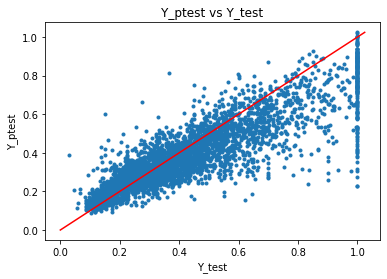

In [261]:
# obtain Yp_test
# "Yp_test=model(X_test)"  may need lots of memory
# we can use a for loop to get Yp_test, see the function test
Yp_test=[]
with torch.no_grad(): # tell Pytorch not to build graph in the 'with' section
    for batch_idx, (X, Y) in enumerate(dataloader_test):
        X, Y = X.to(device), Y.to(device)
        Yp = modelBetter(X)#forward pass
        Yp_test.append(Yp.detach().cpu().numpy())
Yp_test=np.concatenate(Yp_test, axis=0).squeeze()

# compute MSE, MAE and MAPE on test set
MSE = np.mean((Y_test - Yp_test)**2)
MAE = np.mean(np.abs(Y_test - Yp_test))
MAPE =  np.mean(np.abs(Y_test - Yp_test)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)

# plot Yp_test vs Y_test
# the red line is the 45-degree line
print('Evaluate model on testing set')

fig, ax = plt.subplots()
ax.set_title('Y_ptest vs Y_test')
ax.plot(Y_test, Yp_test, '.')
ymax=np.max([Y_test.max(), Yp_test.max()])
ax.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_ptest')